In [1]:
!pip install rdkit

In [2]:
!pip install rdkit-pypi
!pip install matplotlib

In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [5]:
!pip install torchvision

In [6]:
!pip install pytorch-lightning

In [7]:
!pip install deepchem

In [8]:
!pip install pytorch-lightning

In [9]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
import torch
from torch_geometric.data import Data


In [10]:
import os
import csv
import glob
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data

In [11]:
from typing import List, Tuple
import numpy as np

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer
from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot

In [12]:
# from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
# from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
# from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]

USER_ATOM_TYPE_SET  = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
       'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
       'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
       'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb']
USER_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
USER_HYBRIDIZATION_SET = ["SP", "SP2", "SP3", 'SP3D','SP3D2']

In [15]:
def one_hot_encode(value, allowed_values, include_unknown_set=False):
    """Create a one-hot encoded vector based on allowed values."""
    if include_unknown_set and value not in allowed_values:
        value = allowed_values[-1]

    return [1.0 if v == value else 0.0 for v in allowed_values]


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
from torch_geometric.data import Data

class MolGraphConvFeaturizer:
    def __init__(self, use_edges=True, use_chirality=True, use_partial_charge=True):
        self.use_edges = use_edges
        self.use_chirality = use_chirality
        self.use_partial_charge = use_partial_charge

    def featurize(self, smiles):
        # Convert SMILES to RDKit Mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Compute Gasteiger charges if necessary
        if self.use_partial_charge:
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                return None  # Unable to compute charges for this molecule

        # Get atom features
        atom_features = np.array([self._get_atom_features(atom) for atom in mol.GetAtoms()])

        # Get bond features and indices
        if self.use_edges:
            edge_indices, edge_features = self._get_bond_features(mol)
        else:
            edge_indices, edge_features = None, None

        # Create a graph data object
        graph = Data(x=torch.tensor(atom_features, dtype=torch.float),
                     edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices is not None else None,
                     edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)

        return graph

    def _get_atom_features(self, atom):
        # One-hot encoding of atom type
        atom_type = one_hot_encode(atom.GetSymbol(), USER_ATOM_TYPE_SET, include_unknown_set=True)

        # Formal charge of the atom
        formal_charge = get_atom_formal_charge(atom)

        # One-hot encoding of the atom's hybridization
        hybridization = get_atom_hybridization_one_hot(atom, USER_HYBRIDIZATION_SET, include_unknown_set=True)

        # Aromaticity of the atom
        aromatic = get_atom_is_in_aromatic_one_hot(atom)

        # One-hot encoding of the atom's degree
        degree = get_atom_total_degree_one_hot(atom, USER_TOTAL_DEGREE_SET, include_unknown_set=True)

        # One-hot encoding of the total number of hydrogens connected to the atom
        total_num_Hs = get_atom_total_num_Hs_one_hot(atom, DEFAULT_TOTAL_NUM_Hs_SET, include_unknown_set=True)

        # Concatenating all the features
        atom_feat = np.concatenate([
            atom_type, formal_charge, hybridization, aromatic, degree, total_num_Hs
        ])

        if self.use_chirality:
            chirality = get_atom_chirality_one_hot(atom)
            atom_feat = np.concatenate([atom_feat, chirality])

        if self.use_partial_charge:
            partial_charge = get_atom_partial_charge(atom)
            atom_feat = np.concatenate([atom_feat, partial_charge])

        return atom_feat

    def _get_bond_features(self, mol):
        # Initialize lists for source and destination atoms of each bond
        src, dest, bond_features = [], [], []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            src += [start, end]
            dest += [end, start]

            # Extract bond features and duplicate for both bond directions
            bond_feat = self._extract_bond_features(bond)
            bond_features += [bond_feat, bond_feat]

        edge_indices = [src, dest]
        #print("edge_indices : ",edge_indices)
        #print("bond_features : ",bond_features)
        return edge_indices, bond_features
        
    def _extract_bond_features(self, bond):
        """
        Extract bond features from a RDKit bond object.
        """

        # One-hot encoding of bond type
        bond_type = one_hot_encode(bond.GetBondTypeAsDouble(), [1.0, 1.5, 2.0, 3.0], include_unknown_set=True)

        # Whether the bond is in the same ring
        same_ring = [1.0] if bond.IsInRing() else [0.0]

        # Whether the bond is conjugated
        conjugated = [1.0] if bond.GetIsConjugated() else [0.0]

        # One-hot encoding of bond stereo configuration
        stereo = one_hot_encode(bond.GetStereo(), [Chem.rdchem.BondStereo.STEREONONE, 
                                                   Chem.rdchem.BondStereo.STEREOANY, 
                                                   Chem.rdchem.BondStereo.STEREOZ, 
                                                   Chem.rdchem.BondStereo.STEREOE], 
                                include_unknown_set=True)

        # Concatenate all bond features
        bond_feat = np.concatenate([bond_type, same_ring, conjugated, stereo])

        return bond_feat        


In [17]:
# Example usage
#featurizer = MolGraphConvFeaturizer()
#graph = featurizer.featurize('CCO')  # Example SMILES string
#print(type(graph))
#print((graph))

In [18]:
## Assuming graphs[0] is a torch_geometric.data.Data object from your graphs list

## Print node features
#print("Len of graph:", len(graph))
#print("Node Features:")
#for i, node_feature in enumerate(graph.x):
#    print(f"Node {i}: {node_feature}")

## Print edge pairs and edge features
#print("\nEdge Pairs and Features:")
#for i, edge in enumerate(graph.edge_index.t()):
#    src, dest = edge[0].item(), edge[1].item()
#    edge_feature = graph.edge_attr[i]
#    print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


In [19]:
#graph.is_directed()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_graph(data):
    # Create a networkx graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(data.num_nodes):
        G.add_node(i)

    # Add edges to the graph
    edge_index = data.edge_index.t().cpu().numpy()
    for edge in edge_index:
        src, dest = edge[0], edge[1]
        G.add_edge(src, dest)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()
#visualize_graph(graph)

In [21]:
# Load the data 
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-41-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test50k.txt", header=None, names=['SMILES'])


In [22]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [23]:
# Define a function to convert a SMILES string to a graph data object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    # Get bond features and adjacency information
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [(start, end), (end, start)]
        edge_feature = [bond.GetBondTypeAsDouble()]
        edge_features += [edge_feature, edge_feature]  # add twice for both directions

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create a graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [24]:
def read_smiles_df_check(smiles_df):
    graphs = []
    invalid_indices = []
    for idx, smiles in enumerate(smiles_df['SMILES']):
        graph = smiles_to_graph(smiles)
        if graph:
            graphs.append(graph)
        else:
            print("Invalid graph :", idx,smiles)
            invalid_indices.append(idx)
    return graphs, invalid_indices

graphs, invalid_indices = read_smiles_df_check(smiles_df)
print(f"Number of valid graphs: {len(graphs)}")
print(f"Indices of invalid SMILES: {invalid_indices}")

Number of valid graphs: 50001
Indices of invalid SMILES: []


In [25]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 50001


In [26]:
# Initialize the featurizer
featurizer = MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)

# Featurize SMILES strings and track invalid entries
graphs = []
invalid_indices = []
for idx, smiles in enumerate(smiles_df['SMILES']):
    print(idx)
    graph = featurizer.featurize(smiles)
    graphs.append(graph)    
    
#    try:
#        graph = featurizer.featurize(smiles)
#        graphs.append(graph)
#    except Exception as e:
#        print(f"Invalid SMILES at index {idx}: {smiles} (Error: {e})")
#        invalid_indices.append(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


C:\Users\Malli\AppData\Local\Temp\ipykernel_17984\3029635957.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)


62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
32

1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130


3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783


5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496


7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216


8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907


10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503
10504
10505
1050

11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864
11865
11866
11867
11868
11869
11870
11871
11872
11873
11874
11875
11876
11877
11878
11879
11880
11881
11882
11883
11884
11885
11886
11887
11888
11889
11890
11891
11892
11893
11894
11895
11896
11897
11898
11899
11900
11901
11902
11903
11904
11905
11906
11907
11908
11909
11910
11911
11912
11913
11914
11915
11916
11917
11918
11919
11920
11921
11922
11923
11924
11925
11926
11927
11928
11929
11930
11931
11932
11933
11934
11935
11936
11937
11938
11939
11940
11941
11942
11943
11944
11945
11946
11947
11948
11949
11950
11951
11952
11953
11954
11955
11956
11957
11958
11959
11960
11961
11962
1196

13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
1338

14648
14649
14650
14651
14652
14653
14654
14655
14656
14657
14658
14659
14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
1481

16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
1618

17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17600
1760

18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
18823
18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
18872
18873
18874
18875
18876
18877
18878
18879
18880
18881
18882
18883
18884
18885
18886
18887
18888
18889
18890
18891
18892
18893
18894
18895
18896
18897
18898
18899
18900
18901
18902
18903
18904
18905
18906
18907
18908
18909
18910
18911
18912
18913
18914
18915
18916
18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
1897

20218
20219
20220
20221
20222
20223
20224
20225
20226
20227
20228
20229
20230
20231
20232
20233
20234
20235
20236
20237
20238
20239
20240
20241
20242
20243
20244
20245
20246
20247
20248
20249
20250
20251
20252
20253
20254
20255
20256
20257
20258
20259
20260
20261
20262
20263
20264
20265
20266
20267
20268
20269
20270
20271
20272
20273
20274
20275
20276
20277
20278
20279
20280
20281
20282
20283
20284
20285
20286
20287
20288
20289
20290
20291
20292
20293
20294
20295
20296
20297
20298
20299
20300
20301
20302
20303
20304
20305
20306
20307
20308
20309
20310
20311
20312
20313
20314
20315
20316
20317
20318
20319
20320
20321
20322
20323
20324
20325
20326
20327
20328
20329
20330
20331
20332
20333
20334
20335
20336
20337
20338
20339
20340
20341
20342
20343
20344
20345
20346
20347
20348
20349
20350
20351
20352
20353
20354
20355
20356
20357
20358
20359
20360
20361
20362
20363
20364
20365
20366
20367
20368
20369
20370
20371
20372
20373
20374
20375
20376
20377
20378
20379
20380
20381
20382
20383
2038

21663
21664
21665
21666
21667
21668
21669
21670
21671
21672
21673
21674
21675
21676
21677
21678
21679
21680
21681
21682
21683
21684
21685
21686
21687
21688
21689
21690
21691
21692
21693
21694
21695
21696
21697
21698
21699
21700
21701
21702
21703
21704
21705
21706
21707
21708
21709
21710
21711
21712
21713
21714
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21737
21738
21739
21740
21741
21742
21743
21744
21745
21746
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757
21758
21759
21760
21761
21762
21763
21764
21765
21766
21767
21768
21769
21770
21771
21772
21773
21774
21775
21776
21777
21778
21779
21780
21781
21782
21783
21784
21785
21786
21787
21788
21789
21790
21791
21792
21793
21794
21795
21796
21797
21798
21799
21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
2182

23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
23125
23126
23127
23128
23129
23130
23131
23132
23133
23134
23135
23136
23137
23138
23139
23140
23141
23142
23143
23144
23145
23146
23147
23148
23149
23150
23151
23152
23153
23154
23155
23156
23157
23158
23159
23160
23161
23162
23163
23164
23165
23166
23167
23168
23169
23170
23171
23172
23173
23174
23175
23176
23177
23178
23179
23180
23181
23182
23183
23184
23185
23186
23187
23188
23189
23190
23191
23192
23193
23194
23195
23196
2319

24477
24478
24479
24480
24481
24482
24483
24484
24485
24486
24487
24488
24489
24490
24491
24492
24493
24494
24495
24496
24497
24498
24499
24500
24501
24502
24503
24504
24505
24506
24507
24508
24509
24510
24511
24512
24513
24514
24515
24516
24517
24518
24519
24520
24521
24522
24523
24524
24525
24526
24527
24528
24529
24530
24531
24532
24533
24534
24535
24536
24537
24538
24539
24540
24541
24542
24543
24544
24545
24546
24547
24548
24549
24550
24551
24552
24553
24554
24555
24556
24557
24558
24559
24560
24561
24562
24563
24564
24565
24566
24567
24568
24569
24570
24571
24572
24573
24574
24575
24576
24577
24578
24579
24580
24581
24582
24583
24584
24585
24586
24587
24588
24589
24590
24591
24592
24593
24594
24595
24596
24597
24598
24599
24600
24601
24602
24603
24604
24605
24606
24607
24608
24609
24610
24611
24612
24613
24614
24615
24616
24617
24618
24619
24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631
24632
24633
24634
24635
24636
24637
24638
24639
24640
24641
24642
2464

25844
25845
25846
25847
25848
25849
25850
25851
25852
25853
25854
25855
25856
25857
25858
25859
25860
25861
25862
25863
25864
25865
25866
25867
25868
25869
25870
25871
25872
25873
25874
25875
25876
25877
25878
25879
25880
25881
25882
25883
25884
25885
25886
25887
25888
25889
25890
25891
25892
25893
25894
25895
25896
25897
25898
25899
25900
25901
25902
25903
25904
25905
25906
25907
25908
25909
25910
25911
25912
25913
25914
25915
25916
25917
25918
25919
25920
25921
25922
25923
25924
25925
25926
25927
25928
25929
25930
25931
25932
25933
25934
25935
25936
25937
25938
25939
25940
25941
25942
25943
25944
25945
25946
25947
25948
25949
25950
25951
25952
25953
25954
25955
25956
25957
25958
25959
25960
25961
25962
25963
25964
25965
25966
25967
25968
25969
25970
25971
25972
25973
25974
25975
25976
25977
25978
25979
25980
25981
25982
25983
25984
25985
25986
25987
25988
25989
25990
25991
25992
25993
25994
25995
25996
25997
25998
25999
26000
26001
26002
26003
26004
26005
26006
26007
26008
26009
2601

27244
27245
27246
27247
27248
27249
27250
27251
27252
27253
27254
27255
27256
27257
27258
27259
27260
27261
27262
27263
27264
27265
27266
27267
27268
27269
27270
27271
27272
27273
27274
27275
27276
27277
27278
27279
27280
27281
27282
27283
27284
27285
27286
27287
27288
27289
27290
27291
27292
27293
27294
27295
27296
27297
27298
27299
27300
27301
27302
27303
27304
27305
27306
27307
27308
27309
27310
27311
27312
27313
27314
27315
27316
27317
27318
27319
27320
27321
27322
27323
27324
27325
27326
27327
27328
27329
27330
27331
27332
27333
27334
27335
27336
27337
27338
27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
2741

28616
28617
28618
28619
28620
28621
28622
28623
28624
28625
28626
28627
28628
28629
28630
28631
28632
28633
28634
28635
28636
28637
28638
28639
28640
28641
28642
28643
28644
28645
28646
28647
28648
28649
28650
28651
28652
28653
28654
28655
28656
28657
28658
28659
28660
28661
28662
28663
28664
28665
28666
28667
28668
28669
28670
28671
28672
28673
28674
28675
28676
28677
28678
28679
28680
28681
28682
28683
28684
28685
28686
28687
28688
28689
28690
28691
28692
28693
28694
28695
28696
28697
28698
28699
28700
28701
28702
28703
28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
2878

30071
30072
30073
30074
30075
30076
30077
30078
30079
30080
30081
30082
30083
30084
30085
30086
30087
30088
30089
30090
30091
30092
30093
30094
30095
30096
30097
30098
30099
30100
30101
30102
30103
30104
30105
30106
30107
30108
30109
30110
30111
30112
30113
30114
30115
30116
30117
30118
30119
30120
30121
30122
30123
30124
30125
30126
30127
30128
30129
30130
30131
30132
30133
30134
30135
30136
30137
30138
30139
30140
30141
30142
30143
30144
30145
30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166
30167
30168
30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181
30182
30183
30184
30185
30186
30187
30188
30189
30190
30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207
30208
30209
30210
30211
30212
30213
30214
30215
30216
30217
30218
30219
30220
30221
30222
30223
30224
30225
30226
30227
30228
30229
30230
30231
30232
30233
30234
30235
30236
3023

31488
31489
31490
31491
31492
31493
31494
31495
31496
31497
31498
31499
31500
31501
31502
31503
31504
31505
31506
31507
31508
31509
31510
31511
31512
31513
31514
31515
31516
31517
31518
31519
31520
31521
31522
31523
31524
31525
31526
31527
31528
31529
31530
31531
31532
31533
31534
31535
31536
31537
31538
31539
31540
31541
31542
31543
31544
31545
31546
31547
31548
31549
31550
31551
31552
31553
31554
31555
31556
31557
31558
31559
31560
31561
31562
31563
31564
31565
31566
31567
31568
31569
31570
31571
31572
31573
31574
31575
31576
31577
31578
31579
31580
31581
31582
31583
31584
31585
31586
31587
31588
31589
31590
31591
31592
31593
31594
31595
31596
31597
31598
31599
31600
31601
31602
31603
31604
31605
31606
31607
31608
31609
31610
31611
31612
31613
31614
31615
31616
31617
31618
31619
31620
31621
31622
31623
31624
31625
31626
31627
31628
31629
31630
31631
31632
31633
31634
31635
31636
31637
31638
31639
31640
31641
31642
31643
31644
31645
31646
31647
31648
31649
31650
31651
31652
31653
3165

32895
32896
32897
32898
32899
32900
32901
32902
32903
32904
32905
32906
32907
32908
32909
32910
32911
32912
32913
32914
32915
32916
32917
32918
32919
32920
32921
32922
32923
32924
32925
32926
32927
32928
32929
32930
32931
32932
32933
32934
32935
32936
32937
32938
32939
32940
32941
32942
32943
32944
32945
32946
32947
32948
32949
32950
32951
32952
32953
32954
32955
32956
32957
32958
32959
32960
32961
32962
32963
32964
32965
32966
32967
32968
32969
32970
32971
32972
32973
32974
32975
32976
32977
32978
32979
32980
32981
32982
32983
32984
32985
32986
32987
32988
32989
32990
32991
32992
32993
32994
32995
32996
32997
32998
32999
33000
33001
33002
33003
33004
33005
33006
33007
33008
33009
33010
33011
33012
33013
33014
33015
33016
33017
33018
33019
33020
33021
33022
33023
33024
33025
33026
33027
33028
33029
33030
33031
33032
33033
33034
33035
33036
33037
33038
33039
33040
33041
33042
33043
33044
33045
33046
33047
33048
33049
33050
33051
33052
33053
33054
33055
33056
33057
33058
33059
33060
3306

34314
34315
34316
34317
34318
34319
34320
34321
34322
34323
34324
34325
34326
34327
34328
34329
34330
34331
34332
34333
34334
34335
34336
34337
34338
34339
34340
34341
34342
34343
34344
34345
34346
34347
34348
34349
34350
34351
34352
34353
34354
34355
34356
34357
34358
34359
34360
34361
34362
34363
34364
34365
34366
34367
34368
34369
34370
34371
34372
34373
34374
34375
34376
34377
34378
34379
34380
34381
34382
34383
34384
34385
34386
34387
34388
34389
34390
34391
34392
34393
34394
34395
34396
34397
34398
34399
34400
34401
34402
34403
34404
34405
34406
34407
34408
34409
34410
34411
34412
34413
34414
34415
34416
34417
34418
34419
34420
34421
34422
34423
34424
34425
34426
34427
34428
34429
34430
34431
34432
34433
34434
34435
34436
34437
34438
34439
34440
34441
34442
34443
34444
34445
34446
34447
34448
34449
34450
34451
34452
34453
34454
34455
34456
34457
34458
34459
34460
34461
34462
34463
34464
34465
34466
34467
34468
34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
3448

35712
35713
35714
35715
35716
35717
35718
35719
35720
35721
35722
35723
35724
35725
35726
35727
35728
35729
35730
35731
35732
35733
35734
35735
35736
35737
35738
35739
35740
35741
35742
35743
35744
35745
35746
35747
35748
35749
35750
35751
35752
35753
35754
35755
35756
35757
35758
35759
35760
35761
35762
35763
35764
35765
35766
35767
35768
35769
35770
35771
35772
35773
35774
35775
35776
35777
35778
35779
35780
35781
35782
35783
35784
35785
35786
35787
35788
35789
35790
35791
35792
35793
35794
35795
35796
35797
35798
35799
35800
35801
35802
35803
35804
35805
35806
35807
35808
35809
35810
35811
35812
35813
35814
35815
35816
35817
35818
35819
35820
35821
35822
35823
35824
35825
35826
35827
35828
35829
35830
35831
35832
35833
35834
35835
35836
35837
35838
35839
35840
35841
35842
35843
35844
35845
35846
35847
35848
35849
35850
35851
35852
35853
35854
35855
35856
35857
35858
35859
35860
35861
35862
35863
35864
35865
35866
35867
35868
35869
35870
35871
35872
35873
35874
35875
35876
35877
3587

37139
37140
37141
37142
37143
37144
37145
37146
37147
37148
37149
37150
37151
37152
37153
37154
37155
37156
37157
37158
37159
37160
37161
37162
37163
37164
37165
37166
37167
37168
37169
37170
37171
37172
37173
37174
37175
37176
37177
37178
37179
37180
37181
37182
37183
37184
37185
37186
37187
37188
37189
37190
37191
37192
37193
37194
37195
37196
37197
37198
37199
37200
37201
37202
37203
37204
37205
37206
37207
37208
37209
37210
37211
37212
37213
37214
37215
37216
37217
37218
37219
37220
37221
37222
37223
37224
37225
37226
37227
37228
37229
37230
37231
37232
37233
37234
37235
37236
37237
37238
37239
37240
37241
37242
37243
37244
37245
37246
37247
37248
37249
37250
37251
37252
37253
37254
37255
37256
37257
37258
37259
37260
37261
37262
37263
37264
37265
37266
37267
37268
37269
37270
37271
37272
37273
37274
37275
37276
37277
37278
37279
37280
37281
37282
37283
37284
37285
37286
37287
37288
37289
37290
37291
37292
37293
37294
37295
37296
37297
37298
37299
37300
37301
37302
37303
37304
3730

38605
38606
38607
38608
38609
38610
38611
38612
38613
38614
38615
38616
38617
38618
38619
38620
38621
38622
38623
38624
38625
38626
38627
38628
38629
38630
38631
38632
38633
38634
38635
38636
38637
38638
38639
38640
38641
38642
38643
38644
38645
38646
38647
38648
38649
38650
38651
38652
38653
38654
38655
38656
38657
38658
38659
38660
38661
38662
38663
38664
38665
38666
38667
38668
38669
38670
38671
38672
38673
38674
38675
38676
38677
38678
38679
38680
38681
38682
38683
38684
38685
38686
38687
38688
38689
38690
38691
38692
38693
38694
38695
38696
38697
38698
38699
38700
38701
38702
38703
38704
38705
38706
38707
38708
38709
38710
38711
38712
38713
38714
38715
38716
38717
38718
38719
38720
38721
38722
38723
38724
38725
38726
38727
38728
38729
38730
38731
38732
38733
38734
38735
38736
38737
38738
38739
38740
38741
38742
38743
38744
38745
38746
38747
38748
38749
38750
38751
38752
38753
38754
38755
38756
38757
38758
38759
38760
38761
38762
38763
38764
38765
38766
38767
38768
38769
38770
3877

40008
40009
40010
40011
40012
40013
40014
40015
40016
40017
40018
40019
40020
40021
40022
40023
40024
40025
40026
40027
40028
40029
40030
40031
40032
40033
40034
40035
40036
40037
40038
40039
40040
40041
40042
40043
40044
40045
40046
40047
40048
40049
40050
40051
40052
40053
40054
40055
40056
40057
40058
40059
40060
40061
40062
40063
40064
40065
40066
40067
40068
40069
40070
40071
40072
40073
40074
40075
40076
40077
40078
40079
40080
40081
40082
40083
40084
40085
40086
40087
40088
40089
40090
40091
40092
40093
40094
40095
40096
40097
40098
40099
40100
40101
40102
40103
40104
40105
40106
40107
40108
40109
40110
40111
40112
40113
40114
40115
40116
40117
40118
40119
40120
40121
40122
40123
40124
40125
40126
40127
40128
40129
40130
40131
40132
40133
40134
40135
40136
40137
40138
40139
40140
40141
40142
40143
40144
40145
40146
40147
40148
40149
40150
40151
40152
40153
40154
40155
40156
40157
40158
40159
40160
40161
40162
40163
40164
40165
40166
40167
40168
40169
40170
40171
40172
40173
4017

41465
41466
41467
41468
41469
41470
41471
41472
41473
41474
41475
41476
41477
41478
41479
41480
41481
41482
41483
41484
41485
41486
41487
41488
41489
41490
41491
41492
41493
41494
41495
41496
41497
41498
41499
41500
41501
41502
41503
41504
41505
41506
41507
41508
41509
41510
41511
41512
41513
41514
41515
41516
41517
41518
41519
41520
41521
41522
41523
41524
41525
41526
41527
41528
41529
41530
41531
41532
41533
41534
41535
41536
41537
41538
41539
41540
41541
41542
41543
41544
41545
41546
41547
41548
41549
41550
41551
41552
41553
41554
41555
41556
41557
41558
41559
41560
41561
41562
41563
41564
41565
41566
41567
41568
41569
41570
41571
41572
41573
41574
41575
41576
41577
41578
41579
41580
41581
41582
41583
41584
41585
41586
41587
41588
41589
41590
41591
41592
41593
41594
41595
41596
41597
41598
41599
41600
41601
41602
41603
41604
41605
41606
41607
41608
41609
41610
41611
41612
41613
41614
41615
41616
41617
41618
41619
41620
41621
41622
41623
41624
41625
41626
41627
41628
41629
41630
4163

42867
42868
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
42933
42934
42935
42936
42937
42938
42939
42940
42941
42942
42943
42944
42945
42946
42947
42948
42949
42950
42951
42952
42953
42954
42955
42956
42957
42958
42959
42960
42961
42962
42963
42964
42965
42966
42967
42968
42969
42970
42971
42972
42973
42974
42975
42976
42977
42978
42979
42980
42981
42982
42983
42984
42985
42986
42987
42988
42989
42990
42991
42992
42993
42994
42995
42996
42997
42998
42999
43000
43001
43002
43003
43004
43005
43006
43007
43008
43009
43010
43011
43012
43013
43014
43015
43016
43017
43018
43019
43020
43021
43022
43023
43024
43025
43026
43027
43028
43029
43030
43031
43032
4303

44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
44355
44356
44357
44358
44359
44360
44361
44362
44363
44364
44365
44366
44367
44368
44369
44370
44371
44372
44373
44374
44375
44376
44377
44378
44379
44380
44381
44382
44383
44384
44385
44386
44387
44388
44389
44390
44391
44392
44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410
44411
44412
44413
44414
44415
44416
44417
44418
44419
44420
44421
44422
44423
44424
44425
44426
44427
44428
44429
44430
44431
44432
44433
44434
44435
44436
44437
4443

45687
45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822
45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
45842
45843
45844
45845
45846
45847
45848
45849
45850
45851
45852
4585

47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
47158
47159
47160
47161
47162
47163
47164
47165
47166
47167
47168
47169
47170
47171
47172
47173
47174
47175
47176
47177
47178
47179
47180
47181
47182
47183
47184
47185
47186
47187
47188
47189
47190
47191
47192
47193
47194
47195
47196
47197
47198
47199
47200
47201
47202
47203
47204
47205
47206
47207
47208
47209
47210
47211
47212
47213
47214
47215
47216
47217
47218
47219
47220
47221
47222
47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
47236
47237
47238
47239
47240
47241
47242
47243
47244
47245
47246
47247
47248
47249
47250
47251
47252
47253
47254
47255
47256
47257
47258
47259
47260
47261
47262
47263
47264
47265
47266
47267
47268
47269
47270
47271
47272
47273
47274
47275
47276
47277
47278
47279
47280
47281
47282
47283
47284
47285
47286
47287
47288
47289
47290
47291
47292
47293
47294
4729

48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48513
48514
48515
48516
48517
48518
48519
48520
48521
48522
48523
48524
48525
48526
48527
48528
48529
48530
48531
48532
48533
48534
48535
48536
48537
48538
48539
48540
48541
48542
48543
48544
48545
48546
48547
48548
48549
48550
48551
48552
48553
48554
48555
48556
48557
48558
48559
48560
48561
48562
48563
48564
48565
48566
48567
48568
48569
48570
48571
48572
48573
48574
48575
48576
48577
48578
48579
48580
48581
48582
48583
48584
48585
48586
48587
48588
48589
48590
48591
48592
48593
48594
48595
48596
48597
48598
48599
48600
48601
48602
48603
48604
48605
48606
48607
48608
48609
48610
48611
48612
48613
48614
48615
48616
48617
48618
48619
48620
48621
48622
48623
48624
48625
48626
48627
48628
48629
48630
48631
48632
48633
48634
48635
48636
48637
48638
48639
48640
48641
48642
48643
48644
48645
48646
48647
48648
48649
48650
48651
48652
48653
48654
48655
48656
48657
48658
48659
48660
48661
48662
48663
48664
48665
48666
4866

49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901
49902
49903
49904
49905
49906
49907
49908
49909
49910
49911
49912
49913
49914
49915
49916
49917
49918
49919
49920
49921
49922
49923
49924
49925
49926
49927
49928
49929
49930
49931
49932
49933
49934
49935
49936
49937
49938
49939
49940
49941
49942
49943
49944
49945
49946
49947
49948
49949
49950
49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49970
49971
49972
49973
49974
49975
49976
49977
49978
49979
49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000


In [27]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))

Length of smiles_df: 50001


In [28]:
print(len(graphs))
print(type(graphs[1]))
print((graphs[1]))

50001
<class 'torch_geometric.data.data.Data'>
Data(x=[17, 72], edge_index=[36, 2], edge_attr=[36, 10])


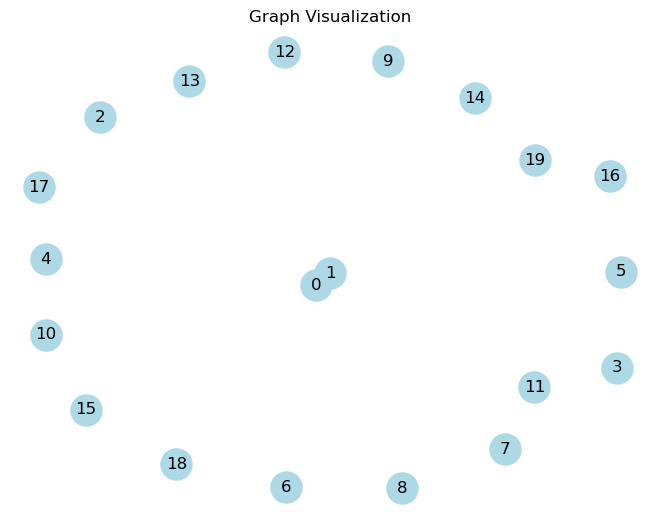

In [29]:
visualize_graph(graphs[3])

In [30]:
!pip install torch_geometric

In [31]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

In [32]:
import torch

# Example graph object from the user's data
graph = graphs[3]

# Extracting edge indices
edge_indices = graph.edge_index.t().tolist()

# Extracting node features (assuming each node has a feature vector)
node_features = graph.x.tolist()

# The nodes can be represented as a list of indices from 0 to the number of nodes - 1
node_indices = list(range(len(node_features)))

# Displaying the node indices and edge indices
#node_indices, edge_indices
#print(node_features)

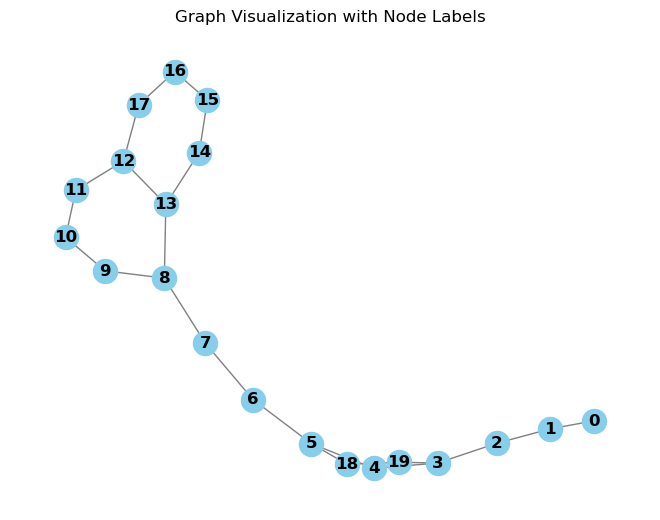

In [33]:
import networkx as nx
import torch_geometric

edge_index = torch.tensor(edge_indices, dtype=torch.long)
x = torch.tensor(node_indices, dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Draw the graph with node labels
pos = nx.spring_layout(g)  # Compute layout
nx.draw(g, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization with Node Labels")
plt.show()

In [34]:
# Print the edge indices
print(graphs[3].edge_index.t().tolist())

[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 5, 18, 18, 19, 19, 3, 13, 8, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 5, 19, 18, 3, 19, 8, 13, 12, 17]]


In [35]:
# graphs[0] is a torch_geometric.data.Data object from your graphs list
graph = graphs[3]

# Print node features
print("Len of graph:", len(graph))
print("Node Features:")
print(len(graph.x))
#for i, node_feature in enumerate(graph.x):
    #print(f"Node {i}: {node_feature}")

# Print edge pairs and edge features
print("\nEdge Pairs and Features:")
print(graph.edge_index.t())
for i, edge in enumerate(graph.edge_index.t()):
    src, dest = edge[0].item(), edge[1].item()
    edge_feature = graph.edge_attr[i]
    #print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


Len of graph: 3
Node Features:
20

Edge Pairs and Features:
tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,  5, 18,
         18, 19, 19,  3, 13,  8, 17, 12],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,  5,
         19, 18,  3, 19,  8, 13, 12, 17]])


In [36]:
# Extracting edge list and edge features from the provided graph
graph = graphs[5]  

# Extracting edge index
edge_index = graph.edge_index.t()

# Preparing the edge list
edge_list = []
for i in range(edge_index.shape[1]):
    edge = edge_index[:, i]
    edge_list.append((edge[0].item(), edge[1].item()))

edge_list


[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (9, 10),
 (10, 9),
 (1, 11),
 (11, 1),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (14, 24),
 (24, 14),
 (24, 25),
 (25, 24),
 (10, 4),
 (4, 10),
 (25, 11),
 (11, 25),
 (23, 15),
 (15, 23),
 (23, 18),
 (18, 23)]

In [37]:
import torch
from torch_geometric.data import Data

# Assuming graph_data is your list of graph objects
# graph_data[0] is the first graph object

# Select the first graph object
first_graph = graphs[3]

# Convert node features to a floating-point type if they aren't already
node_features_float = first_graph.x.float()

# Inspect node features
print("Node features (x) of the first graph:")
print(node_features_float)
print("Shape of node features:", node_features_float.shape)

# Inspect edge features
print("\nEdge features (edge_attr) of the first graph:")
print(first_graph.edge_attr)
print("Shape of edge features:", first_graph.edge_attr.shape)

# Inspect edge index (connectivity)
print("\nEdge index (edge_index) of the first graph:")
print(first_graph.edge_index)
print("Shape of edge index:", first_graph.edge_index.shape)

# Calculate min and max for each node feature of the first graph
min_values, max_values = node_features_float.min(dim=0)[0], node_features_float.max(dim=0)[0]

print("\nMinimum values of node features:", min_values)
print("Maximum values of node features:", max_values)

# Calculate the standard deviation for each node feature
std_deviation = node_features_float.std(dim=0)
print("\nStandard deviation of node features:", std_deviation)


Node features (x) of the first graph:
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000, -0.3944],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0628],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0658],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0275],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1335],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0670]])
Shape of node features: torch.Size([20, 72])

Edge features (edge_attr) of the first graph:
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1.,

In [38]:
smiles_df['SMILES'][3]

'OCCn1cc(CNc2cccc3c2CCCC3)nn1'

In [39]:
mol = Chem.MolFromSmiles(smiles_df['SMILES'][3])
AllChem.ComputeGasteigerCharges(mol)

In [40]:
edge_indices = []
for bond in mol.GetBonds():
    start_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    edge_indices.append((start_idx, end_idx))
    edge_indices.append((end_idx, start_idx))  # Add the reverse direction


In [41]:
edge_indices

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (5, 18),
 (18, 5),
 (18, 19),
 (19, 18),
 (19, 3),
 (3, 19),
 (13, 8),
 (8, 13),
 (17, 12),
 (12, 17)]

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

In [43]:
print((graphs[0]))
print((smiles_df.head(1)))

Data(x=[25, 72], edge_index=[54, 2], edge_attr=[54, 10])
                                   SMILES
0  CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1


In [44]:
print(len(graphs))
print(len(smiles_df))

50001
50001


In [45]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 50001


In [46]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [47]:
print(type(graphs[3]))

<class 'torch_geometric.data.data.Data'>


In [48]:
# Unsupervised Graph Generative Adversarial Netwrok

In [49]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [50]:
def generate_random_edge_index(num_nodes):
    # Example implementation to generate a random edge_index
    # Here we create a fully connected graph for simplicity
    edge_index = torch.combinations(torch.arange(num_nodes), r=2)
    return torch.cat([edge_index, edge_index.flip([1])], dim=0).t()  # Making it undirected

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data, Batch
from torch_geometric.utils import erdos_renyi_graph

def generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes):
    """
    Generate random noise for a batch of graphs with variable number of nodes and edges,
    but fixed node feature and edge feature dimensions.

    Args:
    - batch_size (int): Number of random graphs to generate.
    - node_feature_dim (int): Number of features for each node.
    - edge_feature_dim (int): Number of features for each edge.
    - max_num_nodes (int): Maximum number of nodes a graph can have.

    Returns:
    - A list of Data objects containing random noise for node and edge features.
    """
    random_graphs = []

    for _ in range(batch_size):
        # Randomly determine the number of nodes for this graph
        num_nodes = torch.randint(low=1, high=max_num_nodes, size=(1,)).item()

        # Generate random node features
        x = torch.randn(num_nodes, node_feature_dim)

        # Generate a random graph structure (edge_index)
        edge_index = erdos_renyi_graph(num_nodes, edge_prob=0.5)  # p is the probability of an edge

        # Generate random edge features (if needed)
        num_edges = edge_index.size(1)
        edge_attr = torch.randn(num_edges, edge_feature_dim) if edge_feature_dim > 0 else None

        # Create a Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        random_graphs.append(data)

    #return random_graphs
    return Batch.from_data_list(random_graphs)





In [52]:
# Example usage
batch_size = 32
node_feature_dim = 72  # Number of node features
edge_feature_dim = 10  # Number of edge features, adjust as needed
max_num_nodes = 50    # Maximum number of nodes in a graph

random_noise_graphs = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)

In [53]:
random_noise_graphs 

DataBatch(x=[882, 72], edge_index=[2, 14606], edge_attr=[14606, 10], batch=[882], ptr=[33])

In [54]:
# Generator Model
class Generator_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index gen",type(x), type(edge_index))
        #print("x, edge_index gen",x.size(), edge_index.size())
        #print("x, edge_index gen",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("Generator x layer 1:",x)
        x = torch.sigmoid(self.layer2(x, edge_index))
        #print("Generator x  layer 2:",x)
        return x

In [55]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.layer1(x, edge_index))
        x = torch.sigmoid(self.layer2(x, edge_index))

        # Generate fake edge_index (simple example, should be improved)
        fake_edge_index = self.generate_fake_edge_index(x.size(0))
        return x, fake_edge_index

    def generate_fake_edge_index(self, num_nodes):
        # Implement logic to generate a plausible edge_index for fake graphs
        # Placeholder logic: create a simple linear chain graph
        edge_index = torch.tensor([[i, i+1] for i in range(num_nodes - 1)], dtype=torch.long).t()
        return edge_index


In [56]:
# Discriminator Model  
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        #print("In discriminator")
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("self.layer1",input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        #print("self.layer2",hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index1",type(x), type(edge_index))
        #print("x, edge_index2",x.size(), edge_index.size())
        #print("x, edge_index3",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("x 2",x)
        x = torch.sigmoid(self.layer2(x))
        #print("x 3",x)
        return x

In [57]:
# Model Initialization
generator_input_dim = 72
generator_hidden_dim = 256
#generator_hidden_dim = 128
generator_output_dim = 72

discriminator_input_dim = 72
discriminator_hidden_dim = 256
#discriminator_hidden_dim = 128

In [58]:
generator = Generator(generator_input_dim, generator_hidden_dim, generator_output_dim)
discriminator = Discriminator(discriminator_input_dim, discriminator_hidden_dim)

In [59]:
import torch.optim as optim
from torch_geometric.data import DataLoader
#from torch_geometric.loader import DataLoader

from torch.utils.data import Dataset

# Sample data loader (replace with your dataset)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=['x', 'edge_index'])
data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=[])



# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function
adversarial_loss = torch.nn.BCELoss()

C:\Users\Malli\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [60]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(discriminator, real_data, fake_data):
    real_predictions = discriminator(real_data).round()
    fake_predictions = discriminator(fake_data).round()
    correct_predictions = (real_predictions == 1).sum() + (fake_predictions == 0).sum()
    total_predictions = real_predictions.numel() + fake_predictions.numel()
    accuracy = 100 * correct_predictions.float() / total_predictions
    return accuracy

In [61]:
print((data_loader))

In [62]:
print((graphs[3].x).shape)
print((graphs[3].edge_index).shape)

torch.Size([20, 72])
torch.Size([44, 2])


In [63]:
print((graphs[0].x).shape)
print((graphs[0].edge_index).shape)

torch.Size([25, 72])
torch.Size([54, 2])


In [64]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

def custom_graph_data_loader(graph_dataset, batch_size):
    """
    Custom data loader for graph data.
    
    Args:
    - graph_dataset (list of Data): The dataset containing graph Data objects.
    - batch_size (int): The size of each batch.

    Yields:
    - Batched Data object containing a batch of graphs.
    """

    def batch_graphs(graphs):
        """
        Manually batches a list of graphs into a single Batch object.
        """
        batched_edge_index = []
        batched_x = []
        batched_batch = []

        current_node_idx = 0
        for i, graph in enumerate(graphs):
            # Offset the node indices by the current_node_idx and add them to the batched edge index.
            #edge_index_offset = graph.edge_index + current_node_idx
            #batched_edge_index.append(edge_index_offset)
            
            # Offset only the node indices in the edge_index tensor.
            edge_index_offset = graph.edge_index.clone()  # Make a copy to avoid modifying the original graph
            edge_index_offset[0, :] += current_node_idx  # Offset source node indices
            edge_index_offset[1, :] += current_node_idx  # Offset target node indices
            #batched_edge_index.append(edge_index_offset)            
            
            #Tring edge_index
            #batched_edge_index.append(graph.edge_index)
            batched_edge_index.append(graph.edge_index + current_node_idx)

            # Add the current graph's node features to the batched node features.
            batched_x.append(graph.x)

            # Add the graph index to the batch vector for all nodes of this graph.
            batched_batch.append(torch.full((graph.x.size(0),), i, dtype=torch.long))

            # Update the current_node_idx for the next graph.
            current_node_idx += graph.x.size(0)

        # Concatenate all the lists to create tensors.       
        
        batched_edge_index = torch.cat(batched_edge_index, dim=0)
        batched_x = torch.cat(batched_x, dim=0)
        batched_batch = torch.cat(batched_batch, dim=0)
        

        # Create a new Data object to hold the batched graph.
        batched_data = Data(x=batched_x, edge_index=batched_edge_index)
        batched_data.batch = batched_batch

        return batched_data

    # Shuffle dataset at the beginning of each epoch
    indices = torch.randperm(len(graph_dataset))
    
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_graphs_list = [graph_dataset[i] for i in batch_indices]
        batch = batch_graphs(batch_graphs_list)
        yield batch


In [65]:
import matplotlib.pyplot as plt
import torch

def calculate_accuracy(preds, labels):
    predicted_labels = preds.round()  # Convert probabilities to 0/1
    correct = (predicted_labels == labels).float()  # Convert into float for division 
    accuracy = correct.sum() / len(correct)
    return accuracy

In [66]:
num_epochs = 30
batch_size = 32

# Lists to store metrics
epochs = []
d_losses = []
g_losses = []
real_accuracy_list =[]
fake_accuracy_list=[]
d_accuracies = []


for epoch in range(num_epochs):
    print("epoch", epoch)
    for batch in custom_graph_data_loader(graphs, batch_size):
        # Generate fake data
        random_noise_graphs_batch = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)

        # Ensure the real edge_index is correctly shaped [2, num_edges]
        if batch.edge_index.size(0) != 2:
            batch.edge_index = batch.edge_index.t()  # Transpose if necessary        
        
        # Create fake data batch with both x and edge_index
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)

        # Labels for real and fake data (for each node)
        real_labels = torch.ones(batch.x.size(0), 1)
        fake_labels = torch.zeros(fake_data.x.size(0), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(batch), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # Recompute fake data and perform forward pass through discriminator
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)
        updated_real_labels = torch.ones(fake_data.x.size(0), 1)
        g_loss = adversarial_loss(discriminator(fake_data), updated_real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        
        # Calculate discriminator accuracy
        real_accuracy = calculate_accuracy(discriminator(batch).detach(), real_labels)
        print("real_accuracy",real_accuracy)
        fake_accuracy = calculate_accuracy(discriminator(fake_data).detach(), fake_labels)
        print("fake_accuracy",fake_accuracy)
        d_accuracy = (real_accuracy + fake_accuracy) / 2

        # Store metrics
        d_losses.append(d_loss.item())
        print("d_loss.item()",d_loss.item())
        g_losses.append(g_loss.item())
        print("g_loss.item()",g_loss.item())
        d_accuracies.append(d_accuracy.item())
        real_accuracy_list.append(real_accuracy.item())
        fake_accuracy_list.append(fake_accuracy.item())
        
        epochs.append(epoch)


epoch 0
real_accuracy tensor(0.8796)
fake_accuracy tensor(1.)
d_loss.item() 1.3397009372711182
g_loss.item() 0.8311107158660889
real_accuracy tensor(0.9389)
fake_accuracy tensor(1.)
d_loss.item() 1.256883144378662
g_loss.item() 0.9295570254325867
real_accuracy tensor(0.9830)
fake_accuracy tensor(1.)
d_loss.item() 1.1848556995391846
g_loss.item() 1.0298871994018555
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 1.1214563846588135
g_loss.item() 1.1261084079742432
real_accuracy tensor(0.9795)
fake_accuracy tensor(1.)
d_loss.item() 1.0677132606506348
g_loss.item() 1.2188072204589844
real_accuracy tensor(0.9896)
fake_accuracy tensor(1.)
d_loss.item() 1.019370198249817
g_loss.item() 1.3102415800094604
real_accuracy tensor(0.9932)
fake_accuracy tensor(1.)
d_loss.item() 0.9788029789924622
g_loss.item() 1.3984336853027344
real_accuracy tensor(0.9953)
fake_accuracy tensor(1.)
d_loss.item() 0.9399877786636353
g_loss.item() 1.4880956411361694
real_accuracy tensor(0.9989)
fake_

real_accuracy tensor(1.)
fake_accuracy tensor(0.8197)
d_loss.item() 0.7209290862083435
g_loss.item() 1.383437156677246
real_accuracy tensor(1.)
fake_accuracy tensor(0.9296)
d_loss.item() 0.5897603631019592
g_loss.item() 1.6630786657333374
real_accuracy tensor(1.)
fake_accuracy tensor(0.9462)
d_loss.item() 0.5582324862480164
g_loss.item() 1.8652164936065674
real_accuracy tensor(1.)
fake_accuracy tensor(0.8792)
d_loss.item() 0.64742112159729
g_loss.item() 1.7014024257659912
real_accuracy tensor(1.)
fake_accuracy tensor(0.9308)
d_loss.item() 0.613038957118988
g_loss.item() 1.7574268579483032
real_accuracy tensor(1.)
fake_accuracy tensor(0.9742)
d_loss.item() 0.5931624174118042
g_loss.item() 1.9128960371017456
real_accuracy tensor(1.)
fake_accuracy tensor(0.9345)
d_loss.item() 0.6912670731544495
g_loss.item() 1.6972366571426392
real_accuracy tensor(1.)
fake_accuracy tensor(0.9768)
d_loss.item() 0.6936534643173218
g_loss.item() 1.761926531791687
real_accuracy tensor(0.9934)
fake_accuracy te

real_accuracy tensor(0.5587)
fake_accuracy tensor(0.9973)
d_loss.item() 1.2660897970199585
g_loss.item() 0.9068989157676697
real_accuracy tensor(0.5945)
fake_accuracy tensor(0.9958)
d_loss.item() 1.221959114074707
g_loss.item() 0.9145472645759583
real_accuracy tensor(0.5862)
fake_accuracy tensor(0.9958)
d_loss.item() 1.2518296241760254
g_loss.item() 0.8888832926750183
real_accuracy tensor(0.5790)
fake_accuracy tensor(1.)
d_loss.item() 1.2132291793823242
g_loss.item() 0.9379209876060486
real_accuracy tensor(0.5966)
fake_accuracy tensor(1.)
d_loss.item() 1.1774603128433228
g_loss.item() 0.9822747111320496
real_accuracy tensor(0.6317)
fake_accuracy tensor(1.)
d_loss.item() 1.1269590854644775
g_loss.item() 1.0088688135147095
real_accuracy tensor(0.6163)
fake_accuracy tensor(1.)
d_loss.item() 1.113110065460205
g_loss.item() 1.0402519702911377
real_accuracy tensor(0.5855)
fake_accuracy tensor(1.)
d_loss.item() 1.139298915863037
g_loss.item() 1.0908114910125732
real_accuracy tensor(0.6609)
fa

real_accuracy tensor(0.9817)
fake_accuracy tensor(1.)
d_loss.item() 0.45055222511291504
g_loss.item() 1.5436910390853882
real_accuracy tensor(0.9884)
fake_accuracy tensor(1.)
d_loss.item() 0.46631407737731934
g_loss.item() 1.434111475944519
real_accuracy tensor(0.9902)
fake_accuracy tensor(1.)
d_loss.item() 0.48223623633384705
g_loss.item() 1.404751181602478
real_accuracy tensor(0.9911)
fake_accuracy tensor(1.)
d_loss.item() 0.544223964214325
g_loss.item() 1.3282129764556885
real_accuracy tensor(0.9860)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5758148431777954
g_loss.item() 1.2415858507156372
real_accuracy tensor(0.9831)
fake_accuracy tensor(1.)
d_loss.item() 0.6528319120407104
g_loss.item() 1.1463805437088013
real_accuracy tensor(0.9782)
fake_accuracy tensor(1.)
d_loss.item() 0.6587489247322083
g_loss.item() 1.1547797918319702
real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9893)
d_loss.item() 0.7469707131385803
g_loss.item() 1.0504471063613892
real_accuracy tensor(0.9582)
fak

real_accuracy tensor(0.9535)
fake_accuracy tensor(1.)
d_loss.item() 0.2731949985027313
g_loss.item() 2.2212748527526855
real_accuracy tensor(0.9055)
fake_accuracy tensor(1.)
d_loss.item() 0.39146068692207336
g_loss.item() 2.0723841190338135
real_accuracy tensor(0.9551)
fake_accuracy tensor(1.)
d_loss.item() 0.32133185863494873
g_loss.item() 1.9201546907424927
real_accuracy tensor(0.9636)
fake_accuracy tensor(1.)
d_loss.item() 0.32033389806747437
g_loss.item() 1.9801419973373413
real_accuracy tensor(0.9714)
fake_accuracy tensor(1.)
d_loss.item() 0.356187641620636
g_loss.item() 1.7942702770233154
real_accuracy tensor(0.9473)
fake_accuracy tensor(1.)
d_loss.item() 0.41986995935440063
g_loss.item() 1.7141517400741577
real_accuracy tensor(0.9242)
fake_accuracy tensor(1.)
d_loss.item() 0.4451267719268799
g_loss.item() 1.6886320114135742
real_accuracy tensor(0.9240)
fake_accuracy tensor(1.)
d_loss.item() 0.48035770654678345
g_loss.item() 1.548603892326355
real_accuracy tensor(0.9283)
fake_acc

real_accuracy tensor(0.9155)
fake_accuracy tensor(1.)
d_loss.item() 0.4910186231136322
g_loss.item() 1.562479019165039
real_accuracy tensor(0.9398)
fake_accuracy tensor(1.)
d_loss.item() 0.5558962821960449
g_loss.item() 1.4313312768936157
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.5512502193450928
g_loss.item() 1.4523638486862183
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.5472126007080078
g_loss.item() 1.4052778482437134
real_accuracy tensor(0.9001)
fake_accuracy tensor(0.9971)
d_loss.item() 0.6577475666999817
g_loss.item() 1.25725257396698
real_accuracy tensor(0.9068)
fake_accuracy tensor(1.)
d_loss.item() 0.6399579644203186
g_loss.item() 1.279361605644226
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.6173535585403442
g_loss.item() 1.2848999500274658
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.5577281713485718
g_loss.item() 1.4040948152542114
real_accuracy tensor(0.8890)
fake_accura

real_accuracy tensor(0.8822)
fake_accuracy tensor(1.)
d_loss.item() 0.46165376901626587
g_loss.item() 1.9348022937774658
real_accuracy tensor(0.8619)
fake_accuracy tensor(1.)
d_loss.item() 0.47648876905441284
g_loss.item() 2.0594050884246826
real_accuracy tensor(0.9156)
fake_accuracy tensor(1.)
d_loss.item() 0.32226842641830444
g_loss.item() 2.2286012172698975
real_accuracy tensor(0.9078)
fake_accuracy tensor(1.)
d_loss.item() 0.3433418869972229
g_loss.item() 2.390324592590332
real_accuracy tensor(0.8621)
fake_accuracy tensor(1.)
d_loss.item() 0.3845497667789459
g_loss.item() 2.557204008102417
real_accuracy tensor(0.9084)
fake_accuracy tensor(1.)
d_loss.item() 0.30093830823898315
g_loss.item() 2.683727502822876
real_accuracy tensor(0.9086)
fake_accuracy tensor(1.)
d_loss.item() 0.3076636791229248
g_loss.item() 2.798501968383789
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.2517277002334595
g_loss.item() 2.91536545753479
real_accuracy tensor(0.9369)
fake_accuracy

real_accuracy tensor(0.9522)
fake_accuracy tensor(1.)
d_loss.item() 0.19480639696121216
g_loss.item() 3.0409772396087646
real_accuracy tensor(0.9569)
fake_accuracy tensor(1.)
d_loss.item() 0.18186652660369873
g_loss.item() 3.1717987060546875
real_accuracy tensor(0.9656)
fake_accuracy tensor(1.)
d_loss.item() 0.15425896644592285
g_loss.item() 3.154233694076538
real_accuracy tensor(0.9633)
fake_accuracy tensor(1.)
d_loss.item() 0.1839669942855835
g_loss.item() 2.9640066623687744
real_accuracy tensor(0.9556)
fake_accuracy tensor(1.)
d_loss.item() 0.21655677258968353
g_loss.item() 2.85514235496521
real_accuracy tensor(0.9400)
fake_accuracy tensor(1.)
d_loss.item() 0.2394663542509079
g_loss.item() 2.7193241119384766
real_accuracy tensor(0.9723)
fake_accuracy tensor(1.)
d_loss.item() 0.21408304572105408
g_loss.item() 2.4614346027374268
real_accuracy tensor(0.9595)
fake_accuracy tensor(1.)
d_loss.item() 0.26488977670669556
g_loss.item() 2.292353630065918
real_accuracy tensor(0.9679)
fake_accu

real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.18142563104629517
g_loss.item() 3.394469738006592
real_accuracy tensor(0.9166)
fake_accuracy tensor(1.)
d_loss.item() 0.20496056973934174
g_loss.item() 3.456589698791504
real_accuracy tensor(0.9276)
fake_accuracy tensor(1.)
d_loss.item() 0.19949111342430115
g_loss.item() 3.5579471588134766
real_accuracy tensor(0.9528)
fake_accuracy tensor(1.)
d_loss.item() 0.1470223367214203
g_loss.item() 3.5663955211639404
real_accuracy tensor(0.9306)
fake_accuracy tensor(1.)
d_loss.item() 0.1809946447610855
g_loss.item() 3.6660757064819336
real_accuracy tensor(0.9207)
fake_accuracy tensor(1.)
d_loss.item() 0.1692342311143875
g_loss.item() 3.6449334621429443
real_accuracy tensor(0.9244)
fake_accuracy tensor(1.)
d_loss.item() 0.17082154750823975
g_loss.item() 3.6617703437805176
real_accuracy tensor(0.9199)
fake_accuracy tensor(1.)
d_loss.item() 0.19477516412734985
g_loss.item() 3.4854164123535156
real_accuracy tensor(0.9478)
fake_acc

real_accuracy tensor(0.9899)
fake_accuracy tensor(1.)
d_loss.item() 0.07239626348018646
g_loss.item() 3.8145556449890137
real_accuracy tensor(0.9865)
fake_accuracy tensor(1.)
d_loss.item() 0.07615268230438232
g_loss.item() 3.953502655029297
real_accuracy tensor(0.9801)
fake_accuracy tensor(1.)
d_loss.item() 0.07062806189060211
g_loss.item() 4.047626972198486
real_accuracy tensor(0.9714)
fake_accuracy tensor(1.)
d_loss.item() 0.08108136057853699
g_loss.item() 4.157168388366699
real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.05388830229640007
g_loss.item() 4.178255081176758
real_accuracy tensor(0.9899)
fake_accuracy tensor(1.)
d_loss.item() 0.0643111914396286
g_loss.item() 4.321691989898682
real_accuracy tensor(0.9860)
fake_accuracy tensor(1.)
d_loss.item() 0.073251873254776
g_loss.item() 4.289539813995361
real_accuracy tensor(0.9832)
fake_accuracy tensor(1.)
d_loss.item() 0.08292043209075928
g_loss.item() 4.36606502532959
real_accuracy tensor(0.9871)
fake_accuracy 

real_accuracy tensor(0.9677)
fake_accuracy tensor(1.)
d_loss.item() 0.15559223294258118
g_loss.item() 3.681166410446167
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.09940224885940552
g_loss.item() 3.6207637786865234
real_accuracy tensor(0.9880)
fake_accuracy tensor(1.)
d_loss.item() 0.10202043503522873
g_loss.item() 3.67557692527771
real_accuracy tensor(0.9941)
fake_accuracy tensor(1.)
d_loss.item() 0.08237934112548828
g_loss.item() 3.7173690795898438
real_accuracy tensor(0.9923)
fake_accuracy tensor(1.)
d_loss.item() 0.0729500949382782
g_loss.item() 3.7781710624694824
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.09080681949853897
g_loss.item() 3.733977794647217
real_accuracy tensor(0.9784)
fake_accuracy tensor(1.)
d_loss.item() 0.12978893518447876
g_loss.item() 3.7714388370513916
real_accuracy tensor(0.9826)
fake_accuracy tensor(1.)
d_loss.item() 0.10363701730966568
g_loss.item() 3.832730293273926
real_accuracy tensor(0.9810)
fake_accu

real_accuracy tensor(0.9908)
fake_accuracy tensor(1.)
d_loss.item() 0.15081161260604858
g_loss.item() 2.832982063293457
real_accuracy tensor(0.9749)
fake_accuracy tensor(1.)
d_loss.item() 0.1633124053478241
g_loss.item() 2.9111287593841553
real_accuracy tensor(0.9823)
fake_accuracy tensor(1.)
d_loss.item() 0.15707001090049744
g_loss.item() 2.9722795486450195
real_accuracy tensor(0.9656)
fake_accuracy tensor(1.)
d_loss.item() 0.1663825362920761
g_loss.item() 3.1671347618103027
real_accuracy tensor(0.9562)
fake_accuracy tensor(1.)
d_loss.item() 0.168263241648674
g_loss.item() 3.243319511413574
real_accuracy tensor(0.9663)
fake_accuracy tensor(1.)
d_loss.item() 0.15977506339550018
g_loss.item() 3.3401246070861816
real_accuracy tensor(0.9682)
fake_accuracy tensor(1.)
d_loss.item() 0.14520993828773499
g_loss.item() 3.4137604236602783
real_accuracy tensor(0.9669)
fake_accuracy tensor(1.)
d_loss.item() 0.13705292344093323
g_loss.item() 3.388514995574951
real_accuracy tensor(0.9465)
fake_accur

real_accuracy tensor(0.8576)
fake_accuracy tensor(1.)
d_loss.item() 0.48040205240249634
g_loss.item() 2.0475828647613525
real_accuracy tensor(0.9093)
fake_accuracy tensor(1.)
d_loss.item() 0.3864644169807434
g_loss.item() 2.0452792644500732
real_accuracy tensor(0.8801)
fake_accuracy tensor(1.)
d_loss.item() 0.4254646897315979
g_loss.item() 2.0098419189453125
real_accuracy tensor(0.8258)
fake_accuracy tensor(1.)
d_loss.item() 0.5045664310455322
g_loss.item() 2.0933444499969482
real_accuracy tensor(0.8663)
fake_accuracy tensor(1.)
d_loss.item() 0.44186657667160034
g_loss.item() 2.1797454357147217
real_accuracy tensor(0.8401)
fake_accuracy tensor(1.)
d_loss.item() 0.46996480226516724
g_loss.item() 2.3188095092773438
real_accuracy tensor(0.8206)
fake_accuracy tensor(1.)
d_loss.item() 0.45205843448638916
g_loss.item() 2.4512627124786377
real_accuracy tensor(0.8364)
fake_accuracy tensor(1.)
d_loss.item() 0.4130258560180664
g_loss.item() 2.575270652770996
real_accuracy tensor(0.8431)
fake_acc

real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.17201997339725494
g_loss.item() 4.183494567871094
real_accuracy tensor(0.9532)
fake_accuracy tensor(1.)
d_loss.item() 0.1365598440170288
g_loss.item() 4.192118167877197
real_accuracy tensor(0.9497)
fake_accuracy tensor(1.)
d_loss.item() 0.1241387128829956
g_loss.item() 4.272049903869629
real_accuracy tensor(0.9535)
fake_accuracy tensor(1.)
d_loss.item() 0.13852719962596893
g_loss.item() 4.202709674835205
real_accuracy tensor(0.9554)
fake_accuracy tensor(1.)
d_loss.item() 0.11868951469659805
g_loss.item() 4.2095232009887695
real_accuracy tensor(0.9533)
fake_accuracy tensor(1.)
d_loss.item() 0.13177230954170227
g_loss.item() 4.188517093658447
real_accuracy tensor(0.9541)
fake_accuracy tensor(1.)
d_loss.item() 0.14349520206451416
g_loss.item() 4.133741855621338
real_accuracy tensor(0.9724)
fake_accuracy tensor(1.)
d_loss.item() 0.1068500205874443
g_loss.item() 4.062961101531982
real_accuracy tensor(0.9543)
fake_accuracy

real_accuracy tensor(0.9303)
fake_accuracy tensor(1.)
d_loss.item() 0.2022722363471985
g_loss.item() 3.0523836612701416
real_accuracy tensor(0.9468)
fake_accuracy tensor(1.)
d_loss.item() 0.1802772581577301
g_loss.item() 3.060652494430542
real_accuracy tensor(0.9484)
fake_accuracy tensor(1.)
d_loss.item() 0.16679462790489197
g_loss.item() 2.982536554336548
real_accuracy tensor(0.9324)
fake_accuracy tensor(1.)
d_loss.item() 0.2163756638765335
g_loss.item() 2.8919360637664795
real_accuracy tensor(0.9496)
fake_accuracy tensor(1.)
d_loss.item() 0.19614948332309723
g_loss.item() 2.9201860427856445
real_accuracy tensor(0.9715)
fake_accuracy tensor(1.)
d_loss.item() 0.14564603567123413
g_loss.item() 2.9214277267456055
real_accuracy tensor(0.9681)
fake_accuracy tensor(1.)
d_loss.item() 0.13816507160663605
g_loss.item() 2.9659576416015625
real_accuracy tensor(0.9637)
fake_accuracy tensor(1.)
d_loss.item() 0.15574434399604797
g_loss.item() 2.9866867065429688
real_accuracy tensor(0.9635)
fake_acc

real_accuracy tensor(0.9670)
fake_accuracy tensor(1.)
d_loss.item() 0.10395988821983337
g_loss.item() 4.136887550354004
real_accuracy tensor(0.9680)
fake_accuracy tensor(1.)
d_loss.item() 0.0859912857413292
g_loss.item() 4.170376777648926
real_accuracy tensor(0.9695)
fake_accuracy tensor(1.)
d_loss.item() 0.09672380983829498
g_loss.item() 4.1847991943359375
real_accuracy tensor(0.9652)
fake_accuracy tensor(1.)
d_loss.item() 0.09205807745456696
g_loss.item() 4.209352970123291
real_accuracy tensor(0.9682)
fake_accuracy tensor(1.)
d_loss.item() 0.09415438026189804
g_loss.item() 4.197144985198975
real_accuracy tensor(0.9706)
fake_accuracy tensor(1.)
d_loss.item() 0.08336897194385529
g_loss.item() 4.236558437347412
real_accuracy tensor(0.9723)
fake_accuracy tensor(1.)
d_loss.item() 0.08850925415754318
g_loss.item() 4.201208591461182
real_accuracy tensor(0.9729)
fake_accuracy tensor(1.)
d_loss.item() 0.09287847578525543
g_loss.item() 4.185637474060059
real_accuracy tensor(0.9862)
fake_accura

real_accuracy tensor(0.9753)
fake_accuracy tensor(1.)
d_loss.item() 0.1462356150150299
g_loss.item() 2.8451108932495117
real_accuracy tensor(0.9570)
fake_accuracy tensor(1.)
d_loss.item() 0.18481141328811646
g_loss.item() 2.875103712081909
real_accuracy tensor(0.9581)
fake_accuracy tensor(1.)
d_loss.item() 0.16378793120384216
g_loss.item() 2.855649709701538
real_accuracy tensor(0.9672)
fake_accuracy tensor(1.)
d_loss.item() 0.1580098569393158
g_loss.item() 2.8740556240081787
real_accuracy tensor(0.9666)
fake_accuracy tensor(1.)
d_loss.item() 0.18284550309181213
g_loss.item() 2.855538845062256
real_accuracy tensor(0.9794)
fake_accuracy tensor(1.)
d_loss.item() 0.13005492091178894
g_loss.item() 2.897449254989624
real_accuracy tensor(0.9697)
fake_accuracy tensor(1.)
d_loss.item() 0.15656301379203796
g_loss.item() 2.7816390991210938
real_accuracy tensor(0.9675)
fake_accuracy tensor(1.)
d_loss.item() 0.16331371665000916
g_loss.item() 2.785524606704712
real_accuracy tensor(0.9800)
fake_accur

real_accuracy tensor(0.9688)
fake_accuracy tensor(1.)
d_loss.item() 0.22840780019760132
g_loss.item() 2.3621647357940674
real_accuracy tensor(0.9689)
fake_accuracy tensor(1.)
d_loss.item() 0.2149122953414917
g_loss.item() 2.5284197330474854
real_accuracy tensor(0.9729)
fake_accuracy tensor(1.)
d_loss.item() 0.17707395553588867
g_loss.item() 2.7758114337921143
real_accuracy tensor(0.9576)
fake_accuracy tensor(1.)
d_loss.item() 0.18618211150169373
g_loss.item() 2.999009847640991
real_accuracy tensor(0.9688)
fake_accuracy tensor(1.)
d_loss.item() 0.14567279815673828
g_loss.item() 3.2441086769104004
real_accuracy tensor(0.9552)
fake_accuracy tensor(1.)
d_loss.item() 0.18959280848503113
g_loss.item() 3.4909541606903076
real_accuracy tensor(0.9688)
fake_accuracy tensor(1.)
d_loss.item() 0.12052047252655029
g_loss.item() 3.728672981262207
real_accuracy tensor(0.9567)
fake_accuracy tensor(1.)
d_loss.item() 0.1562155932188034
g_loss.item() 3.9063923358917236
real_accuracy tensor(0.9597)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.07678430527448654
g_loss.item() 3.0260562896728516
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.07673840969800949
g_loss.item() 3.0664620399475098
real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.08117979764938354
g_loss.item() 3.022570848464966
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.07351726293563843
g_loss.item() 3.14566969871521
real_accuracy tensor(0.9890)
fake_accuracy tensor(0.9989)
d_loss.item() 0.10805701464414597
g_loss.item() 2.9897313117980957
real_accuracy tensor(0.9948)
fake_accuracy tensor(1.)
d_loss.item() 0.1087505966424942
g_loss.item() 2.811549663543701
real_accuracy tensor(0.9943)
fake_accuracy tensor(1.)
d_loss.item() 0.14103078842163086
g_loss.item() 2.5933334827423096
real_accuracy tensor(0.9947)
fake_accuracy tensor(0.9899)
d_loss.item() 0.14334270358085632
g_loss.item() 2.752936363220215
real_accuracy tensor(0.9975)
fake_

real_accuracy tensor(0.7318)
fake_accuracy tensor(0.9386)
d_loss.item() 1.322206735610962
g_loss.item() 1.2918667793273926
real_accuracy tensor(0.6358)
fake_accuracy tensor(0.9263)
d_loss.item() 1.649190068244934
g_loss.item() 1.2899163961410522
real_accuracy tensor(0.6475)
fake_accuracy tensor(0.9973)
d_loss.item() 1.6253465414047241
g_loss.item() 1.6071879863739014
real_accuracy tensor(0.7231)
fake_accuracy tensor(0.9474)
d_loss.item() 1.52505362033844
g_loss.item() 1.3495148420333862
real_accuracy tensor(0.7173)
fake_accuracy tensor(0.9521)
d_loss.item() 1.667006015777588
g_loss.item() 1.259429693222046
real_accuracy tensor(0.6711)
fake_accuracy tensor(0.9803)
d_loss.item() 1.893537998199463
g_loss.item() 1.241503119468689
real_accuracy tensor(0.6206)
fake_accuracy tensor(0.9100)
d_loss.item() 2.2615764141082764
g_loss.item() 1.0857865810394287
real_accuracy tensor(0.5830)
fake_accuracy tensor(0.8618)
d_loss.item() 2.583397150039673
g_loss.item() 1.0069730281829834
real_accuracy ten

real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.2511664032936096
g_loss.item() 2.2516345977783203
real_accuracy tensor(0.9605)
fake_accuracy tensor(1.)
d_loss.item() 0.21627943217754364
g_loss.item() 2.3038761615753174
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.21566060185432434
g_loss.item() 2.2886838912963867
real_accuracy tensor(0.9705)
fake_accuracy tensor(1.)
d_loss.item() 0.18794915080070496
g_loss.item() 2.3194873332977295
real_accuracy tensor(0.9367)
fake_accuracy tensor(1.)
d_loss.item() 0.2429591715335846
g_loss.item() 2.2288949489593506
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.23887619376182556
g_loss.item() 2.262869119644165
real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.2592223286628723
g_loss.item() 2.1457040309906006
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.2754194736480713
g_loss.item() 2.135497570037842
real_accuracy tensor(0.9479)
fake_accu

real_accuracy tensor(0.9570)
fake_accuracy tensor(1.)
d_loss.item() 0.17895375192165375
g_loss.item() 3.032128095626831
real_accuracy tensor(0.9626)
fake_accuracy tensor(1.)
d_loss.item() 0.19415165483951569
g_loss.item() 2.8113183975219727
real_accuracy tensor(0.9562)
fake_accuracy tensor(1.)
d_loss.item() 0.17426761984825134
g_loss.item() 3.0603559017181396
real_accuracy tensor(0.9512)
fake_accuracy tensor(1.)
d_loss.item() 0.1705673635005951
g_loss.item() 3.164809465408325
real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.21860310435295105
g_loss.item() 3.092099189758301
real_accuracy tensor(0.9365)
fake_accuracy tensor(1.)
d_loss.item() 0.18611416220664978
g_loss.item() 3.334627151489258
real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.20424827933311462
g_loss.item() 3.3091347217559814
real_accuracy tensor(0.9483)
fake_accuracy tensor(1.)
d_loss.item() 0.1562414914369583
g_loss.item() 3.4954564571380615
real_accuracy tensor(0.9227)
fake_accu

real_accuracy tensor(0.9669)
fake_accuracy tensor(1.)
d_loss.item() 0.1396588683128357
g_loss.item() 3.77361798286438
real_accuracy tensor(0.9713)
fake_accuracy tensor(1.)
d_loss.item() 0.11130215227603912
g_loss.item() 3.8880698680877686
real_accuracy tensor(0.9640)
fake_accuracy tensor(1.)
d_loss.item() 0.12200240790843964
g_loss.item() 3.822298526763916
real_accuracy tensor(0.9580)
fake_accuracy tensor(1.)
d_loss.item() 0.1617429256439209
g_loss.item() 3.83547043800354
real_accuracy tensor(0.9682)
fake_accuracy tensor(1.)
d_loss.item() 0.12830790877342224
g_loss.item() 3.6302316188812256
real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.14763012528419495
g_loss.item() 3.531816005706787
real_accuracy tensor(0.9718)
fake_accuracy tensor(1.)
d_loss.item() 0.12874531745910645
g_loss.item() 3.518728494644165
real_accuracy tensor(0.9681)
fake_accuracy tensor(1.)
d_loss.item() 0.14206337928771973
g_loss.item() 3.4751226902008057
real_accuracy tensor(0.9572)
fake_accurac

real_accuracy tensor(0.8404)
fake_accuracy tensor(0.9953)
d_loss.item() 0.522083044052124
g_loss.item() 2.8279809951782227
real_accuracy tensor(0.8528)
fake_accuracy tensor(0.9726)
d_loss.item() 0.5240048766136169
g_loss.item() 2.7226054668426514
real_accuracy tensor(0.8028)
fake_accuracy tensor(0.9810)
d_loss.item() 0.623939037322998
g_loss.item() 2.4820358753204346
real_accuracy tensor(0.8289)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5044330954551697
g_loss.item() 2.524768352508545
real_accuracy tensor(0.8045)
fake_accuracy tensor(0.9898)
d_loss.item() 0.62175452709198
g_loss.item() 2.6373507976531982
real_accuracy tensor(0.8395)
fake_accuracy tensor(0.9976)
d_loss.item() 0.5157561898231506
g_loss.item() 2.7161524295806885
real_accuracy tensor(0.8101)
fake_accuracy tensor(0.9965)
d_loss.item() 0.5606194734573364
g_loss.item() 2.6388611793518066
real_accuracy tensor(0.8575)
fake_accuracy tensor(1.)
d_loss.item() 0.47027716040611267
g_loss.item() 2.4347362518310547
real_accuracy te

real_accuracy tensor(0.8822)
fake_accuracy tensor(0.9961)
d_loss.item() 0.4488750100135803
g_loss.item() 2.0485446453094482
real_accuracy tensor(0.8954)
fake_accuracy tensor(1.)
d_loss.item() 0.48758023977279663
g_loss.item() 1.7321666479110718
real_accuracy tensor(0.8877)
fake_accuracy tensor(0.9856)
d_loss.item() 0.5005646347999573
g_loss.item() 1.7879936695098877
real_accuracy tensor(0.8933)
fake_accuracy tensor(1.)
d_loss.item() 0.4640010595321655
g_loss.item() 1.9663307666778564
real_accuracy tensor(0.8775)
fake_accuracy tensor(0.9936)
d_loss.item() 0.5247129201889038
g_loss.item() 1.8853453397750854
real_accuracy tensor(0.8411)
fake_accuracy tensor(0.9872)
d_loss.item() 0.6538934111595154
g_loss.item() 1.7155354022979736
real_accuracy tensor(0.8505)
fake_accuracy tensor(1.)
d_loss.item() 0.6339899301528931
g_loss.item() 1.8322620391845703
real_accuracy tensor(0.8549)
fake_accuracy tensor(0.9748)
d_loss.item() 0.5456441044807434
g_loss.item() 1.9593555927276611
real_accuracy tenso

real_accuracy tensor(0.9180)
fake_accuracy tensor(1.)
d_loss.item() 0.3382306396961212
g_loss.item() 2.2820825576782227
real_accuracy tensor(0.9017)
fake_accuracy tensor(1.)
d_loss.item() 0.3490772247314453
g_loss.item() 2.2316231727600098
real_accuracy tensor(0.9150)
fake_accuracy tensor(1.)
d_loss.item() 0.33750829100608826
g_loss.item() 2.1058764457702637
real_accuracy tensor(0.9045)
fake_accuracy tensor(1.)
d_loss.item() 0.37482401728630066
g_loss.item() 2.1499197483062744
real_accuracy tensor(0.8832)
fake_accuracy tensor(1.)
d_loss.item() 0.41792115569114685
g_loss.item() 2.0827174186706543
real_accuracy tensor(0.9128)
fake_accuracy tensor(1.)
d_loss.item() 0.3357706069946289
g_loss.item() 2.083486557006836
real_accuracy tensor(0.9022)
fake_accuracy tensor(1.)
d_loss.item() 0.35592591762542725
g_loss.item() 2.0328009128570557
real_accuracy tensor(0.8781)
fake_accuracy tensor(1.)
d_loss.item() 0.3966769576072693
g_loss.item() 2.095891237258911
real_accuracy tensor(0.9229)
fake_accu

real_accuracy tensor(0.7879)
fake_accuracy tensor(0.9841)
d_loss.item() 0.6890460252761841
g_loss.item() 1.731472134590149
real_accuracy tensor(0.8163)
fake_accuracy tensor(0.9987)
d_loss.item() 0.6518102288246155
g_loss.item() 1.7386181354522705
real_accuracy tensor(0.7873)
fake_accuracy tensor(0.9574)
d_loss.item() 0.6769698858261108
g_loss.item() 1.7558588981628418
real_accuracy tensor(0.7830)
fake_accuracy tensor(0.9582)
d_loss.item() 0.7707357406616211
g_loss.item() 1.5785088539123535
real_accuracy tensor(0.7280)
fake_accuracy tensor(0.9631)
d_loss.item() 0.878547191619873
g_loss.item() 1.5494259595870972
real_accuracy tensor(0.7621)
fake_accuracy tensor(1.)
d_loss.item() 0.7415686845779419
g_loss.item() 1.756463646888733
real_accuracy tensor(0.7481)
fake_accuracy tensor(1.)
d_loss.item() 0.7914329767227173
g_loss.item() 1.7293256521224976
real_accuracy tensor(0.7266)
fake_accuracy tensor(1.)
d_loss.item() 0.8166871666908264
g_loss.item() 1.811978816986084
real_accuracy tensor(0.7

real_accuracy tensor(0.9530)
fake_accuracy tensor(1.)
d_loss.item() 0.27819859981536865
g_loss.item() 2.3853349685668945
real_accuracy tensor(0.9538)
fake_accuracy tensor(1.)
d_loss.item() 0.26123568415641785
g_loss.item() 2.579242467880249
real_accuracy tensor(0.9521)
fake_accuracy tensor(0.9262)
d_loss.item() 0.41905587911605835
g_loss.item() 2.3158881664276123
real_accuracy tensor(0.9305)
fake_accuracy tensor(0.9848)
d_loss.item() 0.368216335773468
g_loss.item() 2.499189853668213
real_accuracy tensor(0.9089)
fake_accuracy tensor(1.)
d_loss.item() 0.3521055579185486
g_loss.item() 2.5143914222717285
real_accuracy tensor(0.8878)
fake_accuracy tensor(1.)
d_loss.item() 0.39781641960144043
g_loss.item() 2.5503413677215576
real_accuracy tensor(0.9198)
fake_accuracy tensor(1.)
d_loss.item() 0.34595516324043274
g_loss.item() 2.601456642150879
real_accuracy tensor(0.9074)
fake_accuracy tensor(1.)
d_loss.item() 0.40176230669021606
g_loss.item() 2.4561121463775635
real_accuracy tensor(0.8781)
f

real_accuracy tensor(0.7910)
fake_accuracy tensor(0.9948)
d_loss.item() 0.6444352269172668
g_loss.item() 2.1898374557495117
real_accuracy tensor(0.8094)
fake_accuracy tensor(0.9806)
d_loss.item() 0.7194950580596924
g_loss.item() 1.949052095413208
real_accuracy tensor(0.7843)
fake_accuracy tensor(0.9794)
d_loss.item() 0.6846201419830322
g_loss.item() 2.169203519821167
real_accuracy tensor(0.7448)
fake_accuracy tensor(0.9888)
d_loss.item() 0.828887939453125
g_loss.item() 2.104173421859741
real_accuracy tensor(0.7834)
fake_accuracy tensor(0.9945)
d_loss.item() 0.659908652305603
g_loss.item() 2.520345687866211
real_accuracy tensor(0.7376)
fake_accuracy tensor(0.9760)
d_loss.item() 0.8195326924324036
g_loss.item() 2.1421735286712646
real_accuracy tensor(0.7886)
fake_accuracy tensor(0.9767)
d_loss.item() 0.7477453947067261
g_loss.item() 2.1544322967529297
real_accuracy tensor(0.7744)
fake_accuracy tensor(0.9945)
d_loss.item() 0.7031669020652771
g_loss.item() 2.1473488807678223
real_accuracy 

real_accuracy tensor(0.9641)
fake_accuracy tensor(1.)
d_loss.item() 0.1784973442554474
g_loss.item() 2.8373055458068848
real_accuracy tensor(0.9778)
fake_accuracy tensor(1.)
d_loss.item() 0.17182323336601257
g_loss.item() 3.0608718395233154
real_accuracy tensor(0.9636)
fake_accuracy tensor(1.)
d_loss.item() 0.24897509813308716
g_loss.item() 2.455751419067383
real_accuracy tensor(0.9593)
fake_accuracy tensor(1.)
d_loss.item() 0.1879342645406723
g_loss.item() 2.894216299057007
real_accuracy tensor(0.9263)
fake_accuracy tensor(0.9989)
d_loss.item() 0.24020907282829285
g_loss.item() 2.8009047508239746
real_accuracy tensor(0.9481)
fake_accuracy tensor(1.)
d_loss.item() 0.24689963459968567
g_loss.item() 2.6228392124176025
real_accuracy tensor(0.9544)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24559085071086884
g_loss.item() 2.613898515701294
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9953)
d_loss.item() 0.2871597409248352
g_loss.item() 2.441828727722168
real_accuracy tensor(0.9447

real_accuracy tensor(0.9540)
fake_accuracy tensor(1.)
d_loss.item() 0.16571560502052307
g_loss.item() 3.0036709308624268
real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.13671186566352844
g_loss.item() 2.9866690635681152
real_accuracy tensor(0.9588)
fake_accuracy tensor(1.)
d_loss.item() 0.16016310453414917
g_loss.item() 2.892971992492676
real_accuracy tensor(0.9704)
fake_accuracy tensor(1.)
d_loss.item() 0.1599615067243576
g_loss.item() 2.935715913772583
real_accuracy tensor(0.9809)
fake_accuracy tensor(1.)
d_loss.item() 0.12566858530044556
g_loss.item() 3.025092124938965
real_accuracy tensor(0.9604)
fake_accuracy tensor(1.)
d_loss.item() 0.1448492705821991
g_loss.item() 3.004420757293701
real_accuracy tensor(0.9767)
fake_accuracy tensor(1.)
d_loss.item() 0.12378054857254028
g_loss.item() 2.990058660507202
real_accuracy tensor(0.9647)
fake_accuracy tensor(1.)
d_loss.item() 0.16073104739189148
g_loss.item() 2.842974901199341
real_accuracy tensor(0.9849)
fake_accura

real_accuracy tensor(0.8294)
fake_accuracy tensor(0.9813)
d_loss.item() 0.6134237051010132
g_loss.item() 2.0172066688537598
real_accuracy tensor(0.8045)
fake_accuracy tensor(0.9416)
d_loss.item() 0.7022231221199036
g_loss.item() 1.8443633317947388
real_accuracy tensor(0.7652)
fake_accuracy tensor(0.9988)
d_loss.item() 0.714759886264801
g_loss.item() 1.944384217262268
real_accuracy tensor(0.8047)
fake_accuracy tensor(0.9566)
d_loss.item() 0.687548041343689
g_loss.item() 1.8763279914855957
real_accuracy tensor(0.8232)
fake_accuracy tensor(0.9301)
d_loss.item() 0.673204779624939
g_loss.item() 1.7567464113235474
real_accuracy tensor(0.7779)
fake_accuracy tensor(0.9705)
d_loss.item() 0.7978438138961792
g_loss.item() 1.786072015762329
real_accuracy tensor(0.7718)
fake_accuracy tensor(0.8093)
d_loss.item() 1.0328216552734375
g_loss.item() 1.407374620437622
real_accuracy tensor(0.8017)
fake_accuracy tensor(0.8465)
d_loss.item() 0.8802744150161743
g_loss.item() 1.579281210899353
real_accuracy t

real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9978)
d_loss.item() 0.34905731678009033
g_loss.item() 2.267547130584717
real_accuracy tensor(0.9179)
fake_accuracy tensor(0.9877)
d_loss.item() 0.3267606794834137
g_loss.item() 2.225682497024536
real_accuracy tensor(0.9424)
fake_accuracy tensor(0.9938)
d_loss.item() 0.27194011211395264
g_loss.item() 2.2504656314849854
real_accuracy tensor(0.9267)
fake_accuracy tensor(0.9296)
d_loss.item() 0.3808702826499939
g_loss.item() 2.097236394882202
real_accuracy tensor(0.9220)
fake_accuracy tensor(0.9257)
d_loss.item() 0.38253509998321533
g_loss.item() 2.0021467208862305
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9628)
d_loss.item() 0.30593985319137573
g_loss.item() 2.1005635261535645
real_accuracy tensor(0.9461)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2827414274215698
g_loss.item() 2.3037188053131104
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9816)
d_loss.item() 0.29147064685821533
g_loss.item() 2.300971269607544
real_ac

real_accuracy tensor(0.9728)
fake_accuracy tensor(0.9893)
d_loss.item() 0.23098525404930115
g_loss.item() 2.3697547912597656
real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.2031000852584839
g_loss.item() 2.4003992080688477
real_accuracy tensor(0.9623)
fake_accuracy tensor(1.)
d_loss.item() 0.2610049843788147
g_loss.item() 2.213287591934204
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9898)
d_loss.item() 0.2425002157688141
g_loss.item() 2.4048969745635986
real_accuracy tensor(0.9653)
fake_accuracy tensor(1.)
d_loss.item() 0.26409274339675903
g_loss.item() 2.224370002746582
real_accuracy tensor(0.9444)
fake_accuracy tensor(1.)
d_loss.item() 0.2633543610572815
g_loss.item() 2.378082513809204
real_accuracy tensor(0.9575)
fake_accuracy tensor(1.)
d_loss.item() 0.23001492023468018
g_loss.item() 2.330756187438965
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9128)
d_loss.item() 0.3480760455131531
g_loss.item() 2.0636980533599854
real_accuracy tensor(0.9635)


real_accuracy tensor(0.8559)
fake_accuracy tensor(0.9273)
d_loss.item() 0.5955530405044556
g_loss.item() 2.0216405391693115
real_accuracy tensor(0.8658)
fake_accuracy tensor(0.9891)
d_loss.item() 0.47105932235717773
g_loss.item() 2.2126550674438477
real_accuracy tensor(0.9003)
fake_accuracy tensor(1.)
d_loss.item() 0.38165217638015747
g_loss.item() 2.3636741638183594
real_accuracy tensor(0.8977)
fake_accuracy tensor(0.9848)
d_loss.item() 0.4470028281211853
g_loss.item() 2.093506097793579
real_accuracy tensor(0.8603)
fake_accuracy tensor(0.9301)
d_loss.item() 0.5844748020172119
g_loss.item() 1.9318931102752686
real_accuracy tensor(0.8802)
fake_accuracy tensor(0.9646)
d_loss.item() 0.49031782150268555
g_loss.item() 2.082759141921997
real_accuracy tensor(0.8931)
fake_accuracy tensor(0.9685)
d_loss.item() 0.4672122001647949
g_loss.item() 2.1474149227142334
real_accuracy tensor(0.8634)
fake_accuracy tensor(0.9106)
d_loss.item() 0.4978453814983368
g_loss.item() 2.180605888366699
real_accurac

real_accuracy tensor(0.9110)
fake_accuracy tensor(1.)
d_loss.item() 0.348165363073349
g_loss.item() 2.335510492324829
real_accuracy tensor(0.9192)
fake_accuracy tensor(1.)
d_loss.item() 0.2883026599884033
g_loss.item() 2.5210888385772705
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.2778385877609253
g_loss.item() 2.51841139793396
real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.32711392641067505
g_loss.item() 2.302915334701538
real_accuracy tensor(0.9289)
fake_accuracy tensor(0.9989)
d_loss.item() 0.3319054841995239
g_loss.item() 2.491400718688965
real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.2779991030693054
g_loss.item() 2.6636784076690674
real_accuracy tensor(0.9260)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3135187029838562
g_loss.item() 2.429448127746582
real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.29720211029052734
g_loss.item() 2.337042808532715
real_accuracy tensor(0.9207)
fake_accu

real_accuracy tensor(0.7345)
fake_accuracy tensor(0.7950)
d_loss.item() 1.0359433889389038
g_loss.item() 1.8103162050247192
real_accuracy tensor(0.7520)
fake_accuracy tensor(0.9322)
d_loss.item() 0.838115930557251
g_loss.item() 2.1194822788238525
real_accuracy tensor(0.7224)
fake_accuracy tensor(0.8578)
d_loss.item() 0.9934725761413574
g_loss.item() 2.063429355621338
real_accuracy tensor(0.7426)
fake_accuracy tensor(0.8825)
d_loss.item() 0.996178388595581
g_loss.item() 1.9846194982528687
real_accuracy tensor(0.7478)
fake_accuracy tensor(0.9389)
d_loss.item() 0.930636465549469
g_loss.item() 2.044358015060425
real_accuracy tensor(0.7517)
fake_accuracy tensor(0.8503)
d_loss.item() 0.971912145614624
g_loss.item() 1.8144437074661255
real_accuracy tensor(0.7802)
fake_accuracy tensor(0.9225)
d_loss.item() 0.8441404104232788
g_loss.item() 1.8583987951278687
real_accuracy tensor(0.7895)
fake_accuracy tensor(0.8589)
d_loss.item() 0.9084935188293457
g_loss.item() 1.7445985078811646
real_accuracy 

real_accuracy tensor(0.8133)
fake_accuracy tensor(0.8361)
d_loss.item() 0.7291897535324097
g_loss.item() 2.0062081813812256
real_accuracy tensor(0.8150)
fake_accuracy tensor(0.8546)
d_loss.item() 0.6530129909515381
g_loss.item() 2.041532278060913
real_accuracy tensor(0.8124)
fake_accuracy tensor(0.8952)
d_loss.item() 0.6781184673309326
g_loss.item() 1.9640411138534546
real_accuracy tensor(0.8170)
fake_accuracy tensor(0.8442)
d_loss.item() 0.74798583984375
g_loss.item() 1.779333472251892
real_accuracy tensor(0.8042)
fake_accuracy tensor(0.8323)
d_loss.item() 0.8152000904083252
g_loss.item() 1.752182126045227
real_accuracy tensor(0.8243)
fake_accuracy tensor(0.8638)
d_loss.item() 0.6922898292541504
g_loss.item() 1.8999801874160767
real_accuracy tensor(0.8079)
fake_accuracy tensor(0.9163)
d_loss.item() 0.7516599893569946
g_loss.item() 1.890377163887024
real_accuracy tensor(0.7950)
fake_accuracy tensor(0.9445)
d_loss.item() 0.768418550491333
g_loss.item() 1.7590851783752441
real_accuracy t

real_accuracy tensor(0.8649)
fake_accuracy tensor(0.9751)
d_loss.item() 0.5064294338226318
g_loss.item() 2.0099852085113525
real_accuracy tensor(0.8673)
fake_accuracy tensor(0.9279)
d_loss.item() 0.6067191362380981
g_loss.item() 1.7115795612335205
real_accuracy tensor(0.8371)
fake_accuracy tensor(0.9728)
d_loss.item() 0.5593599677085876
g_loss.item() 1.947556734085083
real_accuracy tensor(0.8667)
fake_accuracy tensor(0.9782)
d_loss.item() 0.5028166770935059
g_loss.item() 2.0672011375427246
real_accuracy tensor(0.8022)
fake_accuracy tensor(0.9350)
d_loss.item() 0.6312644481658936
g_loss.item() 2.128234386444092
real_accuracy tensor(0.8184)
fake_accuracy tensor(0.9878)
d_loss.item() 0.5676157474517822
g_loss.item() 2.1861259937286377
real_accuracy tensor(0.8237)
fake_accuracy tensor(0.9951)
d_loss.item() 0.5463013052940369
g_loss.item() 2.086333990097046
real_accuracy tensor(0.8593)
fake_accuracy tensor(0.9760)
d_loss.item() 0.47612643241882324
g_loss.item() 2.12750506401062
real_accurac

real_accuracy tensor(0.7984)
fake_accuracy tensor(0.8640)
d_loss.item() 0.9197351932525635
g_loss.item() 1.3476788997650146
real_accuracy tensor(0.8015)
fake_accuracy tensor(0.8725)
d_loss.item() 0.7988932132720947
g_loss.item() 1.51385498046875
real_accuracy tensor(0.7812)
fake_accuracy tensor(0.9782)
d_loss.item() 0.7546749711036682
g_loss.item() 1.6372140645980835
real_accuracy tensor(0.7765)
fake_accuracy tensor(0.9346)
d_loss.item() 0.8652092218399048
g_loss.item() 1.3945211172103882
real_accuracy tensor(0.8018)
fake_accuracy tensor(0.9454)
d_loss.item() 0.8191653490066528
g_loss.item() 1.6049325466156006
real_accuracy tensor(0.8115)
fake_accuracy tensor(0.9396)
d_loss.item() 0.7055529356002808
g_loss.item() 1.5831564664840698
real_accuracy tensor(0.8102)
fake_accuracy tensor(0.9230)
d_loss.item() 0.7388827800750732
g_loss.item() 1.7033531665802002
real_accuracy tensor(0.7861)
fake_accuracy tensor(0.8901)
d_loss.item() 0.8011457920074463
g_loss.item() 1.6954706907272339
real_accur

real_accuracy tensor(0.7703)
fake_accuracy tensor(0.9718)
d_loss.item() 0.7060619592666626
g_loss.item() 1.9569066762924194
real_accuracy tensor(0.7233)
fake_accuracy tensor(0.9885)
d_loss.item() 0.8058768510818481
g_loss.item() 1.9132773876190186
real_accuracy tensor(0.7494)
fake_accuracy tensor(0.9688)
d_loss.item() 0.7577913403511047
g_loss.item() 1.8245562314987183
real_accuracy tensor(0.7695)
fake_accuracy tensor(0.9367)
d_loss.item() 0.7803961038589478
g_loss.item() 1.7574496269226074
real_accuracy tensor(0.8005)
fake_accuracy tensor(0.9359)
d_loss.item() 0.7340779900550842
g_loss.item() 1.7137309312820435
real_accuracy tensor(0.8164)
fake_accuracy tensor(0.9234)
d_loss.item() 0.7642999887466431
g_loss.item() 1.4963937997817993
real_accuracy tensor(0.8120)
fake_accuracy tensor(0.9923)
d_loss.item() 0.6848641037940979
g_loss.item() 1.6547961235046387
real_accuracy tensor(0.8336)
fake_accuracy tensor(0.9411)
d_loss.item() 0.7082816362380981
g_loss.item() 1.4468141794204712
real_acc

real_accuracy tensor(0.7638)
fake_accuracy tensor(0.8900)
d_loss.item() 0.7280569076538086
g_loss.item() 1.5343154668807983
real_accuracy tensor(0.7588)
fake_accuracy tensor(0.8958)
d_loss.item() 0.7141097784042358
g_loss.item() 1.5575124025344849
real_accuracy tensor(0.7667)
fake_accuracy tensor(0.9667)
d_loss.item() 0.6424733400344849
g_loss.item() 1.632758378982544
real_accuracy tensor(0.7603)
fake_accuracy tensor(0.8862)
d_loss.item() 0.7623347640037537
g_loss.item() 1.4046072959899902
real_accuracy tensor(0.7240)
fake_accuracy tensor(0.9606)
d_loss.item() 0.7717916965484619
g_loss.item() 1.437673807144165
real_accuracy tensor(0.7459)
fake_accuracy tensor(0.9196)
d_loss.item() 0.7193158864974976
g_loss.item() 1.5513808727264404
real_accuracy tensor(0.7467)
fake_accuracy tensor(0.8119)
d_loss.item() 0.8223887085914612
g_loss.item() 1.5048414468765259
real_accuracy tensor(0.7485)
fake_accuracy tensor(0.9736)
d_loss.item() 0.6791137456893921
g_loss.item() 1.5850543975830078
real_accur

real_accuracy tensor(0.7883)
fake_accuracy tensor(0.9849)
d_loss.item() 0.6585062742233276
g_loss.item() 1.615535855293274
real_accuracy tensor(0.7653)
fake_accuracy tensor(0.9780)
d_loss.item() 0.6893520355224609
g_loss.item() 1.677230715751648
real_accuracy tensor(0.7356)
fake_accuracy tensor(0.9837)
d_loss.item() 0.7303515672683716
g_loss.item() 1.58393132686615
real_accuracy tensor(0.7870)
fake_accuracy tensor(0.9572)
d_loss.item() 0.721362292766571
g_loss.item() 1.6514898538589478
real_accuracy tensor(0.7573)
fake_accuracy tensor(0.9322)
d_loss.item() 0.7930277585983276
g_loss.item() 1.5443018674850464
real_accuracy tensor(0.8146)
fake_accuracy tensor(0.9743)
d_loss.item() 0.6704258918762207
g_loss.item() 1.4306325912475586
real_accuracy tensor(0.7960)
fake_accuracy tensor(0.9603)
d_loss.item() 0.6704944372177124
g_loss.item() 1.5372346639633179
real_accuracy tensor(0.7987)
fake_accuracy tensor(0.9065)
d_loss.item() 0.7332746386528015
g_loss.item() 1.4313126802444458
real_accuracy

real_accuracy tensor(0.7567)
fake_accuracy tensor(0.9156)
d_loss.item() 0.755329430103302
g_loss.item() 1.334607720375061
real_accuracy tensor(0.7720)
fake_accuracy tensor(0.9412)
d_loss.item() 0.7612096071243286
g_loss.item() 1.3373117446899414
real_accuracy tensor(0.7540)
fake_accuracy tensor(0.9588)
d_loss.item() 0.7986475229263306
g_loss.item() 1.2712085247039795
real_accuracy tensor(0.7820)
fake_accuracy tensor(0.9062)
d_loss.item() 0.8131697177886963
g_loss.item() 1.1897282600402832
real_accuracy tensor(0.8037)
fake_accuracy tensor(0.9500)
d_loss.item() 0.7569088935852051
g_loss.item() 1.3100944757461548
real_accuracy tensor(0.7298)
fake_accuracy tensor(0.9500)
d_loss.item() 0.8487805128097534
g_loss.item() 1.3032841682434082
real_accuracy tensor(0.7539)
fake_accuracy tensor(0.9674)
d_loss.item() 0.76256263256073
g_loss.item() 1.3610013723373413
real_accuracy tensor(0.7504)
fake_accuracy tensor(0.9569)
d_loss.item() 0.800511360168457
g_loss.item() 1.4243732690811157
real_accuracy

real_accuracy tensor(0.7550)
fake_accuracy tensor(0.9879)
d_loss.item() 0.7147254347801208
g_loss.item() 1.6258145570755005
real_accuracy tensor(0.7619)
fake_accuracy tensor(0.9974)
d_loss.item() 0.6809927225112915
g_loss.item() 1.5739420652389526
real_accuracy tensor(0.7966)
fake_accuracy tensor(1.)
d_loss.item() 0.5592783689498901
g_loss.item() 1.9592902660369873
real_accuracy tensor(0.8110)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5909558534622192
g_loss.item() 1.7796236276626587
real_accuracy tensor(0.7521)
fake_accuracy tensor(0.9953)
d_loss.item() 0.7007695436477661
g_loss.item() 1.6094471216201782
real_accuracy tensor(0.8065)
fake_accuracy tensor(0.9976)
d_loss.item() 0.6175471544265747
g_loss.item() 1.626761555671692
real_accuracy tensor(0.7477)
fake_accuracy tensor(0.9807)
d_loss.item() 0.7115323543548584
g_loss.item() 1.6840678453445435
real_accuracy tensor(0.7674)
fake_accuracy tensor(1.)
d_loss.item() 0.669192910194397
g_loss.item() 1.6119009256362915
real_accuracy tens

real_accuracy tensor(0.7822)
fake_accuracy tensor(0.9123)
d_loss.item() 0.8092015981674194
g_loss.item() 1.3092774152755737
real_accuracy tensor(0.7283)
fake_accuracy tensor(0.9770)
d_loss.item() 0.8190981149673462
g_loss.item() 1.478203296661377
real_accuracy tensor(0.7231)
fake_accuracy tensor(0.8723)
d_loss.item() 0.906082272529602
g_loss.item() 1.3204888105392456
real_accuracy tensor(0.7432)
fake_accuracy tensor(0.9235)
d_loss.item() 0.8240695595741272
g_loss.item() 1.4320844411849976
real_accuracy tensor(0.7072)
fake_accuracy tensor(0.9506)
d_loss.item() 0.8991220593452454
g_loss.item() 1.4268381595611572
real_accuracy tensor(0.7204)
fake_accuracy tensor(0.9496)
d_loss.item() 0.8342517614364624
g_loss.item() 1.4869532585144043
real_accuracy tensor(0.6867)
fake_accuracy tensor(0.9025)
d_loss.item() 0.8990386128425598
g_loss.item() 1.5082536935806274
real_accuracy tensor(0.7126)
fake_accuracy tensor(0.9986)
d_loss.item() 0.7917677760124207
g_loss.item() 1.573194146156311
real_accura

real_accuracy tensor(0.7506)
fake_accuracy tensor(0.9430)
d_loss.item() 0.8456832766532898
g_loss.item() 1.3730592727661133
real_accuracy tensor(0.7551)
fake_accuracy tensor(0.9483)
d_loss.item() 0.7865731716156006
g_loss.item() 1.4780219793319702
real_accuracy tensor(0.7788)
fake_accuracy tensor(0.9484)
d_loss.item() 0.7557662725448608
g_loss.item() 1.5533534288406372
real_accuracy tensor(0.7617)
fake_accuracy tensor(0.9223)
d_loss.item() 0.8626404404640198
g_loss.item() 1.315992832183838
real_accuracy tensor(0.8091)
fake_accuracy tensor(0.9744)
d_loss.item() 0.7010529637336731
g_loss.item() 1.5397001504898071
real_accuracy tensor(0.7314)
fake_accuracy tensor(0.9023)
d_loss.item() 0.869400143623352
g_loss.item() 1.3218356370925903
real_accuracy tensor(0.7512)
fake_accuracy tensor(0.8859)
d_loss.item() 0.8895043134689331
g_loss.item() 1.314728856086731
real_accuracy tensor(0.7789)
fake_accuracy tensor(0.9499)
d_loss.item() 0.7823276519775391
g_loss.item() 1.3988938331604004
real_accura

real_accuracy tensor(0.7884)
fake_accuracy tensor(0.9940)
d_loss.item() 0.7434089183807373
g_loss.item() 1.344438910484314
real_accuracy tensor(0.7569)
fake_accuracy tensor(0.9463)
d_loss.item() 0.8335168361663818
g_loss.item() 1.2896053791046143
real_accuracy tensor(0.7620)
fake_accuracy tensor(0.9901)
d_loss.item() 0.7855322360992432
g_loss.item() 1.3517159223556519
real_accuracy tensor(0.7850)
fake_accuracy tensor(0.9684)
d_loss.item() 0.7811571359634399
g_loss.item() 1.3376524448394775
real_accuracy tensor(0.7638)
fake_accuracy tensor(0.9988)
d_loss.item() 0.7432801723480225
g_loss.item() 1.4067679643630981
real_accuracy tensor(0.7486)
fake_accuracy tensor(0.9820)
d_loss.item() 0.7520430684089661
g_loss.item() 1.500452995300293
real_accuracy tensor(0.7330)
fake_accuracy tensor(0.9976)
d_loss.item() 0.7983337640762329
g_loss.item() 1.407436490058899
real_accuracy tensor(0.7575)
fake_accuracy tensor(0.9452)
d_loss.item() 0.7865539193153381
g_loss.item() 1.4068059921264648
real_accura

real_accuracy tensor(0.7690)
fake_accuracy tensor(0.9899)
d_loss.item() 0.7497279644012451
g_loss.item() 1.326810598373413
real_accuracy tensor(0.7786)
fake_accuracy tensor(0.9004)
d_loss.item() 0.7403753995895386
g_loss.item() 1.3760305643081665
real_accuracy tensor(0.8044)
fake_accuracy tensor(0.9872)
d_loss.item() 0.7167938947677612
g_loss.item() 1.3269987106323242
real_accuracy tensor(0.7852)
fake_accuracy tensor(0.9482)
d_loss.item() 0.8007768392562866
g_loss.item() 1.2344624996185303
real_accuracy tensor(0.7958)
fake_accuracy tensor(0.9297)
d_loss.item() 0.7691730856895447
g_loss.item() 1.2597829103469849
real_accuracy tensor(0.7785)
fake_accuracy tensor(0.9539)
d_loss.item() 0.7551531791687012
g_loss.item() 1.30565345287323
real_accuracy tensor(0.7649)
fake_accuracy tensor(0.9966)
d_loss.item() 0.7465811967849731
g_loss.item() 1.3237299919128418
real_accuracy tensor(0.7767)
fake_accuracy tensor(0.9646)
d_loss.item() 0.746381402015686
g_loss.item() 1.298909306526184
real_accuracy

real_accuracy tensor(0.7839)
fake_accuracy tensor(0.9961)
d_loss.item() 0.6984108686447144
g_loss.item() 1.428902268409729
real_accuracy tensor(0.7846)
fake_accuracy tensor(0.9437)
d_loss.item() 0.687427818775177
g_loss.item() 1.5345877408981323
real_accuracy tensor(0.7868)
fake_accuracy tensor(0.9325)
d_loss.item() 0.7341035604476929
g_loss.item() 1.4335414171218872
real_accuracy tensor(0.7737)
fake_accuracy tensor(0.9618)
d_loss.item() 0.6695768237113953
g_loss.item() 1.5524702072143555
real_accuracy tensor(0.7514)
fake_accuracy tensor(0.9832)
d_loss.item() 0.6912790536880493
g_loss.item() 1.6196560859680176
real_accuracy tensor(0.7871)
fake_accuracy tensor(0.9937)
d_loss.item() 0.6894409656524658
g_loss.item() 1.4706289768218994
real_accuracy tensor(0.7903)
fake_accuracy tensor(0.9937)
d_loss.item() 0.6831520199775696
g_loss.item() 1.5530288219451904
real_accuracy tensor(0.8232)
fake_accuracy tensor(0.9869)
d_loss.item() 0.6314961910247803
g_loss.item() 1.4631927013397217
real_accur

real_accuracy tensor(0.7677)
fake_accuracy tensor(0.9354)
d_loss.item() 0.7957488298416138
g_loss.item() 1.413090705871582
real_accuracy tensor(0.7515)
fake_accuracy tensor(0.9185)
d_loss.item() 0.8424942493438721
g_loss.item() 1.3448737859725952
real_accuracy tensor(0.7428)
fake_accuracy tensor(0.8886)
d_loss.item() 0.8215070962905884
g_loss.item() 1.4648915529251099
real_accuracy tensor(0.7742)
fake_accuracy tensor(0.9314)
d_loss.item() 0.7749209403991699
g_loss.item() 1.3710235357284546
real_accuracy tensor(0.7465)
fake_accuracy tensor(0.9937)
d_loss.item() 0.7184398174285889
g_loss.item() 1.555014967918396
real_accuracy tensor(0.7618)
fake_accuracy tensor(0.8691)
d_loss.item() 0.8661391735076904
g_loss.item() 1.2691701650619507
real_accuracy tensor(0.7580)
fake_accuracy tensor(0.8600)
d_loss.item() 0.8805477619171143
g_loss.item() 1.4011269807815552
real_accuracy tensor(0.7429)
fake_accuracy tensor(0.9542)
d_loss.item() 0.7818871736526489
g_loss.item() 1.5261651277542114
real_accur

real_accuracy tensor(0.7367)
fake_accuracy tensor(0.9867)
d_loss.item() 0.7511544227600098
g_loss.item() 1.5853567123413086
real_accuracy tensor(0.7268)
fake_accuracy tensor(0.9436)
d_loss.item() 0.799467921257019
g_loss.item() 1.4932011365890503
real_accuracy tensor(0.7815)
fake_accuracy tensor(0.9236)
d_loss.item() 0.7668125033378601
g_loss.item() 1.4425806999206543
real_accuracy tensor(0.7414)
fake_accuracy tensor(0.8985)
d_loss.item() 0.925788402557373
g_loss.item() 1.3038228750228882
real_accuracy tensor(0.7790)
fake_accuracy tensor(0.9485)
d_loss.item() 0.7720261216163635
g_loss.item() 1.3614764213562012
real_accuracy tensor(0.7522)
fake_accuracy tensor(0.8874)
d_loss.item() 0.881951093673706
g_loss.item() 1.2729418277740479
real_accuracy tensor(0.7909)
fake_accuracy tensor(0.9767)
d_loss.item() 0.7204267978668213
g_loss.item() 1.400994896888733
real_accuracy tensor(0.7703)
fake_accuracy tensor(0.9778)
d_loss.item() 0.7580791711807251
g_loss.item() 1.4497524499893188
real_accurac

real_accuracy tensor(0.7299)
fake_accuracy tensor(0.9690)
d_loss.item() 0.8056154847145081
g_loss.item() 1.326935887336731
real_accuracy tensor(0.7455)
fake_accuracy tensor(0.9784)
d_loss.item() 0.7581682205200195
g_loss.item() 1.3482979536056519
real_accuracy tensor(0.7392)
fake_accuracy tensor(0.9241)
d_loss.item() 0.8143868446350098
g_loss.item() 1.3273425102233887
real_accuracy tensor(0.7175)
fake_accuracy tensor(0.9786)
d_loss.item() 0.7891100645065308
g_loss.item() 1.360840916633606
real_accuracy tensor(0.7387)
fake_accuracy tensor(0.9756)
d_loss.item() 0.8142551183700562
g_loss.item() 1.2619625329971313
real_accuracy tensor(0.7450)
fake_accuracy tensor(0.9717)
d_loss.item() 0.8044816255569458
g_loss.item() 1.3370164632797241
real_accuracy tensor(0.7148)
fake_accuracy tensor(0.9544)
d_loss.item() 0.8034566044807434
g_loss.item() 1.3648232221603394
real_accuracy tensor(0.7352)
fake_accuracy tensor(0.9832)
d_loss.item() 0.8306806683540344
g_loss.item() 1.2474443912506104
real_accur

real_accuracy tensor(0.7575)
fake_accuracy tensor(0.9657)
d_loss.item() 0.7237222194671631
g_loss.item() 1.3925540447235107
real_accuracy tensor(0.8115)
fake_accuracy tensor(0.9878)
d_loss.item() 0.6307743787765503
g_loss.item() 1.4529292583465576
real_accuracy tensor(0.7858)
fake_accuracy tensor(0.9359)
d_loss.item() 0.7241614460945129
g_loss.item() 1.417891502380371
real_accuracy tensor(0.7215)
fake_accuracy tensor(0.9763)
d_loss.item() 0.7200362682342529
g_loss.item() 1.5736597776412964
real_accuracy tensor(0.7607)
fake_accuracy tensor(0.9913)
d_loss.item() 0.7236542701721191
g_loss.item() 1.4408520460128784
real_accuracy tensor(0.7398)
fake_accuracy tensor(0.9942)
d_loss.item() 0.7145851850509644
g_loss.item() 1.4289655685424805
real_accuracy tensor(0.7767)
fake_accuracy tensor(0.9974)
d_loss.item() 0.6577813625335693
g_loss.item() 1.4227559566497803
real_accuracy tensor(0.8066)
fake_accuracy tensor(0.9188)
d_loss.item() 0.7273498773574829
g_loss.item() 1.274357795715332
real_accur

real_accuracy tensor(0.7256)
fake_accuracy tensor(0.9988)
d_loss.item() 0.6950835585594177
g_loss.item() 1.4893476963043213
real_accuracy tensor(0.6993)
fake_accuracy tensor(0.9591)
d_loss.item() 0.7541514039039612
g_loss.item() 1.446091890335083
real_accuracy tensor(0.7346)
fake_accuracy tensor(0.9750)
d_loss.item() 0.7381620407104492
g_loss.item() 1.38540780544281
real_accuracy tensor(0.7005)
fake_accuracy tensor(0.9521)
d_loss.item() 0.7791821956634521
g_loss.item() 1.3878155946731567
real_accuracy tensor(0.7212)
fake_accuracy tensor(0.9852)
d_loss.item() 0.7157989740371704
g_loss.item() 1.5003243684768677
real_accuracy tensor(0.7273)
fake_accuracy tensor(0.9948)
d_loss.item() 0.7054591178894043
g_loss.item() 1.446426272392273
real_accuracy tensor(0.7378)
fake_accuracy tensor(0.9810)
d_loss.item() 0.7550984025001526
g_loss.item() 1.3085440397262573
real_accuracy tensor(0.7506)
fake_accuracy tensor(0.9585)
d_loss.item() 0.7465338706970215
g_loss.item() 1.3118056058883667
real_accurac

real_accuracy tensor(0.7828)
fake_accuracy tensor(0.9473)
d_loss.item() 0.6955537796020508
g_loss.item() 1.532839059829712
real_accuracy tensor(0.7933)
fake_accuracy tensor(0.9304)
d_loss.item() 0.731245756149292
g_loss.item() 1.4622721672058105
real_accuracy tensor(0.7738)
fake_accuracy tensor(0.8779)
d_loss.item() 0.894778847694397
g_loss.item() 1.4642400741577148
real_accuracy tensor(0.7717)
fake_accuracy tensor(0.9816)
d_loss.item() 0.6655102968215942
g_loss.item() 1.6026616096496582
real_accuracy tensor(0.7736)
fake_accuracy tensor(0.9633)
d_loss.item() 0.7499696016311646
g_loss.item() 1.4509412050247192
real_accuracy tensor(0.7707)
fake_accuracy tensor(0.9671)
d_loss.item() 0.7074754238128662
g_loss.item() 1.4613910913467407
real_accuracy tensor(0.7974)
fake_accuracy tensor(0.8776)
d_loss.item() 0.9225560426712036
g_loss.item() 1.3050895929336548
real_accuracy tensor(0.7713)
fake_accuracy tensor(0.9608)
d_loss.item() 0.7356406450271606
g_loss.item() 1.4779945611953735
real_accura

real_accuracy tensor(0.7486)
fake_accuracy tensor(0.9817)
d_loss.item() 0.7187893390655518
g_loss.item() 1.4191832542419434
real_accuracy tensor(0.7238)
fake_accuracy tensor(0.9973)
d_loss.item() 0.7391723394393921
g_loss.item() 1.394792914390564
real_accuracy tensor(0.7272)
fake_accuracy tensor(0.9988)
d_loss.item() 0.6908437013626099
g_loss.item() 1.4639707803726196
real_accuracy tensor(0.7740)
fake_accuracy tensor(0.9848)
d_loss.item() 0.7277246713638306
g_loss.item() 1.341742753982544
real_accuracy tensor(0.7409)
fake_accuracy tensor(0.9670)
d_loss.item() 0.7645113468170166
g_loss.item() 1.3887490034103394
real_accuracy tensor(0.7291)
fake_accuracy tensor(0.9922)
d_loss.item() 0.7213935852050781
g_loss.item() 1.4679266214370728
real_accuracy tensor(0.7335)
fake_accuracy tensor(0.9853)
d_loss.item() 0.7450888752937317
g_loss.item() 1.4160290956497192
real_accuracy tensor(0.7328)
fake_accuracy tensor(0.9654)
d_loss.item() 0.823744535446167
g_loss.item() 1.2907865047454834
real_accura

real_accuracy tensor(0.7520)
fake_accuracy tensor(0.9735)
d_loss.item() 0.6816770434379578
g_loss.item() 1.5664887428283691
real_accuracy tensor(0.7392)
fake_accuracy tensor(0.9821)
d_loss.item() 0.6198678016662598
g_loss.item() 1.730915904045105
real_accuracy tensor(0.7536)
fake_accuracy tensor(0.9855)
d_loss.item() 0.638863742351532
g_loss.item() 1.6513628959655762
real_accuracy tensor(0.7701)
fake_accuracy tensor(0.9977)
d_loss.item() 0.6036014556884766
g_loss.item() 1.7272417545318604
real_accuracy tensor(0.8374)
fake_accuracy tensor(0.9745)
d_loss.item() 0.5457184314727783
g_loss.item() 1.6026287078857422
real_accuracy tensor(0.8354)
fake_accuracy tensor(0.9821)
d_loss.item() 0.5819870233535767
g_loss.item() 1.4650791883468628
real_accuracy tensor(0.8185)
fake_accuracy tensor(0.9212)
d_loss.item() 0.618424117565155
g_loss.item() 1.5375677347183228
real_accuracy tensor(0.7953)
fake_accuracy tensor(0.9771)
d_loss.item() 0.5761341452598572
g_loss.item() 1.6775554418563843
real_accura

real_accuracy tensor(0.7442)
fake_accuracy tensor(0.9937)
d_loss.item() 0.7602987289428711
g_loss.item() 1.4235414266586304
real_accuracy tensor(0.7407)
fake_accuracy tensor(0.9963)
d_loss.item() 0.7061517238616943
g_loss.item() 1.5851631164550781
real_accuracy tensor(0.7306)
fake_accuracy tensor(0.9917)
d_loss.item() 0.7194607257843018
g_loss.item() 1.7631913423538208
real_accuracy tensor(0.7575)
fake_accuracy tensor(1.)
d_loss.item() 0.681246280670166
g_loss.item() 1.615298867225647
real_accuracy tensor(0.7751)
fake_accuracy tensor(0.9803)
d_loss.item() 0.6264705657958984
g_loss.item() 1.808283805847168
real_accuracy tensor(0.7547)
fake_accuracy tensor(0.9901)
d_loss.item() 0.6650428771972656
g_loss.item() 1.6000620126724243
real_accuracy tensor(0.7609)
fake_accuracy tensor(1.)
d_loss.item() 0.64453125
g_loss.item() 1.742754578590393
real_accuracy tensor(0.7398)
fake_accuracy tensor(0.9862)
d_loss.item() 0.6549447774887085
g_loss.item() 1.7172328233718872
real_accuracy tensor(0.8123)

real_accuracy tensor(0.7763)
fake_accuracy tensor(0.9803)
d_loss.item() 0.6355785727500916
g_loss.item() 1.576637864112854
real_accuracy tensor(0.7950)
fake_accuracy tensor(0.9988)
d_loss.item() 0.5941639542579651
g_loss.item() 1.6008210182189941
real_accuracy tensor(0.7933)
fake_accuracy tensor(0.9583)
d_loss.item() 0.621986985206604
g_loss.item() 1.5997523069381714
real_accuracy tensor(0.7455)
fake_accuracy tensor(0.9919)
d_loss.item() 0.6381480097770691
g_loss.item() 1.6544753313064575
real_accuracy tensor(0.7725)
fake_accuracy tensor(0.9833)
d_loss.item() 0.5755122900009155
g_loss.item() 1.8108247518539429
real_accuracy tensor(0.7632)
fake_accuracy tensor(0.9669)
d_loss.item() 0.6593360900878906
g_loss.item() 1.4992915391921997
real_accuracy tensor(0.7909)
fake_accuracy tensor(0.9674)
d_loss.item() 0.5808982253074646
g_loss.item() 1.717477798461914
real_accuracy tensor(0.7923)
fake_accuracy tensor(0.9750)
d_loss.item() 0.5910772085189819
g_loss.item() 1.6494557857513428
real_accura

real_accuracy tensor(0.7474)
fake_accuracy tensor(0.9895)
d_loss.item() 0.6640357375144958
g_loss.item() 1.506614327430725
real_accuracy tensor(0.7833)
fake_accuracy tensor(0.9157)
d_loss.item() 0.6660122871398926
g_loss.item() 1.4719772338867188
real_accuracy tensor(0.7554)
fake_accuracy tensor(0.9728)
d_loss.item() 0.7042226791381836
g_loss.item() 1.433314323425293
real_accuracy tensor(0.7697)
fake_accuracy tensor(0.9020)
d_loss.item() 0.6973814964294434
g_loss.item() 1.498776912689209
real_accuracy tensor(0.7516)
fake_accuracy tensor(0.8779)
d_loss.item() 0.787108302116394
g_loss.item() 1.3226256370544434
real_accuracy tensor(0.7811)
fake_accuracy tensor(0.9475)
d_loss.item() 0.6865160465240479
g_loss.item() 1.4640249013900757
real_accuracy tensor(0.7500)
fake_accuracy tensor(0.9799)
d_loss.item() 0.6638823747634888
g_loss.item() 1.5587794780731201
real_accuracy tensor(0.7887)
fake_accuracy tensor(0.9859)
d_loss.item() 0.6331331729888916
g_loss.item() 1.483989953994751
real_accuracy

real_accuracy tensor(0.7664)
fake_accuracy tensor(0.9985)
d_loss.item() 0.673732578754425
g_loss.item() 1.6127628087997437
real_accuracy tensor(0.7524)
fake_accuracy tensor(0.9943)
d_loss.item() 0.6986525654792786
g_loss.item() 1.5538333654403687
real_accuracy tensor(0.7562)
fake_accuracy tensor(0.9973)
d_loss.item() 0.6993504762649536
g_loss.item() 1.5246565341949463
real_accuracy tensor(0.7656)
fake_accuracy tensor(0.9809)
d_loss.item() 0.6310465931892395
g_loss.item() 1.6269350051879883
real_accuracy tensor(0.7932)
fake_accuracy tensor(0.9675)
d_loss.item() 0.6126718521118164
g_loss.item() 1.5868585109710693
real_accuracy tensor(0.7607)
fake_accuracy tensor(0.9881)
d_loss.item() 0.6984564065933228
g_loss.item() 1.559169888496399
real_accuracy tensor(0.7745)
fake_accuracy tensor(0.9987)
d_loss.item() 0.6265377998352051
g_loss.item() 1.5818679332733154
real_accuracy tensor(0.7814)
fake_accuracy tensor(0.9841)
d_loss.item() 0.6285020112991333
g_loss.item() 1.608639121055603
real_accura

real_accuracy tensor(0.8279)
fake_accuracy tensor(0.9937)
d_loss.item() 0.5610952973365784
g_loss.item() 1.6717109680175781
real_accuracy tensor(0.7979)
fake_accuracy tensor(0.9897)
d_loss.item() 0.5912774205207825
g_loss.item() 1.6777971982955933
real_accuracy tensor(0.7691)
fake_accuracy tensor(0.9902)
d_loss.item() 0.5978871583938599
g_loss.item() 1.8426185846328735
real_accuracy tensor(0.8154)
fake_accuracy tensor(0.9958)
d_loss.item() 0.5358096957206726
g_loss.item() 1.7589675188064575
real_accuracy tensor(0.7905)
fake_accuracy tensor(0.9748)
d_loss.item() 0.5641851425170898
g_loss.item() 2.0022146701812744
real_accuracy tensor(0.8044)
fake_accuracy tensor(0.9331)
d_loss.item() 0.5972261428833008
g_loss.item() 1.8035463094711304
real_accuracy tensor(0.7994)
fake_accuracy tensor(0.9695)
d_loss.item() 0.5867385864257812
g_loss.item() 1.7932838201522827
real_accuracy tensor(0.8124)
fake_accuracy tensor(0.9949)
d_loss.item() 0.5524782538414001
g_loss.item() 1.6838732957839966
real_acc

real_accuracy tensor(0.7957)
fake_accuracy tensor(0.9889)
d_loss.item() 0.6106877326965332
g_loss.item() 1.4688770771026611
real_accuracy tensor(0.7918)
fake_accuracy tensor(1.)
d_loss.item() 0.6087886095046997
g_loss.item() 1.4970213174819946
real_accuracy tensor(0.7806)
fake_accuracy tensor(0.9168)
d_loss.item() 0.7174052000045776
g_loss.item() 1.3799887895584106
real_accuracy tensor(0.7766)
fake_accuracy tensor(0.9852)
d_loss.item() 0.6390713453292847
g_loss.item() 1.4613549709320068
real_accuracy tensor(0.8128)
fake_accuracy tensor(0.9859)
d_loss.item() 0.5776082277297974
g_loss.item() 1.6260493993759155
real_accuracy tensor(0.7706)
fake_accuracy tensor(0.9904)
d_loss.item() 0.6366828680038452
g_loss.item() 1.5332366228103638
real_accuracy tensor(0.7953)
fake_accuracy tensor(0.9975)
d_loss.item() 0.5559196472167969
g_loss.item() 1.6981199979782104
real_accuracy tensor(0.8021)
fake_accuracy tensor(1.)
d_loss.item() 0.5656551122665405
g_loss.item() 1.6569043397903442
real_accuracy te

real_accuracy tensor(0.7839)
fake_accuracy tensor(0.9970)
d_loss.item() 0.5855981707572937
g_loss.item() 1.5469529628753662
real_accuracy tensor(0.8243)
fake_accuracy tensor(0.9911)
d_loss.item() 0.5591833591461182
g_loss.item() 1.527705430984497
real_accuracy tensor(0.8080)
fake_accuracy tensor(0.9838)
d_loss.item() 0.5639042854309082
g_loss.item() 1.5644186735153198
real_accuracy tensor(0.8058)
fake_accuracy tensor(0.9849)
d_loss.item() 0.5655698180198669
g_loss.item() 1.6053789854049683
real_accuracy tensor(0.8191)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5475491881370544
g_loss.item() 1.6633093357086182
real_accuracy tensor(0.8217)
fake_accuracy tensor(0.9494)
d_loss.item() 0.5366665124893188
g_loss.item() 1.6615296602249146
real_accuracy tensor(0.8005)
fake_accuracy tensor(0.9599)
d_loss.item() 0.597288966178894
g_loss.item() 1.5734635591506958
real_accuracy tensor(0.7918)
fake_accuracy tensor(0.9823)
d_loss.item() 0.5694695115089417
g_loss.item() 1.685404658317566
real_accura

real_accuracy tensor(0.8132)
fake_accuracy tensor(1.)
d_loss.item() 0.5420448780059814
g_loss.item() 1.6875646114349365
real_accuracy tensor(0.7747)
fake_accuracy tensor(0.9538)
d_loss.item() 0.6086311340332031
g_loss.item() 1.6593055725097656
real_accuracy tensor(0.7802)
fake_accuracy tensor(0.9335)
d_loss.item() 0.641740083694458
g_loss.item() 1.6168389320373535
real_accuracy tensor(0.7686)
fake_accuracy tensor(0.9933)
d_loss.item() 0.603058397769928
g_loss.item() 1.696181297302246
real_accuracy tensor(0.7758)
fake_accuracy tensor(0.9900)
d_loss.item() 0.5966755747795105
g_loss.item() 1.6862564086914062
real_accuracy tensor(0.7767)
fake_accuracy tensor(0.9896)
d_loss.item() 0.6077576279640198
g_loss.item() 1.64242684841156
real_accuracy tensor(0.7995)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5944254398345947
g_loss.item() 1.5624721050262451
real_accuracy tensor(0.8092)
fake_accuracy tensor(0.9705)
d_loss.item() 0.6089084148406982
g_loss.item() 1.4731770753860474
real_accuracy ten

real_accuracy tensor(0.8196)
fake_accuracy tensor(1.)
d_loss.item() 0.5400165915489197
g_loss.item() 1.666245460510254
real_accuracy tensor(0.8024)
fake_accuracy tensor(0.9988)
d_loss.item() 0.5601751804351807
g_loss.item() 1.6432567834854126
real_accuracy tensor(0.8187)
fake_accuracy tensor(1.)
d_loss.item() 0.5066692233085632
g_loss.item() 1.7945119142532349
real_accuracy tensor(0.7830)
fake_accuracy tensor(1.)
d_loss.item() 0.5580171346664429
g_loss.item() 1.7023509740829468
real_accuracy tensor(0.8211)
fake_accuracy tensor(1.)
d_loss.item() 0.5106627941131592
g_loss.item() 1.7774053812026978
real_accuracy tensor(0.7984)
fake_accuracy tensor(0.9977)
d_loss.item() 0.5390725135803223
g_loss.item() 1.6833081245422363
real_accuracy tensor(0.8426)
fake_accuracy tensor(1.)
d_loss.item() 0.5259952545166016
g_loss.item() 1.6329004764556885
real_accuracy tensor(0.7892)
fake_accuracy tensor(0.9988)
d_loss.item() 0.5846884250640869
g_loss.item() 1.6099072694778442
real_accuracy tensor(0.7951)


real_accuracy tensor(0.7970)
fake_accuracy tensor(0.9955)
d_loss.item() 0.5617185831069946
g_loss.item() 1.6355481147766113
real_accuracy tensor(0.7710)
fake_accuracy tensor(0.9907)
d_loss.item() 0.597026526927948
g_loss.item() 1.6452006101608276
real_accuracy tensor(0.7892)
fake_accuracy tensor(0.9962)
d_loss.item() 0.5427546501159668
g_loss.item() 1.8167407512664795
real_accuracy tensor(0.8310)
fake_accuracy tensor(0.9854)
d_loss.item() 0.552706778049469
g_loss.item() 1.6087427139282227
real_accuracy tensor(0.8139)
fake_accuracy tensor(0.9875)
d_loss.item() 0.593253493309021
g_loss.item() 1.5081020593643188
real_accuracy tensor(0.7989)
fake_accuracy tensor(0.9737)
d_loss.item() 0.576727569103241
g_loss.item() 1.6024229526519775
real_accuracy tensor(0.7912)
fake_accuracy tensor(0.9483)
d_loss.item() 0.6652914881706238
g_loss.item() 1.4867850542068481
real_accuracy tensor(0.8149)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5407154560089111
g_loss.item() 1.6232680082321167
real_accurac

real_accuracy tensor(0.8229)
fake_accuracy tensor(0.9891)
d_loss.item() 0.5525820851325989
g_loss.item() 1.6425176858901978
real_accuracy tensor(0.7664)
fake_accuracy tensor(0.9906)
d_loss.item() 0.5889931917190552
g_loss.item() 1.6790897846221924
real_accuracy tensor(0.7949)
fake_accuracy tensor(0.9587)
d_loss.item() 0.633277177810669
g_loss.item() 1.746862530708313
real_accuracy tensor(0.7979)
fake_accuracy tensor(0.9506)
d_loss.item() 0.6332741975784302
g_loss.item() 1.5781586170196533
real_accuracy tensor(0.8285)
fake_accuracy tensor(0.9768)
d_loss.item() 0.5557798147201538
g_loss.item() 1.6571154594421387
real_accuracy tensor(0.8173)
fake_accuracy tensor(1.)
d_loss.item() 0.5319098234176636
g_loss.item() 1.7800389528274536
real_accuracy tensor(0.8310)
fake_accuracy tensor(0.9938)
d_loss.item() 0.4883652925491333
g_loss.item() 1.8501309156417847
real_accuracy tensor(0.8151)
fake_accuracy tensor(0.9973)
d_loss.item() 0.5249350070953369
g_loss.item() 1.8597538471221924
real_accuracy 

real_accuracy tensor(0.8104)
fake_accuracy tensor(0.9915)
d_loss.item() 0.5483296513557434
g_loss.item() 1.6589716672897339
real_accuracy tensor(0.8016)
fake_accuracy tensor(0.9940)
d_loss.item() 0.5842019319534302
g_loss.item() 1.622567057609558
real_accuracy tensor(0.8401)
fake_accuracy tensor(0.9965)
d_loss.item() 0.5249701738357544
g_loss.item() 1.5950989723205566
real_accuracy tensor(0.7966)
fake_accuracy tensor(0.9975)
d_loss.item() 0.5747693181037903
g_loss.item() 1.6858996152877808
real_accuracy tensor(0.7804)
fake_accuracy tensor(1.)
d_loss.item() 0.5882459878921509
g_loss.item() 1.7446461915969849
real_accuracy tensor(0.8023)
fake_accuracy tensor(0.9948)
d_loss.item() 0.5318974256515503
g_loss.item() 1.7467268705368042
real_accuracy tensor(0.8104)
fake_accuracy tensor(0.9978)
d_loss.item() 0.5047781467437744
g_loss.item() 1.8348395824432373
real_accuracy tensor(0.7820)
fake_accuracy tensor(0.9975)
d_loss.item() 0.5825614929199219
g_loss.item() 1.711660385131836
real_accuracy 

real_accuracy tensor(0.7973)
fake_accuracy tensor(0.8619)
d_loss.item() 0.7140645384788513
g_loss.item() 1.5179105997085571
real_accuracy tensor(0.7657)
fake_accuracy tensor(0.9489)
d_loss.item() 0.6669232249259949
g_loss.item() 1.7182615995407104
real_accuracy tensor(0.7950)
fake_accuracy tensor(0.9951)
d_loss.item() 0.5490473508834839
g_loss.item() 1.7405774593353271
real_accuracy tensor(0.8036)
fake_accuracy tensor(0.9493)
d_loss.item() 0.5752810835838318
g_loss.item() 1.7768319845199585
real_accuracy tensor(0.7525)
fake_accuracy tensor(0.9569)
d_loss.item() 0.6240755319595337
g_loss.item() 1.7949506044387817
real_accuracy tensor(0.8007)
fake_accuracy tensor(0.9978)
d_loss.item() 0.5287193059921265
g_loss.item() 1.862164855003357
real_accuracy tensor(0.7741)
fake_accuracy tensor(0.9582)
d_loss.item() 0.6197370290756226
g_loss.item() 1.6111795902252197
real_accuracy tensor(0.8225)
fake_accuracy tensor(0.9708)
d_loss.item() 0.5655046701431274
g_loss.item() 1.6631616353988647
real_accu

real_accuracy tensor(0.8280)
fake_accuracy tensor(1.)
d_loss.item() 0.4757481515407562
g_loss.item() 2.4404399394989014
real_accuracy tensor(0.8446)
fake_accuracy tensor(1.)
d_loss.item() 0.45053914189338684
g_loss.item() 2.261674165725708
real_accuracy tensor(0.8743)
fake_accuracy tensor(0.9899)
d_loss.item() 0.43728965520858765
g_loss.item() 2.4477546215057373
real_accuracy tensor(0.9305)
fake_accuracy tensor(0.9919)
d_loss.item() 0.3243957757949829
g_loss.item() 2.672541856765747
real_accuracy tensor(0.9400)
fake_accuracy tensor(0.9901)
d_loss.item() 0.27392488718032837
g_loss.item() 2.917463541030884
real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9842)
d_loss.item() 0.32436496019363403
g_loss.item() 2.9490246772766113
real_accuracy tensor(0.9295)
fake_accuracy tensor(0.9790)
d_loss.item() 0.2828235924243927
g_loss.item() 3.193000316619873
real_accuracy tensor(0.9416)
fake_accuracy tensor(0.9647)
d_loss.item() 0.2885304093360901
g_loss.item() 2.921848773956299
real_accuracy ten

real_accuracy tensor(0.8616)
fake_accuracy tensor(1.)
d_loss.item() 0.4153881072998047
g_loss.item() 2.1519901752471924
real_accuracy tensor(0.8286)
fake_accuracy tensor(1.)
d_loss.item() 0.48860931396484375
g_loss.item() 1.87040114402771
real_accuracy tensor(0.8634)
fake_accuracy tensor(0.9988)
d_loss.item() 0.43663352727890015
g_loss.item() 1.9582881927490234
real_accuracy tensor(0.8302)
fake_accuracy tensor(0.9877)
d_loss.item() 0.49417319893836975
g_loss.item() 1.9587359428405762
real_accuracy tensor(0.8706)
fake_accuracy tensor(0.9857)
d_loss.item() 0.4496573209762573
g_loss.item() 1.8864151239395142
real_accuracy tensor(0.8336)
fake_accuracy tensor(0.9834)
d_loss.item() 0.46188777685165405
g_loss.item() 2.217550277709961
real_accuracy tensor(0.8430)
fake_accuracy tensor(0.9896)
d_loss.item() 0.4846195578575134
g_loss.item() 1.7692139148712158
real_accuracy tensor(0.8692)
fake_accuracy tensor(1.)
d_loss.item() 0.4347403645515442
g_loss.item() 1.9363133907318115
real_accuracy tenso

real_accuracy tensor(0.8373)
fake_accuracy tensor(0.9858)
d_loss.item() 0.4660557210445404
g_loss.item() 1.9568655490875244
real_accuracy tensor(0.8458)
fake_accuracy tensor(0.9989)
d_loss.item() 0.4958072304725647
g_loss.item() 1.8219200372695923
real_accuracy tensor(0.8753)
fake_accuracy tensor(0.9976)
d_loss.item() 0.4385923147201538
g_loss.item() 1.785288691520691
real_accuracy tensor(0.8582)
fake_accuracy tensor(0.9941)
d_loss.item() 0.4649566411972046
g_loss.item() 1.8356493711471558
real_accuracy tensor(0.8061)
fake_accuracy tensor(0.9960)
d_loss.item() 0.5459650754928589
g_loss.item() 1.8051813840866089
real_accuracy tensor(0.8562)
fake_accuracy tensor(1.)
d_loss.item() 0.4922088384628296
g_loss.item() 1.7037314176559448
real_accuracy tensor(0.8328)
fake_accuracy tensor(0.9949)
d_loss.item() 0.4985423684120178
g_loss.item() 1.779132604598999
real_accuracy tensor(0.8084)
fake_accuracy tensor(1.)
d_loss.item() 0.4949612617492676
g_loss.item() 1.9660460948944092
real_accuracy tens

real_accuracy tensor(0.8512)
fake_accuracy tensor(0.9823)
d_loss.item() 0.46699050068855286
g_loss.item() 1.7906461954116821
real_accuracy tensor(0.8511)
fake_accuracy tensor(0.9444)
d_loss.item() 0.5176844000816345
g_loss.item() 1.6517657041549683
real_accuracy tensor(0.8625)
fake_accuracy tensor(0.9932)
d_loss.item() 0.4545600414276123
g_loss.item() 1.7217620611190796
real_accuracy tensor(0.8626)
fake_accuracy tensor(0.9462)
d_loss.item() 0.5305468440055847
g_loss.item() 1.595462679862976
real_accuracy tensor(0.8667)
fake_accuracy tensor(0.9857)
d_loss.item() 0.47588661313056946
g_loss.item() 1.6914358139038086
real_accuracy tensor(0.8205)
fake_accuracy tensor(0.9947)
d_loss.item() 0.5363789796829224
g_loss.item() 1.6980637311935425
real_accuracy tensor(0.8185)
fake_accuracy tensor(0.9884)
d_loss.item() 0.5727378726005554
g_loss.item() 1.8314001560211182
real_accuracy tensor(0.7974)
fake_accuracy tensor(0.9951)
d_loss.item() 0.4812549948692322
g_loss.item() 2.039576768875122
real_acc

fake_accuracy tensor(0.9976)
d_loss.item() 0.5148816108703613
g_loss.item() 1.7019344568252563
real_accuracy tensor(0.8456)
fake_accuracy tensor(0.9987)
d_loss.item() 0.4768102765083313
g_loss.item() 1.8186140060424805
real_accuracy tensor(0.8387)
fake_accuracy tensor(1.)
d_loss.item() 0.48756182193756104
g_loss.item() 1.792218565940857
real_accuracy tensor(0.8341)
fake_accuracy tensor(0.9935)
d_loss.item() 0.4828023910522461
g_loss.item() 1.7867920398712158
real_accuracy tensor(0.8389)
fake_accuracy tensor(1.)
d_loss.item() 0.45647263526916504
g_loss.item() 1.7677764892578125
real_accuracy tensor(0.8265)
fake_accuracy tensor(1.)
d_loss.item() 0.51361083984375
g_loss.item() 1.705403208732605
real_accuracy tensor(0.8331)
fake_accuracy tensor(1.)
d_loss.item() 0.48397907614707947
g_loss.item() 1.7644762992858887
real_accuracy tensor(0.8213)
fake_accuracy tensor(0.9952)
d_loss.item() 0.5249254703521729
g_loss.item() 1.6975762844085693
real_accuracy tensor(0.8222)
fake_accuracy tensor(1.)


real_accuracy tensor(0.8222)
fake_accuracy tensor(1.)
d_loss.item() 0.47282731533050537
g_loss.item() 1.8912253379821777
real_accuracy tensor(0.8505)
fake_accuracy tensor(1.)
d_loss.item() 0.44977712631225586
g_loss.item() 1.814436435699463
real_accuracy tensor(0.8288)
fake_accuracy tensor(1.)
d_loss.item() 0.46820563077926636
g_loss.item() 1.8893898725509644
real_accuracy tensor(0.8628)
fake_accuracy tensor(0.9966)
d_loss.item() 0.46238911151885986
g_loss.item() 1.7474329471588135
real_accuracy tensor(0.8471)
fake_accuracy tensor(0.9975)
d_loss.item() 0.43806374073028564
g_loss.item() 1.8958252668380737
real_accuracy tensor(0.8479)
fake_accuracy tensor(1.)
d_loss.item() 0.46564269065856934
g_loss.item() 1.7888641357421875
real_accuracy tensor(0.8386)
fake_accuracy tensor(1.)
d_loss.item() 0.44717937707901
g_loss.item() 1.9359071254730225
real_accuracy tensor(0.8359)
fake_accuracy tensor(0.9988)
d_loss.item() 0.43023061752319336
g_loss.item() 1.9831888675689697
real_accuracy tensor(0.8

real_accuracy tensor(0.8545)
fake_accuracy tensor(0.9867)
d_loss.item() 0.4647700786590576
g_loss.item() 1.8556469678878784
real_accuracy tensor(0.8247)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4965117275714874
g_loss.item() 1.8247431516647339
real_accuracy tensor(0.8240)
fake_accuracy tensor(1.)
d_loss.item() 0.4423806071281433
g_loss.item() 1.9828823804855347
real_accuracy tensor(0.8671)
fake_accuracy tensor(0.9951)
d_loss.item() 0.41897979378700256
g_loss.item() 1.8811217546463013
real_accuracy tensor(0.8073)
fake_accuracy tensor(0.9975)
d_loss.item() 0.5147439241409302
g_loss.item() 1.816300868988037
real_accuracy tensor(0.8323)
fake_accuracy tensor(0.9989)
d_loss.item() 0.4594035744667053
g_loss.item() 1.9277452230453491
real_accuracy tensor(0.8454)
fake_accuracy tensor(1.)
d_loss.item() 0.4396587610244751
g_loss.item() 1.8568799495697021
real_accuracy tensor(0.8629)
fake_accuracy tensor(1.)
d_loss.item() 0.44272592663764954
g_loss.item() 1.9134416580200195
real_accuracy tenso

real_accuracy tensor(0.8687)
fake_accuracy tensor(1.)
d_loss.item() 0.38515377044677734
g_loss.item() 1.9743295907974243
real_accuracy tensor(0.8355)
fake_accuracy tensor(1.)
d_loss.item() 0.4531412124633789
g_loss.item() 1.9581539630889893
real_accuracy tensor(0.8392)
fake_accuracy tensor(0.9987)
d_loss.item() 0.39450275897979736
g_loss.item() 2.176041603088379
real_accuracy tensor(0.8410)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4436275362968445
g_loss.item() 1.942644476890564
real_accuracy tensor(0.8381)
fake_accuracy tensor(1.)
d_loss.item() 0.42253613471984863
g_loss.item() 1.937389612197876
real_accuracy tensor(0.8497)
fake_accuracy tensor(1.)
d_loss.item() 0.43228355050086975
g_loss.item() 1.883248209953308
real_accuracy tensor(0.8264)
fake_accuracy tensor(1.)
d_loss.item() 0.4678305983543396
g_loss.item() 1.8433623313903809
real_accuracy tensor(0.8479)
fake_accuracy tensor(0.9958)
d_loss.item() 0.44747668504714966
g_loss.item() 1.8473142385482788
real_accuracy tensor(0.8618

real_accuracy tensor(0.8116)
fake_accuracy tensor(0.9920)
d_loss.item() 0.46289873123168945
g_loss.item() 2.0043227672576904
real_accuracy tensor(0.8394)
fake_accuracy tensor(0.9986)
d_loss.item() 0.42329153418540955
g_loss.item() 1.926392912864685
real_accuracy tensor(0.8519)
fake_accuracy tensor(0.9854)
d_loss.item() 0.45205679535865784
g_loss.item() 1.8037879467010498
real_accuracy tensor(0.8506)
fake_accuracy tensor(0.9912)
d_loss.item() 0.4471122920513153
g_loss.item() 1.8244812488555908
real_accuracy tensor(0.8734)
fake_accuracy tensor(0.9972)
d_loss.item() 0.40847593545913696
g_loss.item() 1.8609145879745483
real_accuracy tensor(0.8513)
fake_accuracy tensor(0.9956)
d_loss.item() 0.4461705684661865
g_loss.item() 1.7870985269546509
real_accuracy tensor(0.8834)
fake_accuracy tensor(1.)
d_loss.item() 0.4103512763977051
g_loss.item() 1.8680089712142944
real_accuracy tensor(0.8773)
fake_accuracy tensor(0.9898)
d_loss.item() 0.43232613801956177
g_loss.item() 1.8313379287719727
real_acc

real_accuracy tensor(0.8711)
fake_accuracy tensor(0.9591)
d_loss.item() 0.5191860198974609
g_loss.item() 1.8111467361450195
real_accuracy tensor(0.8586)
fake_accuracy tensor(0.9988)
d_loss.item() 0.42124539613723755
g_loss.item() 1.9257160425186157
real_accuracy tensor(0.8648)
fake_accuracy tensor(0.9962)
d_loss.item() 0.41751617193222046
g_loss.item() 1.9461643695831299
real_accuracy tensor(0.8702)
fake_accuracy tensor(0.9973)
d_loss.item() 0.4164208769798279
g_loss.item() 1.9130765199661255
real_accuracy tensor(0.8718)
fake_accuracy tensor(0.9973)
d_loss.item() 0.4368014931678772
g_loss.item() 1.8078159093856812
real_accuracy tensor(0.8866)
fake_accuracy tensor(0.9903)
d_loss.item() 0.41626352071762085
g_loss.item() 1.9095838069915771
real_accuracy tensor(0.8402)
fake_accuracy tensor(1.)
d_loss.item() 0.4198076128959656
g_loss.item() 2.0032365322113037
real_accuracy tensor(0.8599)
fake_accuracy tensor(0.9974)
d_loss.item() 0.4438270926475525
g_loss.item() 1.8769882917404175
real_accu

real_accuracy tensor(0.8507)
fake_accuracy tensor(0.9989)
d_loss.item() 0.40688997507095337
g_loss.item() 2.102226734161377
real_accuracy tensor(0.8546)
fake_accuracy tensor(1.)
d_loss.item() 0.38639330863952637
g_loss.item() 2.1286027431488037
real_accuracy tensor(0.8585)
fake_accuracy tensor(1.)
d_loss.item() 0.3813343048095703
g_loss.item() 2.2933638095855713
real_accuracy tensor(0.8333)
fake_accuracy tensor(0.9828)
d_loss.item() 0.49681881070137024
g_loss.item() 1.8261797428131104
real_accuracy tensor(0.8476)
fake_accuracy tensor(1.)
d_loss.item() 0.43603578209877014
g_loss.item() 1.96709144115448
real_accuracy tensor(0.8634)
fake_accuracy tensor(1.)
d_loss.item() 0.3887878656387329
g_loss.item() 2.1125311851501465
real_accuracy tensor(0.8881)
fake_accuracy tensor(0.9914)
d_loss.item() 0.3589344322681427
g_loss.item() 2.1118626594543457
real_accuracy tensor(0.8725)
fake_accuracy tensor(1.)
d_loss.item() 0.36541441082954407
g_loss.item() 2.1578288078308105
real_accuracy tensor(0.869

real_accuracy tensor(0.8959)
fake_accuracy tensor(0.9945)
d_loss.item() 0.32616233825683594
g_loss.item() 2.524127244949341
real_accuracy tensor(0.8651)
fake_accuracy tensor(1.)
d_loss.item() 0.36400699615478516
g_loss.item() 2.489931106567383
real_accuracy tensor(0.8816)
fake_accuracy tensor(0.9351)
d_loss.item() 0.457122802734375
g_loss.item() 2.155355930328369
real_accuracy tensor(0.8510)
fake_accuracy tensor(1.)
d_loss.item() 0.43690982460975647
g_loss.item() 2.2451884746551514
real_accuracy tensor(0.8324)
fake_accuracy tensor(1.)
d_loss.item() 0.40377745032310486
g_loss.item() 2.694387197494507
real_accuracy tensor(0.8438)
fake_accuracy tensor(0.9948)
d_loss.item() 0.4201127290725708
g_loss.item() 2.505690813064575
real_accuracy tensor(0.8577)
fake_accuracy tensor(1.)
d_loss.item() 0.4723345637321472
g_loss.item() 2.079754114151001
real_accuracy tensor(0.8031)
fake_accuracy tensor(0.9764)
d_loss.item() 0.5180374383926392
g_loss.item() 2.3562424182891846
real_accuracy tensor(0.8081

real_accuracy tensor(0.8549)
fake_accuracy tensor(0.9321)
d_loss.item() 0.5173906087875366
g_loss.item() 2.3145406246185303
real_accuracy tensor(0.8735)
fake_accuracy tensor(0.9437)
d_loss.item() 0.4743046760559082
g_loss.item() 2.5297391414642334
real_accuracy tensor(0.8652)
fake_accuracy tensor(0.9291)
d_loss.item() 0.4288262724876404
g_loss.item() 3.082735538482666
real_accuracy tensor(0.8464)
fake_accuracy tensor(1.)
d_loss.item() 0.3542225956916809
g_loss.item() 3.827375650405884
real_accuracy tensor(0.8849)
fake_accuracy tensor(1.)
d_loss.item() 0.3076471984386444
g_loss.item() 3.6116018295288086
real_accuracy tensor(0.8826)
fake_accuracy tensor(0.9987)
d_loss.item() 0.35202527046203613
g_loss.item() 3.2721805572509766
real_accuracy tensor(0.8442)
fake_accuracy tensor(0.9985)
d_loss.item() 0.4037192165851593
g_loss.item() 3.6892459392547607
real_accuracy tensor(0.8777)
fake_accuracy tensor(1.)
d_loss.item() 0.2904208302497864
g_loss.item() 3.937143325805664
real_accuracy tensor(0

fake_accuracy tensor(0.9171)
d_loss.item() 1.0032742023468018
g_loss.item() 2.063830852508545
real_accuracy tensor(0.8960)
fake_accuracy tensor(0.9067)
d_loss.item() 0.8536299467086792
g_loss.item() 2.2394959926605225
real_accuracy tensor(0.8892)
fake_accuracy tensor(0.7739)
d_loss.item() 1.4954853057861328
g_loss.item() 2.1516876220703125
real_accuracy tensor(0.8927)
fake_accuracy tensor(0.8925)
d_loss.item() 0.7479655742645264
g_loss.item() 2.8070437908172607
real_accuracy tensor(0.8592)
fake_accuracy tensor(0.8765)
d_loss.item() 0.6402342915534973
g_loss.item() 2.5156702995300293
real_accuracy tensor(0.8255)
fake_accuracy tensor(0.9148)
d_loss.item() 0.6978090405464172
g_loss.item() 2.7547388076782227
real_accuracy tensor(0.8413)
fake_accuracy tensor(0.9457)
d_loss.item() 0.47443336248397827
g_loss.item() 3.110407590866089
real_accuracy tensor(0.8361)
fake_accuracy tensor(0.8959)
d_loss.item() 0.6602379083633423
g_loss.item() 2.6646668910980225
real_accuracy tensor(0.8323)
fake_accu

real_accuracy tensor(0.9519)
fake_accuracy tensor(0.9840)
d_loss.item() 0.2008090615272522
g_loss.item() 3.7823832035064697
real_accuracy tensor(0.9421)
fake_accuracy tensor(0.9807)
d_loss.item() 0.33674484491348267
g_loss.item() 3.021664619445801
real_accuracy tensor(0.9424)
fake_accuracy tensor(0.9578)
d_loss.item() 0.2589964270591736
g_loss.item() 3.2697010040283203
real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9771)
d_loss.item() 0.2158237099647522
g_loss.item() 3.467038869857788
real_accuracy tensor(0.9685)
fake_accuracy tensor(0.9624)
d_loss.item() 0.2222965657711029
g_loss.item() 3.495481252670288
real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9335)
d_loss.item() 0.30784398317337036
g_loss.item() 3.102932929992676
real_accuracy tensor(0.9479)
fake_accuracy tensor(0.9209)
d_loss.item() 0.31514447927474976
g_loss.item() 3.248579978942871
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9339)
d_loss.item() 0.2961428463459015
g_loss.item() 3.3203251361846924
real_accur

real_accuracy tensor(0.8423)
fake_accuracy tensor(0.9161)
d_loss.item() 0.5793331861495972
g_loss.item() 2.369490623474121
real_accuracy tensor(0.8382)
fake_accuracy tensor(0.9202)
d_loss.item() 0.6052151918411255
g_loss.item() 2.801295518875122
real_accuracy tensor(0.8199)
fake_accuracy tensor(0.8659)
d_loss.item() 0.7336286306381226
g_loss.item() 2.090576410293579
real_accuracy tensor(0.8650)
fake_accuracy tensor(0.9598)
d_loss.item() 0.5016915202140808
g_loss.item() 2.9101192951202393
real_accuracy tensor(0.8160)
fake_accuracy tensor(0.9521)
d_loss.item() 0.5615346431732178
g_loss.item() 2.954179525375366
real_accuracy tensor(0.8198)
fake_accuracy tensor(0.9932)
d_loss.item() 0.5553328394889832
g_loss.item() 2.7128775119781494
real_accuracy tensor(0.8594)
fake_accuracy tensor(0.8233)
d_loss.item() 0.6995835304260254
g_loss.item() 2.6056783199310303
real_accuracy tensor(0.8297)
fake_accuracy tensor(0.9712)
d_loss.item() 0.4896804690361023
g_loss.item() 2.879642963409424
real_accuracy

real_accuracy tensor(0.9040)
fake_accuracy tensor(0.9979)
d_loss.item() 0.3765193223953247
g_loss.item() 2.3356637954711914
real_accuracy tensor(0.8826)
fake_accuracy tensor(0.9928)
d_loss.item() 0.44991642236709595
g_loss.item() 2.032963991165161
real_accuracy tensor(0.8686)
fake_accuracy tensor(0.9619)
d_loss.item() 0.41010892391204834
g_loss.item() 2.3390493392944336
real_accuracy tensor(0.8746)
fake_accuracy tensor(0.9825)
d_loss.item() 0.39874598383903503
g_loss.item() 2.2459585666656494
real_accuracy tensor(0.8603)
fake_accuracy tensor(0.9657)
d_loss.item() 0.4525875151157379
g_loss.item() 2.240861177444458
real_accuracy tensor(0.8653)
fake_accuracy tensor(0.9933)
d_loss.item() 0.3941201865673065
g_loss.item() 2.3300838470458984
real_accuracy tensor(0.8273)
fake_accuracy tensor(1.)
d_loss.item() 0.521399974822998
g_loss.item() 2.00571346282959
real_accuracy tensor(0.8085)
fake_accuracy tensor(0.9966)
d_loss.item() 0.4906451106071472
g_loss.item() 2.1233601570129395
real_accuracy 

real_accuracy tensor(0.8733)
fake_accuracy tensor(0.9860)
d_loss.item() 0.5084378719329834
g_loss.item() 1.7752622365951538
real_accuracy tensor(0.8575)
fake_accuracy tensor(0.9967)
d_loss.item() 0.4294108748435974
g_loss.item() 2.113180160522461
real_accuracy tensor(0.8472)
fake_accuracy tensor(0.9973)
d_loss.item() 0.4618920087814331
g_loss.item() 2.163908004760742
real_accuracy tensor(0.8356)
fake_accuracy tensor(1.)
d_loss.item() 0.45622962713241577
g_loss.item() 2.2131476402282715
real_accuracy tensor(0.8405)
fake_accuracy tensor(0.9678)
d_loss.item() 0.5196099281311035
g_loss.item() 2.0055696964263916
real_accuracy tensor(0.8508)
fake_accuracy tensor(0.9755)
d_loss.item() 0.44566473364830017
g_loss.item() 2.1995456218719482
real_accuracy tensor(0.8159)
fake_accuracy tensor(0.9953)
d_loss.item() 0.5051189661026001
g_loss.item() 2.1605112552642822
real_accuracy tensor(0.8189)
fake_accuracy tensor(0.9988)
d_loss.item() 0.45123136043548584
g_loss.item() 2.216416358947754
real_accurac

real_accuracy tensor(0.8550)
fake_accuracy tensor(0.9969)
d_loss.item() 0.4954777657985687
g_loss.item() 1.7684296369552612
real_accuracy tensor(0.8516)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4517499506473541
g_loss.item() 1.8802155256271362
real_accuracy tensor(0.8347)
fake_accuracy tensor(0.9989)
d_loss.item() 0.48899486660957336
g_loss.item() 1.8967093229293823
real_accuracy tensor(0.8507)
fake_accuracy tensor(1.)
d_loss.item() 0.5021539926528931
g_loss.item() 1.8567876815795898
real_accuracy tensor(0.8405)
fake_accuracy tensor(0.9884)
d_loss.item() 0.5041865110397339
g_loss.item() 1.8366533517837524
real_accuracy tensor(0.8512)
fake_accuracy tensor(0.9987)
d_loss.item() 0.4456806778907776
g_loss.item() 1.9008651971817017
real_accuracy tensor(0.8412)
fake_accuracy tensor(0.9964)
d_loss.item() 0.47705113887786865
g_loss.item() 1.8477234840393066
real_accuracy tensor(0.8393)
fake_accuracy tensor(0.9961)
d_loss.item() 0.4491897225379944
g_loss.item() 1.9944430589675903
real_accur

real_accuracy tensor(0.8472)
fake_accuracy tensor(1.)
d_loss.item() 0.43055546283721924
g_loss.item() 1.8968456983566284
real_accuracy tensor(0.8502)
fake_accuracy tensor(0.9924)
d_loss.item() 0.4372488260269165
g_loss.item() 1.9082038402557373
real_accuracy tensor(0.8414)
fake_accuracy tensor(0.9973)
d_loss.item() 0.4165191054344177
g_loss.item() 2.0199265480041504
real_accuracy tensor(0.8666)
fake_accuracy tensor(0.9979)
d_loss.item() 0.4091044068336487
g_loss.item() 1.8648444414138794
real_accuracy tensor(0.8686)
fake_accuracy tensor(0.9875)
d_loss.item() 0.4431948959827423
g_loss.item() 1.8118338584899902
real_accuracy tensor(0.8556)
fake_accuracy tensor(1.)
d_loss.item() 0.41261035203933716
g_loss.item() 1.944040298461914
real_accuracy tensor(0.8011)
fake_accuracy tensor(1.)
d_loss.item() 0.47861647605895996
g_loss.item() 1.9689160585403442
real_accuracy tensor(0.8533)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4161778688430786
g_loss.item() 1.9942492246627808
real_accuracy tens

real_accuracy tensor(0.8266)
fake_accuracy tensor(0.9977)
d_loss.item() 0.47003090381622314
g_loss.item() 1.949572205543518
real_accuracy tensor(0.8502)
fake_accuracy tensor(1.)
d_loss.item() 0.4170580208301544
g_loss.item() 2.0060911178588867
real_accuracy tensor(0.8537)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4158940315246582
g_loss.item() 1.8944281339645386
real_accuracy tensor(0.8524)
fake_accuracy tensor(1.)
d_loss.item() 0.4053644835948944
g_loss.item() 1.966063141822815
real_accuracy tensor(0.8543)
fake_accuracy tensor(0.9910)
d_loss.item() 0.41960036754608154
g_loss.item() 1.8673787117004395
real_accuracy tensor(0.8777)
fake_accuracy tensor(0.9989)
d_loss.item() 0.37701475620269775
g_loss.item() 1.9067777395248413
real_accuracy tensor(0.8389)
fake_accuracy tensor(1.)
d_loss.item() 0.44936123490333557
g_loss.item() 1.8123369216918945
real_accuracy tensor(0.8795)
fake_accuracy tensor(0.9899)
d_loss.item() 0.3871923089027405
g_loss.item() 1.9171981811523438
real_accuracy tens

real_accuracy tensor(0.8771)
fake_accuracy tensor(1.)
d_loss.item() 0.40309393405914307
g_loss.item() 1.9580786228179932
real_accuracy tensor(0.8727)
fake_accuracy tensor(0.9989)
d_loss.item() 0.39386940002441406
g_loss.item() 2.0061092376708984
real_accuracy tensor(0.8431)
fake_accuracy tensor(0.9911)
d_loss.item() 0.447704553604126
g_loss.item() 1.8734445571899414
real_accuracy tensor(0.8395)
fake_accuracy tensor(0.9977)
d_loss.item() 0.44475412368774414
g_loss.item() 1.8580971956253052
real_accuracy tensor(0.8484)
fake_accuracy tensor(1.)
d_loss.item() 0.4181450307369232
g_loss.item() 2.0216667652130127
real_accuracy tensor(0.8546)
fake_accuracy tensor(0.9986)
d_loss.item() 0.39766931533813477
g_loss.item() 2.0622267723083496
real_accuracy tensor(0.8622)
fake_accuracy tensor(0.9978)
d_loss.item() 0.39379793405532837
g_loss.item() 2.0275368690490723
real_accuracy tensor(0.8422)
fake_accuracy tensor(1.)
d_loss.item() 0.41497141122817993
g_loss.item() 2.0059306621551514
real_accuracy t

real_accuracy tensor(0.8699)
fake_accuracy tensor(0.9961)
d_loss.item() 0.36028844118118286
g_loss.item() 2.101942300796509
real_accuracy tensor(0.8626)
fake_accuracy tensor(0.9444)
d_loss.item() 0.46569332480430603
g_loss.item() 1.9110279083251953
real_accuracy tensor(0.8626)
fake_accuracy tensor(0.9825)
d_loss.item() 0.4142930507659912
g_loss.item() 1.9474272727966309
real_accuracy tensor(0.8529)
fake_accuracy tensor(0.9604)
d_loss.item() 0.44055426120758057
g_loss.item() 2.0327107906341553
real_accuracy tensor(0.8625)
fake_accuracy tensor(0.9977)
d_loss.item() 0.3981474041938782
g_loss.item() 2.101278781890869
real_accuracy tensor(0.8707)
fake_accuracy tensor(1.)
d_loss.item() 0.4066856801509857
g_loss.item() 2.110971212387085
real_accuracy tensor(0.8478)
fake_accuracy tensor(1.)
d_loss.item() 0.3992694616317749
g_loss.item() 2.198045492172241
real_accuracy tensor(0.8709)
fake_accuracy tensor(0.9987)
d_loss.item() 0.35824936628341675
g_loss.item() 2.199615955352783
real_accuracy ten

real_accuracy tensor(0.8291)
fake_accuracy tensor(0.9884)
d_loss.item() 0.4967716932296753
g_loss.item() 1.8775933980941772
real_accuracy tensor(0.8508)
fake_accuracy tensor(0.9766)
d_loss.item() 0.4561765789985657
g_loss.item() 2.0743520259857178
real_accuracy tensor(0.8355)
fake_accuracy tensor(0.9680)
d_loss.item() 0.5142627358436584
g_loss.item() 1.852885365486145
real_accuracy tensor(0.8586)
fake_accuracy tensor(0.9962)
d_loss.item() 0.4262245297431946
g_loss.item() 2.0985074043273926
real_accuracy tensor(0.8335)
fake_accuracy tensor(0.9891)
d_loss.item() 0.5042425394058228
g_loss.item() 1.843353033065796
real_accuracy tensor(0.8601)
fake_accuracy tensor(0.9909)
d_loss.item() 0.4879029393196106
g_loss.item() 1.923521637916565
real_accuracy tensor(0.8448)
fake_accuracy tensor(0.9933)
d_loss.item() 0.518321692943573
g_loss.item() 1.822158694267273
real_accuracy tensor(0.8503)
fake_accuracy tensor(0.9430)
d_loss.item() 0.5294162034988403
g_loss.item() 1.9769937992095947
real_accuracy

real_accuracy tensor(0.8622)
fake_accuracy tensor(0.9966)
d_loss.item() 0.4353816509246826
g_loss.item() 2.0964107513427734
real_accuracy tensor(0.8644)
fake_accuracy tensor(1.)
d_loss.item() 0.4104464054107666
g_loss.item() 2.0639114379882812
real_accuracy tensor(0.8672)
fake_accuracy tensor(0.9879)
d_loss.item() 0.4032955765724182
g_loss.item() 2.0126993656158447
real_accuracy tensor(0.8666)
fake_accuracy tensor(0.9863)
d_loss.item() 0.4509710967540741
g_loss.item() 1.7432011365890503
real_accuracy tensor(0.9035)
fake_accuracy tensor(0.9945)
d_loss.item() 0.3728581368923187
g_loss.item() 1.9259560108184814
real_accuracy tensor(0.8913)
fake_accuracy tensor(1.)
d_loss.item() 0.3743922710418701
g_loss.item() 1.8995754718780518
real_accuracy tensor(0.8709)
fake_accuracy tensor(1.)
d_loss.item() 0.3847031593322754
g_loss.item() 2.0303609371185303
real_accuracy tensor(0.8920)
fake_accuracy tensor(0.9972)
d_loss.item() 0.3658570647239685
g_loss.item() 2.0297396183013916
real_accuracy tensor

real_accuracy tensor(0.8726)
fake_accuracy tensor(0.9815)
d_loss.item() 0.39020711183547974
g_loss.item() 2.198608160018921
real_accuracy tensor(0.8695)
fake_accuracy tensor(1.)
d_loss.item() 0.39023685455322266
g_loss.item() 2.0551342964172363
real_accuracy tensor(0.8865)
fake_accuracy tensor(0.9807)
d_loss.item() 0.3708723187446594
g_loss.item() 2.09587025642395
real_accuracy tensor(0.8710)
fake_accuracy tensor(0.9987)
d_loss.item() 0.39971932768821716
g_loss.item() 2.0714712142944336
real_accuracy tensor(0.8586)
fake_accuracy tensor(0.9850)
d_loss.item() 0.40798670053482056
g_loss.item() 2.146599531173706
real_accuracy tensor(0.8772)
fake_accuracy tensor(0.9772)
d_loss.item() 0.4070679545402527
g_loss.item() 2.0656182765960693
real_accuracy tensor(0.8882)
fake_accuracy tensor(0.9990)
d_loss.item() 0.3586879372596741
g_loss.item() 2.142843246459961
real_accuracy tensor(0.8719)
fake_accuracy tensor(0.9934)
d_loss.item() 0.42470937967300415
g_loss.item() 1.936395525932312
real_accuracy

real_accuracy tensor(0.8440)
fake_accuracy tensor(1.)
d_loss.item() 0.4764465391635895
g_loss.item() 2.0210611820220947
real_accuracy tensor(0.8591)
fake_accuracy tensor(0.9989)
d_loss.item() 0.444844126701355
g_loss.item() 2.0002634525299072
real_accuracy tensor(0.8831)
fake_accuracy tensor(1.)
d_loss.item() 0.41420432925224304
g_loss.item() 2.0242323875427246
real_accuracy tensor(0.8452)
fake_accuracy tensor(1.)
d_loss.item() 0.42777931690216064
g_loss.item() 2.1377182006835938
real_accuracy tensor(0.8846)
fake_accuracy tensor(0.9916)
d_loss.item() 0.36813944578170776
g_loss.item() 2.1283254623413086
real_accuracy tensor(0.8538)
fake_accuracy tensor(1.)
d_loss.item() 0.38678377866744995
g_loss.item() 2.186856508255005
real_accuracy tensor(0.8652)
fake_accuracy tensor(1.)
d_loss.item() 0.35782772302627563
g_loss.item() 2.2874808311462402
real_accuracy tensor(0.8570)
fake_accuracy tensor(1.)
d_loss.item() 0.39826250076293945
g_loss.item() 2.192404270172119
real_accuracy tensor(0.8365)


real_accuracy tensor(0.9864)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12732776999473572
g_loss.item() 3.7607316970825195
real_accuracy tensor(0.9941)
fake_accuracy tensor(0.9987)
d_loss.item() 0.10949806869029999
g_loss.item() 3.7265124320983887
real_accuracy tensor(1.)
fake_accuracy tensor(0.9538)
d_loss.item() 0.13794100284576416
g_loss.item() 3.7689599990844727
real_accuracy tensor(0.9974)
fake_accuracy tensor(0.9973)
d_loss.item() 0.10401569306850433
g_loss.item() 3.6257143020629883
real_accuracy tensor(0.9975)
fake_accuracy tensor(0.9986)
d_loss.item() 0.08566251397132874
g_loss.item() 4.043496131896973
real_accuracy tensor(0.9962)
fake_accuracy tensor(0.9857)
d_loss.item() 0.11903077363967896
g_loss.item() 3.8117218017578125
real_accuracy tensor(0.9933)
fake_accuracy tensor(0.8970)
d_loss.item() 0.22186505794525146
g_loss.item() 3.8661139011383057
real_accuracy tensor(0.9848)
fake_accuracy tensor(0.9280)
d_loss.item() 0.2148553729057312
g_loss.item() 3.6162402629852295
real_a

real_accuracy tensor(0.8817)
fake_accuracy tensor(1.)
d_loss.item() 0.35679563879966736
g_loss.item() 2.3814451694488525
real_accuracy tensor(0.8665)
fake_accuracy tensor(0.9756)
d_loss.item() 0.40166985988616943
g_loss.item() 2.3316118717193604
real_accuracy tensor(0.8738)
fake_accuracy tensor(0.9979)
d_loss.item() 0.35808253288269043
g_loss.item() 2.2906346321105957
real_accuracy tensor(0.8650)
fake_accuracy tensor(0.9964)
d_loss.item() 0.36568307876586914
g_loss.item() 2.3834540843963623
real_accuracy tensor(0.8742)
fake_accuracy tensor(1.)
d_loss.item() 0.3482356369495392
g_loss.item() 2.4718966484069824
real_accuracy tensor(0.8834)
fake_accuracy tensor(0.9976)
d_loss.item() 0.3396577835083008
g_loss.item() 2.4460647106170654
real_accuracy tensor(0.8857)
fake_accuracy tensor(1.)
d_loss.item() 0.3414170742034912
g_loss.item() 2.269117593765259
real_accuracy tensor(0.8699)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3782195746898651
g_loss.item() 2.2385005950927734
real_accuracy ten

real_accuracy tensor(0.8851)
fake_accuracy tensor(0.9988)
d_loss.item() 0.36827248334884644
g_loss.item() 2.092254638671875
real_accuracy tensor(0.9127)
fake_accuracy tensor(1.)
d_loss.item() 0.30325454473495483
g_loss.item() 2.2499032020568848
real_accuracy tensor(0.8673)
fake_accuracy tensor(1.)
d_loss.item() 0.39415109157562256
g_loss.item() 2.253185272216797
real_accuracy tensor(0.8960)
fake_accuracy tensor(1.)
d_loss.item() 0.34120452404022217
g_loss.item() 2.3125250339508057
real_accuracy tensor(0.8696)
fake_accuracy tensor(0.9928)
d_loss.item() 0.3769463300704956
g_loss.item() 2.2033989429473877
real_accuracy tensor(0.8728)
fake_accuracy tensor(1.)
d_loss.item() 0.33698222041130066
g_loss.item() 2.5196759700775146
real_accuracy tensor(0.8972)
fake_accuracy tensor(1.)
d_loss.item() 0.3053511083126068
g_loss.item() 2.500464916229248
real_accuracy tensor(0.8752)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3732782006263733
g_loss.item() 2.430079936981201
real_accuracy tensor(0.8515

real_accuracy tensor(0.9024)
fake_accuracy tensor(1.)
d_loss.item() 0.3327839970588684
g_loss.item() 2.119131326675415
real_accuracy tensor(0.9078)
fake_accuracy tensor(1.)
d_loss.item() 0.340074360370636
g_loss.item() 2.044116973876953
real_accuracy tensor(0.8995)
fake_accuracy tensor(0.9988)
d_loss.item() 0.36384323239326477
g_loss.item() 1.9934478998184204
real_accuracy tensor(0.8941)
fake_accuracy tensor(0.9984)
d_loss.item() 0.320793479681015
g_loss.item() 2.2872283458709717
real_accuracy tensor(0.8835)
fake_accuracy tensor(1.)
d_loss.item() 0.33303114771842957
g_loss.item() 2.192721366882324
real_accuracy tensor(0.8883)
fake_accuracy tensor(1.)
d_loss.item() 0.32908082008361816
g_loss.item() 2.259876251220703
real_accuracy tensor(0.9100)
fake_accuracy tensor(0.9964)
d_loss.item() 0.30825546383857727
g_loss.item() 2.3663430213928223
real_accuracy tensor(0.8790)
fake_accuracy tensor(1.)
d_loss.item() 0.33068376779556274
g_loss.item() 2.298001289367676
real_accuracy tensor(0.8929)
f

real_accuracy tensor(0.8744)
fake_accuracy tensor(0.9940)
d_loss.item() 0.3503565788269043
g_loss.item() 2.274705171585083
real_accuracy tensor(0.8915)
fake_accuracy tensor(0.9968)
d_loss.item() 0.33021610975265503
g_loss.item() 2.1830990314483643
real_accuracy tensor(0.8834)
fake_accuracy tensor(1.)
d_loss.item() 0.34114870429039
g_loss.item() 2.3108551502227783
real_accuracy tensor(0.8702)
fake_accuracy tensor(0.9919)
d_loss.item() 0.3751758635044098
g_loss.item() 2.2738702297210693
real_accuracy tensor(0.8910)
fake_accuracy tensor(0.9959)
d_loss.item() 0.37156379222869873
g_loss.item() 2.0385935306549072
real_accuracy tensor(0.9035)
fake_accuracy tensor(0.9989)
d_loss.item() 0.3016362488269806
g_loss.item() 2.3053014278411865
real_accuracy tensor(0.8825)
fake_accuracy tensor(0.9980)
d_loss.item() 0.3324598968029022
g_loss.item() 2.2663536071777344
real_accuracy tensor(0.8656)
fake_accuracy tensor(0.9842)
d_loss.item() 0.41443198919296265
g_loss.item() 2.157325029373169
real_accuracy

real_accuracy tensor(0.8949)
fake_accuracy tensor(0.9974)
d_loss.item() 0.29851266741752625
g_loss.item() 2.4610671997070312
real_accuracy tensor(0.9021)
fake_accuracy tensor(0.9986)
d_loss.item() 0.32809147238731384
g_loss.item() 2.2485623359680176
real_accuracy tensor(0.8897)
fake_accuracy tensor(1.)
d_loss.item() 0.31242161989212036
g_loss.item() 2.3298115730285645
real_accuracy tensor(0.8564)
fake_accuracy tensor(0.9919)
d_loss.item() 0.4020627737045288
g_loss.item() 2.248770236968994
real_accuracy tensor(0.9147)
fake_accuracy tensor(0.9951)
d_loss.item() 0.3222701847553253
g_loss.item() 2.046070098876953
real_accuracy tensor(0.9020)
fake_accuracy tensor(0.9988)
d_loss.item() 0.31283825635910034
g_loss.item() 2.1228442192077637
real_accuracy tensor(0.9166)
fake_accuracy tensor(0.9934)
d_loss.item() 0.35053253173828125
g_loss.item() 2.0336835384368896
real_accuracy tensor(0.9231)
fake_accuracy tensor(0.9988)
d_loss.item() 0.28216826915740967
g_loss.item() 2.2262744903564453
real_acc

real_accuracy tensor(0.8896)
fake_accuracy tensor(0.9955)
d_loss.item() 0.29674050211906433
g_loss.item() 2.4306130409240723
real_accuracy tensor(0.8918)
fake_accuracy tensor(0.9774)
d_loss.item() 0.33784013986587524
g_loss.item() 2.305755615234375
real_accuracy tensor(0.8798)
fake_accuracy tensor(0.9786)
d_loss.item() 0.38414663076400757
g_loss.item() 2.3996095657348633
real_accuracy tensor(0.8844)
fake_accuracy tensor(0.9914)
d_loss.item() 0.33861982822418213
g_loss.item() 2.2259745597839355
real_accuracy tensor(0.8505)
fake_accuracy tensor(0.9968)
d_loss.item() 0.4217557907104492
g_loss.item() 2.338196277618408
real_accuracy tensor(0.9026)
fake_accuracy tensor(1.)
d_loss.item() 0.32836025953292847
g_loss.item() 2.16133713722229
real_accuracy tensor(0.8890)
fake_accuracy tensor(0.9790)
d_loss.item() 0.3273167014122009
g_loss.item() 2.160194158554077
real_accuracy tensor(0.9177)
fake_accuracy tensor(0.9949)
d_loss.item() 0.2966855764389038
g_loss.item() 2.079421281814575
real_accuracy

real_accuracy tensor(0.8825)
fake_accuracy tensor(1.)
d_loss.item() 0.36115598678588867
g_loss.item() 2.2051773071289062
real_accuracy tensor(0.8757)
fake_accuracy tensor(0.9960)
d_loss.item() 0.316542387008667
g_loss.item() 2.378526210784912
real_accuracy tensor(0.8990)
fake_accuracy tensor(0.9926)
d_loss.item() 0.30419039726257324
g_loss.item() 2.4308278560638428
real_accuracy tensor(0.8663)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3406834006309509
g_loss.item() 2.3693606853485107
real_accuracy tensor(0.8845)
fake_accuracy tensor(0.9967)
d_loss.item() 0.3206842243671417
g_loss.item() 2.550480842590332
real_accuracy tensor(0.8862)
fake_accuracy tensor(0.9843)
d_loss.item() 0.35724449157714844
g_loss.item() 2.1936962604522705
real_accuracy tensor(0.8896)
fake_accuracy tensor(0.9969)
d_loss.item() 0.32336825132369995
g_loss.item() 2.387077569961548
real_accuracy tensor(0.9149)
fake_accuracy tensor(1.)
d_loss.item() 0.2832323908805847
g_loss.item() 2.277221202850342
real_accuracy ten

real_accuracy tensor(0.8810)
fake_accuracy tensor(1.)
d_loss.item() 0.2944764792919159
g_loss.item() 2.5912017822265625
real_accuracy tensor(0.8700)
fake_accuracy tensor(1.)
d_loss.item() 0.3120594322681427
g_loss.item() 2.6000571250915527
real_accuracy tensor(0.8911)
fake_accuracy tensor(1.)
d_loss.item() 0.3090101480484009
g_loss.item() 2.4336445331573486
real_accuracy tensor(0.9095)
fake_accuracy tensor(0.9972)
d_loss.item() 0.2620339095592499
g_loss.item() 2.3870699405670166
real_accuracy tensor(0.8828)
fake_accuracy tensor(1.)
d_loss.item() 0.33952993154525757
g_loss.item() 2.1563973426818848
real_accuracy tensor(0.9208)
fake_accuracy tensor(0.9988)
d_loss.item() 0.31911635398864746
g_loss.item() 2.152355909347534
real_accuracy tensor(0.9240)
fake_accuracy tensor(1.)
d_loss.item() 0.27415454387664795
g_loss.item() 2.2412784099578857
real_accuracy tensor(0.8992)
fake_accuracy tensor(1.)
d_loss.item() 0.3318015933036804
g_loss.item() 2.3175864219665527
real_accuracy tensor(0.9066)
f

real_accuracy tensor(0.9138)
fake_accuracy tensor(0.9976)
d_loss.item() 0.289259672164917
g_loss.item() 2.3471288681030273
real_accuracy tensor(0.9219)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3064998388290405
g_loss.item() 2.2670507431030273
real_accuracy tensor(0.9169)
fake_accuracy tensor(0.9957)
d_loss.item() 0.2834901809692383
g_loss.item() 2.365143299102783
real_accuracy tensor(0.8960)
fake_accuracy tensor(0.9973)
d_loss.item() 0.3136460781097412
g_loss.item() 2.276104688644409
real_accuracy tensor(0.8932)
fake_accuracy tensor(0.9964)
d_loss.item() 0.32054975628852844
g_loss.item() 2.436290979385376
real_accuracy tensor(0.8793)
fake_accuracy tensor(1.)
d_loss.item() 0.34671562910079956
g_loss.item() 2.2778639793395996
real_accuracy tensor(0.8899)
fake_accuracy tensor(0.9973)
d_loss.item() 0.31765854358673096
g_loss.item() 2.3936636447906494
real_accuracy tensor(0.8975)
fake_accuracy tensor(1.)
d_loss.item() 0.31980958580970764
g_loss.item() 2.1363255977630615
real_accuracy te

real_accuracy tensor(0.9191)
fake_accuracy tensor(0.9938)
d_loss.item() 0.30212700366973877
g_loss.item() 2.352120876312256
real_accuracy tensor(0.9161)
fake_accuracy tensor(1.)
d_loss.item() 0.28533244132995605
g_loss.item() 2.3037829399108887
real_accuracy tensor(0.8966)
fake_accuracy tensor(1.)
d_loss.item() 0.32982510328292847
g_loss.item() 2.4211485385894775
real_accuracy tensor(0.9037)
fake_accuracy tensor(0.9959)
d_loss.item() 0.31272590160369873
g_loss.item() 2.4342918395996094
real_accuracy tensor(0.8977)
fake_accuracy tensor(1.)
d_loss.item() 0.30645686388015747
g_loss.item() 2.5277018547058105
real_accuracy tensor(0.9071)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2677799463272095
g_loss.item() 2.587829113006592
real_accuracy tensor(0.8881)
fake_accuracy tensor(0.9860)
d_loss.item() 0.3673141896724701
g_loss.item() 2.261333465576172
real_accuracy tensor(0.9036)
fake_accuracy tensor(0.9903)
d_loss.item() 0.32227104902267456
g_loss.item() 2.2994139194488525
real_accuracy ten

real_accuracy tensor(0.8950)
fake_accuracy tensor(0.9910)
d_loss.item() 0.33312299847602844
g_loss.item() 2.408447027206421
real_accuracy tensor(0.8833)
fake_accuracy tensor(0.9952)
d_loss.item() 0.32469332218170166
g_loss.item() 2.539228677749634
real_accuracy tensor(0.8748)
fake_accuracy tensor(0.9902)
d_loss.item() 0.3444008231163025
g_loss.item() 2.3894288539886475
real_accuracy tensor(0.9096)
fake_accuracy tensor(0.9883)
d_loss.item() 0.31187140941619873
g_loss.item() 2.4369494915008545
real_accuracy tensor(0.8997)
fake_accuracy tensor(0.9817)
d_loss.item() 0.33327603340148926
g_loss.item() 2.3157572746276855
real_accuracy tensor(0.8925)
fake_accuracy tensor(0.9839)
d_loss.item() 0.31629258394241333
g_loss.item() 2.369401216506958
real_accuracy tensor(0.9135)
fake_accuracy tensor(0.9748)
d_loss.item() 0.3543893098831177
g_loss.item() 2.375115156173706
real_accuracy tensor(0.8933)
fake_accuracy tensor(0.9796)
d_loss.item() 0.34936702251434326
g_loss.item() 2.4636261463165283
real_a

real_accuracy tensor(0.8995)
fake_accuracy tensor(1.)
d_loss.item() 0.2877204418182373
g_loss.item() 2.50752329826355
real_accuracy tensor(0.9014)
fake_accuracy tensor(0.9896)
d_loss.item() 0.2917584478855133
g_loss.item() 2.482409954071045
real_accuracy tensor(0.9366)
fake_accuracy tensor(0.9977)
d_loss.item() 0.231246680021286
g_loss.item() 2.416234254837036
real_accuracy tensor(0.9225)
fake_accuracy tensor(0.9923)
d_loss.item() 0.2973731756210327
g_loss.item() 2.26487135887146
real_accuracy tensor(0.9118)
fake_accuracy tensor(0.9513)
d_loss.item() 0.3462892174720764
g_loss.item() 2.2210915088653564
real_accuracy tensor(0.9051)
fake_accuracy tensor(1.)
d_loss.item() 0.2737487554550171
g_loss.item() 2.53963303565979
real_accuracy tensor(0.9167)
fake_accuracy tensor(0.9688)
d_loss.item() 0.3082342743873596
g_loss.item() 2.4518210887908936
real_accuracy tensor(0.9267)
fake_accuracy tensor(0.9880)
d_loss.item() 0.2877456545829773
g_loss.item() 2.505227565765381
real_accuracy tensor(0.891

real_accuracy tensor(0.9160)
fake_accuracy tensor(0.9978)
d_loss.item() 0.25183719396591187
g_loss.item() 2.5704758167266846
real_accuracy tensor(0.8874)
fake_accuracy tensor(0.9915)
d_loss.item() 0.32134610414505005
g_loss.item() 2.422558546066284
real_accuracy tensor(0.9443)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23760125041007996
g_loss.item() 2.3849804401397705
real_accuracy tensor(0.9085)
fake_accuracy tensor(0.9987)
d_loss.item() 0.27601954340934753
g_loss.item() 2.2662839889526367
real_accuracy tensor(0.9000)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2973083257675171
g_loss.item() 2.465052604675293
real_accuracy tensor(0.9128)
fake_accuracy tensor(0.9736)
d_loss.item() 0.347900927066803
g_loss.item() 2.2416579723358154
real_accuracy tensor(0.9151)
fake_accuracy tensor(0.9954)
d_loss.item() 0.2967934310436249
g_loss.item() 2.355530261993408
real_accuracy tensor(0.9105)
fake_accuracy tensor(0.9985)
d_loss.item() 0.2512185573577881
g_loss.item() 2.5916759967803955
real_acc

real_accuracy tensor(0.9136)
fake_accuracy tensor(1.)
d_loss.item() 0.26137396693229675
g_loss.item() 2.52721905708313
real_accuracy tensor(0.8860)
fake_accuracy tensor(0.9281)
d_loss.item() 0.48101577162742615
g_loss.item() 2.3788177967071533
real_accuracy tensor(0.8951)
fake_accuracy tensor(0.9751)
d_loss.item() 0.35669124126434326
g_loss.item() 2.3970417976379395
real_accuracy tensor(0.8873)
fake_accuracy tensor(0.9721)
d_loss.item() 0.4303506016731262
g_loss.item() 2.379995107650757
real_accuracy tensor(0.8848)
fake_accuracy tensor(0.9426)
d_loss.item() 0.579007625579834
g_loss.item() 2.297234535217285
real_accuracy tensor(0.8865)
fake_accuracy tensor(0.9559)
d_loss.item() 0.4307245910167694
g_loss.item() 2.353454351425171
real_accuracy tensor(0.9007)
fake_accuracy tensor(0.9743)
d_loss.item() 0.36391201615333557
g_loss.item() 2.46389102935791
real_accuracy tensor(0.8848)
fake_accuracy tensor(0.9879)
d_loss.item() 0.4869917631149292
g_loss.item() 2.4605088233947754
real_accuracy te

real_accuracy tensor(0.9064)
fake_accuracy tensor(0.9638)
d_loss.item() 0.3408545255661011
g_loss.item() 2.760411262512207
real_accuracy tensor(0.8977)
fake_accuracy tensor(1.)
d_loss.item() 0.26526567339897156
g_loss.item() 3.107429027557373
real_accuracy tensor(0.8929)
fake_accuracy tensor(0.9937)
d_loss.item() 0.313192218542099
g_loss.item() 2.968364715576172
real_accuracy tensor(0.9302)
fake_accuracy tensor(0.9917)
d_loss.item() 0.2737848460674286
g_loss.item() 2.841818332672119
real_accuracy tensor(0.9036)
fake_accuracy tensor(0.9605)
d_loss.item() 0.33386921882629395
g_loss.item() 2.551645040512085
real_accuracy tensor(0.9219)
fake_accuracy tensor(0.9840)
d_loss.item() 0.3164442181587219
g_loss.item() 2.5939443111419678
real_accuracy tensor(0.9324)
fake_accuracy tensor(0.9948)
d_loss.item() 0.25110921263694763
g_loss.item() 2.7434020042419434
real_accuracy tensor(0.9187)
fake_accuracy tensor(0.9875)
d_loss.item() 0.305195689201355
g_loss.item() 2.7023303508758545
real_accuracy te

real_accuracy tensor(0.8837)
fake_accuracy tensor(0.9916)
d_loss.item() 0.3632810115814209
g_loss.item() 2.582660436630249
real_accuracy tensor(0.8908)
fake_accuracy tensor(0.9988)
d_loss.item() 0.314107209444046
g_loss.item() 2.865334987640381
real_accuracy tensor(0.8545)
fake_accuracy tensor(0.9973)
d_loss.item() 0.4261530935764313
g_loss.item() 2.8627002239227295
real_accuracy tensor(0.8792)
fake_accuracy tensor(1.)
d_loss.item() 0.33375614881515503
g_loss.item() 3.0859174728393555
real_accuracy tensor(0.8809)
fake_accuracy tensor(0.9988)
d_loss.item() 0.42064324021339417
g_loss.item() 2.9433205127716064
real_accuracy tensor(0.9088)
fake_accuracy tensor(0.9959)
d_loss.item() 0.3229508697986603
g_loss.item() 2.7355942726135254
real_accuracy tensor(0.9013)
fake_accuracy tensor(0.9696)
d_loss.item() 0.38106489181518555
g_loss.item() 2.2906947135925293
real_accuracy tensor(0.8940)
fake_accuracy tensor(0.9978)
d_loss.item() 0.3269784152507782
g_loss.item() 2.549825668334961
real_accuracy

real_accuracy tensor(0.8868)
fake_accuracy tensor(0.9748)
d_loss.item() 0.381708025932312
g_loss.item() 2.67008376121521
real_accuracy tensor(0.8893)
fake_accuracy tensor(0.9945)
d_loss.item() 0.31943103671073914
g_loss.item() 2.9857587814331055
real_accuracy tensor(0.8732)
fake_accuracy tensor(0.9969)
d_loss.item() 0.35922759771347046
g_loss.item() 2.650852918624878
real_accuracy tensor(0.8892)
fake_accuracy tensor(0.9902)
d_loss.item() 0.3704492151737213
g_loss.item() 2.2681708335876465
real_accuracy tensor(0.9019)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2999749779701233
g_loss.item() 2.33402681350708
real_accuracy tensor(0.9361)
fake_accuracy tensor(0.9924)
d_loss.item() 0.3208429515361786
g_loss.item() 2.1448264122009277
real_accuracy tensor(0.9016)
fake_accuracy tensor(0.9815)
d_loss.item() 0.3558462858200073
g_loss.item() 2.1481854915618896
real_accuracy tensor(0.9212)
fake_accuracy tensor(0.9706)
d_loss.item() 0.33967769145965576
g_loss.item() 2.2814550399780273
real_accura

real_accuracy tensor(0.9194)
fake_accuracy tensor(0.9917)
d_loss.item() 0.2644069194793701
g_loss.item() 2.6365625858306885
real_accuracy tensor(0.9176)
fake_accuracy tensor(0.9937)
d_loss.item() 0.26637786626815796
g_loss.item() 2.80912446975708
real_accuracy tensor(0.9335)
fake_accuracy tensor(0.9799)
d_loss.item() 0.2556475102901459
g_loss.item() 2.6882307529449463
real_accuracy tensor(0.9266)
fake_accuracy tensor(0.9987)
d_loss.item() 0.28049856424331665
g_loss.item() 2.582240104675293
real_accuracy tensor(0.9194)
fake_accuracy tensor(0.9943)
d_loss.item() 0.2735784649848938
g_loss.item() 2.7235896587371826
real_accuracy tensor(0.9360)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2571890354156494
g_loss.item() 2.4364497661590576
real_accuracy tensor(0.9414)
fake_accuracy tensor(0.9853)
d_loss.item() 0.251689612865448
g_loss.item() 2.46757435798645
real_accuracy tensor(0.9301)
fake_accuracy tensor(0.9973)
d_loss.item() 0.23480971157550812
g_loss.item() 2.5653538703918457
real_accura

real_accuracy tensor(0.9354)
fake_accuracy tensor(0.9538)
d_loss.item() 0.3078996241092682
g_loss.item() 2.506556510925293
real_accuracy tensor(0.9130)
fake_accuracy tensor(0.9954)
d_loss.item() 0.28327590227127075
g_loss.item() 2.623448133468628
real_accuracy tensor(0.9333)
fake_accuracy tensor(0.9970)
d_loss.item() 0.2632791996002197
g_loss.item() 2.6520185470581055
real_accuracy tensor(0.9361)
fake_accuracy tensor(0.9763)
d_loss.item() 0.2886103689670563
g_loss.item() 2.535005807876587
real_accuracy tensor(0.8978)
fake_accuracy tensor(0.9629)
d_loss.item() 0.3350341320037842
g_loss.item() 2.7489242553710938
real_accuracy tensor(0.9138)
fake_accuracy tensor(0.9401)
d_loss.item() 0.3662570118904114
g_loss.item() 2.7501463890075684
real_accuracy tensor(0.8834)
fake_accuracy tensor(0.9583)
d_loss.item() 0.4047469198703766
g_loss.item() 2.3840911388397217
real_accuracy tensor(0.8861)
fake_accuracy tensor(0.9884)
d_loss.item() 0.31608954071998596
g_loss.item() 2.7393476963043213
real_accu

real_accuracy tensor(0.9758)
fake_accuracy tensor(0.9911)
d_loss.item() 0.2150607407093048
g_loss.item() 2.6313066482543945
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9974)
d_loss.item() 0.20361986756324768
g_loss.item() 2.6019608974456787
real_accuracy tensor(0.9386)
fake_accuracy tensor(0.9946)
d_loss.item() 0.23507793247699738
g_loss.item() 2.7000718116760254
real_accuracy tensor(0.9474)
fake_accuracy tensor(0.9976)
d_loss.item() 0.19368669390678406
g_loss.item() 2.86159610748291
real_accuracy tensor(0.9591)
fake_accuracy tensor(0.9975)
d_loss.item() 0.21143631637096405
g_loss.item() 2.8233108520507812
real_accuracy tensor(0.9434)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23618103563785553
g_loss.item() 2.747523307800293
real_accuracy tensor(0.9445)
fake_accuracy tensor(1.)
d_loss.item() 0.24721139669418335
g_loss.item() 2.6002211570739746
real_accuracy tensor(0.9331)
fake_accuracy tensor(0.9957)
d_loss.item() 0.2789858877658844
g_loss.item() 2.868802070617676
real_accur

fake_accuracy tensor(0.9885)
d_loss.item() 0.12211297452449799
g_loss.item() 3.682690382003784
real_accuracy tensor(0.9955)
fake_accuracy tensor(0.9988)
d_loss.item() 0.11148220300674438
g_loss.item() 3.87933611869812
real_accuracy tensor(0.9886)
fake_accuracy tensor(0.9943)
d_loss.item() 0.10835996270179749
g_loss.item() 3.7004151344299316
real_accuracy tensor(0.9835)
fake_accuracy tensor(0.9473)
d_loss.item() 0.14268802106380463
g_loss.item() 3.636112928390503
real_accuracy tensor(0.9928)
fake_accuracy tensor(0.9892)
d_loss.item() 0.12200384587049484
g_loss.item() 3.717194080352783
real_accuracy tensor(0.9931)
fake_accuracy tensor(0.9854)
d_loss.item() 0.1117454320192337
g_loss.item() 4.19791316986084
real_accuracy tensor(0.9888)
fake_accuracy tensor(0.9650)
d_loss.item() 0.1893121600151062
g_loss.item() 3.779219627380371
real_accuracy tensor(0.9864)
fake_accuracy tensor(0.8733)
d_loss.item() 0.43419745564460754
g_loss.item() 2.95623779296875
real_accuracy tensor(0.9748)
fake_accurac

real_accuracy tensor(0.9011)
fake_accuracy tensor(0.9961)
d_loss.item() 0.3065573573112488
g_loss.item() 2.4817893505096436
real_accuracy tensor(0.8952)
fake_accuracy tensor(0.9665)
d_loss.item() 0.3943679928779602
g_loss.item() 2.3281822204589844
real_accuracy tensor(0.9175)
fake_accuracy tensor(0.9966)
d_loss.item() 0.2985345423221588
g_loss.item() 2.3285458087921143
real_accuracy tensor(0.9265)
fake_accuracy tensor(0.9922)
d_loss.item() 0.26246052980422974
g_loss.item() 2.568943977355957
real_accuracy tensor(0.9160)
fake_accuracy tensor(0.9949)
d_loss.item() 0.2802884578704834
g_loss.item() 2.5677871704101562
real_accuracy tensor(0.9153)
fake_accuracy tensor(1.)
d_loss.item() 0.2904761731624603
g_loss.item() 2.397920608520508
real_accuracy tensor(0.9200)
fake_accuracy tensor(0.9931)
d_loss.item() 0.30541932582855225
g_loss.item() 2.5253593921661377
real_accuracy tensor(0.9119)
fake_accuracy tensor(0.9878)
d_loss.item() 0.2663504183292389
g_loss.item() 2.7241878509521484
real_accurac

real_accuracy tensor(0.9329)
fake_accuracy tensor(0.9843)
d_loss.item() 0.2576376795768738
g_loss.item() 2.6919705867767334
real_accuracy tensor(0.9088)
fake_accuracy tensor(0.9449)
d_loss.item() 0.32507550716400146
g_loss.item() 2.689744710922241
real_accuracy tensor(0.9194)
fake_accuracy tensor(0.9951)
d_loss.item() 0.24658825993537903
g_loss.item() 2.743973731994629
real_accuracy tensor(0.9233)
fake_accuracy tensor(0.9793)
d_loss.item() 0.28026700019836426
g_loss.item() 2.534412145614624
real_accuracy tensor(0.9073)
fake_accuracy tensor(0.9922)
d_loss.item() 0.2780354619026184
g_loss.item() 2.5423901081085205
real_accuracy tensor(0.9217)
fake_accuracy tensor(0.9537)
d_loss.item() 0.29922986030578613
g_loss.item() 2.378330707550049
real_accuracy tensor(0.9364)
fake_accuracy tensor(0.9842)
d_loss.item() 0.23905566334724426
g_loss.item() 2.6795477867126465
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.2350255250930786
g_loss.item() 2.620687484741211
real_accurac

real_accuracy tensor(0.9431)
fake_accuracy tensor(0.9942)
d_loss.item() 0.22675290703773499
g_loss.item() 2.550044298171997
real_accuracy tensor(0.9078)
fake_accuracy tensor(0.9734)
d_loss.item() 0.30665308237075806
g_loss.item() 2.554041862487793
real_accuracy tensor(0.9238)
fake_accuracy tensor(0.9859)
d_loss.item() 0.2791191637516022
g_loss.item() 2.5989179611206055
real_accuracy tensor(0.9302)
fake_accuracy tensor(0.9899)
d_loss.item() 0.29846346378326416
g_loss.item() 2.503614664077759
real_accuracy tensor(0.9129)
fake_accuracy tensor(0.9773)
d_loss.item() 0.2967575788497925
g_loss.item() 2.734107732772827
real_accuracy tensor(0.9413)
fake_accuracy tensor(0.9882)
d_loss.item() 0.2332307994365692
g_loss.item() 3.0244829654693604
real_accuracy tensor(0.9168)
fake_accuracy tensor(0.9988)
d_loss.item() 0.25720930099487305
g_loss.item() 2.9643702507019043
real_accuracy tensor(0.9272)
fake_accuracy tensor(0.9895)
d_loss.item() 0.24640581011772156
g_loss.item() 2.7975056171417236
real_ac

real_accuracy tensor(0.9348)
fake_accuracy tensor(0.9489)
d_loss.item() 0.3136407732963562
g_loss.item() 2.4983458518981934
real_accuracy tensor(0.9219)
fake_accuracy tensor(0.9987)
d_loss.item() 0.23670682311058044
g_loss.item() 2.628918409347534
real_accuracy tensor(0.9354)
fake_accuracy tensor(0.9837)
d_loss.item() 0.266461044549942
g_loss.item() 2.6373932361602783
real_accuracy tensor(0.9326)
fake_accuracy tensor(0.9929)
d_loss.item() 0.2530577480792999
g_loss.item() 2.6289114952087402
real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9929)
d_loss.item() 0.23581838607788086
g_loss.item() 2.730515718460083
real_accuracy tensor(0.9402)
fake_accuracy tensor(0.9776)
d_loss.item() 0.2352503538131714
g_loss.item() 2.57851505279541
real_accuracy tensor(0.9087)
fake_accuracy tensor(0.9799)
d_loss.item() 0.2987349033355713
g_loss.item() 2.5903656482696533
real_accuracy tensor(0.9230)
fake_accuracy tensor(0.9688)
d_loss.item() 0.2768905758857727
g_loss.item() 2.7622036933898926
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00434679351747036
g_loss.item() 6.527808666229248
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.005080237984657288
g_loss.item() 6.23649263381958
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.006828749552369118
g_loss.item() 6.309632301330566
real_accuracy tensor(0.9953)
fake_accuracy tensor(1.)
d_loss.item() 0.008791965432465076
g_loss.item() 6.463791847229004
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.004824119620025158
g_loss.item() 6.2413787841796875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.005148196592926979
g_loss.item() 6.3898468017578125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.005150448530912399
g_loss.item() 6.314676761627197
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.006658858619630337
g_loss.item() 6.2231669425964355
real_accuracy tensor(0.9974)
fake_accuracy tensor(1

real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.009107667952775955
g_loss.item() 8.092841148376465
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.0045019579119980335
g_loss.item() 8.125442504882812
real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.008676820434629917
g_loss.item() 8.22806167602539
real_accuracy tensor(1.)
fake_accuracy tensor(0.9962)
d_loss.item() 0.011323359794914722
g_loss.item() 7.92185640335083
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.01035007368773222
g_loss.item() 8.006199836730957
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000916678283829242
g_loss.item() 8.004612922668457
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.008261553943157196
g_loss.item() 7.826325416564941
real_accuracy tensor(0.9975)
fake_accuracy tensor(0.9861)
d_loss.item() 0.06511707603931427
g_loss.item() 7.662802696228027
real_accuracy tensor(0.9977)
fake_a

real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.36472514271736145
g_loss.item() 9.425263404846191
real_accuracy tensor(0.9449)
fake_accuracy tensor(1.)
d_loss.item() 0.22048285603523254
g_loss.item() 9.25915241241455
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.2731547951698303
g_loss.item() 9.520651817321777
real_accuracy tensor(0.9615)
fake_accuracy tensor(1.)
d_loss.item() 0.11365338414907455
g_loss.item() 8.625449180603027
real_accuracy tensor(0.9716)
fake_accuracy tensor(1.)
d_loss.item() 0.11519463360309601
g_loss.item() 8.794961929321289
real_accuracy tensor(0.9576)
fake_accuracy tensor(1.)
d_loss.item() 0.19661107659339905
g_loss.item() 8.045331954956055
real_accuracy tensor(0.9671)
fake_accuracy tensor(1.)
d_loss.item() 0.117884062230587
g_loss.item() 8.852213859558105
real_accuracy tensor(0.9749)
fake_accuracy tensor(1.)
d_loss.item() 0.08986243605613708
g_loss.item() 7.8243207931518555
real_accuracy tensor(0.9930)
fake_accuracy 

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.001034241751767695
g_loss.item() 7.760043144226074
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005084348376840353
g_loss.item() 7.966763019561768
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007793981349095702
g_loss.item() 8.085018157958984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0012274861801415682
g_loss.item() 7.911662578582764
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0011963520664721727
g_loss.item() 7.868657112121582
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0006783942226320505
g_loss.item() 7.89576530456543
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0013288717018440366
g_loss.item() 7.871402740478516
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0014928416348993778
g_loss.item() 7.760277271270752
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003098091692663729
g_loss.item() 8.445926666259766
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007758394931443036
g_loss.item() 8.458589553833008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0013062497600913048
g_loss.item() 8.482369422912598
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0008410016307607293
g_loss.item() 8.486154556274414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007115637417882681
g_loss.item() 8.487032890319824
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005992111400701106
g_loss.item() 8.502676010131836
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003621171345002949
g_loss.item() 8.509413719177246
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005170252989046276
g_loss.item() 8.503754615783691
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.01109012495726347
g_loss.item() 11.827590942382812
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.012526045553386211
g_loss.item() 11.076499938964844
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.009685377590358257
g_loss.item() 12.430651664733887
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.007858346216380596
g_loss.item() 10.681629180908203
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.015643514692783356
g_loss.item() 11.475857734680176
real_accuracy tensor(0.9901)
fake_accuracy tensor(1.)
d_loss.item() 0.012481394223868847
g_loss.item() 9.820565223693848
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.011841216124594212
g_loss.item() 8.197224617004395
real_accuracy tensor(0.9948)
fake_accuracy tensor(1.)
d_loss.item() 0.020140979439020157
g_loss.item() 9.35228443145752
real_accuracy tensor(0.9937)
fake

real_accuracy tensor(0.9725)
fake_accuracy tensor(1.)
d_loss.item() 0.10816244781017303
g_loss.item() 3.173222064971924
real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.1172369197010994
g_loss.item() 3.2364118099212646
real_accuracy tensor(0.9744)
fake_accuracy tensor(1.)
d_loss.item() 0.1029408872127533
g_loss.item() 3.456439733505249
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.09862446039915085
g_loss.item() 3.665057420730591
real_accuracy tensor(0.9816)
fake_accuracy tensor(1.)
d_loss.item() 0.07094686478376389
g_loss.item() 4.006850242614746
real_accuracy tensor(0.9796)
fake_accuracy tensor(1.)
d_loss.item() 0.09222468733787537
g_loss.item() 4.127421855926514
real_accuracy tensor(0.9913)
fake_accuracy tensor(1.)
d_loss.item() 0.047835573554039
g_loss.item() 4.324326992034912
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.050582677125930786
g_loss.item() 4.523782730102539
real_accuracy tensor(0.9657)
fake_accuracy

real_accuracy tensor(0.9816)
fake_accuracy tensor(1.)
d_loss.item() 0.07876649498939514
g_loss.item() 5.284850120544434
real_accuracy tensor(0.9731)
fake_accuracy tensor(1.)
d_loss.item() 0.12313339114189148
g_loss.item() 5.230605125427246
real_accuracy tensor(0.9858)
fake_accuracy tensor(1.)
d_loss.item() 0.05952586233615875
g_loss.item() 5.1277337074279785
real_accuracy tensor(0.9865)
fake_accuracy tensor(1.)
d_loss.item() 0.055324431508779526
g_loss.item() 4.494085788726807
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.05974636971950531
g_loss.item() 4.626365661621094
real_accuracy tensor(0.9588)
fake_accuracy tensor(1.)
d_loss.item() 0.1681385189294815
g_loss.item() 4.153138637542725
real_accuracy tensor(0.9786)
fake_accuracy tensor(1.)
d_loss.item() 0.07511727511882782
g_loss.item() 4.0087480545043945
real_accuracy tensor(0.9894)
fake_accuracy tensor(1.)
d_loss.item() 0.05565178021788597
g_loss.item() 3.933349847793579
real_accuracy tensor(0.9822)
fake_accu

real_accuracy tensor(0.9652)
fake_accuracy tensor(1.)
d_loss.item() 0.10751964151859283
g_loss.item() 6.377064228057861
real_accuracy tensor(0.9751)
fake_accuracy tensor(1.)
d_loss.item() 0.07358156144618988
g_loss.item() 6.528753757476807
real_accuracy tensor(0.9793)
fake_accuracy tensor(1.)
d_loss.item() 0.06241763010621071
g_loss.item() 6.969229698181152
real_accuracy tensor(0.9863)
fake_accuracy tensor(1.)
d_loss.item() 0.04942335560917854
g_loss.item() 8.463943481445312
real_accuracy tensor(0.9723)
fake_accuracy tensor(1.)
d_loss.item() 0.08105451613664627
g_loss.item() 7.199619293212891
real_accuracy tensor(0.9509)
fake_accuracy tensor(1.)
d_loss.item() 0.11932338029146194
g_loss.item() 6.890488624572754
real_accuracy tensor(0.9532)
fake_accuracy tensor(1.)
d_loss.item() 0.11487223207950592
g_loss.item() 7.288398742675781
real_accuracy tensor(0.9758)
fake_accuracy tensor(1.)
d_loss.item() 0.08942980319261551
g_loss.item() 6.727024078369141
real_accuracy tensor(0.9733)
fake_accura

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0053029595874249935
g_loss.item() 7.544504165649414
real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.009079353883862495
g_loss.item() 7.451961517333984
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.006335803773254156
g_loss.item() 7.120273590087891
real_accuracy tensor(0.9932)
fake_accuracy tensor(1.)
d_loss.item() 0.02329045534133911
g_loss.item() 7.305055618286133
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0043397871777415276
g_loss.item() 7.297104835510254
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00401939544826746
g_loss.item() 7.539572715759277
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.007659702096134424
g_loss.item() 7.468026638031006
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.002273499732837081
g_loss.item() 7.489870548248291
real_accuracy tensor(0.9962)
fake_accuracy tenso

real_accuracy tensor(0.9866)
fake_accuracy tensor(1.)
d_loss.item() 0.06500052660703659
g_loss.item() 10.05165958404541
real_accuracy tensor(0.9794)
fake_accuracy tensor(1.)
d_loss.item() 0.07242867350578308
g_loss.item() 8.437644958496094
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.04335632547736168
g_loss.item() 8.7839937210083
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.02630501613020897
g_loss.item() 8.95523452758789
real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.030660025775432587
g_loss.item() 9.329045295715332
real_accuracy tensor(0.9918)
fake_accuracy tensor(1.)
d_loss.item() 0.0359216183423996
g_loss.item() 6.867012023925781
real_accuracy tensor(0.9916)
fake_accuracy tensor(1.)
d_loss.item() 0.037509750574827194
g_loss.item() 7.040225505828857
real_accuracy tensor(0.9956)
fake_accuracy tensor(1.)
d_loss.item() 0.0322529673576355
g_loss.item() 6.772360801696777
real_accuracy tensor(0.9976)
fake_accuracy 

real_accuracy tensor(0.9915)
fake_accuracy tensor(1.)
d_loss.item() 0.04387637600302696
g_loss.item() 5.310553073883057
real_accuracy tensor(0.9912)
fake_accuracy tensor(0.9969)
d_loss.item() 0.07023350894451141
g_loss.item() 4.7689948081970215
real_accuracy tensor(0.9933)
fake_accuracy tensor(0.9829)
d_loss.item() 0.06281537562608719
g_loss.item() 5.624342918395996
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.05118700489401817
g_loss.item() 4.755198001861572
real_accuracy tensor(0.9937)
fake_accuracy tensor(0.9943)
d_loss.item() 0.039364591240882874
g_loss.item() 5.788981914520264
real_accuracy tensor(0.9931)
fake_accuracy tensor(0.9987)
d_loss.item() 0.04224235564470291
g_loss.item() 5.278825283050537
real_accuracy tensor(0.9937)
fake_accuracy tensor(0.9946)
d_loss.item() 0.04853377863764763
g_loss.item() 5.322755336761475
real_accuracy tensor(0.9923)
fake_accuracy tensor(0.9988)
d_loss.item() 0.04311796650290489
g_loss.item() 4.993331432342529
real_accuracy 

real_accuracy tensor(0.9314)
fake_accuracy tensor(0.9071)
d_loss.item() 0.39154648780822754
g_loss.item() 2.6663949489593506
real_accuracy tensor(0.9481)
fake_accuracy tensor(0.9819)
d_loss.item() 0.30234748125076294
g_loss.item() 3.195657253265381
real_accuracy tensor(0.9251)
fake_accuracy tensor(0.9761)
d_loss.item() 0.3573068380355835
g_loss.item() 3.3822555541992188
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.2320808321237564
g_loss.item() 3.848435163497925
real_accuracy tensor(0.9109)
fake_accuracy tensor(0.9743)
d_loss.item() 0.35311850905418396
g_loss.item() 3.704451084136963
real_accuracy tensor(0.9385)
fake_accuracy tensor(1.)
d_loss.item() 0.18900024890899658
g_loss.item() 4.24277925491333
real_accuracy tensor(0.9243)
fake_accuracy tensor(0.9971)
d_loss.item() 0.22009244561195374
g_loss.item() 4.234843730926514
real_accuracy tensor(0.9493)
fake_accuracy tensor(1.)
d_loss.item() 0.1999441385269165
g_loss.item() 4.91918420791626
real_accuracy tensor(0.

real_accuracy tensor(0.8813)
fake_accuracy tensor(0.9796)
d_loss.item() 0.36878809332847595
g_loss.item() 2.925220012664795
real_accuracy tensor(0.9040)
fake_accuracy tensor(0.9907)
d_loss.item() 0.31618475914001465
g_loss.item() 2.7940213680267334
real_accuracy tensor(0.9309)
fake_accuracy tensor(0.9864)
d_loss.item() 0.28571680188179016
g_loss.item() 3.0451433658599854
real_accuracy tensor(0.9125)
fake_accuracy tensor(0.9976)
d_loss.item() 0.329468697309494
g_loss.item() 2.673377275466919
real_accuracy tensor(0.9267)
fake_accuracy tensor(0.9736)
d_loss.item() 0.3556811809539795
g_loss.item() 2.6286706924438477
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.25464722514152527
g_loss.item() 3.3238892555236816
real_accuracy tensor(0.9097)
fake_accuracy tensor(0.9820)
d_loss.item() 0.3292014002799988
g_loss.item() 3.0787835121154785
real_accuracy tensor(0.9242)
fake_accuracy tensor(0.9911)
d_loss.item() 0.316145122051239
g_loss.item() 3.139267921447754
real_accuracy

real_accuracy tensor(0.9352)
fake_accuracy tensor(0.9904)
d_loss.item() 0.2562173008918762
g_loss.item() 2.797842264175415
real_accuracy tensor(0.9494)
fake_accuracy tensor(1.)
d_loss.item() 0.20692121982574463
g_loss.item() 3.0269572734832764
real_accuracy tensor(0.9271)
fake_accuracy tensor(1.)
d_loss.item() 0.21410386264324188
g_loss.item() 3.2681422233581543
real_accuracy tensor(0.9342)
fake_accuracy tensor(1.)
d_loss.item() 0.2414000928401947
g_loss.item() 3.099104404449463
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.20215247571468353
g_loss.item() 3.3011081218719482
real_accuracy tensor(0.9454)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2199622392654419
g_loss.item() 2.7179131507873535
real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.18604113161563873
g_loss.item() 3.39050555229187
real_accuracy tensor(0.9526)
fake_accuracy tensor(1.)
d_loss.item() 0.2135084569454193
g_loss.item() 2.9861724376678467
real_accuracy tensor(0.9406)
fak

real_accuracy tensor(0.9312)
fake_accuracy tensor(0.9880)
d_loss.item() 0.2914038300514221
g_loss.item() 2.320499897003174
real_accuracy tensor(0.9416)
fake_accuracy tensor(0.9806)
d_loss.item() 0.2668379843235016
g_loss.item() 2.502481698989868
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.24831661581993103
g_loss.item() 2.60809063911438
real_accuracy tensor(0.9114)
fake_accuracy tensor(1.)
d_loss.item() 0.2762752175331116
g_loss.item() 2.6507680416107178
real_accuracy tensor(0.9141)
fake_accuracy tensor(1.)
d_loss.item() 0.24138906598091125
g_loss.item() 2.703416109085083
real_accuracy tensor(0.9143)
fake_accuracy tensor(1.)
d_loss.item() 0.23212668299674988
g_loss.item() 2.8267951011657715
real_accuracy tensor(0.9413)
fake_accuracy tensor(0.9872)
d_loss.item() 0.250641405582428
g_loss.item() 2.5917482376098633
real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9977)
d_loss.item() 0.22261424362659454
g_loss.item() 2.672150135040283
real_accuracy tensor(0.9333

real_accuracy tensor(0.9251)
fake_accuracy tensor(1.)
d_loss.item() 0.22461755573749542
g_loss.item() 2.652247667312622
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.23758435249328613
g_loss.item() 2.529186248779297
real_accuracy tensor(0.9308)
fake_accuracy tensor(1.)
d_loss.item() 0.215761199593544
g_loss.item() 2.7039132118225098
real_accuracy tensor(0.9302)
fake_accuracy tensor(0.9953)
d_loss.item() 0.23127517104148865
g_loss.item() 2.468068838119507
real_accuracy tensor(0.9440)
fake_accuracy tensor(1.)
d_loss.item() 0.2337706983089447
g_loss.item() 2.5055456161499023
real_accuracy tensor(0.9355)
fake_accuracy tensor(0.9972)
d_loss.item() 0.23462121188640594
g_loss.item() 2.5228474140167236
real_accuracy tensor(0.9068)
fake_accuracy tensor(1.)
d_loss.item() 0.280819833278656
g_loss.item() 2.507473945617676
real_accuracy tensor(0.9015)
fake_accuracy tensor(1.)
d_loss.item() 0.28792011737823486
g_loss.item() 2.7024357318878174
real_accuracy tensor(0.9463)
fake

real_accuracy tensor(0.9315)
fake_accuracy tensor(1.)
d_loss.item() 0.21429134905338287
g_loss.item() 2.6314802169799805
real_accuracy tensor(0.9249)
fake_accuracy tensor(1.)
d_loss.item() 0.23511633276939392
g_loss.item() 2.64023756980896
real_accuracy tensor(0.9258)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23439493775367737
g_loss.item() 2.5827138423919678
real_accuracy tensor(0.9376)
fake_accuracy tensor(0.9938)
d_loss.item() 0.21019619703292847
g_loss.item() 2.685598850250244
real_accuracy tensor(0.9368)
fake_accuracy tensor(0.9926)
d_loss.item() 0.2506776452064514
g_loss.item() 2.5082550048828125
real_accuracy tensor(0.9344)
fake_accuracy tensor(1.)
d_loss.item() 0.24184873700141907
g_loss.item() 2.6400656700134277
real_accuracy tensor(0.9313)
fake_accuracy tensor(1.)
d_loss.item() 0.20193010568618774
g_loss.item() 2.8737916946411133
real_accuracy tensor(0.9304)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22161522507667542
g_loss.item() 2.775043487548828
real_accuracy tensor(

real_accuracy tensor(0.9134)
fake_accuracy tensor(0.9798)
d_loss.item() 0.2996293604373932
g_loss.item() 2.8893728256225586
real_accuracy tensor(0.9060)
fake_accuracy tensor(0.9974)
d_loss.item() 0.25963062047958374
g_loss.item() 2.8243916034698486
real_accuracy tensor(0.9270)
fake_accuracy tensor(0.9960)
d_loss.item() 0.2276800274848938
g_loss.item() 3.015153646469116
real_accuracy tensor(0.9167)
fake_accuracy tensor(0.9929)
d_loss.item() 0.2477414906024933
g_loss.item() 2.7894606590270996
real_accuracy tensor(0.9303)
fake_accuracy tensor(1.)
d_loss.item() 0.21495269238948822
g_loss.item() 3.27388596534729
real_accuracy tensor(0.9457)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2184319794178009
g_loss.item() 3.1916909217834473
real_accuracy tensor(0.9299)
fake_accuracy tensor(0.9978)
d_loss.item() 0.22746244072914124
g_loss.item() 3.006371021270752
real_accuracy tensor(0.9395)
fake_accuracy tensor(1.)
d_loss.item() 0.2120945155620575
g_loss.item() 2.6981637477874756
real_accuracy ten

real_accuracy tensor(0.9327)
fake_accuracy tensor(0.9976)
d_loss.item() 0.22968938946723938
g_loss.item() 2.5675323009490967
real_accuracy tensor(0.9419)
fake_accuracy tensor(0.9968)
d_loss.item() 0.2222062647342682
g_loss.item() 2.667426347732544
real_accuracy tensor(0.9078)
fake_accuracy tensor(0.9855)
d_loss.item() 0.278603196144104
g_loss.item() 2.819347381591797
real_accuracy tensor(0.9288)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2279139757156372
g_loss.item() 2.701066732406616
real_accuracy tensor(0.9220)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2341783344745636
g_loss.item() 2.7704312801361084
real_accuracy tensor(0.9353)
fake_accuracy tensor(0.9976)
d_loss.item() 0.21135969460010529
g_loss.item() 2.842029094696045
real_accuracy tensor(0.9226)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20654034614562988
g_loss.item() 3.0451371669769287
real_accuracy tensor(0.9424)
fake_accuracy tensor(0.9636)
d_loss.item() 0.3031080365180969
g_loss.item() 2.7408549785614014
real_accur

real_accuracy tensor(0.9378)
fake_accuracy tensor(0.9978)
d_loss.item() 0.20614302158355713
g_loss.item() 2.7397589683532715
real_accuracy tensor(0.9221)
fake_accuracy tensor(0.9985)
d_loss.item() 0.220209002494812
g_loss.item() 2.8229715824127197
real_accuracy tensor(0.9329)
fake_accuracy tensor(1.)
d_loss.item() 0.2186899185180664
g_loss.item() 2.747096061706543
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.2426103949546814
g_loss.item() 2.7151036262512207
real_accuracy tensor(0.9348)
fake_accuracy tensor(0.9913)
d_loss.item() 0.22189244627952576
g_loss.item() 2.602919340133667
real_accuracy tensor(0.9439)
fake_accuracy tensor(0.9967)
d_loss.item() 0.20332607626914978
g_loss.item() 2.590489149093628
real_accuracy tensor(0.9491)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20173490047454834
g_loss.item() 2.613112449645996
real_accuracy tensor(0.9234)
fake_accuracy tensor(0.9977)
d_loss.item() 0.22443367540836334
g_loss.item() 2.8143060207366943
real_accuracy te

real_accuracy tensor(0.9517)
fake_accuracy tensor(1.)
d_loss.item() 0.16065813601016998
g_loss.item() 3.458813428878784
real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9592)
d_loss.item() 0.22503861784934998
g_loss.item() 3.668193817138672
real_accuracy tensor(0.9416)
fake_accuracy tensor(0.9879)
d_loss.item() 0.20427435636520386
g_loss.item() 3.8009419441223145
real_accuracy tensor(0.9344)
fake_accuracy tensor(0.9884)
d_loss.item() 0.23049283027648926
g_loss.item() 3.430727958679199
real_accuracy tensor(0.9286)
fake_accuracy tensor(0.9667)
d_loss.item() 0.2510565221309662
g_loss.item() 3.8046000003814697
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.20928403735160828
g_loss.item() 3.674898386001587
real_accuracy tensor(0.9355)
fake_accuracy tensor(0.9874)
d_loss.item() 0.21221810579299927
g_loss.item() 3.122797727584839
real_accuracy tensor(0.9246)
fake_accuracy tensor(0.9852)
d_loss.item() 0.2345256507396698
g_loss.item() 3.3389415740966797
real_accuracy t

real_accuracy tensor(0.9496)
fake_accuracy tensor(1.)
d_loss.item() 0.18319079279899597
g_loss.item() 2.736283540725708
real_accuracy tensor(0.9392)
fake_accuracy tensor(0.9951)
d_loss.item() 0.21874204277992249
g_loss.item() 2.4925713539123535
real_accuracy tensor(0.9571)
fake_accuracy tensor(0.9938)
d_loss.item() 0.19756081700325012
g_loss.item() 2.627960681915283
real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.2078142613172531
g_loss.item() 2.589477062225342
real_accuracy tensor(0.9374)
fake_accuracy tensor(1.)
d_loss.item() 0.17925825715065002
g_loss.item() 3.0708389282226562
real_accuracy tensor(0.9137)
fake_accuracy tensor(0.9949)
d_loss.item() 0.23891595005989075
g_loss.item() 2.8778371810913086
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.17345890402793884
g_loss.item() 3.0062813758850098
real_accuracy tensor(0.9402)
fake_accuracy tensor(1.)
d_loss.item() 0.18293285369873047
g_loss.item() 3.012052536010742
real_accuracy tensor(0.93

real_accuracy tensor(0.9394)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2216796875
g_loss.item() 2.6714024543762207
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.2147132158279419
g_loss.item() 2.6600213050842285
real_accuracy tensor(0.9423)
fake_accuracy tensor(1.)
d_loss.item() 0.2170276790857315
g_loss.item() 2.660668134689331
real_accuracy tensor(0.9532)
fake_accuracy tensor(1.)
d_loss.item() 0.18414480984210968
g_loss.item() 2.6013336181640625
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9938)
d_loss.item() 0.19024056196212769
g_loss.item() 2.7123873233795166
real_accuracy tensor(0.9389)
fake_accuracy tensor(0.9952)
d_loss.item() 0.22343191504478455
g_loss.item() 2.636357069015503
real_accuracy tensor(0.9464)
fake_accuracy tensor(0.9815)
d_loss.item() 0.22056624293327332
g_loss.item() 2.750948190689087
real_accuracy tensor(0.8943)
fake_accuracy tensor(0.9988)
d_loss.item() 0.268567830324173
g_loss.item() 2.761813163757324
real_accuracy tensor(0.9424

real_accuracy tensor(0.9338)
fake_accuracy tensor(0.9985)
d_loss.item() 0.20403504371643066
g_loss.item() 2.8902587890625
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9945)
d_loss.item() 0.17830759286880493
g_loss.item() 2.8115394115448
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9938)
d_loss.item() 0.19087901711463928
g_loss.item() 2.6874804496765137
real_accuracy tensor(0.9341)
fake_accuracy tensor(0.9948)
d_loss.item() 0.20633581280708313
g_loss.item() 2.8128130435943604
real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9973)
d_loss.item() 0.17780232429504395
g_loss.item() 2.7780160903930664
real_accuracy tensor(0.9520)
fake_accuracy tensor(0.9956)
d_loss.item() 0.20281380414962769
g_loss.item() 2.703143358230591
real_accuracy tensor(0.9566)
fake_accuracy tensor(0.9978)
d_loss.item() 0.18707704544067383
g_loss.item() 2.7642931938171387
real_accuracy tensor(0.9282)
fake_accuracy tensor(1.)
d_loss.item() 0.21692228317260742
g_loss.item() 2.7721452713012695
real_accura

real_accuracy tensor(0.9465)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19441772997379303
g_loss.item() 2.7450199127197266
real_accuracy tensor(0.9558)
fake_accuracy tensor(1.)
d_loss.item() 0.17820784449577332
g_loss.item() 2.7787539958953857
real_accuracy tensor(0.9453)
fake_accuracy tensor(0.9962)
d_loss.item() 0.1997244656085968
g_loss.item() 2.7609951496124268
real_accuracy tensor(0.9457)
fake_accuracy tensor(0.9985)
d_loss.item() 0.19710180163383484
g_loss.item() 2.8488287925720215
real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.1647023856639862
g_loss.item() 2.944263219833374
real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.17504708468914032
g_loss.item() 3.0997421741485596
real_accuracy tensor(0.9312)
fake_accuracy tensor(0.9949)
d_loss.item() 0.22592408955097198
g_loss.item() 2.819261074066162
real_accuracy tensor(0.9423)
fake_accuracy tensor(0.9959)
d_loss.item() 0.1815595179796219
g_loss.item() 2.949512004852295
real_accuracy tens

real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.1981709897518158
g_loss.item() 2.8976938724517822
real_accuracy tensor(0.9535)
fake_accuracy tensor(0.9943)
d_loss.item() 0.17932842671871185
g_loss.item() 2.853605270385742
real_accuracy tensor(0.9482)
fake_accuracy tensor(0.9969)
d_loss.item() 0.1894926279783249
g_loss.item() 2.6558055877685547
real_accuracy tensor(0.9403)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20008355379104614
g_loss.item() 2.737990140914917
real_accuracy tensor(0.9441)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17440029978752136
g_loss.item() 2.9013612270355225
real_accuracy tensor(0.9481)
fake_accuracy tensor(0.9968)
d_loss.item() 0.21007412672042847
g_loss.item() 2.671677827835083
real_accuracy tensor(0.9602)
fake_accuracy tensor(0.9920)
d_loss.item() 0.17320865392684937
g_loss.item() 2.8148443698883057
real_accuracy tensor(0.9333)
fake_accuracy tensor(1.)
d_loss.item() 0.17696020007133484
g_loss.item() 2.905733346939087
real_accuracy 

real_accuracy tensor(0.9479)
fake_accuracy tensor(0.9936)
d_loss.item() 0.19671960175037384
g_loss.item() 2.7679312229156494
real_accuracy tensor(0.9424)
fake_accuracy tensor(1.)
d_loss.item() 0.18345707654953003
g_loss.item() 2.8826963901519775
real_accuracy tensor(0.9445)
fake_accuracy tensor(0.9972)
d_loss.item() 0.1863877773284912
g_loss.item() 2.8929481506347656
real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.17138254642486572
g_loss.item() 2.8381333351135254
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.22479593753814697
g_loss.item() 2.749333620071411
real_accuracy tensor(0.9514)
fake_accuracy tensor(1.)
d_loss.item() 0.16436806321144104
g_loss.item() 2.9060301780700684
real_accuracy tensor(0.9485)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18708156049251556
g_loss.item() 2.8117496967315674
real_accuracy tensor(0.9540)
fake_accuracy tensor(1.)
d_loss.item() 0.18353810906410217
g_loss.item() 2.7646005153656006
real_accuracy tensor(0

real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.18616577982902527
g_loss.item() 3.0047178268432617
real_accuracy tensor(0.9429)
fake_accuracy tensor(0.9986)
d_loss.item() 0.17391012609004974
g_loss.item() 3.0548274517059326
real_accuracy tensor(0.9571)
fake_accuracy tensor(1.)
d_loss.item() 0.16334268450737
g_loss.item() 2.925488233566284
real_accuracy tensor(0.9335)
fake_accuracy tensor(0.9987)
d_loss.item() 0.21157938241958618
g_loss.item() 2.801628589630127
real_accuracy tensor(0.9320)
fake_accuracy tensor(0.9985)
d_loss.item() 0.2239035665988922
g_loss.item() 2.8062009811401367
real_accuracy tensor(0.9574)
fake_accuracy tensor(1.)
d_loss.item() 0.16110552847385406
g_loss.item() 2.9663467407226562
real_accuracy tensor(0.9477)
fake_accuracy tensor(1.)
d_loss.item() 0.18795424699783325
g_loss.item() 2.813974142074585
real_accuracy tensor(0.9345)
fake_accuracy tensor(0.9970)
d_loss.item() 0.20282447338104248
g_loss.item() 2.8058128356933594
real_accuracy tensor(0.

real_accuracy tensor(0.9674)
fake_accuracy tensor(1.)
d_loss.item() 0.14806610345840454
g_loss.item() 2.893031597137451
real_accuracy tensor(0.9520)
fake_accuracy tensor(1.)
d_loss.item() 0.15526416897773743
g_loss.item() 3.074101209640503
real_accuracy tensor(0.9362)
fake_accuracy tensor(0.9986)
d_loss.item() 0.16821999847888947
g_loss.item() 3.0691444873809814
real_accuracy tensor(0.9386)
fake_accuracy tensor(0.9963)
d_loss.item() 0.1930587887763977
g_loss.item() 2.963517427444458
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.20205289125442505
g_loss.item() 2.9123990535736084
real_accuracy tensor(0.9446)
fake_accuracy tensor(0.9983)
d_loss.item() 0.1829616129398346
g_loss.item() 2.9150099754333496
real_accuracy tensor(0.9431)
fake_accuracy tensor(1.)
d_loss.item() 0.21350200474262238
g_loss.item() 2.726644992828369
real_accuracy tensor(0.9617)
fake_accuracy tensor(1.)
d_loss.item() 0.17524394392967224
g_loss.item() 2.654430866241455
real_accuracy tensor(0.9533

real_accuracy tensor(0.9414)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20586851239204407
g_loss.item() 2.7674360275268555
real_accuracy tensor(0.9610)
fake_accuracy tensor(1.)
d_loss.item() 0.17238649725914001
g_loss.item() 2.7441840171813965
real_accuracy tensor(0.9536)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16386069357395172
g_loss.item() 2.857072353363037
real_accuracy tensor(0.9550)
fake_accuracy tensor(1.)
d_loss.item() 0.15831953287124634
g_loss.item() 3.02036714553833
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.18478766083717346
g_loss.item() 2.9915685653686523
real_accuracy tensor(0.9447)
fake_accuracy tensor(1.)
d_loss.item() 0.16740700602531433
g_loss.item() 2.939459800720215
real_accuracy tensor(0.9478)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17617899179458618
g_loss.item() 2.91869854927063
real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.1680726706981659
g_loss.item() 2.9376606941223145
real_accuracy tensor(0.9593

real_accuracy tensor(0.9363)
fake_accuracy tensor(1.)
d_loss.item() 0.183162659406662
g_loss.item() 2.8091368675231934
real_accuracy tensor(0.9413)
fake_accuracy tensor(1.)
d_loss.item() 0.1870308369398117
g_loss.item() 2.69905161857605
real_accuracy tensor(0.9418)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18537363409996033
g_loss.item() 2.854689598083496
real_accuracy tensor(0.9599)
fake_accuracy tensor(0.9959)
d_loss.item() 0.18045851588249207
g_loss.item() 2.7397701740264893
real_accuracy tensor(0.9456)
fake_accuracy tensor(1.)
d_loss.item() 0.18950913846492767
g_loss.item() 2.7800796031951904
real_accuracy tensor(0.9353)
fake_accuracy tensor(1.)
d_loss.item() 0.1763731688261032
g_loss.item() 2.997671365737915
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.19236348569393158
g_loss.item() 3.0856144428253174
real_accuracy tensor(0.9455)
fake_accuracy tensor(1.)
d_loss.item() 0.22895613312721252
g_loss.item() 2.9623377323150635
real_accuracy tensor(0.9479)
fak

real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.18405503034591675
g_loss.item() 2.925029754638672
real_accuracy tensor(0.9326)
fake_accuracy tensor(1.)
d_loss.item() 0.18446534872055054
g_loss.item() 2.867506265640259
real_accuracy tensor(0.9458)
fake_accuracy tensor(0.9955)
d_loss.item() 0.19989100098609924
g_loss.item() 2.8443400859832764
real_accuracy tensor(0.9398)
fake_accuracy tensor(1.)
d_loss.item() 0.20477157831192017
g_loss.item() 2.9561896324157715
real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9953)
d_loss.item() 0.18537798523902893
g_loss.item() 2.838808059692383
real_accuracy tensor(0.9659)
fake_accuracy tensor(1.)
d_loss.item() 0.13161394000053406
g_loss.item() 2.9182803630828857
real_accuracy tensor(0.9449)
fake_accuracy tensor(1.)
d_loss.item() 0.1740649938583374
g_loss.item() 2.8793468475341797
real_accuracy tensor(0.9599)
fake_accuracy tensor(0.9943)
d_loss.item() 0.16594652831554413
g_loss.item() 2.9209446907043457
real_accuracy tensor(0.9

real_accuracy tensor(0.9386)
fake_accuracy tensor(0.9942)
d_loss.item() 0.2568017244338989
g_loss.item() 2.807206630706787
real_accuracy tensor(0.9411)
fake_accuracy tensor(1.)
d_loss.item() 0.19429147243499756
g_loss.item() 2.7531211376190186
real_accuracy tensor(0.9521)
fake_accuracy tensor(1.)
d_loss.item() 0.15792423486709595
g_loss.item() 2.967153549194336
real_accuracy tensor(0.9461)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1729036122560501
g_loss.item() 2.9802632331848145
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16061647236347198
g_loss.item() 2.9598660469055176
real_accuracy tensor(0.9351)
fake_accuracy tensor(1.)
d_loss.item() 0.21830697357654572
g_loss.item() 3.0492701530456543
real_accuracy tensor(0.9463)
fake_accuracy tensor(0.9725)
d_loss.item() 0.1983647644519806
g_loss.item() 2.932210922241211
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9911)
d_loss.item() 0.20086565613746643
g_loss.item() 2.9088828563690186
real_accuracy tens

real_accuracy tensor(0.9555)
fake_accuracy tensor(0.9925)
d_loss.item() 0.1842421591281891
g_loss.item() 2.8260936737060547
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9932)
d_loss.item() 0.1676686704158783
g_loss.item() 2.967691421508789
epoch 7
real_accuracy tensor(0.9463)
fake_accuracy tensor(1.)
d_loss.item() 0.16838012635707855
g_loss.item() 3.136291027069092
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9976)
d_loss.item() 0.14369741082191467
g_loss.item() 3.112668991088867
real_accuracy tensor(0.9459)
fake_accuracy tensor(1.)
d_loss.item() 0.16216982901096344
g_loss.item() 3.127040386199951
real_accuracy tensor(0.9476)
fake_accuracy tensor(1.)
d_loss.item() 0.16171389818191528
g_loss.item() 3.021131753921509
real_accuracy tensor(0.9531)
fake_accuracy tensor(0.9986)
d_loss.item() 0.15891923010349274
g_loss.item() 3.0604984760284424
real_accuracy tensor(0.9538)
fake_accuracy tensor(1.)
d_loss.item() 0.15069440007209778
g_loss.item() 2.9985127449035645
real_accuracy t

fake_accuracy tensor(1.)
d_loss.item() 0.1431736797094345
g_loss.item() 3.0778796672821045
real_accuracy tensor(0.9508)
fake_accuracy tensor(1.)
d_loss.item() 0.1491541564464569
g_loss.item() 3.0758285522460938
real_accuracy tensor(0.9366)
fake_accuracy tensor(1.)
d_loss.item() 0.17862777411937714
g_loss.item() 3.124807119369507
real_accuracy tensor(0.9408)
fake_accuracy tensor(0.9812)
d_loss.item() 0.18305623531341553
g_loss.item() 3.1175613403320312
real_accuracy tensor(0.9513)
fake_accuracy tensor(0.9978)
d_loss.item() 0.15535424649715424
g_loss.item() 3.0767111778259277
real_accuracy tensor(0.9553)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15090462565422058
g_loss.item() 3.0055997371673584
real_accuracy tensor(0.9326)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19250790774822235
g_loss.item() 2.9889414310455322
real_accuracy tensor(0.9522)
fake_accuracy tensor(0.9959)
d_loss.item() 0.17061477899551392
g_loss.item() 2.8482959270477295
real_accuracy tensor(0.9443)
fake_accuracy t

real_accuracy tensor(0.9326)
fake_accuracy tensor(1.)
d_loss.item() 0.15989549458026886
g_loss.item() 3.162830352783203
real_accuracy tensor(0.9449)
fake_accuracy tensor(1.)
d_loss.item() 0.16844460368156433
g_loss.item() 3.17350435256958
real_accuracy tensor(0.9274)
fake_accuracy tensor(1.)
d_loss.item() 0.18189264833927155
g_loss.item() 3.1794536113739014
real_accuracy tensor(0.9383)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1841948926448822
g_loss.item() 3.0005788803100586
real_accuracy tensor(0.9295)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20234620571136475
g_loss.item() 2.91845703125
real_accuracy tensor(0.9491)
fake_accuracy tensor(0.9985)
d_loss.item() 0.16722773015499115
g_loss.item() 2.7043416500091553
real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9972)
d_loss.item() 0.15383106470108032
g_loss.item() 2.7465484142303467
real_accuracy tensor(0.9606)
fake_accuracy tensor(1.)
d_loss.item() 0.13824012875556946
g_loss.item() 2.968615770339966
real_accuracy tensor(0.942

real_accuracy tensor(0.9471)
fake_accuracy tensor(1.)
d_loss.item() 0.15337751805782318
g_loss.item() 3.2469403743743896
real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9937)
d_loss.item() 0.13178220391273499
g_loss.item() 3.2307357788085938
real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9989)
d_loss.item() 0.17947396636009216
g_loss.item() 3.1381266117095947
real_accuracy tensor(0.9491)
fake_accuracy tensor(0.9977)
d_loss.item() 0.1526002138853073
g_loss.item() 3.076014995574951
real_accuracy tensor(0.9647)
fake_accuracy tensor(0.9952)
d_loss.item() 0.14233338832855225
g_loss.item() 3.0660948753356934
real_accuracy tensor(0.9468)
fake_accuracy tensor(0.9978)
d_loss.item() 0.1655804067850113
g_loss.item() 3.1997129917144775
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9962)
d_loss.item() 0.13277125358581543
g_loss.item() 3.0893847942352295
real_accuracy tensor(0.9573)
fake_accuracy tensor(1.)
d_loss.item() 0.14015915989875793
g_loss.item() 3.11403226852417
real_accuracy

real_accuracy tensor(0.9503)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1705174744129181
g_loss.item() 2.922239303588867
real_accuracy tensor(0.9615)
fake_accuracy tensor(1.)
d_loss.item() 0.14438042044639587
g_loss.item() 3.1755247116088867
real_accuracy tensor(0.9466)
fake_accuracy tensor(1.)
d_loss.item() 0.15156614780426025
g_loss.item() 3.3720192909240723
real_accuracy tensor(0.9448)
fake_accuracy tensor(1.)
d_loss.item() 0.15324847400188446
g_loss.item() 3.435316324234009
real_accuracy tensor(0.9429)
fake_accuracy tensor(1.)
d_loss.item() 0.1665579080581665
g_loss.item() 3.1881563663482666
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9947)
d_loss.item() 0.13434334099292755
g_loss.item() 3.069880247116089
real_accuracy tensor(0.9201)
fake_accuracy tensor(1.)
d_loss.item() 0.21374309062957764
g_loss.item() 3.091151475906372
real_accuracy tensor(0.9429)
fake_accuracy tensor(1.)
d_loss.item() 0.18242107331752777
g_loss.item() 2.8949413299560547
real_accuracy tensor(0.9557)
f

real_accuracy tensor(0.9618)
fake_accuracy tensor(1.)
d_loss.item() 0.15440353751182556
g_loss.item() 2.9404592514038086
real_accuracy tensor(0.9356)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1873731017112732
g_loss.item() 3.0248825550079346
real_accuracy tensor(0.9505)
fake_accuracy tensor(1.)
d_loss.item() 0.14332285523414612
g_loss.item() 3.257517099380493
real_accuracy tensor(0.9639)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13006119430065155
g_loss.item() 3.146195411682129
real_accuracy tensor(0.9532)
fake_accuracy tensor(1.)
d_loss.item() 0.16510136425495148
g_loss.item() 2.9692814350128174
real_accuracy tensor(0.9466)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1621939092874527
g_loss.item() 3.109227418899536
real_accuracy tensor(0.9495)
fake_accuracy tensor(0.9736)
d_loss.item() 0.20595133304595947
g_loss.item() 2.8735597133636475
real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9970)
d_loss.item() 0.1688309609889984
g_loss.item() 2.811619758605957
real_accuracy tenso

real_accuracy tensor(0.9311)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18725627660751343
g_loss.item() 3.221984386444092
real_accuracy tensor(0.9536)
fake_accuracy tensor(1.)
d_loss.item() 0.12841381132602692
g_loss.item() 3.3417396545410156
real_accuracy tensor(0.9647)
fake_accuracy tensor(1.)
d_loss.item() 0.12335380911827087
g_loss.item() 3.146606683731079
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1285148561000824
g_loss.item() 3.2129223346710205
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12824098765850067
g_loss.item() 3.1651670932769775
real_accuracy tensor(0.9611)
fake_accuracy tensor(1.)
d_loss.item() 0.12171469628810883
g_loss.item() 3.1393356323242188
real_accuracy tensor(0.9453)
fake_accuracy tensor(0.9952)
d_loss.item() 0.15461383759975433
g_loss.item() 3.0448496341705322
real_accuracy tensor(0.9666)
fake_accuracy tensor(0.9966)
d_loss.item() 0.12202201783657074
g_loss.item() 3.223846673965454
real_accuracy te

fake_accuracy tensor(1.)
d_loss.item() 0.1313875913619995
g_loss.item() 3.358973979949951
real_accuracy tensor(0.9357)
fake_accuracy tensor(1.)
d_loss.item() 0.16996371746063232
g_loss.item() 3.112922191619873
real_accuracy tensor(0.9645)
fake_accuracy tensor(1.)
d_loss.item() 0.12266720831394196
g_loss.item() 3.127601385116577
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1315704584121704
g_loss.item() 3.2061712741851807
real_accuracy tensor(0.9296)
fake_accuracy tensor(0.9945)
d_loss.item() 0.18170203268527985
g_loss.item() 2.9958481788635254
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9974)
d_loss.item() 0.13970588147640228
g_loss.item() 3.0211875438690186
real_accuracy tensor(0.9610)
fake_accuracy tensor(0.9973)
d_loss.item() 0.15769340097904205
g_loss.item() 2.893406867980957
real_accuracy tensor(0.9548)
fake_accuracy tensor(0.9962)
d_loss.item() 0.15427058935165405
g_loss.item() 2.929227828979492
real_accuracy tensor(0.9572)
fake_accuracy tenso

real_accuracy tensor(0.9559)
fake_accuracy tensor(1.)
d_loss.item() 0.15751062333583832
g_loss.item() 3.030700206756592
real_accuracy tensor(0.9472)
fake_accuracy tensor(0.9935)
d_loss.item() 0.17189857363700867
g_loss.item() 3.041250228881836
real_accuracy tensor(0.9682)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13485334813594818
g_loss.item() 3.0739200115203857
real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9985)
d_loss.item() 0.16416969895362854
g_loss.item() 2.959332227706909
real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.1711612045764923
g_loss.item() 2.9023191928863525
real_accuracy tensor(0.9531)
fake_accuracy tensor(1.)
d_loss.item() 0.1634427011013031
g_loss.item() 3.014677047729492
real_accuracy tensor(0.9542)
fake_accuracy tensor(1.)
d_loss.item() 0.1390354484319687
g_loss.item() 3.256697416305542
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.16001735627651215
g_loss.item() 3.301166296005249
real_accuracy tensor(0.9602)


real_accuracy tensor(0.9523)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15898606181144714
g_loss.item() 2.9752416610717773
real_accuracy tensor(0.9603)
fake_accuracy tensor(1.)
d_loss.item() 0.13983137905597687
g_loss.item() 2.884812831878662
real_accuracy tensor(0.9472)
fake_accuracy tensor(0.9940)
d_loss.item() 0.16983164846897125
g_loss.item() 2.961419105529785
real_accuracy tensor(0.9679)
fake_accuracy tensor(0.9972)
d_loss.item() 0.12520724534988403
g_loss.item() 3.0658442974090576
real_accuracy tensor(0.9546)
fake_accuracy tensor(1.)
d_loss.item() 0.1389702707529068
g_loss.item() 3.076683759689331
real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.12808886170387268
g_loss.item() 3.1380727291107178
real_accuracy tensor(0.9521)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1519734263420105
g_loss.item() 3.0651819705963135
real_accuracy tensor(0.9438)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14315462112426758
g_loss.item() 3.2443127632141113
real_accuracy ten

real_accuracy tensor(0.9566)
fake_accuracy tensor(1.)
d_loss.item() 0.1378154456615448
g_loss.item() 3.1397781372070312
real_accuracy tensor(0.9588)
fake_accuracy tensor(0.9974)
d_loss.item() 0.14725768566131592
g_loss.item() 2.967285394668579
real_accuracy tensor(0.9523)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14135369658470154
g_loss.item() 3.1002261638641357
real_accuracy tensor(0.9707)
fake_accuracy tensor(1.)
d_loss.item() 0.106688492000103
g_loss.item() 3.1141602993011475
real_accuracy tensor(0.9538)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15150032937526703
g_loss.item() 3.2907285690307617
real_accuracy tensor(0.9491)
fake_accuracy tensor(0.9963)
d_loss.item() 0.15990795195102692
g_loss.item() 3.2970337867736816
real_accuracy tensor(0.9419)
fake_accuracy tensor(1.)
d_loss.item() 0.17536401748657227
g_loss.item() 3.188988447189331
real_accuracy tensor(0.9547)
fake_accuracy tensor(1.)
d_loss.item() 0.13674618303775787
g_loss.item() 3.1809375286102295
real_accuracy tensor(

real_accuracy tensor(0.9266)
fake_accuracy tensor(1.)
d_loss.item() 0.21449026465415955
g_loss.item() 3.2166202068328857
real_accuracy tensor(0.9512)
fake_accuracy tensor(1.)
d_loss.item() 0.14388258755207062
g_loss.item() 3.158498525619507
real_accuracy tensor(0.9642)
fake_accuracy tensor(1.)
d_loss.item() 0.11999019980430603
g_loss.item() 3.093353509902954
real_accuracy tensor(0.9672)
fake_accuracy tensor(1.)
d_loss.item() 0.12926548719406128
g_loss.item() 3.005819797515869
real_accuracy tensor(0.9474)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1429724395275116
g_loss.item() 3.038853406906128
real_accuracy tensor(0.9523)
fake_accuracy tensor(1.)
d_loss.item() 0.13952557742595673
g_loss.item() 3.041983127593994
real_accuracy tensor(0.9743)
fake_accuracy tensor(1.)
d_loss.item() 0.11236415803432465
g_loss.item() 3.0636587142944336
real_accuracy tensor(0.9569)
fake_accuracy tensor(1.)
d_loss.item() 0.140386164188385
g_loss.item() 3.2339179515838623
real_accuracy tensor(0.9697)
fake_ac

fake_accuracy tensor(1.)
d_loss.item() 0.13143290579319
g_loss.item() 3.2560858726501465
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9919)
d_loss.item() 0.1371670812368393
g_loss.item() 3.181259870529175
real_accuracy tensor(0.9324)
fake_accuracy tensor(1.)
d_loss.item() 0.1924920678138733
g_loss.item() 3.1488382816314697
real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14528055489063263
g_loss.item() 3.1579558849334717
real_accuracy tensor(0.9649)
fake_accuracy tensor(1.)
d_loss.item() 0.1195601373910904
g_loss.item() 3.148226261138916
real_accuracy tensor(0.9501)
fake_accuracy tensor(1.)
d_loss.item() 0.14728957414627075
g_loss.item() 3.2629098892211914
real_accuracy tensor(0.9618)
fake_accuracy tensor(1.)
d_loss.item() 0.13373321294784546
g_loss.item() 3.1623802185058594
real_accuracy tensor(0.9514)
fake_accuracy tensor(1.)
d_loss.item() 0.14838838577270508
g_loss.item() 3.1652262210845947
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9962)
d_l

real_accuracy tensor(0.9594)
fake_accuracy tensor(1.)
d_loss.item() 0.1263032853603363
g_loss.item() 3.2066197395324707
real_accuracy tensor(0.9474)
fake_accuracy tensor(1.)
d_loss.item() 0.15037398040294647
g_loss.item() 3.1119368076324463
real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1140681803226471
g_loss.item() 3.320906162261963
real_accuracy tensor(0.9608)
fake_accuracy tensor(1.)
d_loss.item() 0.11859863996505737
g_loss.item() 3.421421766281128
real_accuracy tensor(0.9622)
fake_accuracy tensor(0.9921)
d_loss.item() 0.13557961583137512
g_loss.item() 3.2646567821502686
real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.139534592628479
g_loss.item() 3.460782051086426
real_accuracy tensor(0.9576)
fake_accuracy tensor(1.)
d_loss.item() 0.12841638922691345
g_loss.item() 3.2665481567382812
real_accuracy tensor(0.9660)
fake_accuracy tensor(1.)
d_loss.item() 0.12158861756324768
g_loss.item() 3.1892380714416504
real_accuracy tensor(0.9555)
fa

real_accuracy tensor(0.9539)
fake_accuracy tensor(1.)
d_loss.item() 0.1402629315853119
g_loss.item() 3.2086238861083984
real_accuracy tensor(0.9716)
fake_accuracy tensor(1.)
d_loss.item() 0.11192052811384201
g_loss.item() 3.2992022037506104
real_accuracy tensor(0.9562)
fake_accuracy tensor(0.9959)
d_loss.item() 0.141993910074234
g_loss.item() 3.2876946926116943
real_accuracy tensor(0.9530)
fake_accuracy tensor(1.)
d_loss.item() 0.1471537947654724
g_loss.item() 3.293248414993286
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9961)
d_loss.item() 0.13041658699512482
g_loss.item() 3.360623359680176
real_accuracy tensor(0.9486)
fake_accuracy tensor(1.)
d_loss.item() 0.13438856601715088
g_loss.item() 3.4324851036071777
real_accuracy tensor(0.9590)
fake_accuracy tensor(1.)
d_loss.item() 0.13649356365203857
g_loss.item() 3.1572110652923584
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9978)
d_loss.item() 0.11032545566558838
g_loss.item() 3.169717311859131
real_accuracy tensor(0.9487

real_accuracy tensor(0.9449)
fake_accuracy tensor(1.)
d_loss.item() 0.13245484232902527
g_loss.item() 3.380192995071411
real_accuracy tensor(0.9592)
fake_accuracy tensor(0.9964)
d_loss.item() 0.14315499365329742
g_loss.item() 3.1204159259796143
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9984)
d_loss.item() 0.12284223735332489
g_loss.item() 3.2199044227600098
real_accuracy tensor(0.9546)
fake_accuracy tensor(1.)
d_loss.item() 0.13309207558631897
g_loss.item() 3.1914894580841064
real_accuracy tensor(0.9532)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1552342027425766
g_loss.item() 3.0542986392974854
real_accuracy tensor(0.9626)
fake_accuracy tensor(1.)
d_loss.item() 0.13375364243984222
g_loss.item() 2.9471192359924316
real_accuracy tensor(0.9551)
fake_accuracy tensor(1.)
d_loss.item() 0.13684192299842834
g_loss.item() 3.131852865219116
real_accuracy tensor(0.9650)
fake_accuracy tensor(1.)
d_loss.item() 0.11995477974414825
g_loss.item() 3.236875057220459
real_accuracy tensor(0.9

real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9956)
d_loss.item() 0.17033086717128754
g_loss.item() 3.1951215267181396
real_accuracy tensor(0.9626)
fake_accuracy tensor(0.9826)
d_loss.item() 0.16437318921089172
g_loss.item() 3.18040132522583
real_accuracy tensor(0.9484)
fake_accuracy tensor(1.)
d_loss.item() 0.14376035332679749
g_loss.item() 3.4141616821289062
real_accuracy tensor(0.9504)
fake_accuracy tensor(0.9946)
d_loss.item() 0.1536417156457901
g_loss.item() 3.3696444034576416
real_accuracy tensor(0.9389)
fake_accuracy tensor(1.)
d_loss.item() 0.15600821375846863
g_loss.item() 3.408463478088379
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9808)
d_loss.item() 0.1758747100830078
g_loss.item() 3.2837517261505127
real_accuracy tensor(0.9474)
fake_accuracy tensor(1.)
d_loss.item() 0.1440580040216446
g_loss.item() 3.259809970855713
real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.15615840256214142
g_loss.item() 3.185739040374756
real_accuracy tensor(0.9

real_accuracy tensor(0.9579)
fake_accuracy tensor(0.9960)
d_loss.item() 0.1498001366853714
g_loss.item() 3.374614953994751
real_accuracy tensor(0.9738)
fake_accuracy tensor(1.)
d_loss.item() 0.10045644640922546
g_loss.item() 3.206848621368408
real_accuracy tensor(0.9631)
fake_accuracy tensor(1.)
d_loss.item() 0.13061204552650452
g_loss.item() 3.2552731037139893
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12724430859088898
g_loss.item() 3.254105567932129
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9964)
d_loss.item() 0.11042363941669464
g_loss.item() 3.31299090385437
real_accuracy tensor(0.9589)
fake_accuracy tensor(0.9976)
d_loss.item() 0.11610487848520279
g_loss.item() 3.3843846321105957
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9959)
d_loss.item() 0.10882184654474258
g_loss.item() 3.4487826824188232
real_accuracy tensor(0.9728)
fake_accuracy tensor(0.9973)
d_loss.item() 0.1066887304186821
g_loss.item() 3.5319344997406006
real_accuracy t

real_accuracy tensor(0.9621)
fake_accuracy tensor(0.9973)
d_loss.item() 0.12648196518421173
g_loss.item() 3.079232931137085
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1153821125626564
g_loss.item() 3.0663154125213623
real_accuracy tensor(0.9689)
fake_accuracy tensor(1.)
d_loss.item() 0.11773692816495895
g_loss.item() 3.259883165359497
real_accuracy tensor(0.9649)
fake_accuracy tensor(1.)
d_loss.item() 0.12322767078876495
g_loss.item() 3.268235683441162
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9963)
d_loss.item() 0.12906144559383392
g_loss.item() 3.297274112701416
real_accuracy tensor(0.9536)
fake_accuracy tensor(1.)
d_loss.item() 0.1291593611240387
g_loss.item() 3.3096063137054443
real_accuracy tensor(0.9462)
fake_accuracy tensor(0.9968)
d_loss.item() 0.15423545241355896
g_loss.item() 3.184453010559082
real_accuracy tensor(0.9668)
fake_accuracy tensor(1.)
d_loss.item() 0.12256413698196411
g_loss.item() 3.078429937362671
real_accuracy tensor(0.9

fake_accuracy tensor(0.9986)
d_loss.item() 0.12416069209575653
g_loss.item() 3.105626106262207
real_accuracy tensor(0.9551)
fake_accuracy tensor(0.9962)
d_loss.item() 0.14286348223686218
g_loss.item() 3.266244649887085
real_accuracy tensor(0.9786)
fake_accuracy tensor(1.)
d_loss.item() 0.10032786428928375
g_loss.item() 3.4086930751800537
real_accuracy tensor(0.9629)
fake_accuracy tensor(1.)
d_loss.item() 0.11317193508148193
g_loss.item() 3.4693520069122314
real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9985)
d_loss.item() 0.13115642964839935
g_loss.item() 3.5710337162017822
real_accuracy tensor(0.9571)
fake_accuracy tensor(1.)
d_loss.item() 0.13116765022277832
g_loss.item() 3.4719197750091553
real_accuracy tensor(0.9560)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13662315905094147
g_loss.item() 3.3784117698669434
real_accuracy tensor(0.9545)
fake_accuracy tensor(0.9975)
d_loss.item() 0.13683928549289703
g_loss.item() 3.297769546508789
real_accuracy tensor(0.9675)
fake_accuracy t

real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9984)
d_loss.item() 0.11774027347564697
g_loss.item() 3.4470629692077637
real_accuracy tensor(0.9674)
fake_accuracy tensor(0.9972)
d_loss.item() 0.11757581681013107
g_loss.item() 3.1448817253112793
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9956)
d_loss.item() 0.1412830352783203
g_loss.item() 3.1738736629486084
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9947)
d_loss.item() 0.12076321244239807
g_loss.item() 3.1249773502349854
real_accuracy tensor(0.9400)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16594228148460388
g_loss.item() 3.1231164932250977
real_accuracy tensor(0.9579)
fake_accuracy tensor(1.)
d_loss.item() 0.13078774511814117
g_loss.item() 3.216157913208008
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13619275391101837
g_loss.item() 3.171360492706299
real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9973)
d_loss.item() 0.1322169154882431
g_loss.item() 3.1827194690704346
real_acc

real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11995197832584381
g_loss.item() 3.489210844039917
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10930213332176208
g_loss.item() 3.633821725845337
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13145914673805237
g_loss.item() 3.5337464809417725
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9975)
d_loss.item() 0.11075948178768158
g_loss.item() 3.5099337100982666
real_accuracy tensor(0.9653)
fake_accuracy tensor(1.)
d_loss.item() 0.122560054063797
g_loss.item() 3.4220426082611084
real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.1125352680683136
g_loss.item() 3.2325878143310547
real_accuracy tensor(0.9690)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11183442175388336
g_loss.item() 3.152287721633911
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1196088194847107
g_loss.item() 3.176079750061035
real_accuracy te

real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.1128179281949997
g_loss.item() 3.3064231872558594
real_accuracy tensor(0.9554)
fake_accuracy tensor(1.)
d_loss.item() 0.10328783094882965
g_loss.item() 3.5354561805725098
real_accuracy tensor(0.9571)
fake_accuracy tensor(0.9960)
d_loss.item() 0.11054912209510803
g_loss.item() 3.631563425064087
real_accuracy tensor(0.9505)
fake_accuracy tensor(1.)
d_loss.item() 0.157073974609375
g_loss.item() 3.5132243633270264
real_accuracy tensor(0.9520)
fake_accuracy tensor(1.)
d_loss.item() 0.15952806174755096
g_loss.item() 3.4304585456848145
real_accuracy tensor(0.9682)
fake_accuracy tensor(1.)
d_loss.item() 0.10965040326118469
g_loss.item() 3.3945348262786865
real_accuracy tensor(0.9790)
fake_accuracy tensor(0.9855)
d_loss.item() 0.1294911503791809
g_loss.item() 3.097073554992676
real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9989)
d_loss.item() 0.10386065393686295
g_loss.item() 3.0821094512939453
real_accuracy tensor(0.949

real_accuracy tensor(0.9553)
fake_accuracy tensor(0.9933)
d_loss.item() 0.12892435491085052
g_loss.item() 3.467339277267456
real_accuracy tensor(0.9681)
fake_accuracy tensor(1.)
d_loss.item() 0.11876599490642548
g_loss.item() 3.407585859298706
real_accuracy tensor(0.9671)
fake_accuracy tensor(1.)
d_loss.item() 0.10586409270763397
g_loss.item() 3.286045551300049
real_accuracy tensor(0.9585)
fake_accuracy tensor(1.)
d_loss.item() 0.11630161106586456
g_loss.item() 3.358069896697998
real_accuracy tensor(0.9701)
fake_accuracy tensor(1.)
d_loss.item() 0.10340605676174164
g_loss.item() 3.2110836505889893
real_accuracy tensor(0.9467)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13590489327907562
g_loss.item() 3.314539670944214
real_accuracy tensor(0.9584)
fake_accuracy tensor(0.9978)
d_loss.item() 0.1270659863948822
g_loss.item() 3.2138631343841553
real_accuracy tensor(0.9631)
fake_accuracy tensor(1.)
d_loss.item() 0.13118574023246765
g_loss.item() 3.2074530124664307
real_accuracy tensor(0.967

real_accuracy tensor(0.9638)
fake_accuracy tensor(1.)
d_loss.item() 0.09856951981782913
g_loss.item() 3.695777416229248
real_accuracy tensor(0.9582)
fake_accuracy tensor(0.9917)
d_loss.item() 0.12553717195987701
g_loss.item() 3.8113107681274414
real_accuracy tensor(0.9583)
fake_accuracy tensor(1.)
d_loss.item() 0.12488877773284912
g_loss.item() 3.722733497619629
real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9929)
d_loss.item() 0.12734059989452362
g_loss.item() 3.710139513015747
real_accuracy tensor(0.9552)
fake_accuracy tensor(1.)
d_loss.item() 0.12925611436367035
g_loss.item() 3.53104567527771
real_accuracy tensor(0.9764)
fake_accuracy tensor(0.9959)
d_loss.item() 0.10343502461910248
g_loss.item() 3.321244478225708
real_accuracy tensor(0.9610)
fake_accuracy tensor(1.)
d_loss.item() 0.13239604234695435
g_loss.item() 3.1258623600006104
real_accuracy tensor(0.9719)
fake_accuracy tensor(0.9950)
d_loss.item() 0.12122265994548798
g_loss.item() 3.1051392555236816
real_accuracy tensor(0

real_accuracy tensor(0.9590)
fake_accuracy tensor(0.9763)
d_loss.item() 0.17140835523605347
g_loss.item() 3.099381685256958
real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9963)
d_loss.item() 0.11582140624523163
g_loss.item() 3.385967969894409
real_accuracy tensor(0.9630)
fake_accuracy tensor(1.)
d_loss.item() 0.12415796518325806
g_loss.item() 3.5332322120666504
real_accuracy tensor(0.9559)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1129281297326088
g_loss.item() 3.597371816635132
real_accuracy tensor(0.9630)
fake_accuracy tensor(1.)
d_loss.item() 0.10386388003826141
g_loss.item() 3.505033493041992
real_accuracy tensor(0.9326)
fake_accuracy tensor(1.)
d_loss.item() 0.22618775069713593
g_loss.item() 3.451227903366089
real_accuracy tensor(0.9790)
fake_accuracy tensor(1.)
d_loss.item() 0.0860210657119751
g_loss.item() 3.2716078758239746
real_accuracy tensor(0.9784)
fake_accuracy tensor(1.)
d_loss.item() 0.10702496767044067
g_loss.item() 3.1300158500671387
real_accuracy tensor(0.9786

real_accuracy tensor(0.9711)
fake_accuracy tensor(1.)
d_loss.item() 0.09478268772363663
g_loss.item() 3.4058451652526855
real_accuracy tensor(0.9709)
fake_accuracy tensor(1.)
d_loss.item() 0.10727882385253906
g_loss.item() 3.283740520477295
real_accuracy tensor(0.9571)
fake_accuracy tensor(1.)
d_loss.item() 0.11929905414581299
g_loss.item() 3.3682310581207275
real_accuracy tensor(0.9730)
fake_accuracy tensor(1.)
d_loss.item() 0.09527453780174255
g_loss.item() 3.370845079421997
real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.09835755825042725
g_loss.item() 3.562206268310547
real_accuracy tensor(0.9714)
fake_accuracy tensor(0.9976)
d_loss.item() 0.10324369370937347
g_loss.item() 3.4882068634033203
real_accuracy tensor(0.9538)
fake_accuracy tensor(0.9978)
d_loss.item() 0.15099915862083435
g_loss.item() 3.2353503704071045
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12302902340888977
g_loss.item() 3.2134900093078613
real_accuracy tensor(0.

fake_accuracy tensor(1.)
d_loss.item() 0.12327908724546432
g_loss.item() 3.1772401332855225
real_accuracy tensor(0.9604)
fake_accuracy tensor(1.)
d_loss.item() 0.1127978265285492
g_loss.item() 3.2051632404327393
real_accuracy tensor(0.9763)
fake_accuracy tensor(1.)
d_loss.item() 0.0939156711101532
g_loss.item() 3.279693603515625
real_accuracy tensor(0.9462)
fake_accuracy tensor(1.)
d_loss.item() 0.15204322338104248
g_loss.item() 3.2595832347869873
real_accuracy tensor(0.9722)
fake_accuracy tensor(1.)
d_loss.item() 0.09562849998474121
g_loss.item() 3.2951037883758545
real_accuracy tensor(0.9760)
fake_accuracy tensor(1.)
d_loss.item() 0.09050723910331726
g_loss.item() 3.2706024646759033
real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.10762378573417664
g_loss.item() 3.4544005393981934
real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9963)
d_loss.item() 0.10826301574707031
g_loss.item() 3.428159713745117
real_accuracy tensor(0.9671)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(0.9609)
fake_accuracy tensor(1.)
d_loss.item() 0.1240370124578476
g_loss.item() 3.3550050258636475
real_accuracy tensor(0.9724)
fake_accuracy tensor(1.)
d_loss.item() 0.10418079793453217
g_loss.item() 3.4714932441711426
real_accuracy tensor(0.9552)
fake_accuracy tensor(1.)
d_loss.item() 0.11252184212207794
g_loss.item() 3.5235519409179688
real_accuracy tensor(0.9756)
fake_accuracy tensor(0.9986)
d_loss.item() 0.09588322043418884
g_loss.item() 3.374244451522827
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.9961)
d_loss.item() 0.09051300585269928
g_loss.item() 3.5042922496795654
real_accuracy tensor(0.9720)
fake_accuracy tensor(1.)
d_loss.item() 0.09868548810482025
g_loss.item() 3.479719400405884
real_accuracy tensor(0.9673)
fake_accuracy tensor(1.)
d_loss.item() 0.11442342400550842
g_loss.item() 3.426306962966919
real_accuracy tensor(0.9690)
fake_accuracy tensor(1.)
d_loss.item() 0.09819632768630981
g_loss.item() 3.4609711170196533
real_accuracy tensor(0.9641)

real_accuracy tensor(0.9537)
fake_accuracy tensor(1.)
d_loss.item() 0.12161532789468765
g_loss.item() 3.3114237785339355
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9986)
d_loss.item() 0.10096550732851028
g_loss.item() 3.2518112659454346
real_accuracy tensor(0.9676)
fake_accuracy tensor(0.9966)
d_loss.item() 0.1135023683309555
g_loss.item() 3.2091665267944336
real_accuracy tensor(0.9613)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13399606943130493
g_loss.item() 3.258152723312378
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9978)
d_loss.item() 0.10015949606895447
g_loss.item() 3.2804391384124756
real_accuracy tensor(0.9689)
fake_accuracy tensor(1.)
d_loss.item() 0.10661918669939041
g_loss.item() 3.388180732727051
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9968)
d_loss.item() 0.11090150475502014
g_loss.item() 3.5236661434173584
real_accuracy tensor(0.9656)
fake_accuracy tensor(1.)
d_loss.item() 0.10157513618469238
g_loss.item() 3.538858652114868
real_accuracy te

real_accuracy tensor(0.9734)
fake_accuracy tensor(0.9971)
d_loss.item() 0.10343891382217407
g_loss.item() 3.30332350730896
real_accuracy tensor(0.9650)
fake_accuracy tensor(1.)
d_loss.item() 0.10257887840270996
g_loss.item() 3.3260657787323
real_accuracy tensor(0.9751)
fake_accuracy tensor(1.)
d_loss.item() 0.1011461615562439
g_loss.item() 3.408815622329712
real_accuracy tensor(0.9710)
fake_accuracy tensor(1.)
d_loss.item() 0.09939038008451462
g_loss.item() 3.4697787761688232
real_accuracy tensor(0.9681)
fake_accuracy tensor(0.9974)
d_loss.item() 0.10085509717464447
g_loss.item() 3.470604181289673
real_accuracy tensor(0.9802)
fake_accuracy tensor(1.)
d_loss.item() 0.09665105491876602
g_loss.item() 3.553283452987671
real_accuracy tensor(0.9457)
fake_accuracy tensor(1.)
d_loss.item() 0.12723875045776367
g_loss.item() 3.329690456390381
real_accuracy tensor(0.9719)
fake_accuracy tensor(1.)
d_loss.item() 0.09635229408740997
g_loss.item() 3.47111439704895
real_accuracy tensor(0.9631)
fake_ac

real_accuracy tensor(0.9597)
fake_accuracy tensor(1.)
d_loss.item() 0.12017065286636353
g_loss.item() 3.3639276027679443
real_accuracy tensor(0.9625)
fake_accuracy tensor(1.)
d_loss.item() 0.11340650916099548
g_loss.item() 3.3180904388427734
real_accuracy tensor(0.9657)
fake_accuracy tensor(1.)
d_loss.item() 0.11198198795318604
g_loss.item() 3.2113192081451416
real_accuracy tensor(0.9766)
fake_accuracy tensor(1.)
d_loss.item() 0.09924089908599854
g_loss.item() 3.2186219692230225
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9990)
d_loss.item() 0.11894570291042328
g_loss.item() 3.174903154373169
real_accuracy tensor(0.9795)
fake_accuracy tensor(0.9962)
d_loss.item() 0.0959649309515953
g_loss.item() 3.3193233013153076
real_accuracy tensor(0.9780)
fake_accuracy tensor(1.)
d_loss.item() 0.09335112571716309
g_loss.item() 3.41850209236145
real_accuracy tensor(0.9644)
fake_accuracy tensor(1.)
d_loss.item() 0.09673916548490524
g_loss.item() 3.6953182220458984
real_accuracy tensor(0.9729)

real_accuracy tensor(0.9823)
fake_accuracy tensor(0.9985)
d_loss.item() 0.09314081072807312
g_loss.item() 3.5642189979553223
real_accuracy tensor(0.9753)
fake_accuracy tensor(0.9988)
d_loss.item() 0.0781152993440628
g_loss.item() 3.6494648456573486
real_accuracy tensor(0.9637)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11517611145973206
g_loss.item() 3.6911251544952393
real_accuracy tensor(0.9471)
fake_accuracy tensor(1.)
d_loss.item() 0.12323778122663498
g_loss.item() 3.726546049118042
real_accuracy tensor(0.9733)
fake_accuracy tensor(1.)
d_loss.item() 0.08583863079547882
g_loss.item() 3.579319477081299
real_accuracy tensor(0.9622)
fake_accuracy tensor(1.)
d_loss.item() 0.10839902609586716
g_loss.item() 3.410499334335327
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9969)
d_loss.item() 0.1218901053071022
g_loss.item() 3.4940264225006104
real_accuracy tensor(0.9562)
fake_accuracy tensor(1.)
d_loss.item() 0.11231698840856552
g_loss.item() 3.308058023452759
real_accuracy tensor(0

real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.10629577189683914
g_loss.item() 3.625114917755127
real_accuracy tensor(0.9752)
fake_accuracy tensor(1.)
d_loss.item() 0.07977060973644257
g_loss.item() 3.519320249557495
real_accuracy tensor(0.9738)
fake_accuracy tensor(1.)
d_loss.item() 0.09486605226993561
g_loss.item() 3.5581436157226562
real_accuracy tensor(0.9792)
fake_accuracy tensor(0.9987)
d_loss.item() 0.07159620523452759
g_loss.item() 3.603811025619507
real_accuracy tensor(0.9800)
fake_accuracy tensor(0.9986)
d_loss.item() 0.08752036094665527
g_loss.item() 3.5893728733062744
real_accuracy tensor(0.9724)
fake_accuracy tensor(0.9948)
d_loss.item() 0.09671361744403839
g_loss.item() 3.7006797790527344
real_accuracy tensor(0.9735)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11077548563480377
g_loss.item() 3.52543306350708
real_accuracy tensor(0.9739)
fake_accuracy tensor(1.)
d_loss.item() 0.09672731161117554
g_loss.item() 3.50304913520813
real_accuracy tensor(0.

real_accuracy tensor(0.9647)
fake_accuracy tensor(0.9985)
d_loss.item() 0.08870400488376617
g_loss.item() 3.6168463230133057
real_accuracy tensor(0.9643)
fake_accuracy tensor(1.)
d_loss.item() 0.10578607022762299
g_loss.item() 3.52634596824646
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11319679021835327
g_loss.item() 3.425654172897339
real_accuracy tensor(0.9625)
fake_accuracy tensor(1.)
d_loss.item() 0.12593628466129303
g_loss.item() 3.3585541248321533
real_accuracy tensor(0.9760)
fake_accuracy tensor(1.)
d_loss.item() 0.09777577221393585
g_loss.item() 3.331125259399414
real_accuracy tensor(0.9764)
fake_accuracy tensor(0.9986)
d_loss.item() 0.10254636406898499
g_loss.item() 3.3606276512145996
real_accuracy tensor(0.9796)
fake_accuracy tensor(1.)
d_loss.item() 0.09077508002519608
g_loss.item() 3.3727118968963623
real_accuracy tensor(0.9720)
fake_accuracy tensor(1.)
d_loss.item() 0.08768326044082642
g_loss.item() 3.5449345111846924
real_accuracy tensor(0.9

real_accuracy tensor(0.9836)
fake_accuracy tensor(0.9988)
d_loss.item() 0.08734267950057983
g_loss.item() 3.2074074745178223
real_accuracy tensor(0.9769)
fake_accuracy tensor(0.9986)
d_loss.item() 0.0990433543920517
g_loss.item() 3.3041512966156006
real_accuracy tensor(0.9766)
fake_accuracy tensor(1.)
d_loss.item() 0.09519264101982117
g_loss.item() 3.569949150085449
real_accuracy tensor(0.9551)
fake_accuracy tensor(1.)
d_loss.item() 0.12997432053089142
g_loss.item() 3.4518215656280518
real_accuracy tensor(0.9732)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11487512290477753
g_loss.item() 3.3846418857574463
real_accuracy tensor(0.9729)
fake_accuracy tensor(1.)
d_loss.item() 0.09792768955230713
g_loss.item() 3.420673370361328
real_accuracy tensor(0.9775)
fake_accuracy tensor(1.)
d_loss.item() 0.0923503115773201
g_loss.item() 3.3490469455718994
real_accuracy tensor(0.9826)
fake_accuracy tensor(0.9989)
d_loss.item() 0.0786123126745224
g_loss.item() 3.474944591522217
real_accuracy tensor(0

real_accuracy tensor(0.9766)
fake_accuracy tensor(0.9969)
d_loss.item() 0.09237053990364075
g_loss.item() 3.5224175453186035
real_accuracy tensor(0.9707)
fake_accuracy tensor(0.9975)
d_loss.item() 0.08669896423816681
g_loss.item() 3.511425018310547
real_accuracy tensor(0.9741)
fake_accuracy tensor(1.)
d_loss.item() 0.09812608361244202
g_loss.item() 3.3497283458709717
real_accuracy tensor(0.9609)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12626048922538757
g_loss.item() 3.4857449531555176
real_accuracy tensor(0.9488)
fake_accuracy tensor(1.)
d_loss.item() 0.14155922830104828
g_loss.item() 3.4552650451660156
real_accuracy tensor(0.9820)
fake_accuracy tensor(0.9987)
d_loss.item() 0.09019196033477783
g_loss.item() 3.3394150733947754
real_accuracy tensor(0.9763)
fake_accuracy tensor(1.)
d_loss.item() 0.08887587487697601
g_loss.item() 3.476835012435913
real_accuracy tensor(0.9683)
fake_accuracy tensor(1.)
d_loss.item() 0.09382105618715286
g_loss.item() 3.4658989906311035
real_accuracy tens

real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.10436773300170898
g_loss.item() 3.3893299102783203
real_accuracy tensor(0.9738)
fake_accuracy tensor(0.9977)
d_loss.item() 0.09837029874324799
g_loss.item() 3.2732620239257812
real_accuracy tensor(0.9836)
fake_accuracy tensor(0.9989)
d_loss.item() 0.0889672189950943
g_loss.item() 3.203017473220825
real_accuracy tensor(0.9782)
fake_accuracy tensor(1.)
d_loss.item() 0.0902966856956482
g_loss.item() 3.322941780090332
real_accuracy tensor(0.9770)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10136821866035461
g_loss.item() 3.426954984664917
real_accuracy tensor(0.9632)
fake_accuracy tensor(1.)
d_loss.item() 0.10902506113052368
g_loss.item() 3.5069868564605713
real_accuracy tensor(0.9642)
fake_accuracy tensor(1.)
d_loss.item() 0.10524759441614151
g_loss.item() 3.513414144515991
real_accuracy tensor(0.9773)
fake_accuracy tensor(0.9989)
d_loss.item() 0.07494828850030899
g_loss.item() 3.647353410720825
real_accuracy tensor(0.

real_accuracy tensor(0.9792)
fake_accuracy tensor(0.9975)
d_loss.item() 0.08715932071208954
g_loss.item() 3.5003514289855957
real_accuracy tensor(0.9748)
fake_accuracy tensor(1.)
d_loss.item() 0.09113182127475739
g_loss.item() 3.5865790843963623
real_accuracy tensor(0.9815)
fake_accuracy tensor(1.)
d_loss.item() 0.0780268982052803
g_loss.item() 3.712749481201172
real_accuracy tensor(0.9652)
fake_accuracy tensor(1.)
d_loss.item() 0.08990484476089478
g_loss.item() 3.654221534729004
real_accuracy tensor(0.9788)
fake_accuracy tensor(1.)
d_loss.item() 0.07963590323925018
g_loss.item() 3.731299638748169
real_accuracy tensor(0.9744)
fake_accuracy tensor(0.9988)
d_loss.item() 0.0900917649269104
g_loss.item() 3.751065969467163
real_accuracy tensor(0.9713)
fake_accuracy tensor(1.)
d_loss.item() 0.09127827733755112
g_loss.item() 3.770573139190674
real_accuracy tensor(0.9823)
fake_accuracy tensor(1.)
d_loss.item() 0.08268307149410248
g_loss.item() 3.611335515975952
real_accuracy tensor(0.9888)
fak

real_accuracy tensor(0.9762)
fake_accuracy tensor(1.)
d_loss.item() 0.10013927519321442
g_loss.item() 3.176626682281494
real_accuracy tensor(0.9848)
fake_accuracy tensor(1.)
d_loss.item() 0.07135036587715149
g_loss.item() 3.4969961643218994
real_accuracy tensor(0.9558)
fake_accuracy tensor(0.9869)
d_loss.item() 0.1739286482334137
g_loss.item() 3.34368896484375
real_accuracy tensor(0.9558)
fake_accuracy tensor(1.)
d_loss.item() 0.11784550547599792
g_loss.item() 3.6026759147644043
real_accuracy tensor(0.9823)
fake_accuracy tensor(1.)
d_loss.item() 0.07375846803188324
g_loss.item() 3.5042967796325684
real_accuracy tensor(0.9637)
fake_accuracy tensor(1.)
d_loss.item() 0.12211241573095322
g_loss.item() 3.5170772075653076
real_accuracy tensor(0.9817)
fake_accuracy tensor(1.)
d_loss.item() 0.0818813145160675
g_loss.item() 3.4755005836486816
real_accuracy tensor(0.9883)
fake_accuracy tensor(0.9988)
d_loss.item() 0.06963562965393066
g_loss.item() 3.551146984100342
real_accuracy tensor(0.9733)
f

real_accuracy tensor(0.9788)
fake_accuracy tensor(1.)
d_loss.item() 0.07299426198005676
g_loss.item() 3.5867974758148193
real_accuracy tensor(0.9738)
fake_accuracy tensor(1.)
d_loss.item() 0.09599627554416656
g_loss.item() 3.6319544315338135
real_accuracy tensor(0.9780)
fake_accuracy tensor(1.)
d_loss.item() 0.07373309135437012
g_loss.item() 3.7775797843933105
real_accuracy tensor(0.9799)
fake_accuracy tensor(1.)
d_loss.item() 0.07699324190616608
g_loss.item() 3.700305700302124
real_accuracy tensor(0.9893)
fake_accuracy tensor(1.)
d_loss.item() 0.05481080710887909
g_loss.item() 4.004820823669434
real_accuracy tensor(0.9474)
fake_accuracy tensor(1.)
d_loss.item() 0.13451512157917023
g_loss.item() 3.794938087463379
real_accuracy tensor(0.9621)
fake_accuracy tensor(1.)
d_loss.item() 0.11830311268568039
g_loss.item() 3.7566773891448975
real_accuracy tensor(0.9673)
fake_accuracy tensor(0.9974)
d_loss.item() 0.11083068698644638
g_loss.item() 3.5242323875427246
real_accuracy tensor(0.9855)
fa

real_accuracy tensor(0.9564)
fake_accuracy tensor(0.9956)
d_loss.item() 0.15544787049293518
g_loss.item() 3.517122268676758
real_accuracy tensor(0.9804)
fake_accuracy tensor(1.)
d_loss.item() 0.07197414338588715
g_loss.item() 3.8013012409210205
real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.07035940885543823
g_loss.item() 3.7640631198883057
real_accuracy tensor(0.9649)
fake_accuracy tensor(1.)
d_loss.item() 0.10548219829797745
g_loss.item() 3.597123384475708
real_accuracy tensor(0.9767)
fake_accuracy tensor(1.)
d_loss.item() 0.08950722217559814
g_loss.item() 3.4656755924224854
real_accuracy tensor(0.9796)
fake_accuracy tensor(1.)
d_loss.item() 0.09864050149917603
g_loss.item() 3.5523993968963623
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11140282452106476
g_loss.item() 3.5457277297973633
real_accuracy tensor(0.9832)
fake_accuracy tensor(0.9987)
d_loss.item() 0.06622724235057831
g_loss.item() 3.806183099746704
real_accuracy tensor(0.

real_accuracy tensor(0.9719)
fake_accuracy tensor(1.)
d_loss.item() 0.09739579260349274
g_loss.item() 3.80189847946167
real_accuracy tensor(0.9607)
fake_accuracy tensor(0.9969)
d_loss.item() 0.10638730227947235
g_loss.item() 3.476480484008789
real_accuracy tensor(0.9706)
fake_accuracy tensor(1.)
d_loss.item() 0.09451791644096375
g_loss.item() 3.515664577484131
real_accuracy tensor(0.9753)
fake_accuracy tensor(1.)
d_loss.item() 0.0947631224989891
g_loss.item() 3.4399046897888184
real_accuracy tensor(0.9782)
fake_accuracy tensor(1.)
d_loss.item() 0.06940458714962006
g_loss.item() 3.4653191566467285
real_accuracy tensor(0.9724)
fake_accuracy tensor(1.)
d_loss.item() 0.09154722839593887
g_loss.item() 3.5617451667785645
real_accuracy tensor(0.9868)
fake_accuracy tensor(1.)
d_loss.item() 0.062109075486660004
g_loss.item() 3.7278287410736084
real_accuracy tensor(0.9748)
fake_accuracy tensor(1.)
d_loss.item() 0.07762976735830307
g_loss.item() 3.8266472816467285
real_accuracy tensor(0.9553)
fak

real_accuracy tensor(0.9772)
fake_accuracy tensor(1.)
d_loss.item() 0.08411087095737457
g_loss.item() 3.887592315673828
real_accuracy tensor(0.9771)
fake_accuracy tensor(1.)
d_loss.item() 0.08375771343708038
g_loss.item() 3.7569477558135986
real_accuracy tensor(0.9572)
fake_accuracy tensor(1.)
d_loss.item() 0.10516613721847534
g_loss.item() 3.5751054286956787
real_accuracy tensor(0.9851)
fake_accuracy tensor(1.)
d_loss.item() 0.05340786278247833
g_loss.item() 3.6802256107330322
real_accuracy tensor(0.9739)
fake_accuracy tensor(1.)
d_loss.item() 0.07799359411001205
g_loss.item() 3.5937306880950928
real_accuracy tensor(0.9811)
fake_accuracy tensor(1.)
d_loss.item() 0.06674595177173615
g_loss.item() 3.734761953353882
real_accuracy tensor(0.9745)
fake_accuracy tensor(1.)
d_loss.item() 0.08662645518779755
g_loss.item() 3.6829686164855957
real_accuracy tensor(0.9788)
fake_accuracy tensor(0.9930)
d_loss.item() 0.08198961615562439
g_loss.item() 3.814967155456543
real_accuracy tensor(0.9726)
fa

real_accuracy tensor(0.9722)
fake_accuracy tensor(0.9872)
d_loss.item() 0.14177517592906952
g_loss.item() 3.6843013763427734
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9975)
d_loss.item() 0.11276368051767349
g_loss.item() 3.774834394454956
real_accuracy tensor(0.9743)
fake_accuracy tensor(0.9557)
d_loss.item() 0.22216513752937317
g_loss.item() 3.6713297367095947
real_accuracy tensor(0.9595)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1473865658044815
g_loss.item() 4.080361366271973
real_accuracy tensor(0.9500)
fake_accuracy tensor(0.9699)
d_loss.item() 0.20580683648586273
g_loss.item() 4.482351779937744
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9965)
d_loss.item() 0.15830166637897491
g_loss.item() 4.793186187744141
real_accuracy tensor(0.9524)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12221270054578781
g_loss.item() 4.582452297210693
real_accuracy tensor(0.9421)
fake_accuracy tensor(1.)
d_loss.item() 0.1521100103855133
g_loss.item() 4.1998701095581055
real_accura

real_accuracy tensor(0.9771)
fake_accuracy tensor(1.)
d_loss.item() 0.0644705668091774
g_loss.item() 3.942183494567871
real_accuracy tensor(0.9840)
fake_accuracy tensor(1.)
d_loss.item() 0.06091064587235451
g_loss.item() 4.0644989013671875
real_accuracy tensor(0.9708)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10047925263643265
g_loss.item() 3.9799561500549316
real_accuracy tensor(0.9783)
fake_accuracy tensor(1.)
d_loss.item() 0.06918385624885559
g_loss.item() 4.0805182456970215
real_accuracy tensor(0.9908)
fake_accuracy tensor(0.9952)
d_loss.item() 0.06760939955711365
g_loss.item() 4.045145511627197
real_accuracy tensor(0.9775)
fake_accuracy tensor(1.)
d_loss.item() 0.08205120265483856
g_loss.item() 4.027064800262451
real_accuracy tensor(0.9760)
fake_accuracy tensor(1.)
d_loss.item() 0.0775461494922638
g_loss.item() 4.038693428039551
real_accuracy tensor(0.9777)
fake_accuracy tensor(1.)
d_loss.item() 0.08355862647294998
g_loss.item() 3.8050780296325684
real_accuracy tensor(0.9776)
f

real_accuracy tensor(0.9815)
fake_accuracy tensor(1.)
d_loss.item() 0.08635182678699493
g_loss.item() 3.35477614402771
real_accuracy tensor(0.9726)
fake_accuracy tensor(1.)
d_loss.item() 0.10413482040166855
g_loss.item() 3.4499244689941406
real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.0776766985654831
g_loss.item() 3.441556930541992
real_accuracy tensor(0.9733)
fake_accuracy tensor(0.9986)
d_loss.item() 0.09738168120384216
g_loss.item() 3.6007354259490967
real_accuracy tensor(0.9709)
fake_accuracy tensor(1.)
d_loss.item() 0.08953610062599182
g_loss.item() 3.6691641807556152
real_accuracy tensor(0.9694)
fake_accuracy tensor(1.)
d_loss.item() 0.08441749215126038
g_loss.item() 3.772616147994995
real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9988)
d_loss.item() 0.08831369131803513
g_loss.item() 3.7006847858428955
real_accuracy tensor(0.9666)
fake_accuracy tensor(0.9955)
d_loss.item() 0.08683286607265472
g_loss.item() 3.8063924312591553
real_accuracy tensor(0.96

real_accuracy tensor(0.9807)
fake_accuracy tensor(0.9989)
d_loss.item() 0.0706692487001419
g_loss.item() 3.9087653160095215
real_accuracy tensor(0.9802)
fake_accuracy tensor(0.9951)
d_loss.item() 0.06935500353574753
g_loss.item() 3.964474678039551
real_accuracy tensor(0.9853)
fake_accuracy tensor(1.)
d_loss.item() 0.05870775133371353
g_loss.item() 4.101637363433838
real_accuracy tensor(0.9769)
fake_accuracy tensor(0.9985)
d_loss.item() 0.07308448851108551
g_loss.item() 4.134139537811279
real_accuracy tensor(0.9805)
fake_accuracy tensor(0.9988)
d_loss.item() 0.06952681392431259
g_loss.item() 4.203802108764648
real_accuracy tensor(0.9692)
fake_accuracy tensor(0.9987)
d_loss.item() 0.10306630283594131
g_loss.item() 4.225496768951416
real_accuracy tensor(0.9704)
fake_accuracy tensor(1.)
d_loss.item() 0.0974721759557724
g_loss.item() 3.724860906600952
real_accuracy tensor(0.9882)
fake_accuracy tensor(0.9963)
d_loss.item() 0.06802311539649963
g_loss.item() 3.3920514583587646
real_accuracy te

real_accuracy tensor(0.9683)
fake_accuracy tensor(1.)
d_loss.item() 0.10887203365564346
g_loss.item() 3.5058324337005615
real_accuracy tensor(0.9754)
fake_accuracy tensor(1.)
d_loss.item() 0.08757106214761734
g_loss.item() 3.3787267208099365
real_accuracy tensor(0.9617)
fake_accuracy tensor(0.9970)
d_loss.item() 0.11398996412754059
g_loss.item() 3.432389736175537
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9865)
d_loss.item() 0.11891387403011322
g_loss.item() 3.380201578140259
real_accuracy tensor(0.9745)
fake_accuracy tensor(1.)
d_loss.item() 0.09099985659122467
g_loss.item() 3.5272879600524902
real_accuracy tensor(0.9864)
fake_accuracy tensor(1.)
d_loss.item() 0.07413187623023987
g_loss.item() 3.615558624267578
real_accuracy tensor(0.9685)
fake_accuracy tensor(1.)
d_loss.item() 0.07819836586713791
g_loss.item() 3.867434024810791
real_accuracy tensor(0.9688)
fake_accuracy tensor(1.)
d_loss.item() 0.0992414653301239
g_loss.item() 3.7114179134368896
real_accuracy tensor(0.9764)


real_accuracy tensor(0.9783)
fake_accuracy tensor(1.)
d_loss.item() 0.07521910220384598
g_loss.item() 3.863342761993408
real_accuracy tensor(0.9713)
fake_accuracy tensor(0.9940)
d_loss.item() 0.09705174714326859
g_loss.item() 3.7412283420562744
real_accuracy tensor(0.9823)
fake_accuracy tensor(0.9977)
d_loss.item() 0.0776786059141159
g_loss.item() 3.572457790374756
real_accuracy tensor(0.9826)
fake_accuracy tensor(0.9974)
d_loss.item() 0.08015976846218109
g_loss.item() 3.562263011932373
real_accuracy tensor(0.9840)
fake_accuracy tensor(0.9988)
d_loss.item() 0.06631998717784882
g_loss.item() 3.6812937259674072
real_accuracy tensor(0.9775)
fake_accuracy tensor(1.)
d_loss.item() 0.07124777138233185
g_loss.item() 3.8482277393341064
real_accuracy tensor(0.9772)
fake_accuracy tensor(0.9961)
d_loss.item() 0.09008430689573288
g_loss.item() 3.8994908332824707
real_accuracy tensor(0.9710)
fake_accuracy tensor(1.)
d_loss.item() 0.10203328728675842
g_loss.item() 3.8087868690490723
real_accuracy te

real_accuracy tensor(0.9707)
fake_accuracy tensor(1.)
d_loss.item() 0.09700462222099304
g_loss.item() 3.516101837158203
real_accuracy tensor(0.9736)
fake_accuracy tensor(1.)
d_loss.item() 0.1005244255065918
g_loss.item() 3.2361466884613037
real_accuracy tensor(0.9776)
fake_accuracy tensor(0.9989)
d_loss.item() 0.08614940941333771
g_loss.item() 3.3714075088500977
real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12714485824108124
g_loss.item() 3.2178964614868164
real_accuracy tensor(0.9792)
fake_accuracy tensor(1.)
d_loss.item() 0.07554161548614502
g_loss.item() 3.6294562816619873
real_accuracy tensor(0.9851)
fake_accuracy tensor(1.)
d_loss.item() 0.06888683885335922
g_loss.item() 3.7563114166259766
real_accuracy tensor(0.9722)
fake_accuracy tensor(1.)
d_loss.item() 0.08625543117523193
g_loss.item() 4.002345561981201
real_accuracy tensor(0.9761)
fake_accuracy tensor(0.9969)
d_loss.item() 0.0834745466709137
g_loss.item() 4.0850372314453125
real_accuracy tensor(0.9

fake_accuracy tensor(0.9972)
d_loss.item() 0.08183576166629791
g_loss.item() 3.6874306201934814
real_accuracy tensor(0.9795)
fake_accuracy tensor(0.9956)
d_loss.item() 0.0826350748538971
g_loss.item() 3.642714738845825
real_accuracy tensor(0.9811)
fake_accuracy tensor(0.9976)
d_loss.item() 0.06823606789112091
g_loss.item() 3.80723237991333
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9986)
d_loss.item() 0.0841509997844696
g_loss.item() 3.9237189292907715
real_accuracy tensor(0.9867)
fake_accuracy tensor(1.)
d_loss.item() 0.059804052114486694
g_loss.item() 3.857295036315918
real_accuracy tensor(0.9776)
fake_accuracy tensor(1.)
d_loss.item() 0.0717916488647461
g_loss.item() 3.95721435546875
real_accuracy tensor(0.9682)
fake_accuracy tensor(1.)
d_loss.item() 0.09719070792198181
g_loss.item() 3.921280860900879
real_accuracy tensor(0.9769)
fake_accuracy tensor(1.)
d_loss.item() 0.0835084468126297
g_loss.item() 3.717613458633423
real_accuracy tensor(0.9843)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(0.9741)
fake_accuracy tensor(0.9949)
d_loss.item() 0.09371310472488403
g_loss.item() 3.7985787391662598
real_accuracy tensor(0.9864)
fake_accuracy tensor(1.)
d_loss.item() 0.05754302442073822
g_loss.item() 3.876805067062378
real_accuracy tensor(0.9837)
fake_accuracy tensor(1.)
d_loss.item() 0.07156166434288025
g_loss.item() 3.8763439655303955
real_accuracy tensor(0.9753)
fake_accuracy tensor(1.)
d_loss.item() 0.08183134347200394
g_loss.item() 3.980229616165161
real_accuracy tensor(0.9839)
fake_accuracy tensor(1.)
d_loss.item() 0.06525556743144989
g_loss.item() 4.040111064910889
real_accuracy tensor(0.9881)
fake_accuracy tensor(1.)
d_loss.item() 0.05642668157815933
g_loss.item() 4.136477947235107
real_accuracy tensor(0.9827)
fake_accuracy tensor(1.)
d_loss.item() 0.058568600565195084
g_loss.item() 4.031123638153076
real_accuracy tensor(0.9734)
fake_accuracy tensor(1.)
d_loss.item() 0.07803228497505188
g_loss.item() 4.093875408172607
real_accuracy tensor(0.9802)
fake

real_accuracy tensor(0.9304)
fake_accuracy tensor(0.9832)
d_loss.item() 0.3009389638900757
g_loss.item() 5.156573295593262
real_accuracy tensor(0.9332)
fake_accuracy tensor(1.)
d_loss.item() 0.21169649064540863
g_loss.item() 5.170406341552734
real_accuracy tensor(0.9395)
fake_accuracy tensor(0.9852)
d_loss.item() 0.22865353524684906
g_loss.item() 5.164133071899414
real_accuracy tensor(0.9547)
fake_accuracy tensor(1.)
d_loss.item() 0.14978499710559845
g_loss.item() 5.204892158508301
real_accuracy tensor(0.9695)
fake_accuracy tensor(1.)
d_loss.item() 0.12564828991889954
g_loss.item() 4.804017543792725
real_accuracy tensor(0.9819)
fake_accuracy tensor(1.)
d_loss.item() 0.0803813561797142
g_loss.item() 5.001827716827393
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.04889283329248428
g_loss.item() 5.469916343688965
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.9503)
d_loss.item() 0.08924643695354462
g_loss.item() 4.684353351593018
real_accuracy tensor(0.9987)
f

real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9976)
d_loss.item() 0.15510106086730957
g_loss.item() 3.738028049468994
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9977)
d_loss.item() 0.13917241990566254
g_loss.item() 3.6304819583892822
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9976)
d_loss.item() 0.132486954331398
g_loss.item() 3.706608295440674
real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9951)
d_loss.item() 0.1190485805273056
g_loss.item() 3.871347188949585
real_accuracy tensor(0.9837)
fake_accuracy tensor(0.9960)
d_loss.item() 0.10281188040971756
g_loss.item() 4.014715194702148
real_accuracy tensor(0.9707)
fake_accuracy tensor(1.)
d_loss.item() 0.10914970189332962
g_loss.item() 4.346792221069336
real_accuracy tensor(0.9806)
fake_accuracy tensor(0.9986)
d_loss.item() 0.06421531736850739
g_loss.item() 4.317744731903076
real_accuracy tensor(0.9738)
fake_accuracy tensor(1.)
d_loss.item() 0.07966171950101852
g_loss.item() 4.373213768005371
real_accuracy tens

real_accuracy tensor(0.9764)
fake_accuracy tensor(0.9957)
d_loss.item() 0.07931767404079437
g_loss.item() 3.797297716140747
real_accuracy tensor(0.9769)
fake_accuracy tensor(1.)
d_loss.item() 0.0773516297340393
g_loss.item() 3.6974263191223145
real_accuracy tensor(0.9862)
fake_accuracy tensor(1.)
d_loss.item() 0.06172959506511688
g_loss.item() 3.763972759246826
real_accuracy tensor(0.9698)
fake_accuracy tensor(1.)
d_loss.item() 0.10618757456541061
g_loss.item() 3.674771785736084
real_accuracy tensor(0.9858)
fake_accuracy tensor(0.9973)
d_loss.item() 0.07553590834140778
g_loss.item() 3.7251393795013428
real_accuracy tensor(0.9639)
fake_accuracy tensor(1.)
d_loss.item() 0.11642233282327652
g_loss.item() 3.6179773807525635
real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.0718303769826889
g_loss.item() 3.5499305725097656
real_accuracy tensor(0.9859)
fake_accuracy tensor(0.9986)
d_loss.item() 0.07198183238506317
g_loss.item() 3.6868810653686523
real_accuracy tensor(0.97

real_accuracy tensor(0.9799)
fake_accuracy tensor(0.9975)
d_loss.item() 0.07697044312953949
g_loss.item() 3.810605049133301
real_accuracy tensor(0.9772)
fake_accuracy tensor(1.)
d_loss.item() 0.0914594903588295
g_loss.item() 3.82344126701355
real_accuracy tensor(0.9699)
fake_accuracy tensor(1.)
d_loss.item() 0.09158507734537125
g_loss.item() 3.679776906967163
real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.060414791107177734
g_loss.item() 3.6392362117767334
real_accuracy tensor(0.9714)
fake_accuracy tensor(1.)
d_loss.item() 0.09069433808326721
g_loss.item() 3.6352715492248535
real_accuracy tensor(0.9780)
fake_accuracy tensor(1.)
d_loss.item() 0.0823541134595871
g_loss.item() 3.570309638977051
real_accuracy tensor(0.9750)
fake_accuracy tensor(1.)
d_loss.item() 0.0784720629453659
g_loss.item() 3.630769729614258
real_accuracy tensor(0.9816)
fake_accuracy tensor(1.)
d_loss.item() 0.08580166101455688
g_loss.item() 3.5625393390655518
real_accuracy tensor(0.9853)
fake_ac

real_accuracy tensor(0.9858)
fake_accuracy tensor(1.)
d_loss.item() 0.06578877568244934
g_loss.item() 3.7578248977661133
real_accuracy tensor(0.9613)
fake_accuracy tensor(1.)
d_loss.item() 0.149603933095932
g_loss.item() 3.7905213832855225
real_accuracy tensor(0.9810)
fake_accuracy tensor(1.)
d_loss.item() 0.08350788801908493
g_loss.item() 3.5784449577331543
real_accuracy tensor(0.9916)
fake_accuracy tensor(1.)
d_loss.item() 0.051954519003629684
g_loss.item() 3.7731306552886963
real_accuracy tensor(0.9484)
fake_accuracy tensor(0.9984)
d_loss.item() 0.20415174961090088
g_loss.item() 3.5614418983459473
real_accuracy tensor(0.9834)
fake_accuracy tensor(1.)
d_loss.item() 0.07677929848432541
g_loss.item() 3.5154216289520264
real_accuracy tensor(0.9846)
fake_accuracy tensor(0.9975)
d_loss.item() 0.06560276448726654
g_loss.item() 3.6494944095611572
real_accuracy tensor(0.9860)
fake_accuracy tensor(1.)
d_loss.item() 0.056686051189899445
g_loss.item() 3.749305009841919
real_accuracy tensor(0.97

real_accuracy tensor(0.9874)
fake_accuracy tensor(1.)
d_loss.item() 0.06314180046319962
g_loss.item() 3.82413649559021
real_accuracy tensor(0.9787)
fake_accuracy tensor(1.)
d_loss.item() 0.06818319112062454
g_loss.item() 3.9458224773406982
real_accuracy tensor(0.9844)
fake_accuracy tensor(1.)
d_loss.item() 0.061165858060121536
g_loss.item() 3.8676693439483643
real_accuracy tensor(0.9717)
fake_accuracy tensor(1.)
d_loss.item() 0.07851935923099518
g_loss.item() 3.8462140560150146
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9973)
d_loss.item() 0.10362453758716583
g_loss.item() 3.759395122528076
real_accuracy tensor(0.9793)
fake_accuracy tensor(1.)
d_loss.item() 0.07354272902011871
g_loss.item() 3.8064842224121094
real_accuracy tensor(0.9699)
fake_accuracy tensor(1.)
d_loss.item() 0.11335128545761108
g_loss.item() 3.583954095840454
real_accuracy tensor(0.9730)
fake_accuracy tensor(1.)
d_loss.item() 0.0822463110089302
g_loss.item() 3.5854156017303467
real_accuracy tensor(0.9807)
fak

real_accuracy tensor(0.9921)
fake_accuracy tensor(0.9978)
d_loss.item() 0.04222916066646576
g_loss.item() 4.117924690246582
real_accuracy tensor(0.9738)
fake_accuracy tensor(1.)
d_loss.item() 0.08394549041986465
g_loss.item() 3.8567042350769043
real_accuracy tensor(0.9818)
fake_accuracy tensor(1.)
d_loss.item() 0.06890898197889328
g_loss.item() 3.7615461349487305
real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.0757509246468544
g_loss.item() 3.704843759536743
real_accuracy tensor(0.9766)
fake_accuracy tensor(0.9973)
d_loss.item() 0.09510526061058044
g_loss.item() 3.654635190963745
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9977)
d_loss.item() 0.11252151429653168
g_loss.item() 3.7094504833221436
real_accuracy tensor(0.9815)
fake_accuracy tensor(0.9973)
d_loss.item() 0.08056241273880005
g_loss.item() 3.622176170349121
real_accuracy tensor(0.9717)
fake_accuracy tensor(1.)
d_loss.item() 0.08915045112371445
g_loss.item() 3.573500871658325
real_accuracy tensor(0

real_accuracy tensor(0.9756)
fake_accuracy tensor(0.9950)
d_loss.item() 0.08496692776679993
g_loss.item() 3.6905996799468994
real_accuracy tensor(0.9818)
fake_accuracy tensor(1.)
d_loss.item() 0.07008114457130432
g_loss.item() 3.6545839309692383
real_accuracy tensor(0.9822)
fake_accuracy tensor(0.9976)
d_loss.item() 0.06995090842247009
g_loss.item() 3.719007968902588
real_accuracy tensor(0.9776)
fake_accuracy tensor(1.)
d_loss.item() 0.07509167492389679
g_loss.item() 3.7480406761169434
real_accuracy tensor(0.9842)
fake_accuracy tensor(1.)
d_loss.item() 0.07016672939062119
g_loss.item() 3.9014523029327393
real_accuracy tensor(0.9833)
fake_accuracy tensor(1.)
d_loss.item() 0.06494282931089401
g_loss.item() 3.86015248298645
real_accuracy tensor(0.9717)
fake_accuracy tensor(0.9978)
d_loss.item() 0.08377623558044434
g_loss.item() 3.8566722869873047
real_accuracy tensor(0.9827)
fake_accuracy tensor(1.)
d_loss.item() 0.07161682099103928
g_loss.item() 3.8717997074127197
real_accuracy tensor(0.

real_accuracy tensor(0.9756)
fake_accuracy tensor(1.)
d_loss.item() 0.07576225697994232
g_loss.item() 3.8512485027313232
real_accuracy tensor(0.9872)
fake_accuracy tensor(1.)
d_loss.item() 0.060915976762771606
g_loss.item() 3.8617396354675293
real_accuracy tensor(0.9745)
fake_accuracy tensor(0.9978)
d_loss.item() 0.08423573523759842
g_loss.item() 3.7707691192626953
real_accuracy tensor(0.9778)
fake_accuracy tensor(1.)
d_loss.item() 0.07067272812128067
g_loss.item() 3.7591171264648438
real_accuracy tensor(0.9705)
fake_accuracy tensor(1.)
d_loss.item() 0.0982174277305603
g_loss.item() 3.569021463394165
real_accuracy tensor(0.9828)
fake_accuracy tensor(1.)
d_loss.item() 0.0753534734249115
g_loss.item() 3.6302249431610107
real_accuracy tensor(0.9778)
fake_accuracy tensor(1.)
d_loss.item() 0.07847419381141663
g_loss.item() 3.7454423904418945
real_accuracy tensor(0.9722)
fake_accuracy tensor(0.9988)
d_loss.item() 0.0849611684679985
g_loss.item() 3.77829647064209
real_accuracy tensor(0.9825)


fake_accuracy tensor(1.)
d_loss.item() 0.056794505566358566
g_loss.item() 4.025121688842773
real_accuracy tensor(0.9773)
fake_accuracy tensor(1.)
d_loss.item() 0.07312518358230591
g_loss.item() 3.9581830501556396
real_accuracy tensor(0.9825)
fake_accuracy tensor(0.9971)
d_loss.item() 0.06698054075241089
g_loss.item() 3.8415331840515137
real_accuracy tensor(0.9820)
fake_accuracy tensor(1.)
d_loss.item() 0.06754566729068756
g_loss.item() 3.8538970947265625
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.09896169602870941
g_loss.item() 3.810276985168457
real_accuracy tensor(0.9856)
fake_accuracy tensor(1.)
d_loss.item() 0.06366122514009476
g_loss.item() 3.7925894260406494
real_accuracy tensor(0.9841)
fake_accuracy tensor(1.)
d_loss.item() 0.06565959006547928
g_loss.item() 3.8351736068725586
real_accuracy tensor(0.9832)
fake_accuracy tensor(1.)
d_loss.item() 0.06247687339782715
g_loss.item() 3.820300817489624
real_accuracy tensor(0.9739)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(0.9779)
fake_accuracy tensor(1.)
d_loss.item() 0.08107678592205048
g_loss.item() 4.03761625289917
real_accuracy tensor(0.9846)
fake_accuracy tensor(1.)
d_loss.item() 0.0665213018655777
g_loss.item() 3.898219108581543
real_accuracy tensor(0.9864)
fake_accuracy tensor(1.)
d_loss.item() 0.06638967990875244
g_loss.item() 3.836452007293701
real_accuracy tensor(0.9694)
fake_accuracy tensor(1.)
d_loss.item() 0.09491528570652008
g_loss.item() 3.8668947219848633
real_accuracy tensor(0.9865)
fake_accuracy tensor(0.9962)
d_loss.item() 0.0605534166097641
g_loss.item() 3.82374906539917
real_accuracy tensor(0.9902)
fake_accuracy tensor(1.)
d_loss.item() 0.050199124962091446
g_loss.item() 3.916931390762329
real_accuracy tensor(0.9791)
fake_accuracy tensor(1.)
d_loss.item() 0.064767025411129
g_loss.item() 3.988311767578125
real_accuracy tensor(0.9723)
fake_accuracy tensor(1.)
d_loss.item() 0.08386141806840897
g_loss.item() 3.956768274307251
real_accuracy tensor(0.9788)
fake_accura

real_accuracy tensor(0.9765)
fake_accuracy tensor(1.)
d_loss.item() 0.06548887491226196
g_loss.item() 3.8651790618896484
real_accuracy tensor(0.9838)
fake_accuracy tensor(1.)
d_loss.item() 0.07534432411193848
g_loss.item() 3.8039181232452393
real_accuracy tensor(0.9861)
fake_accuracy tensor(0.9986)
d_loss.item() 0.07664065062999725
g_loss.item() 3.817399024963379
real_accuracy tensor(0.9906)
fake_accuracy tensor(1.)
d_loss.item() 0.0546923503279686
g_loss.item() 3.9218504428863525
real_accuracy tensor(0.9849)
fake_accuracy tensor(1.)
d_loss.item() 0.060595378279685974
g_loss.item() 3.8787691593170166
real_accuracy tensor(0.9853)
fake_accuracy tensor(1.)
d_loss.item() 0.05438685044646263
g_loss.item() 4.153341770172119
real_accuracy tensor(0.9788)
fake_accuracy tensor(1.)
d_loss.item() 0.055819738656282425
g_loss.item() 4.139403820037842
real_accuracy tensor(0.9863)
fake_accuracy tensor(0.9987)
d_loss.item() 0.05738046020269394
g_loss.item() 4.246296405792236
real_accuracy tensor(0.9891

real_accuracy tensor(0.9884)
fake_accuracy tensor(1.)
d_loss.item() 0.06065021827816963
g_loss.item() 3.8297417163848877
real_accuracy tensor(0.9927)
fake_accuracy tensor(1.)
d_loss.item() 0.04689212888479233
g_loss.item() 3.9100496768951416
real_accuracy tensor(0.9896)
fake_accuracy tensor(1.)
d_loss.item() 0.04857863485813141
g_loss.item() 4.003877639770508
real_accuracy tensor(0.9855)
fake_accuracy tensor(1.)
d_loss.item() 0.060844920575618744
g_loss.item() 4.008875370025635
real_accuracy tensor(0.9809)
fake_accuracy tensor(1.)
d_loss.item() 0.0724308043718338
g_loss.item() 4.115737438201904
real_accuracy tensor(0.9720)
fake_accuracy tensor(1.)
d_loss.item() 0.08858244866132736
g_loss.item() 4.198390960693359
real_accuracy tensor(0.9810)
fake_accuracy tensor(0.9987)
d_loss.item() 0.06639659404754639
g_loss.item() 4.310187816619873
real_accuracy tensor(0.9806)
fake_accuracy tensor(1.)
d_loss.item() 0.06821100413799286
g_loss.item() 4.337634563446045
real_accuracy tensor(0.9865)
fake_

real_accuracy tensor(0.9866)
fake_accuracy tensor(1.)
d_loss.item() 0.06303007900714874
g_loss.item() 3.9494054317474365
real_accuracy tensor(0.9836)
fake_accuracy tensor(1.)
d_loss.item() 0.07249566912651062
g_loss.item() 3.9153497219085693
real_accuracy tensor(0.9861)
fake_accuracy tensor(1.)
d_loss.item() 0.04885317385196686
g_loss.item() 4.098440647125244
real_accuracy tensor(0.9793)
fake_accuracy tensor(0.9976)
d_loss.item() 0.0748550146818161
g_loss.item() 4.087871074676514
real_accuracy tensor(0.9758)
fake_accuracy tensor(1.)
d_loss.item() 0.06766922771930695
g_loss.item() 4.11120080947876
real_accuracy tensor(0.9755)
fake_accuracy tensor(1.)
d_loss.item() 0.08829337358474731
g_loss.item() 3.9899351596832275
real_accuracy tensor(0.9626)
fake_accuracy tensor(0.9957)
d_loss.item() 0.123691625893116
g_loss.item() 3.801471471786499
real_accuracy tensor(0.9679)
fake_accuracy tensor(0.9962)
d_loss.item() 0.130318745970726
g_loss.item() 3.6004679203033447
real_accuracy tensor(0.9892)
f

real_accuracy tensor(0.9756)
fake_accuracy tensor(1.)
d_loss.item() 0.07288996875286102
g_loss.item() 4.038966178894043
real_accuracy tensor(0.9767)
fake_accuracy tensor(1.)
d_loss.item() 0.07081788033246994
g_loss.item() 4.096732139587402
real_accuracy tensor(0.9836)
fake_accuracy tensor(1.)
d_loss.item() 0.061958204954862595
g_loss.item() 3.8828277587890625
real_accuracy tensor(0.9919)
fake_accuracy tensor(1.)
d_loss.item() 0.04700516536831856
g_loss.item() 3.9826574325561523
real_accuracy tensor(0.9839)
fake_accuracy tensor(1.)
d_loss.item() 0.05971382558345795
g_loss.item() 3.995988607406616
real_accuracy tensor(0.9803)
fake_accuracy tensor(0.9962)
d_loss.item() 0.07723531126976013
g_loss.item() 3.9632184505462646
real_accuracy tensor(0.9874)
fake_accuracy tensor(1.)
d_loss.item() 0.05102057754993439
g_loss.item() 4.0215678215026855
real_accuracy tensor(0.9769)
fake_accuracy tensor(1.)
d_loss.item() 0.07675717771053314
g_loss.item() 3.9197328090667725
real_accuracy tensor(0.9822)
f

real_accuracy tensor(0.9839)
fake_accuracy tensor(1.)
d_loss.item() 0.06924988329410553
g_loss.item() 3.8688292503356934
real_accuracy tensor(0.9783)
fake_accuracy tensor(1.)
d_loss.item() 0.09120755642652512
g_loss.item() 3.901310443878174
real_accuracy tensor(0.9771)
fake_accuracy tensor(1.)
d_loss.item() 0.09128637611865997
g_loss.item() 3.6932573318481445
real_accuracy tensor(0.9878)
fake_accuracy tensor(1.)
d_loss.item() 0.05483110994100571
g_loss.item() 3.822523355484009
real_accuracy tensor(0.9842)
fake_accuracy tensor(0.9987)
d_loss.item() 0.06484605371952057
g_loss.item() 3.8292794227600098
real_accuracy tensor(0.9826)
fake_accuracy tensor(1.)
d_loss.item() 0.06708217412233353
g_loss.item() 3.8641507625579834
real_accuracy tensor(0.9845)
fake_accuracy tensor(1.)
d_loss.item() 0.05540867894887924
g_loss.item() 3.9335989952087402
real_accuracy tensor(0.9797)
fake_accuracy tensor(1.)
d_loss.item() 0.07224392890930176
g_loss.item() 3.959672451019287
real_accuracy tensor(0.9809)
fa

real_accuracy tensor(0.9811)
fake_accuracy tensor(0.9987)
d_loss.item() 0.06351959705352783
g_loss.item() 3.9245669841766357
real_accuracy tensor(0.9805)
fake_accuracy tensor(1.)
d_loss.item() 0.06736356765031815
g_loss.item() 3.998584032058716
real_accuracy tensor(0.9710)
fake_accuracy tensor(1.)
d_loss.item() 0.08581724762916565
g_loss.item() 3.8718855381011963
real_accuracy tensor(0.9837)
fake_accuracy tensor(1.)
d_loss.item() 0.061124518513679504
g_loss.item() 3.9182286262512207
real_accuracy tensor(0.9846)
fake_accuracy tensor(0.9978)
d_loss.item() 0.05573897808790207
g_loss.item() 3.8756215572357178
real_accuracy tensor(0.9813)
fake_accuracy tensor(1.)
d_loss.item() 0.07165836542844772
g_loss.item() 3.8141043186187744
real_accuracy tensor(0.9889)
fake_accuracy tensor(1.)
d_loss.item() 0.049120012670755386
g_loss.item() 3.9337263107299805
real_accuracy tensor(0.9817)
fake_accuracy tensor(1.)
d_loss.item() 0.08010450005531311
g_loss.item() 3.9094455242156982
real_accuracy tensor(0.

real_accuracy tensor(0.9816)
fake_accuracy tensor(0.9989)
d_loss.item() 0.07034061849117279
g_loss.item() 3.8585586547851562
real_accuracy tensor(0.9846)
fake_accuracy tensor(0.9989)
d_loss.item() 0.07011721283197403
g_loss.item() 3.881739854812622
real_accuracy tensor(0.9860)
fake_accuracy tensor(0.9987)
d_loss.item() 0.07598774880170822
g_loss.item() 3.8211517333984375
real_accuracy tensor(0.9877)
fake_accuracy tensor(0.9988)
d_loss.item() 0.05642842501401901
g_loss.item() 3.8241212368011475
real_accuracy tensor(0.9885)
fake_accuracy tensor(1.)
d_loss.item() 0.05660434067249298
g_loss.item() 3.910066843032837
real_accuracy tensor(0.9876)
fake_accuracy tensor(0.9986)
d_loss.item() 0.049958735704422
g_loss.item() 4.042453765869141
real_accuracy tensor(0.9739)
fake_accuracy tensor(1.)
d_loss.item() 0.08727101981639862
g_loss.item() 4.060997486114502
real_accuracy tensor(0.9785)
fake_accuracy tensor(1.)
d_loss.item() 0.08186325430870056
g_loss.item() 4.064330101013184
real_accuracy tenso

real_accuracy tensor(0.9867)
fake_accuracy tensor(1.)
d_loss.item() 0.06657619029283524
g_loss.item() 3.6964452266693115
real_accuracy tensor(0.9787)
fake_accuracy tensor(1.)
d_loss.item() 0.08841703832149506
g_loss.item() 3.5650134086608887
real_accuracy tensor(0.9869)
fake_accuracy tensor(1.)
d_loss.item() 0.05986511707305908
g_loss.item() 4.121473789215088
real_accuracy tensor(0.9842)
fake_accuracy tensor(1.)
d_loss.item() 0.0595388188958168
g_loss.item() 4.016544818878174
real_accuracy tensor(0.9756)
fake_accuracy tensor(1.)
d_loss.item() 0.06300338357686996
g_loss.item() 4.1056718826293945
real_accuracy tensor(0.9674)
fake_accuracy tensor(1.)
d_loss.item() 0.0893954411149025
g_loss.item() 4.160316467285156
real_accuracy tensor(0.9689)
fake_accuracy tensor(1.)
d_loss.item() 0.09094845503568649
g_loss.item() 3.8824853897094727
real_accuracy tensor(0.9778)
fake_accuracy tensor(0.9982)
d_loss.item() 0.08001280575990677
g_loss.item() 3.641508102416992
real_accuracy tensor(0.9839)
fake_

real_accuracy tensor(0.9931)
fake_accuracy tensor(1.)
d_loss.item() 0.053987011313438416
g_loss.item() 3.69893479347229
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.04534267634153366
g_loss.item() 3.8008415699005127
real_accuracy tensor(0.9822)
fake_accuracy tensor(1.)
d_loss.item() 0.06595819443464279
g_loss.item() 3.940305709838867
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 0.06779070198535919
g_loss.item() 4.031372547149658
real_accuracy tensor(0.9785)
fake_accuracy tensor(1.)
d_loss.item() 0.06392163783311844
g_loss.item() 3.9346485137939453
real_accuracy tensor(0.9893)
fake_accuracy tensor(1.)
d_loss.item() 0.046874456107616425
g_loss.item() 3.9110238552093506
real_accuracy tensor(0.9895)
fake_accuracy tensor(1.)
d_loss.item() 0.05176849663257599
g_loss.item() 3.9359519481658936
real_accuracy tensor(0.9832)
fake_accuracy tensor(0.9988)
d_loss.item() 0.0709289088845253
g_loss.item() 3.9073100090026855
real_accuracy tensor(0.9742)
fa

real_accuracy tensor(0.9843)
fake_accuracy tensor(1.)
d_loss.item() 0.056460604071617126
g_loss.item() 3.907747507095337
real_accuracy tensor(0.9881)
fake_accuracy tensor(0.9988)
d_loss.item() 0.056194573640823364
g_loss.item() 3.8808605670928955
real_accuracy tensor(0.9855)
fake_accuracy tensor(1.)
d_loss.item() 0.06763450801372528
g_loss.item() 3.8785321712493896
real_accuracy tensor(0.9801)
fake_accuracy tensor(1.)
d_loss.item() 0.0714869499206543
g_loss.item() 3.9867191314697266
real_accuracy tensor(0.9817)
fake_accuracy tensor(1.)
d_loss.item() 0.06690023839473724
g_loss.item() 3.9299581050872803
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.03936369717121124
g_loss.item() 4.08197546005249
real_accuracy tensor(0.9801)
fake_accuracy tensor(0.9988)
d_loss.item() 0.07117341458797455
g_loss.item() 4.012267589569092
real_accuracy tensor(0.9753)
fake_accuracy tensor(1.)
d_loss.item() 0.08076587319374084
g_loss.item() 4.041182994842529
real_accuracy tensor(0.9737)

real_accuracy tensor(0.9869)
fake_accuracy tensor(1.)
d_loss.item() 0.0641060397028923
g_loss.item() 4.056413650512695
real_accuracy tensor(0.9820)
fake_accuracy tensor(1.)
d_loss.item() 0.06388260424137115
g_loss.item() 4.04848051071167
real_accuracy tensor(0.9784)
fake_accuracy tensor(0.9977)
d_loss.item() 0.0807705968618393
g_loss.item() 4.044710636138916
real_accuracy tensor(0.9889)
fake_accuracy tensor(1.)
d_loss.item() 0.04953453317284584
g_loss.item() 4.051141738891602
real_accuracy tensor(0.9896)
fake_accuracy tensor(1.)
d_loss.item() 0.052114322781562805
g_loss.item() 4.169718265533447
real_accuracy tensor(0.9920)
fake_accuracy tensor(1.)
d_loss.item() 0.048511527478694916
g_loss.item() 4.232341289520264
real_accuracy tensor(0.9929)
fake_accuracy tensor(1.)
d_loss.item() 0.04378991201519966
g_loss.item() 4.192793846130371
real_accuracy tensor(0.9747)
fake_accuracy tensor(1.)
d_loss.item() 0.07370410114526749
g_loss.item() 4.4199981689453125
real_accuracy tensor(0.9826)
fake_ac

real_accuracy tensor(0.9868)
fake_accuracy tensor(1.)
d_loss.item() 0.05398094281554222
g_loss.item() 4.100339889526367
real_accuracy tensor(0.9781)
fake_accuracy tensor(1.)
d_loss.item() 0.07486297190189362
g_loss.item() 4.10278844833374
real_accuracy tensor(0.9843)
fake_accuracy tensor(1.)
d_loss.item() 0.0497533455491066
g_loss.item() 4.1566033363342285
real_accuracy tensor(0.9825)
fake_accuracy tensor(0.9957)
d_loss.item() 0.0718458816409111
g_loss.item() 4.026713848114014
real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.048343561589717865
g_loss.item() 4.02140474319458
real_accuracy tensor(0.9813)
fake_accuracy tensor(1.)
d_loss.item() 0.06109366565942764
g_loss.item() 4.068032741546631
real_accuracy tensor(0.9850)
fake_accuracy tensor(0.9987)
d_loss.item() 0.057582639157772064
g_loss.item() 4.031462669372559
real_accuracy tensor(0.9815)
fake_accuracy tensor(1.)
d_loss.item() 0.057801101356744766
g_loss.item() 4.03707218170166
real_accuracy tensor(0.9829)
fake

real_accuracy tensor(0.9798)
fake_accuracy tensor(1.)
d_loss.item() 0.08228188753128052
g_loss.item() 3.7880747318267822
real_accuracy tensor(0.9856)
fake_accuracy tensor(1.)
d_loss.item() 0.05673632770776749
g_loss.item() 3.6887664794921875
real_accuracy tensor(0.9850)
fake_accuracy tensor(1.)
d_loss.item() 0.06890007853507996
g_loss.item() 3.730255603790283
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.050484053790569305
g_loss.item() 3.9352023601531982
real_accuracy tensor(0.9885)
fake_accuracy tensor(0.9989)
d_loss.item() 0.05431394279003143
g_loss.item() 4.1403303146362305
real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.03644271567463875
g_loss.item() 4.289078712463379
real_accuracy tensor(0.9833)
fake_accuracy tensor(1.)
d_loss.item() 0.06827137619256973
g_loss.item() 4.245776653289795
real_accuracy tensor(0.9865)
fake_accuracy tensor(1.)
d_loss.item() 0.05263311043381691
g_loss.item() 4.261566638946533
real_accuracy tensor(0.9921)
fa

real_accuracy tensor(0.9860)
fake_accuracy tensor(0.9977)
d_loss.item() 0.05862210690975189
g_loss.item() 4.025516033172607
real_accuracy tensor(0.9831)
fake_accuracy tensor(1.)
d_loss.item() 0.0736357569694519
g_loss.item() 3.8959407806396484
real_accuracy tensor(0.9914)
fake_accuracy tensor(1.)
d_loss.item() 0.051225483417510986
g_loss.item() 3.929868698120117
real_accuracy tensor(0.9904)
fake_accuracy tensor(0.9990)
d_loss.item() 0.049537770450115204
g_loss.item() 4.086739540100098
real_accuracy tensor(0.9886)
fake_accuracy tensor(1.)
d_loss.item() 0.055934883654117584
g_loss.item() 4.1152544021606445
real_accuracy tensor(0.9865)
fake_accuracy tensor(1.)
d_loss.item() 0.036550939083099365
g_loss.item() 4.274225234985352
real_accuracy tensor(0.9828)
fake_accuracy tensor(0.9970)
d_loss.item() 0.07407694309949875
g_loss.item() 4.227137565612793
real_accuracy tensor(0.9708)
fake_accuracy tensor(1.)
d_loss.item() 0.09593091905117035
g_loss.item() 4.1552934646606445
real_accuracy tensor(0

real_accuracy tensor(0.9850)
fake_accuracy tensor(1.)
d_loss.item() 0.057470984756946564
g_loss.item() 3.9271347522735596
real_accuracy tensor(0.9836)
fake_accuracy tensor(0.9989)
d_loss.item() 0.06312049180269241
g_loss.item() 3.8595149517059326
real_accuracy tensor(0.9817)
fake_accuracy tensor(1.)
d_loss.item() 0.07894064486026764
g_loss.item() 3.840568780899048
real_accuracy tensor(0.9856)
fake_accuracy tensor(1.)
d_loss.item() 0.05756598711013794
g_loss.item() 3.9036357402801514
real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.055195339024066925
g_loss.item() 3.991713523864746
real_accuracy tensor(0.9844)
fake_accuracy tensor(1.)
d_loss.item() 0.06331177800893784
g_loss.item() 4.0112996101379395
real_accuracy tensor(0.9760)
fake_accuracy tensor(0.9975)
d_loss.item() 0.08019596338272095
g_loss.item() 4.068853855133057
real_accuracy tensor(0.9785)
fake_accuracy tensor(0.9986)
d_loss.item() 0.059744685888290405
g_loss.item() 4.144545078277588
real_accuracy tensor(

real_accuracy tensor(0.9851)
fake_accuracy tensor(0.9988)
d_loss.item() 0.06801681220531464
g_loss.item() 3.6652238368988037
real_accuracy tensor(0.9878)
fake_accuracy tensor(0.9989)
d_loss.item() 0.051826395094394684
g_loss.item() 3.938718557357788
real_accuracy tensor(0.9707)
fake_accuracy tensor(1.)
d_loss.item() 0.08658697456121445
g_loss.item() 3.9773263931274414
real_accuracy tensor(0.9750)
fake_accuracy tensor(1.)
d_loss.item() 0.07947009056806564
g_loss.item() 3.893925428390503
real_accuracy tensor(0.9858)
fake_accuracy tensor(1.)
d_loss.item() 0.06172238290309906
g_loss.item() 3.9719293117523193
real_accuracy tensor(0.9832)
fake_accuracy tensor(0.9987)
d_loss.item() 0.059607554227113724
g_loss.item() 4.184833526611328
real_accuracy tensor(0.9895)
fake_accuracy tensor(0.9971)
d_loss.item() 0.0614129900932312
g_loss.item() 4.323754787445068
real_accuracy tensor(0.9793)
fake_accuracy tensor(0.9987)
d_loss.item() 0.06403616070747375
g_loss.item() 4.357357501983643
real_accuracy te

real_accuracy tensor(0.9797)
fake_accuracy tensor(0.9975)
d_loss.item() 0.07031266391277313
g_loss.item() 3.9241368770599365
real_accuracy tensor(0.9893)
fake_accuracy tensor(1.)
d_loss.item() 0.046317435801029205
g_loss.item() 3.8083457946777344
real_accuracy tensor(0.9881)
fake_accuracy tensor(1.)
d_loss.item() 0.05250281095504761
g_loss.item() 3.787658929824829
real_accuracy tensor(0.9839)
fake_accuracy tensor(1.)
d_loss.item() 0.05747845768928528
g_loss.item() 4.013009548187256
real_accuracy tensor(0.9857)
fake_accuracy tensor(0.9987)
d_loss.item() 0.05787213519215584
g_loss.item() 4.080635070800781
real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9987)
d_loss.item() 0.08689674735069275
g_loss.item() 3.9940032958984375
real_accuracy tensor(0.9930)
fake_accuracy tensor(1.)
d_loss.item() 0.03805647790431976
g_loss.item() 4.172482013702393
real_accuracy tensor(0.9770)
fake_accuracy tensor(0.9973)
d_loss.item() 0.07448232173919678
g_loss.item() 4.130759239196777
real_accuracy tensor

real_accuracy tensor(0.9854)
fake_accuracy tensor(1.)
d_loss.item() 0.04436226189136505
g_loss.item() 4.413346767425537
real_accuracy tensor(0.9872)
fake_accuracy tensor(1.)
d_loss.item() 0.04755924642086029
g_loss.item() 4.271721839904785
real_accuracy tensor(0.9812)
fake_accuracy tensor(1.)
d_loss.item() 0.06146283075213432
g_loss.item() 4.163632392883301
real_accuracy tensor(0.9866)
fake_accuracy tensor(1.)
d_loss.item() 0.05271522328257561
g_loss.item() 4.174215316772461
real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.04682072997093201
g_loss.item() 4.20753288269043
real_accuracy tensor(0.9818)
fake_accuracy tensor(1.)
d_loss.item() 0.06853519380092621
g_loss.item() 4.078585624694824
real_accuracy tensor(0.9906)
fake_accuracy tensor(1.)
d_loss.item() 0.04801679775118828
g_loss.item() 4.093469142913818
real_accuracy tensor(0.9937)
fake_accuracy tensor(0.9969)
d_loss.item() 0.045513126999139786
g_loss.item() 4.092357635498047
real_accuracy tensor(0.9883)
fake_ac

real_accuracy tensor(0.9851)
fake_accuracy tensor(1.)
d_loss.item() 0.05686119198799133
g_loss.item() 4.326775550842285
real_accuracy tensor(0.9900)
fake_accuracy tensor(1.)
d_loss.item() 0.04808232933282852
g_loss.item() 4.141026496887207
real_accuracy tensor(0.9743)
fake_accuracy tensor(1.)
d_loss.item() 0.07272443920373917
g_loss.item() 3.952716112136841
real_accuracy tensor(0.9959)
fake_accuracy tensor(1.)
d_loss.item() 0.036869116127491
g_loss.item() 3.9759764671325684
real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.06553242355585098
g_loss.item() 3.907383441925049
real_accuracy tensor(0.9722)
fake_accuracy tensor(0.9957)
d_loss.item() 0.10076207667589188
g_loss.item() 3.884099245071411
real_accuracy tensor(0.9815)
fake_accuracy tensor(1.)
d_loss.item() 0.0703970193862915
g_loss.item() 4.019255638122559
real_accuracy tensor(0.9806)
fake_accuracy tensor(1.)
d_loss.item() 0.05743058770895004
g_loss.item() 4.134795188903809
real_accuracy tensor(0.9910)
fake_accu

real_accuracy tensor(0.9827)
fake_accuracy tensor(0.9943)
d_loss.item() 0.07724346220493317
g_loss.item() 4.037412643432617
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.03566291555762291
g_loss.item() 4.276325702667236
real_accuracy tensor(0.9881)
fake_accuracy tensor(0.9987)
d_loss.item() 0.056725263595581055
g_loss.item() 4.337902545928955
real_accuracy tensor(0.9847)
fake_accuracy tensor(1.)
d_loss.item() 0.059048689901828766
g_loss.item() 4.40608549118042
real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.06879857927560806
g_loss.item() 4.42126989364624
real_accuracy tensor(0.9751)
fake_accuracy tensor(1.)
d_loss.item() 0.08522035926580429
g_loss.item() 4.311856746673584
real_accuracy tensor(0.9926)
fake_accuracy tensor(1.)
d_loss.item() 0.03652040287852287
g_loss.item() 4.261566638946533
real_accuracy tensor(0.9848)
fake_accuracy tensor(1.)
d_loss.item() 0.05141759663820267
g_loss.item() 4.112859725952148
real_accuracy tensor(0.9847)
fak

real_accuracy tensor(0.9881)
fake_accuracy tensor(1.)
d_loss.item() 0.05600287392735481
g_loss.item() 4.28198766708374
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 0.06385569274425507
g_loss.item() 4.130554676055908
real_accuracy tensor(0.9881)
fake_accuracy tensor(0.9977)
d_loss.item() 0.05156887322664261
g_loss.item() 4.098471641540527
real_accuracy tensor(0.9857)
fake_accuracy tensor(1.)
d_loss.item() 0.06555303931236267
g_loss.item() 3.99590802192688
real_accuracy tensor(0.9880)
fake_accuracy tensor(1.)
d_loss.item() 0.06142492964863777
g_loss.item() 3.988222599029541
real_accuracy tensor(0.9595)
fake_accuracy tensor(1.)
d_loss.item() 0.1303270012140274
g_loss.item() 3.7596895694732666
real_accuracy tensor(0.9904)
fake_accuracy tensor(0.9987)
d_loss.item() 0.06082655489444733
g_loss.item() 3.6984589099884033
real_accuracy tensor(0.9924)
fake_accuracy tensor(0.9990)
d_loss.item() 0.048822663724422455
g_loss.item() 3.709207057952881
real_accuracy tensor(0.9882)

real_accuracy tensor(0.9899)
fake_accuracy tensor(1.)
d_loss.item() 0.04977487772703171
g_loss.item() 4.112860202789307
real_accuracy tensor(0.9789)
fake_accuracy tensor(1.)
d_loss.item() 0.07393983751535416
g_loss.item() 4.190237045288086
real_accuracy tensor(0.9829)
fake_accuracy tensor(1.)
d_loss.item() 0.071076899766922
g_loss.item() 4.155859470367432
real_accuracy tensor(0.9898)
fake_accuracy tensor(1.)
d_loss.item() 0.04252666234970093
g_loss.item() 4.275628089904785
real_accuracy tensor(0.9871)
fake_accuracy tensor(1.)
d_loss.item() 0.047094907611608505
g_loss.item() 4.357705116271973
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.047440722584724426
g_loss.item() 4.442575931549072
real_accuracy tensor(0.9764)
fake_accuracy tensor(1.)
d_loss.item() 0.08459068834781647
g_loss.item() 4.252499103546143
real_accuracy tensor(0.9891)
fake_accuracy tensor(0.9987)
d_loss.item() 0.04951000213623047
g_loss.item() 4.17185640335083
real_accuracy tensor(0.9783)
fake_acc

real_accuracy tensor(0.9822)
fake_accuracy tensor(1.)
d_loss.item() 0.060285840183496475
g_loss.item() 4.266810894012451
real_accuracy tensor(0.9932)
fake_accuracy tensor(1.)
d_loss.item() 0.0404447577893734
g_loss.item() 4.140132904052734
real_accuracy tensor(0.9947)
fake_accuracy tensor(1.)
d_loss.item() 0.03605620563030243
g_loss.item() 4.153745651245117
real_accuracy tensor(0.9912)
fake_accuracy tensor(1.)
d_loss.item() 0.04313313961029053
g_loss.item() 4.220388412475586
real_accuracy tensor(0.9830)
fake_accuracy tensor(0.9987)
d_loss.item() 0.0622064583003521
g_loss.item() 4.311960697174072
real_accuracy tensor(0.9905)
fake_accuracy tensor(0.9977)
d_loss.item() 0.044050876051187515
g_loss.item() 4.2624053955078125
real_accuracy tensor(0.9863)
fake_accuracy tensor(0.9988)
d_loss.item() 0.04517143964767456
g_loss.item() 4.341011047363281
real_accuracy tensor(0.9780)
fake_accuracy tensor(0.9965)
d_loss.item() 0.08179450035095215
g_loss.item() 4.185794353485107
real_accuracy tensor(0.

real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.05000803619623184
g_loss.item() 3.870663642883301
real_accuracy tensor(0.9912)
fake_accuracy tensor(1.)
d_loss.item() 0.05039249360561371
g_loss.item() 4.019289493560791
real_accuracy tensor(0.9843)
fake_accuracy tensor(1.)
d_loss.item() 0.06184864044189453
g_loss.item() 4.233585357666016
real_accuracy tensor(0.9776)
fake_accuracy tensor(1.)
d_loss.item() 0.06219160929322243
g_loss.item() 4.386143684387207
real_accuracy tensor(0.9912)
fake_accuracy tensor(1.)
d_loss.item() 0.039207711815834045
g_loss.item() 4.4039998054504395
real_accuracy tensor(0.9905)
fake_accuracy tensor(1.)
d_loss.item() 0.04792068153619766
g_loss.item() 4.424783706665039
real_accuracy tensor(0.9909)
fake_accuracy tensor(1.)
d_loss.item() 0.0381009504199028
g_loss.item() 4.463613986968994
real_accuracy tensor(0.9812)
fake_accuracy tensor(0.9976)
d_loss.item() 0.08132120221853256
g_loss.item() 4.483565807342529
real_accuracy tensor(0.9843)
fake_a

real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.05854594334959984
g_loss.item() 4.282970428466797
real_accuracy tensor(0.9796)
fake_accuracy tensor(1.)
d_loss.item() 0.06715552508831024
g_loss.item() 4.059869766235352
real_accuracy tensor(0.9826)
fake_accuracy tensor(0.9952)
d_loss.item() 0.06251449137926102
g_loss.item() 3.988693952560425
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.04515981301665306
g_loss.item() 3.949801206588745
real_accuracy tensor(0.9853)
fake_accuracy tensor(0.9960)
d_loss.item() 0.05930941551923752
g_loss.item() 4.0719475746154785
real_accuracy tensor(0.9881)
fake_accuracy tensor(1.)
d_loss.item() 0.04220777750015259
g_loss.item() 4.285431385040283
real_accuracy tensor(0.9920)
fake_accuracy tensor(1.)
d_loss.item() 0.04070068150758743
g_loss.item() 4.350968360900879
real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.04417392611503601
g_loss.item() 4.353046417236328
real_accuracy tensor(0.9868)
fa

real_accuracy tensor(0.9902)
fake_accuracy tensor(0.9984)
d_loss.item() 0.056688547134399414
g_loss.item() 4.59591007232666
real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.08039609342813492
g_loss.item() 4.385483264923096
real_accuracy tensor(0.9862)
fake_accuracy tensor(1.)
d_loss.item() 0.04539681226015091
g_loss.item() 4.324199199676514
real_accuracy tensor(0.9911)
fake_accuracy tensor(1.)
d_loss.item() 0.03596992418169975
g_loss.item() 4.463943958282471
real_accuracy tensor(0.9860)
fake_accuracy tensor(1.)
d_loss.item() 0.0461263470351696
g_loss.item() 4.354949951171875
real_accuracy tensor(0.9889)
fake_accuracy tensor(1.)
d_loss.item() 0.04627548158168793
g_loss.item() 4.327925682067871
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.04971332103013992
g_loss.item() 4.358221054077148
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 0.05602656304836273
g_loss.item() 4.29564905166626
real_accuracy tensor(0.9858)
fake_accu

real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.056820422410964966
g_loss.item() 4.100607872009277
real_accuracy tensor(0.9886)
fake_accuracy tensor(1.)
d_loss.item() 0.05379603058099747
g_loss.item() 3.9677040576934814
real_accuracy tensor(0.9822)
fake_accuracy tensor(1.)
d_loss.item() 0.06496700644493103
g_loss.item() 3.936720371246338
real_accuracy tensor(0.9833)
fake_accuracy tensor(1.)
d_loss.item() 0.07681605219841003
g_loss.item() 3.939464807510376
real_accuracy tensor(0.9877)
fake_accuracy tensor(1.)
d_loss.item() 0.0573715940117836
g_loss.item() 3.9661011695861816
real_accuracy tensor(0.9772)
fake_accuracy tensor(1.)
d_loss.item() 0.07531951367855072
g_loss.item() 4.025152683258057
real_accuracy tensor(0.9842)
fake_accuracy tensor(0.9963)
d_loss.item() 0.0672076940536499
g_loss.item() 3.837648630142212
real_accuracy tensor(0.9907)
fake_accuracy tensor(0.9986)
d_loss.item() 0.05722624808549881
g_loss.item() 3.9957544803619385
real_accuracy tensor(0.9895)
f

real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9948)
d_loss.item() 0.1071581095457077
g_loss.item() 3.863196849822998
real_accuracy tensor(0.9900)
fake_accuracy tensor(0.9988)
d_loss.item() 0.053895093500614166
g_loss.item() 3.8714511394500732
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.039775583893060684
g_loss.item() 4.055745601654053
real_accuracy tensor(0.9901)
fake_accuracy tensor(1.)
d_loss.item() 0.049220696091651917
g_loss.item() 4.2267937660217285
real_accuracy tensor(0.9886)
fake_accuracy tensor(0.9987)
d_loss.item() 0.04521598666906357
g_loss.item() 4.321999549865723
real_accuracy tensor(0.9853)
fake_accuracy tensor(1.)
d_loss.item() 0.05276090279221535
g_loss.item() 4.508616924285889
real_accuracy tensor(0.9876)
fake_accuracy tensor(1.)
d_loss.item() 0.049050167202949524
g_loss.item() 4.466158866882324
real_accuracy tensor(0.9875)
fake_accuracy tensor(1.)
d_loss.item() 0.05173303186893463
g_loss.item() 4.434251308441162
real_accuracy tensor(0.

fake_accuracy tensor(1.)
d_loss.item() 0.04635420814156532
g_loss.item() 4.577494144439697
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.040743131190538406
g_loss.item() 4.698020935058594
real_accuracy tensor(0.9734)
fake_accuracy tensor(1.)
d_loss.item() 0.08018133044242859
g_loss.item() 4.5027265548706055
real_accuracy tensor(0.9875)
fake_accuracy tensor(0.9988)
d_loss.item() 0.045117925852537155
g_loss.item() 4.621800422668457
real_accuracy tensor(0.9880)
fake_accuracy tensor(1.)
d_loss.item() 0.04648726433515549
g_loss.item() 4.387073516845703
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.04326402395963669
g_loss.item() 4.211536407470703
real_accuracy tensor(0.9870)
fake_accuracy tensor(1.)
d_loss.item() 0.056138776242733
g_loss.item() 4.171664714813232
real_accuracy tensor(0.9772)
fake_accuracy tensor(0.9976)
d_loss.item() 0.08765387535095215
g_loss.item() 3.9837615489959717
real_accuracy tensor(0.9918)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(0.9850)
fake_accuracy tensor(1.)
d_loss.item() 0.06348592787981033
g_loss.item() 4.211418151855469
real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.07039633393287659
g_loss.item() 4.137916088104248
real_accuracy tensor(0.9656)
fake_accuracy tensor(1.)
d_loss.item() 0.10613349080085754
g_loss.item() 3.867764949798584
real_accuracy tensor(0.9830)
fake_accuracy tensor(0.9962)
d_loss.item() 0.07479088753461838
g_loss.item() 3.8477509021759033
real_accuracy tensor(0.9930)
fake_accuracy tensor(1.)
d_loss.item() 0.04991094768047333
g_loss.item() 3.7843129634857178
real_accuracy tensor(0.9863)
fake_accuracy tensor(1.)
d_loss.item() 0.05517071112990379
g_loss.item() 3.842517852783203
real_accuracy tensor(0.9803)
fake_accuracy tensor(1.)
d_loss.item() 0.0702887773513794
g_loss.item() 3.9968676567077637
real_accuracy tensor(0.9829)
fake_accuracy tensor(0.9989)
d_loss.item() 0.055769212543964386
g_loss.item() 4.073678493499756
real_accuracy tensor(0.9831)


real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.02842230349779129
g_loss.item() 4.692224979400635
real_accuracy tensor(0.9860)
fake_accuracy tensor(1.)
d_loss.item() 0.05507434904575348
g_loss.item() 4.571310997009277
real_accuracy tensor(0.9866)
fake_accuracy tensor(0.9955)
d_loss.item() 0.055929772555828094
g_loss.item() 4.44203519821167
real_accuracy tensor(0.9862)
fake_accuracy tensor(1.)
d_loss.item() 0.045634675770998
g_loss.item() 4.514953136444092
real_accuracy tensor(0.9910)
fake_accuracy tensor(1.)
d_loss.item() 0.04308107867836952
g_loss.item() 4.395445346832275
real_accuracy tensor(0.9850)
fake_accuracy tensor(0.9988)
d_loss.item() 0.05722552537918091
g_loss.item() 4.448465347290039
real_accuracy tensor(0.9837)
fake_accuracy tensor(1.)
d_loss.item() 0.06531073898077011
g_loss.item() 4.153201580047607
real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.05711764842271805
g_loss.item() 4.1190690994262695
real_accuracy tensor(0.9899)
fake

real_accuracy tensor(0.9899)
fake_accuracy tensor(0.9987)
d_loss.item() 0.03930135816335678
g_loss.item() 4.50674295425415
real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.04932628571987152
g_loss.item() 4.54150915145874
real_accuracy tensor(0.9879)
fake_accuracy tensor(0.9985)
d_loss.item() 0.046106819063425064
g_loss.item() 4.560271263122559
real_accuracy tensor(0.9759)
fake_accuracy tensor(1.)
d_loss.item() 0.0750141590833664
g_loss.item() 4.515561580657959
real_accuracy tensor(0.9815)
fake_accuracy tensor(0.9974)
d_loss.item() 0.06467832624912262
g_loss.item() 4.320847511291504
real_accuracy tensor(0.9876)
fake_accuracy tensor(1.)
d_loss.item() 0.04847878962755203
g_loss.item() 4.1671905517578125
real_accuracy tensor(0.9910)
fake_accuracy tensor(1.)
d_loss.item() 0.04017210751771927
g_loss.item() 4.045914173126221
real_accuracy tensor(0.9911)
fake_accuracy tensor(1.)
d_loss.item() 0.055139124393463135
g_loss.item() 4.022353649139404
real_accuracy tensor(0.9847)

real_accuracy tensor(0.9888)
fake_accuracy tensor(1.)
d_loss.item() 0.04076468572020531
g_loss.item() 4.624353885650635
real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.027912339195609093
g_loss.item() 4.728910446166992
real_accuracy tensor(0.9855)
fake_accuracy tensor(1.)
d_loss.item() 0.04490745812654495
g_loss.item() 4.6962432861328125
real_accuracy tensor(0.9792)
fake_accuracy tensor(1.)
d_loss.item() 0.07264389097690582
g_loss.item() 4.546248435974121
real_accuracy tensor(0.9817)
fake_accuracy tensor(1.)
d_loss.item() 0.06006990373134613
g_loss.item() 4.4001007080078125
real_accuracy tensor(0.9908)
fake_accuracy tensor(1.)
d_loss.item() 0.04279206693172455
g_loss.item() 4.237088203430176
real_accuracy tensor(0.9874)
fake_accuracy tensor(1.)
d_loss.item() 0.04799913987517357
g_loss.item() 4.161404132843018
real_accuracy tensor(0.9811)
fake_accuracy tensor(1.)
d_loss.item() 0.06856727600097656
g_loss.item() 3.9722583293914795
real_accuracy tensor(0.9882)
fake_ac

real_accuracy tensor(0.9918)
fake_accuracy tensor(1.)
d_loss.item() 0.0459015816450119
g_loss.item() 4.302306175231934
real_accuracy tensor(0.9844)
fake_accuracy tensor(1.)
d_loss.item() 0.06874628365039825
g_loss.item() 4.3041510581970215
real_accuracy tensor(0.9886)
fake_accuracy tensor(1.)
d_loss.item() 0.04326697811484337
g_loss.item() 4.3884172439575195
real_accuracy tensor(0.9931)
fake_accuracy tensor(0.9988)
d_loss.item() 0.04201238602399826
g_loss.item() 4.4450788497924805
real_accuracy tensor(0.9893)
fake_accuracy tensor(0.9989)
d_loss.item() 0.052754808217287064
g_loss.item() 4.503259181976318
real_accuracy tensor(0.9774)
fake_accuracy tensor(0.9964)
d_loss.item() 0.11110743135213852
g_loss.item() 4.266247749328613
real_accuracy tensor(0.9768)
fake_accuracy tensor(1.)
d_loss.item() 0.0819835513830185
g_loss.item() 4.235973834991455
real_accuracy tensor(0.9901)
fake_accuracy tensor(1.)
d_loss.item() 0.04675266891717911
g_loss.item() 3.8627426624298096
real_accuracy tensor(0.98

fake_accuracy tensor(1.)
d_loss.item() 0.03990183025598526
g_loss.item() 4.664339542388916
real_accuracy tensor(0.9916)
fake_accuracy tensor(0.9989)
d_loss.item() 0.04594915360212326
g_loss.item() 4.719461917877197
real_accuracy tensor(0.9769)
fake_accuracy tensor(0.9989)
d_loss.item() 0.07528309524059296
g_loss.item() 4.749523162841797
real_accuracy tensor(0.9911)
fake_accuracy tensor(1.)
d_loss.item() 0.043474823236465454
g_loss.item() 4.593764305114746
real_accuracy tensor(0.9910)
fake_accuracy tensor(1.)
d_loss.item() 0.03640240430831909
g_loss.item() 4.628801345825195
real_accuracy tensor(0.9899)
fake_accuracy tensor(1.)
d_loss.item() 0.04849499464035034
g_loss.item() 4.403944492340088
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.03801831230521202
g_loss.item() 4.299257755279541
real_accuracy tensor(0.9823)
fake_accuracy tensor(0.9989)
d_loss.item() 0.06118175387382507
g_loss.item() 4.28845739364624
real_accuracy tensor(0.9780)
fake_accuracy tensor(0.9986)

real_accuracy tensor(0.9870)
fake_accuracy tensor(1.)
d_loss.item() 0.048437826335430145
g_loss.item() 4.367795944213867
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.04579511657357216
g_loss.item() 4.49356746673584
real_accuracy tensor(0.9875)
fake_accuracy tensor(1.)
d_loss.item() 0.048434771597385406
g_loss.item() 4.452210903167725
real_accuracy tensor(0.9869)
fake_accuracy tensor(0.9961)
d_loss.item() 0.055303022265434265
g_loss.item() 4.471152305603027
real_accuracy tensor(0.9782)
fake_accuracy tensor(1.)
d_loss.item() 0.06493604928255081
g_loss.item() 4.46730899810791
real_accuracy tensor(0.9826)
fake_accuracy tensor(1.)
d_loss.item() 0.07365863770246506
g_loss.item() 4.335964202880859
real_accuracy tensor(0.9946)
fake_accuracy tensor(1.)
d_loss.item() 0.03283907473087311
g_loss.item() 4.350188255310059
real_accuracy tensor(0.9879)
fake_accuracy tensor(1.)
d_loss.item() 0.04737149924039841
g_loss.item() 4.317599296569824
real_accuracy tensor(0.9853)
fake_a

real_accuracy tensor(0.9958)
fake_accuracy tensor(1.)
d_loss.item() 0.025292402133345604
g_loss.item() 4.503004550933838
real_accuracy tensor(0.9906)
fake_accuracy tensor(0.9988)
d_loss.item() 0.04499724507331848
g_loss.item() 4.524838447570801
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.03594006597995758
g_loss.item() 4.604122638702393
real_accuracy tensor(0.9836)
fake_accuracy tensor(1.)
d_loss.item() 0.06430412083864212
g_loss.item() 4.6466593742370605
real_accuracy tensor(0.9878)
fake_accuracy tensor(1.)
d_loss.item() 0.04854064807295799
g_loss.item() 4.565903186798096
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.03657370060682297
g_loss.item() 4.4636406898498535
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.0429246686398983
g_loss.item() 4.480376720428467
real_accuracy tensor(0.9832)
fake_accuracy tensor(1.)
d_loss.item() 0.05932249873876572
g_loss.item() 4.38041353225708
real_accuracy tensor(0.9904)
fake_a

real_accuracy tensor(0.9925)
fake_accuracy tensor(0.9986)
d_loss.item() 0.041356444358825684
g_loss.item() 5.463260173797607
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.03577062860131264
g_loss.item() 6.135927677154541
real_accuracy tensor(0.9885)
fake_accuracy tensor(0.9974)
d_loss.item() 0.04511820897459984
g_loss.item() 5.657123565673828
real_accuracy tensor(0.9919)
fake_accuracy tensor(0.9986)
d_loss.item() 0.06078393757343292
g_loss.item() 5.550272464752197
real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.05209796875715256
g_loss.item() 5.796685695648193
real_accuracy tensor(0.9848)
fake_accuracy tensor(0.9987)
d_loss.item() 0.09694628417491913
g_loss.item() 5.103381156921387
real_accuracy tensor(0.9816)
fake_accuracy tensor(1.)
d_loss.item() 0.061439067125320435
g_loss.item() 5.71450138092041
real_accuracy tensor(0.9652)
fake_accuracy tensor(1.)
d_loss.item() 0.07231245934963226
g_loss.item() 6.225644111633301
real_accuracy tensor(0.

real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9979)
d_loss.item() 0.10131198912858963
g_loss.item() 3.7607662677764893
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9990)
d_loss.item() 0.08854721486568451
g_loss.item() 3.610724449157715
real_accuracy tensor(0.9900)
fake_accuracy tensor(0.9988)
d_loss.item() 0.049632616341114044
g_loss.item() 3.8117215633392334
real_accuracy tensor(0.9856)
fake_accuracy tensor(1.)
d_loss.item() 0.07140794396400452
g_loss.item() 3.8785698413848877
real_accuracy tensor(0.9831)
fake_accuracy tensor(1.)
d_loss.item() 0.07178790867328644
g_loss.item() 4.078828811645508
real_accuracy tensor(0.9851)
fake_accuracy tensor(0.9964)
d_loss.item() 0.06042134761810303
g_loss.item() 4.37179708480835
real_accuracy tensor(0.9821)
fake_accuracy tensor(1.)
d_loss.item() 0.058248549699783325
g_loss.item() 4.418526649475098
real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.064499631524086
g_loss.item() 4.504273414611816
real_accuracy tensor(0

real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.055587317794561386
g_loss.item() 3.8980250358581543
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10367140173912048
g_loss.item() 3.7220358848571777
real_accuracy tensor(0.9892)
fake_accuracy tensor(0.9987)
d_loss.item() 0.055672209709882736
g_loss.item() 3.6157612800598145
real_accuracy tensor(0.9913)
fake_accuracy tensor(1.)
d_loss.item() 0.04604165256023407
g_loss.item() 3.828307628631592
real_accuracy tensor(0.9890)
fake_accuracy tensor(0.9963)
d_loss.item() 0.056740496307611465
g_loss.item() 4.044844627380371
real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.043646685779094696
g_loss.item() 4.276196479797363
real_accuracy tensor(0.9841)
fake_accuracy tensor(1.)
d_loss.item() 0.04186052829027176
g_loss.item() 4.432939529418945
real_accuracy tensor(0.9795)
fake_accuracy tensor(0.9974)
d_loss.item() 0.05816446989774704
g_loss.item() 4.504690170288086
real_accuracy ten

real_accuracy tensor(0.9766)
fake_accuracy tensor(0.9941)
d_loss.item() 0.08361925184726715
g_loss.item() 4.083421230316162
real_accuracy tensor(0.9762)
fake_accuracy tensor(0.9942)
d_loss.item() 0.07152045518159866
g_loss.item() 4.069790840148926
real_accuracy tensor(0.9938)
fake_accuracy tensor(0.9988)
d_loss.item() 0.04217136278748512
g_loss.item() 4.106668949127197
real_accuracy tensor(0.9852)
fake_accuracy tensor(0.9987)
d_loss.item() 0.05125855654478073
g_loss.item() 4.2127227783203125
real_accuracy tensor(0.9887)
fake_accuracy tensor(0.9987)
d_loss.item() 0.04637715220451355
g_loss.item() 4.221676826477051
real_accuracy tensor(0.9740)
fake_accuracy tensor(0.9986)
d_loss.item() 0.06304898858070374
g_loss.item() 4.125472545623779
real_accuracy tensor(0.9876)
fake_accuracy tensor(1.)
d_loss.item() 0.05100661516189575
g_loss.item() 4.095761775970459
real_accuracy tensor(0.9871)
fake_accuracy tensor(1.)
d_loss.item() 0.04871831089258194
g_loss.item() 4.078769683837891
real_accuracy t

real_accuracy tensor(0.9932)
fake_accuracy tensor(1.)
d_loss.item() 0.04559260979294777
g_loss.item() 3.9869983196258545
real_accuracy tensor(0.9834)
fake_accuracy tensor(1.)
d_loss.item() 0.05304879695177078
g_loss.item() 3.934945583343506
real_accuracy tensor(0.9872)
fake_accuracy tensor(1.)
d_loss.item() 0.042471744120121
g_loss.item() 4.061674118041992
real_accuracy tensor(0.9783)
fake_accuracy tensor(1.)
d_loss.item() 0.07175808399915695
g_loss.item() 3.9339709281921387
real_accuracy tensor(0.9894)
fake_accuracy tensor(1.)
d_loss.item() 0.04432445764541626
g_loss.item() 3.9784083366394043
real_accuracy tensor(0.9820)
fake_accuracy tensor(1.)
d_loss.item() 0.06358222663402557
g_loss.item() 4.133635520935059
real_accuracy tensor(0.9959)
fake_accuracy tensor(1.)
d_loss.item() 0.030208230018615723
g_loss.item() 4.226750373840332
real_accuracy tensor(0.9858)
fake_accuracy tensor(1.)
d_loss.item() 0.05242803692817688
g_loss.item() 4.362015247344971
real_accuracy tensor(0.9843)
fake_accu

real_accuracy tensor(0.9780)
fake_accuracy tensor(1.)
d_loss.item() 0.062227342277765274
g_loss.item() 4.415884971618652
real_accuracy tensor(0.9947)
fake_accuracy tensor(1.)
d_loss.item() 0.03236571326851845
g_loss.item() 4.4217305183410645
real_accuracy tensor(0.9870)
fake_accuracy tensor(1.)
d_loss.item() 0.05148601159453392
g_loss.item() 4.46146821975708
real_accuracy tensor(0.9803)
fake_accuracy tensor(0.9979)
d_loss.item() 0.07352019101381302
g_loss.item() 4.168917655944824
real_accuracy tensor(0.9919)
fake_accuracy tensor(1.)
d_loss.item() 0.03453320264816284
g_loss.item() 4.108798503875732
real_accuracy tensor(0.9873)
fake_accuracy tensor(0.9966)
d_loss.item() 0.057920247316360474
g_loss.item() 4.1197075843811035
real_accuracy tensor(0.9880)
fake_accuracy tensor(0.9987)
d_loss.item() 0.04836674779653549
g_loss.item() 4.222245216369629
real_accuracy tensor(0.9783)
fake_accuracy tensor(1.)
d_loss.item() 0.07638370245695114
g_loss.item() 4.153016567230225
real_accuracy tensor(0.98

real_accuracy tensor(0.9862)
fake_accuracy tensor(0.9945)
d_loss.item() 0.060025960206985474
g_loss.item() 4.165384292602539
real_accuracy tensor(0.9829)
fake_accuracy tensor(1.)
d_loss.item() 0.058182619512081146
g_loss.item() 4.172889232635498
real_accuracy tensor(0.9832)
fake_accuracy tensor(1.)
d_loss.item() 0.06438273191452026
g_loss.item() 4.096991539001465
real_accuracy tensor(0.9914)
fake_accuracy tensor(0.9987)
d_loss.item() 0.04706728085875511
g_loss.item() 4.217461585998535
real_accuracy tensor(0.9868)
fake_accuracy tensor(1.)
d_loss.item() 0.054812632501125336
g_loss.item() 4.138717174530029
real_accuracy tensor(0.9871)
fake_accuracy tensor(0.9927)
d_loss.item() 0.05711687356233597
g_loss.item() 4.194003105163574
real_accuracy tensor(0.9896)
fake_accuracy tensor(1.)
d_loss.item() 0.0454869419336319
g_loss.item() 4.419474124908447
real_accuracy tensor(0.9905)
fake_accuracy tensor(1.)
d_loss.item() 0.04130532220005989
g_loss.item() 4.4047651290893555
real_accuracy tensor(0.98

real_accuracy tensor(0.9891)
fake_accuracy tensor(1.)
d_loss.item() 0.04621390998363495
g_loss.item() 4.353109359741211
real_accuracy tensor(0.9848)
fake_accuracy tensor(1.)
d_loss.item() 0.05767359584569931
g_loss.item() 4.346883296966553
real_accuracy tensor(0.9868)
fake_accuracy tensor(1.)
d_loss.item() 0.050729796290397644
g_loss.item() 4.162557125091553
real_accuracy tensor(0.9889)
fake_accuracy tensor(1.)
d_loss.item() 0.04435791075229645
g_loss.item() 4.1382527351379395
real_accuracy tensor(0.9876)
fake_accuracy tensor(1.)
d_loss.item() 0.049667708575725555
g_loss.item() 4.054800033569336
real_accuracy tensor(0.9913)
fake_accuracy tensor(1.)
d_loss.item() 0.04447777569293976
g_loss.item() 4.162041187286377
real_accuracy tensor(0.9916)
fake_accuracy tensor(1.)
d_loss.item() 0.05262351781129837
g_loss.item() 4.170660018920898
real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.04921647161245346
g_loss.item() 4.310341835021973
real_accuracy tensor(0.9816)
fake_acc

real_accuracy tensor(0.9871)
fake_accuracy tensor(1.)
d_loss.item() 0.04864238575100899
g_loss.item() 4.397846221923828
real_accuracy tensor(0.9843)
fake_accuracy tensor(0.9987)
d_loss.item() 0.061903707683086395
g_loss.item() 4.250292778015137
real_accuracy tensor(0.9909)
fake_accuracy tensor(1.)
d_loss.item() 0.04332125931978226
g_loss.item() 4.263548374176025
real_accuracy tensor(0.9909)
fake_accuracy tensor(0.9977)
d_loss.item() 0.04379425197839737
g_loss.item() 4.30839204788208
real_accuracy tensor(0.9896)
fake_accuracy tensor(1.)
d_loss.item() 0.05363926291465759
g_loss.item() 4.324001312255859
real_accuracy tensor(0.9844)
fake_accuracy tensor(1.)
d_loss.item() 0.052761226892471313
g_loss.item() 4.310560703277588
real_accuracy tensor(0.9952)
fake_accuracy tensor(1.)
d_loss.item() 0.027306677773594856
g_loss.item() 4.343993186950684
real_accuracy tensor(0.9813)
fake_accuracy tensor(1.)
d_loss.item() 0.0741276890039444
g_loss.item() 4.313584327697754
real_accuracy tensor(0.9882)
fa

real_accuracy tensor(0.9809)
fake_accuracy tensor(0.9933)
d_loss.item() 0.05665601044893265
g_loss.item() 4.4070281982421875
real_accuracy tensor(0.9964)
fake_accuracy tensor(1.)
d_loss.item() 0.02537885308265686
g_loss.item() 4.477065086364746
real_accuracy tensor(0.9849)
fake_accuracy tensor(1.)
d_loss.item() 0.06117451190948486
g_loss.item() 4.386746883392334
real_accuracy tensor(0.9857)
fake_accuracy tensor(1.)
d_loss.item() 0.053302325308322906
g_loss.item() 4.399931907653809
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.050651561468839645
g_loss.item() 4.265336990356445
real_accuracy tensor(0.9877)
fake_accuracy tensor(1.)
d_loss.item() 0.04701165109872818
g_loss.item() 4.257526874542236
real_accuracy tensor(0.9854)
fake_accuracy tensor(1.)
d_loss.item() 0.04044349119067192
g_loss.item() 4.219701290130615
real_accuracy tensor(0.9855)
fake_accuracy tensor(0.9986)
d_loss.item() 0.05897752195596695
g_loss.item() 4.216434001922607
real_accuracy tensor(0.9839)


real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.037016890943050385
g_loss.item() 4.417907238006592
real_accuracy tensor(0.9859)
fake_accuracy tensor(0.9987)
d_loss.item() 0.05162445083260536
g_loss.item() 4.471820831298828
real_accuracy tensor(0.9923)
fake_accuracy tensor(1.)
d_loss.item() 0.03392805904150009
g_loss.item() 4.289065361022949
real_accuracy tensor(0.9858)
fake_accuracy tensor(1.)
d_loss.item() 0.049757033586502075
g_loss.item() 4.308814525604248
real_accuracy tensor(0.9758)
fake_accuracy tensor(1.)
d_loss.item() 0.06940029561519623
g_loss.item() 4.285528182983398
real_accuracy tensor(0.9922)
fake_accuracy tensor(1.)
d_loss.item() 0.04131928086280823
g_loss.item() 4.3752570152282715
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 0.05368802696466446
g_loss.item() 4.2669358253479
real_accuracy tensor(0.9868)
fake_accuracy tensor(1.)
d_loss.item() 0.05201289802789688
g_loss.item() 4.222576141357422
real_accuracy tensor(0.9904)
fake_a

real_accuracy tensor(0.9926)
fake_accuracy tensor(1.)
d_loss.item() 0.046026378870010376
g_loss.item() 4.227339744567871
real_accuracy tensor(0.9900)
fake_accuracy tensor(1.)
d_loss.item() 0.04750031605362892
g_loss.item() 4.324252128601074
real_accuracy tensor(0.9872)
fake_accuracy tensor(1.)
d_loss.item() 0.06647414714097977
g_loss.item() 4.319650173187256
real_accuracy tensor(0.9928)
fake_accuracy tensor(1.)
d_loss.item() 0.03538201004266739
g_loss.item() 4.335052967071533
real_accuracy tensor(0.9927)
fake_accuracy tensor(1.)
d_loss.item() 0.03269225358963013
g_loss.item() 4.4175639152526855
real_accuracy tensor(0.9863)
fake_accuracy tensor(1.)
d_loss.item() 0.052392713725566864
g_loss.item() 4.430088996887207
real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.046307895332574844
g_loss.item() 4.351721286773682
real_accuracy tensor(0.9900)
fake_accuracy tensor(1.)
d_loss.item() 0.04553351551294327
g_loss.item() 4.425958156585693
real_accuracy tensor(0.9880)
fake_ac

real_accuracy tensor(0.9896)
fake_accuracy tensor(0.9942)
d_loss.item() 0.05515872687101364
g_loss.item() 4.175149440765381
real_accuracy tensor(0.9880)
fake_accuracy tensor(1.)
d_loss.item() 0.046522464603185654
g_loss.item() 4.190929412841797
real_accuracy tensor(0.9742)
fake_accuracy tensor(1.)
d_loss.item() 0.06831810623407364
g_loss.item() 4.152820587158203
real_accuracy tensor(0.9946)
fake_accuracy tensor(0.9987)
d_loss.item() 0.03989783674478531
g_loss.item() 4.195231914520264
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.04466564208269119
g_loss.item() 4.26853609085083
real_accuracy tensor(0.9910)
fake_accuracy tensor(1.)
d_loss.item() 0.04050849378108978
g_loss.item() 4.320415019989014
real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.045675359666347504
g_loss.item() 4.476933002471924
real_accuracy tensor(0.9746)
fake_accuracy tensor(1.)
d_loss.item() 0.08916552364826202
g_loss.item() 4.371706485748291
real_accuracy tensor(0.9915)
fa

real_accuracy tensor(0.9816)
fake_accuracy tensor(1.)
d_loss.item() 0.05753430724143982
g_loss.item() 4.010465145111084
real_accuracy tensor(0.9920)
fake_accuracy tensor(1.)
d_loss.item() 0.04485538974404335
g_loss.item() 3.8842124938964844
real_accuracy tensor(0.9945)
fake_accuracy tensor(1.)
d_loss.item() 0.03579913079738617
g_loss.item() 4.102957248687744
real_accuracy tensor(0.9829)
fake_accuracy tensor(1.)
d_loss.item() 0.05859111249446869
g_loss.item() 4.3070173263549805
real_accuracy tensor(0.9879)
fake_accuracy tensor(1.)
d_loss.item() 0.052672624588012695
g_loss.item() 4.346562385559082
real_accuracy tensor(0.9833)
fake_accuracy tensor(0.9978)
d_loss.item() 0.05843282490968704
g_loss.item() 4.497762203216553
real_accuracy tensor(0.9897)
fake_accuracy tensor(0.9930)
d_loss.item() 0.052162252366542816
g_loss.item() 4.428457260131836
real_accuracy tensor(0.9841)
fake_accuracy tensor(1.)
d_loss.item() 0.061816927045583725
g_loss.item() 4.532201766967773
real_accuracy tensor(0.9917

real_accuracy tensor(0.9848)
fake_accuracy tensor(1.)
d_loss.item() 0.05247335508465767
g_loss.item() 4.502797603607178
real_accuracy tensor(0.9893)
fake_accuracy tensor(0.9986)
d_loss.item() 0.03150942176580429
g_loss.item() 4.437537670135498
real_accuracy tensor(0.9898)
fake_accuracy tensor(1.)
d_loss.item() 0.03750740736722946
g_loss.item() 4.470473766326904
real_accuracy tensor(0.9893)
fake_accuracy tensor(1.)
d_loss.item() 0.03684379160404205
g_loss.item() 4.479990005493164
real_accuracy tensor(0.9862)
fake_accuracy tensor(1.)
d_loss.item() 0.04505101218819618
g_loss.item() 4.384286403656006
real_accuracy tensor(0.9838)
fake_accuracy tensor(1.)
d_loss.item() 0.06538503617048264
g_loss.item() 4.213262557983398
real_accuracy tensor(0.9825)
fake_accuracy tensor(1.)
d_loss.item() 0.04787750542163849
g_loss.item() 4.308874607086182
real_accuracy tensor(0.9933)
fake_accuracy tensor(0.9974)
d_loss.item() 0.04734871909022331
g_loss.item() 4.207400798797607
real_accuracy tensor(0.9895)
fak

real_accuracy tensor(0.9856)
fake_accuracy tensor(1.)
d_loss.item() 0.054903544485569
g_loss.item() 4.247659206390381
real_accuracy tensor(0.9799)
fake_accuracy tensor(0.9986)
d_loss.item() 0.05844362825155258
g_loss.item() 4.279971122741699
real_accuracy tensor(0.9886)
fake_accuracy tensor(1.)
d_loss.item() 0.04855739325284958
g_loss.item() 4.321059226989746
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.043447382748126984
g_loss.item() 4.171126365661621
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.02895081788301468
g_loss.item() 4.3320536613464355
real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.03470851853489876
g_loss.item() 4.433814525604248
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.03497842699289322
g_loss.item() 4.551844596862793
real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.030737528577446938
g_loss.item() 4.60224723815918
real_accuracy tensor(0.9807)
fake_ac

fake_accuracy tensor(1.)
d_loss.item() 0.045932721346616745
g_loss.item() 4.433110237121582
real_accuracy tensor(0.9582)
fake_accuracy tensor(0.9977)
d_loss.item() 0.18691961467266083
g_loss.item() 3.800025224685669
real_accuracy tensor(0.9912)
fake_accuracy tensor(1.)
d_loss.item() 0.03939930349588394
g_loss.item() 3.5783660411834717
real_accuracy tensor(0.9881)
fake_accuracy tensor(1.)
d_loss.item() 0.05979635566473007
g_loss.item() 3.5478856563568115
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.03998890519142151
g_loss.item() 3.8737592697143555
real_accuracy tensor(0.9885)
fake_accuracy tensor(1.)
d_loss.item() 0.04296337068080902
g_loss.item() 4.211435794830322
real_accuracy tensor(0.9826)
fake_accuracy tensor(0.9985)
d_loss.item() 0.05621796101331711
g_loss.item() 4.3397064208984375
real_accuracy tensor(0.9864)
fake_accuracy tensor(1.)
d_loss.item() 0.04691068455576897
g_loss.item() 4.590609550476074
real_accuracy tensor(0.9904)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(0.9902)
fake_accuracy tensor(0.9987)
d_loss.item() 0.055562347173690796
g_loss.item() 4.045039176940918
real_accuracy tensor(0.9806)
fake_accuracy tensor(1.)
d_loss.item() 0.06971088796854019
g_loss.item() 4.046415328979492
real_accuracy tensor(0.9884)
fake_accuracy tensor(1.)
d_loss.item() 0.04136078804731369
g_loss.item() 4.195141315460205
real_accuracy tensor(0.9910)
fake_accuracy tensor(1.)
d_loss.item() 0.036957886070013046
g_loss.item() 4.208653926849365
real_accuracy tensor(0.9914)
fake_accuracy tensor(0.9984)
d_loss.item() 0.039781562983989716
g_loss.item() 4.371509075164795
real_accuracy tensor(0.9753)
fake_accuracy tensor(0.9972)
d_loss.item() 0.08410612493753433
g_loss.item() 4.382716178894043
real_accuracy tensor(0.9849)
fake_accuracy tensor(1.)
d_loss.item() 0.05097217857837677
g_loss.item() 4.418709754943848
real_accuracy tensor(0.9898)
fake_accuracy tensor(0.9986)
d_loss.item() 0.03993714973330498
g_loss.item() 4.344229221343994
real_accuracy tensor(

real_accuracy tensor(0.9942)
fake_accuracy tensor(1.)
d_loss.item() 0.027460185810923576
g_loss.item() 4.709702968597412
real_accuracy tensor(0.9912)
fake_accuracy tensor(1.)
d_loss.item() 0.04021943360567093
g_loss.item() 4.5788164138793945
real_accuracy tensor(0.9846)
fake_accuracy tensor(1.)
d_loss.item() 0.04812373220920563
g_loss.item() 4.496730327606201
real_accuracy tensor(0.9854)
fake_accuracy tensor(1.)
d_loss.item() 0.04421108961105347
g_loss.item() 4.511355400085449
real_accuracy tensor(0.9838)
fake_accuracy tensor(1.)
d_loss.item() 0.06214405223727226
g_loss.item() 4.335695743560791
real_accuracy tensor(0.9857)
fake_accuracy tensor(0.9988)
d_loss.item() 0.05758804827928543
g_loss.item() 4.2458086013793945
real_accuracy tensor(0.9925)
fake_accuracy tensor(0.9973)
d_loss.item() 0.04225105419754982
g_loss.item() 4.278403282165527
real_accuracy tensor(0.9926)
fake_accuracy tensor(1.)
d_loss.item() 0.03895564377307892
g_loss.item() 4.2763142585754395
real_accuracy tensor(0.9877)

real_accuracy tensor(0.9877)
fake_accuracy tensor(1.)
d_loss.item() 0.045689649879932404
g_loss.item() 4.556500434875488
real_accuracy tensor(0.9872)
fake_accuracy tensor(1.)
d_loss.item() 0.05607502907514572
g_loss.item() 4.629022598266602
real_accuracy tensor(0.9877)
fake_accuracy tensor(1.)
d_loss.item() 0.04288266599178314
g_loss.item() 4.511817932128906
real_accuracy tensor(0.9817)
fake_accuracy tensor(1.)
d_loss.item() 0.05991949886083603
g_loss.item() 4.417294502258301
real_accuracy tensor(0.9927)
fake_accuracy tensor(1.)
d_loss.item() 0.03706204891204834
g_loss.item() 4.26205587387085
real_accuracy tensor(0.9905)
fake_accuracy tensor(1.)
d_loss.item() 0.044098980724811554
g_loss.item() 4.2663350105285645
real_accuracy tensor(0.9860)
fake_accuracy tensor(1.)
d_loss.item() 0.0515567809343338
g_loss.item() 4.345627307891846
real_accuracy tensor(0.9924)
fake_accuracy tensor(0.9969)
d_loss.item() 0.038532257080078125
g_loss.item() 4.363270282745361
real_accuracy tensor(0.9948)
fake_

real_accuracy tensor(0.9800)
fake_accuracy tensor(1.)
d_loss.item() 0.0641043558716774
g_loss.item() 4.140442848205566
real_accuracy tensor(0.9936)
fake_accuracy tensor(1.)
d_loss.item() 0.03434988856315613
g_loss.item() 3.926866054534912
real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.05086304247379303
g_loss.item() 3.9803895950317383
real_accuracy tensor(0.9888)
fake_accuracy tensor(0.9986)
d_loss.item() 0.051684848964214325
g_loss.item() 4.181052207946777
real_accuracy tensor(0.9794)
fake_accuracy tensor(0.9987)
d_loss.item() 0.06264589726924896
g_loss.item() 4.396114826202393
real_accuracy tensor(0.9899)
fake_accuracy tensor(1.)
d_loss.item() 0.043832678347826004
g_loss.item() 4.379146099090576
real_accuracy tensor(0.9917)
fake_accuracy tensor(1.)
d_loss.item() 0.03537922352552414
g_loss.item() 4.455610275268555
real_accuracy tensor(0.9880)
fake_accuracy tensor(1.)
d_loss.item() 0.03879918158054352
g_loss.item() 4.556241512298584
real_accuracy tensor(0.9907)
f

real_accuracy tensor(0.9928)
fake_accuracy tensor(0.9987)
d_loss.item() 0.035576023161411285
g_loss.item() 4.48606014251709
real_accuracy tensor(0.9861)
fake_accuracy tensor(1.)
d_loss.item() 0.04697813093662262
g_loss.item() 4.452796459197998
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.03505753353238106
g_loss.item() 4.46151065826416
real_accuracy tensor(0.9914)
fake_accuracy tensor(0.9986)
d_loss.item() 0.03842080757021904
g_loss.item() 4.566622734069824
real_accuracy tensor(0.9845)
fake_accuracy tensor(0.9967)
d_loss.item() 0.06222403794527054
g_loss.item() 4.44858455657959
real_accuracy tensor(0.9913)
fake_accuracy tensor(1.)
d_loss.item() 0.0366290882229805
g_loss.item() 4.591195583343506
real_accuracy tensor(0.9877)
fake_accuracy tensor(1.)
d_loss.item() 0.04852648451924324
g_loss.item() 4.559108734130859
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.031056739389896393
g_loss.item() 4.495059490203857
real_accuracy tensor(0.9858)
f

real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.04967781901359558
g_loss.item() 4.396125316619873
real_accuracy tensor(0.9951)
fake_accuracy tensor(1.)
d_loss.item() 0.025715559720993042
g_loss.item() 4.399359226226807
real_accuracy tensor(0.9952)
fake_accuracy tensor(1.)
d_loss.item() 0.03990425914525986
g_loss.item() 4.411867141723633
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.028947945684194565
g_loss.item() 4.518352031707764
real_accuracy tensor(0.9810)
fake_accuracy tensor(1.)
d_loss.item() 0.06600737571716309
g_loss.item() 4.486466407775879
real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.035104915499687195
g_loss.item() 4.503983497619629
real_accuracy tensor(0.9843)
fake_accuracy tensor(1.)
d_loss.item() 0.054268740117549896
g_loss.item() 4.30295467376709
real_accuracy tensor(0.9798)
fake_accuracy tensor(0.9975)
d_loss.item() 0.0829298123717308
g_loss.item() 4.121915340423584
real_accuracy tensor(0.9879)
fake_

real_accuracy tensor(0.9875)
fake_accuracy tensor(1.)
d_loss.item() 0.04143717512488365
g_loss.item() 4.587066173553467
real_accuracy tensor(0.9863)
fake_accuracy tensor(1.)
d_loss.item() 0.05525827780365944
g_loss.item() 4.3198137283325195
real_accuracy tensor(0.9872)
fake_accuracy tensor(0.9934)
d_loss.item() 0.05300005525350571
g_loss.item() 4.236146450042725
real_accuracy tensor(0.9883)
fake_accuracy tensor(1.)
d_loss.item() 0.0486825555562973
g_loss.item() 4.31666898727417
real_accuracy tensor(0.9960)
fake_accuracy tensor(1.)
d_loss.item() 0.031563352793455124
g_loss.item() 4.393505096435547
real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.0677889809012413
g_loss.item() 4.555110931396484
real_accuracy tensor(0.9902)
fake_accuracy tensor(1.)
d_loss.item() 0.03467812389135361
g_loss.item() 4.466192245483398
real_accuracy tensor(0.9930)
fake_accuracy tensor(1.)
d_loss.item() 0.03131147474050522
g_loss.item() 4.7706780433654785
real_accuracy tensor(0.9839)
fake_ac

real_accuracy tensor(0.9863)
fake_accuracy tensor(1.)
d_loss.item() 0.04058384150266647
g_loss.item() 4.394628047943115
real_accuracy tensor(0.9906)
fake_accuracy tensor(1.)
d_loss.item() 0.04097786173224449
g_loss.item() 4.506191730499268
real_accuracy tensor(0.9850)
fake_accuracy tensor(0.9970)
d_loss.item() 0.050436779856681824
g_loss.item() 4.401952743530273
real_accuracy tensor(0.9808)
fake_accuracy tensor(0.9988)
d_loss.item() 0.06626325845718384
g_loss.item() 4.383589267730713
real_accuracy tensor(0.9804)
fake_accuracy tensor(0.9977)
d_loss.item() 0.0694427490234375
g_loss.item() 4.14396858215332
real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.04665549099445343
g_loss.item() 4.113284111022949
real_accuracy tensor(0.9872)
fake_accuracy tensor(1.)
d_loss.item() 0.0567631721496582
g_loss.item() 4.148932456970215
real_accuracy tensor(0.9917)
fake_accuracy tensor(1.)
d_loss.item() 0.046058595180511475
g_loss.item() 4.138872146606445
real_accuracy tensor(0.9913)


real_accuracy tensor(0.9918)
fake_accuracy tensor(1.)
d_loss.item() 0.0396893247961998
g_loss.item() 4.628353118896484
real_accuracy tensor(0.9825)
fake_accuracy tensor(0.9972)
d_loss.item() 0.07898816466331482
g_loss.item() 4.540535926818848
real_accuracy tensor(0.9889)
fake_accuracy tensor(1.)
d_loss.item() 0.0382697731256485
g_loss.item() 4.525938510894775
real_accuracy tensor(0.9865)
fake_accuracy tensor(1.)
d_loss.item() 0.04620455577969551
g_loss.item() 4.4715681076049805
real_accuracy tensor(0.9804)
fake_accuracy tensor(0.9977)
d_loss.item() 0.0706266537308693
g_loss.item() 4.2036848068237305
real_accuracy tensor(0.9936)
fake_accuracy tensor(0.9972)
d_loss.item() 0.040035780519247055
g_loss.item() 4.13505744934082
real_accuracy tensor(0.9948)
fake_accuracy tensor(1.)
d_loss.item() 0.03240124136209488
g_loss.item() 4.393045902252197
real_accuracy tensor(0.9705)
fake_accuracy tensor(1.)
d_loss.item() 0.08129455894231796
g_loss.item() 4.207353115081787
real_accuracy tensor(0.9962)


real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.03993472084403038
g_loss.item() 4.031851291656494
real_accuracy tensor(0.9973)
fake_accuracy tensor(1.)
d_loss.item() 0.029131673276424408
g_loss.item() 3.971242666244507
real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.049584902822971344
g_loss.item() 4.141388416290283
real_accuracy tensor(0.9918)
fake_accuracy tensor(1.)
d_loss.item() 0.050143759697675705
g_loss.item() 4.270903587341309
real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.042808741331100464
g_loss.item() 4.414797306060791
real_accuracy tensor(0.9805)
fake_accuracy tensor(1.)
d_loss.item() 0.052813202142715454
g_loss.item() 4.479865074157715
real_accuracy tensor(0.9870)
fake_accuracy tensor(1.)
d_loss.item() 0.05345119908452034
g_loss.item() 4.632749557495117
real_accuracy tensor(0.9926)
fake_accuracy tensor(1.)
d_loss.item() 0.028807245194911957
g_loss.item() 4.627153396606445
real_accuracy tensor(0.9829)
fake_

real_accuracy tensor(0.9869)
fake_accuracy tensor(1.)
d_loss.item() 0.05093689635396004
g_loss.item() 4.405740737915039
real_accuracy tensor(0.9850)
fake_accuracy tensor(1.)
d_loss.item() 0.06449700891971588
g_loss.item() 4.3661699295043945
real_accuracy tensor(0.9816)
fake_accuracy tensor(1.)
d_loss.item() 0.059497155249118805
g_loss.item() 4.243029594421387
real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.05498272553086281
g_loss.item() 4.126001358032227
real_accuracy tensor(0.9865)
fake_accuracy tensor(1.)
d_loss.item() 0.047747936099767685
g_loss.item() 4.130460739135742
real_accuracy tensor(0.9860)
fake_accuracy tensor(0.9986)
d_loss.item() 0.05731835961341858
g_loss.item() 4.070328712463379
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.042386069893836975
g_loss.item() 4.127469539642334
real_accuracy tensor(0.9849)
fake_accuracy tensor(1.)
d_loss.item() 0.046244941651821136
g_loss.item() 4.413455963134766
real_accuracy tensor(0.9920)
fa

real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.0423622652888298
g_loss.item() 4.684360504150391
real_accuracy tensor(0.9852)
fake_accuracy tensor(0.9979)
d_loss.item() 0.05944252386689186
g_loss.item() 4.627448081970215
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.025414906442165375
g_loss.item() 4.662972927093506
real_accuracy tensor(0.9893)
fake_accuracy tensor(1.)
d_loss.item() 0.04640813171863556
g_loss.item() 4.614782333374023
real_accuracy tensor(0.9895)
fake_accuracy tensor(1.)
d_loss.item() 0.036931104958057404
g_loss.item() 4.549306392669678
real_accuracy tensor(0.9840)
fake_accuracy tensor(1.)
d_loss.item() 0.07314808666706085
g_loss.item() 4.347822666168213
real_accuracy tensor(0.9917)
fake_accuracy tensor(1.)
d_loss.item() 0.03965999186038971
g_loss.item() 4.277770042419434
real_accuracy tensor(0.9906)
fake_accuracy tensor(1.)
d_loss.item() 0.03776693716645241
g_loss.item() 4.327927112579346
real_accuracy tensor(0.9866)
fake_a

real_accuracy tensor(0.9873)
fake_accuracy tensor(1.)
d_loss.item() 0.036407336592674255
g_loss.item() 4.76973819732666
real_accuracy tensor(0.9877)
fake_accuracy tensor(1.)
d_loss.item() 0.048488423228263855
g_loss.item() 4.800790786743164
real_accuracy tensor(0.9838)
fake_accuracy tensor(1.)
d_loss.item() 0.05999457836151123
g_loss.item() 4.651416778564453
real_accuracy tensor(0.9817)
fake_accuracy tensor(1.)
d_loss.item() 0.04994434490799904
g_loss.item() 4.401266098022461
real_accuracy tensor(0.9962)
fake_accuracy tensor(1.)
d_loss.item() 0.024370277300477028
g_loss.item() 4.387846946716309
real_accuracy tensor(0.9913)
fake_accuracy tensor(0.9974)
d_loss.item() 0.038686852902173996
g_loss.item() 4.407248020172119
real_accuracy tensor(0.9884)
fake_accuracy tensor(0.9985)
d_loss.item() 0.04366455599665642
g_loss.item() 4.40673828125
real_accuracy tensor(0.9928)
fake_accuracy tensor(0.9989)
d_loss.item() 0.037226803600788116
g_loss.item() 4.434252738952637
real_accuracy tensor(0.9814)

real_accuracy tensor(0.9913)
fake_accuracy tensor(0.9940)
d_loss.item() 0.050444331020116806
g_loss.item() 4.547712326049805
real_accuracy tensor(0.9935)
fake_accuracy tensor(1.)
d_loss.item() 0.03170648217201233
g_loss.item() 4.891299247741699
real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.03476392477750778
g_loss.item() 4.951031684875488
real_accuracy tensor(0.9810)
fake_accuracy tensor(1.)
d_loss.item() 0.053077805787324905
g_loss.item() 4.956271171569824
real_accuracy tensor(0.9943)
fake_accuracy tensor(1.)
d_loss.item() 0.02365322783589363
g_loss.item() 4.946370601654053
real_accuracy tensor(0.9873)
fake_accuracy tensor(0.9984)
d_loss.item() 0.046931907534599304
g_loss.item() 4.928530693054199
real_accuracy tensor(0.9870)
fake_accuracy tensor(1.)
d_loss.item() 0.05785757675766945
g_loss.item() 4.678330421447754
real_accuracy tensor(0.9909)
fake_accuracy tensor(1.)
d_loss.item() 0.041901808232069016
g_loss.item() 4.472999095916748
real_accuracy tensor(0.9894)

real_accuracy tensor(0.9924)
fake_accuracy tensor(0.9988)
d_loss.item() 0.03367381915450096
g_loss.item() 4.270084381103516
real_accuracy tensor(0.9940)
fake_accuracy tensor(1.)
d_loss.item() 0.030836794525384903
g_loss.item() 4.490425109863281
real_accuracy tensor(0.9973)
fake_accuracy tensor(1.)
d_loss.item() 0.023046497255563736
g_loss.item() 4.654184818267822
real_accuracy tensor(0.9912)
fake_accuracy tensor(1.)
d_loss.item() 0.03308430314064026
g_loss.item() 4.7932844161987305
real_accuracy tensor(0.9904)
fake_accuracy tensor(1.)
d_loss.item() 0.043420419096946716
g_loss.item() 4.823744297027588
real_accuracy tensor(0.9945)
fake_accuracy tensor(1.)
d_loss.item() 0.030969882383942604
g_loss.item() 4.821937561035156
real_accuracy tensor(0.9878)
fake_accuracy tensor(1.)
d_loss.item() 0.03731093928217888
g_loss.item() 4.866542339324951
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.03238299489021301
g_loss.item() 4.689347743988037
real_accuracy tensor(0.9872)
fa

real_accuracy tensor(0.9974)
fake_accuracy tensor(0.9986)
d_loss.item() 0.024867713451385498
g_loss.item() 4.66395902633667
real_accuracy tensor(0.9866)
fake_accuracy tensor(1.)
d_loss.item() 0.04468405991792679
g_loss.item() 4.769500255584717
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.033999647945165634
g_loss.item() 4.706603050231934
real_accuracy tensor(0.9896)
fake_accuracy tensor(1.)
d_loss.item() 0.03617509454488754
g_loss.item() 4.648552894592285
real_accuracy tensor(0.9901)
fake_accuracy tensor(1.)
d_loss.item() 0.04338774085044861
g_loss.item() 4.519383907318115
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.031244754791259766
g_loss.item() 4.5982279777526855
real_accuracy tensor(0.9886)
fake_accuracy tensor(1.)
d_loss.item() 0.03741883486509323
g_loss.item() 4.5077619552612305
real_accuracy tensor(0.9926)
fake_accuracy tensor(1.)
d_loss.item() 0.03596266731619835
g_loss.item() 4.590546607971191
real_accuracy tensor(0.9825)
fak

real_accuracy tensor(0.9952)
fake_accuracy tensor(1.)
d_loss.item() 0.03200952708721161
g_loss.item() 4.348801136016846
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.03502248227596283
g_loss.item() 4.531783103942871
real_accuracy tensor(0.9901)
fake_accuracy tensor(1.)
d_loss.item() 0.04148050397634506
g_loss.item() 4.656345367431641
real_accuracy tensor(0.9915)
fake_accuracy tensor(1.)
d_loss.item() 0.02977476269006729
g_loss.item() 4.798428535461426
real_accuracy tensor(0.9913)
fake_accuracy tensor(1.)
d_loss.item() 0.03829903155565262
g_loss.item() 4.816400527954102
real_accuracy tensor(0.9886)
fake_accuracy tensor(0.9988)
d_loss.item() 0.035414498299360275
g_loss.item() 4.9048638343811035
real_accuracy tensor(0.9897)
fake_accuracy tensor(0.9971)
d_loss.item() 0.04098857566714287
g_loss.item() 4.794095516204834
real_accuracy tensor(0.9697)
fake_accuracy tensor(1.)
d_loss.item() 0.0835719108581543
g_loss.item() 4.513824462890625
real_accuracy tensor(0.9887)
fa

real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.034529365599155426
g_loss.item() 4.291967868804932
real_accuracy tensor(0.9863)
fake_accuracy tensor(1.)
d_loss.item() 0.05511659383773804
g_loss.item() 4.506672382354736
real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.03837496042251587
g_loss.item() 4.608593940734863
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.0382906012237072
g_loss.item() 4.689994812011719
real_accuracy tensor(0.9912)
fake_accuracy tensor(1.)
d_loss.item() 0.03499315679073334
g_loss.item() 4.6880202293396
real_accuracy tensor(0.9886)
fake_accuracy tensor(1.)
d_loss.item() 0.041334278881549835
g_loss.item() 4.824935436248779
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.024216428399086
g_loss.item() 4.76658296585083
real_accuracy tensor(0.9864)
fake_accuracy tensor(1.)
d_loss.item() 0.04050295799970627
g_loss.item() 4.7987961769104
epoch 13
real_accuracy tensor(0.9986)
fake_acc

real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.0319681316614151
g_loss.item() 4.887627601623535
real_accuracy tensor(0.9870)
fake_accuracy tensor(1.)
d_loss.item() 0.0659714937210083
g_loss.item() 4.828317165374756
real_accuracy tensor(0.9905)
fake_accuracy tensor(1.)
d_loss.item() 0.03718637302517891
g_loss.item() 4.722801685333252
real_accuracy tensor(0.9960)
fake_accuracy tensor(1.)
d_loss.item() 0.020664265379309654
g_loss.item() 4.632989406585693
real_accuracy tensor(0.9953)
fake_accuracy tensor(0.9979)
d_loss.item() 0.031745705753564835
g_loss.item() 4.598276615142822
real_accuracy tensor(0.9827)
fake_accuracy tensor(1.)
d_loss.item() 0.05751357972621918
g_loss.item() 4.667996406555176
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.05659885331988335
g_loss.item() 4.552468299865723
real_accuracy tensor(0.9879)
fake_accuracy tensor(1.)
d_loss.item() 0.04473685473203659
g_loss.item() 4.3337626457214355
real_accuracy tensor(0.9907)
fake_a

real_accuracy tensor(0.9822)
fake_accuracy tensor(1.)
d_loss.item() 0.08333511650562286
g_loss.item() 4.1548261642456055
real_accuracy tensor(0.9900)
fake_accuracy tensor(0.9987)
d_loss.item() 0.04831460863351822
g_loss.item() 4.172926425933838
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.04550088196992874
g_loss.item() 4.196524143218994
real_accuracy tensor(0.9976)
fake_accuracy tensor(0.9987)
d_loss.item() 0.02845241315662861
g_loss.item() 4.352659225463867
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.03981013968586922
g_loss.item() 4.562849044799805
real_accuracy tensor(0.9916)
fake_accuracy tensor(1.)
d_loss.item() 0.03311774879693985
g_loss.item() 4.735756874084473
real_accuracy tensor(0.9861)
fake_accuracy tensor(1.)
d_loss.item() 0.06512807309627533
g_loss.item() 4.714733600616455
real_accuracy tensor(0.9908)
fake_accuracy tensor(1.)
d_loss.item() 0.039927512407302856
g_loss.item() 4.638011932373047
real_accuracy tensor(0.9935)
f

real_accuracy tensor(0.9959)
fake_accuracy tensor(1.)
d_loss.item() 0.02572869136929512
g_loss.item() 4.661157608032227
real_accuracy tensor(0.9851)
fake_accuracy tensor(1.)
d_loss.item() 0.044771913439035416
g_loss.item() 4.7261762619018555
real_accuracy tensor(0.9841)
fake_accuracy tensor(1.)
d_loss.item() 0.05387292057275772
g_loss.item() 4.514787673950195
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.028506368398666382
g_loss.item() 4.504287242889404
real_accuracy tensor(0.9904)
fake_accuracy tensor(1.)
d_loss.item() 0.042993880808353424
g_loss.item() 4.3701910972595215
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.035632066428661346
g_loss.item() 4.427140712738037
real_accuracy tensor(0.9952)
fake_accuracy tensor(0.9977)
d_loss.item() 0.03216646611690521
g_loss.item() 4.451226711273193
real_accuracy tensor(0.9932)
fake_accuracy tensor(1.)
d_loss.item() 0.030479643493890762
g_loss.item() 4.65275239944458
real_accuracy tensor(0.9831)
f

real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.024969050660729408
g_loss.item() 4.582823753356934
real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.06920360773801804
g_loss.item() 4.542516231536865
real_accuracy tensor(0.9848)
fake_accuracy tensor(0.9988)
d_loss.item() 0.049531444907188416
g_loss.item() 4.335751533508301
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.041377775371074677
g_loss.item() 4.325012683868408
real_accuracy tensor(0.9881)
fake_accuracy tensor(1.)
d_loss.item() 0.04181971400976181
g_loss.item() 4.285950183868408
real_accuracy tensor(0.9940)
fake_accuracy tensor(0.9938)
d_loss.item() 0.04497450590133667
g_loss.item() 4.37485933303833
real_accuracy tensor(0.9878)
fake_accuracy tensor(0.9968)
d_loss.item() 0.06345635652542114
g_loss.item() 4.508723735809326
real_accuracy tensor(0.9838)
fake_accuracy tensor(0.9986)
d_loss.item() 0.06241421401500702
g_loss.item() 4.484161853790283
real_accuracy tensor(0

real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.02829628996551037
g_loss.item() 5.159169673919678
real_accuracy tensor(0.9904)
fake_accuracy tensor(1.)
d_loss.item() 0.03606874868273735
g_loss.item() 5.063804626464844
real_accuracy tensor(0.9806)
fake_accuracy tensor(1.)
d_loss.item() 0.06702622026205063
g_loss.item() 4.813188552856445
real_accuracy tensor(0.9911)
fake_accuracy tensor(1.)
d_loss.item() 0.030989304184913635
g_loss.item() 4.555243492126465
real_accuracy tensor(0.9837)
fake_accuracy tensor(1.)
d_loss.item() 0.05029848963022232
g_loss.item() 4.320398807525635
real_accuracy tensor(0.9838)
fake_accuracy tensor(1.)
d_loss.item() 0.0718783289194107
g_loss.item() 4.052155017852783
real_accuracy tensor(0.9903)
fake_accuracy tensor(1.)
d_loss.item() 0.04148168861865997
g_loss.item() 4.022157192230225
real_accuracy tensor(0.9902)
fake_accuracy tensor(0.9973)
d_loss.item() 0.053040847182273865
g_loss.item() 4.184965133666992
real_accuracy tensor(0.9918)
fake_a

real_accuracy tensor(0.9922)
fake_accuracy tensor(1.)
d_loss.item() 0.03257675841450691
g_loss.item() 4.577951908111572
real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.04954655468463898
g_loss.item() 4.736426830291748
real_accuracy tensor(0.9943)
fake_accuracy tensor(1.)
d_loss.item() 0.025035742670297623
g_loss.item() 4.757472515106201
real_accuracy tensor(0.9805)
fake_accuracy tensor(1.)
d_loss.item() 0.07515814155340195
g_loss.item() 4.686413764953613
real_accuracy tensor(0.9970)
fake_accuracy tensor(1.)
d_loss.item() 0.02295883372426033
g_loss.item() 4.658516883850098
real_accuracy tensor(0.9895)
fake_accuracy tensor(0.9988)
d_loss.item() 0.033736906945705414
g_loss.item() 4.596834182739258
real_accuracy tensor(0.9841)
fake_accuracy tensor(1.)
d_loss.item() 0.05598616600036621
g_loss.item() 4.547479152679443
real_accuracy tensor(0.9873)
fake_accuracy tensor(1.)
d_loss.item() 0.05037582293152809
g_loss.item() 4.444555759429932
real_accuracy tensor(0.9951)
fake_

real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.03027089312672615
g_loss.item() 4.779268264770508
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.04309311509132385
g_loss.item() 4.741113662719727
real_accuracy tensor(0.9900)
fake_accuracy tensor(1.)
d_loss.item() 0.03192715346813202
g_loss.item() 4.964510917663574
real_accuracy tensor(0.9916)
fake_accuracy tensor(1.)
d_loss.item() 0.025229979306459427
g_loss.item() 4.9129958152771
real_accuracy tensor(0.9935)
fake_accuracy tensor(1.)
d_loss.item() 0.034967198967933655
g_loss.item() 4.931699275970459
real_accuracy tensor(0.9896)
fake_accuracy tensor(1.)
d_loss.item() 0.0526370108127594
g_loss.item() 4.677771091461182
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.9972)
d_loss.item() 0.022359006106853485
g_loss.item() 4.80917501449585
real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.02650538831949234
g_loss.item() 4.830071449279785
real_accuracy tensor(0.9862)
fake_acc

real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.04273661971092224
g_loss.item() 4.5078253746032715
real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.03316698595881462
g_loss.item() 4.461433410644531
real_accuracy tensor(0.9795)
fake_accuracy tensor(0.9972)
d_loss.item() 0.057306669652462006
g_loss.item() 4.407174110412598
real_accuracy tensor(0.9870)
fake_accuracy tensor(1.)
d_loss.item() 0.054627854377031326
g_loss.item() 4.253139495849609
real_accuracy tensor(0.9959)
fake_accuracy tensor(1.)
d_loss.item() 0.03055546060204506
g_loss.item() 4.27877140045166
real_accuracy tensor(0.9956)
fake_accuracy tensor(1.)
d_loss.item() 0.023627987131476402
g_loss.item() 4.440252304077148
real_accuracy tensor(0.9938)
fake_accuracy tensor(1.)
d_loss.item() 0.028700239956378937
g_loss.item() 4.5625786781311035
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.028884660452604294
g_loss.item() 4.831027984619141
real_accuracy tensor(0.9866)
f

real_accuracy tensor(0.9850)
fake_accuracy tensor(1.)
d_loss.item() 0.053709015250205994
g_loss.item() 4.114701271057129
real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.03407031670212746
g_loss.item() 4.174092769622803
real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.03272063285112381
g_loss.item() 4.302527904510498
real_accuracy tensor(0.9865)
fake_accuracy tensor(1.)
d_loss.item() 0.05123972147703171
g_loss.item() 4.377790927886963
real_accuracy tensor(0.9956)
fake_accuracy tensor(1.)
d_loss.item() 0.02787616476416588
g_loss.item() 4.5883355140686035
real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.04206936061382294
g_loss.item() 4.734331130981445
real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.02410324290394783
g_loss.item() 4.819189548492432
real_accuracy tensor(0.9879)
fake_accuracy tensor(0.9987)
d_loss.item() 0.03571397438645363
g_loss.item() 4.846731185913086
real_accuracy tensor(0.9926)
fake_

real_accuracy tensor(0.9963)
fake_accuracy tensor(1.)
d_loss.item() 0.017470598220825195
g_loss.item() 4.681720733642578
real_accuracy tensor(0.9898)
fake_accuracy tensor(1.)
d_loss.item() 0.0440593957901001
g_loss.item() 4.745297908782959
real_accuracy tensor(0.9799)
fake_accuracy tensor(1.)
d_loss.item() 0.05127810314297676
g_loss.item() 4.669469833374023
real_accuracy tensor(0.9922)
fake_accuracy tensor(0.9989)
d_loss.item() 0.03808854520320892
g_loss.item() 4.524803638458252
real_accuracy tensor(0.9966)
fake_accuracy tensor(1.)
d_loss.item() 0.026426909491419792
g_loss.item() 4.56085205078125
real_accuracy tensor(0.9947)
fake_accuracy tensor(1.)
d_loss.item() 0.02455730549991131
g_loss.item() 4.812779426574707
real_accuracy tensor(0.9896)
fake_accuracy tensor(1.)
d_loss.item() 0.044623661786317825
g_loss.item() 4.811323642730713
real_accuracy tensor(0.9923)
fake_accuracy tensor(1.)
d_loss.item() 0.020950451493263245
g_loss.item() 4.841464996337891
real_accuracy tensor(0.9987)
fake_

real_accuracy tensor(0.9941)
fake_accuracy tensor(1.)
d_loss.item() 0.03017018735408783
g_loss.item() 4.328596591949463
real_accuracy tensor(0.9941)
fake_accuracy tensor(1.)
d_loss.item() 0.026492200791835785
g_loss.item() 4.553613185882568
real_accuracy tensor(0.9936)
fake_accuracy tensor(1.)
d_loss.item() 0.03203555941581726
g_loss.item() 4.68379545211792
real_accuracy tensor(0.9880)
fake_accuracy tensor(1.)
d_loss.item() 0.043305061757564545
g_loss.item() 4.7177019119262695
real_accuracy tensor(0.9885)
fake_accuracy tensor(1.)
d_loss.item() 0.04031791538000107
g_loss.item() 4.794515609741211
real_accuracy tensor(0.9854)
fake_accuracy tensor(1.)
d_loss.item() 0.050150852650403976
g_loss.item() 4.715598106384277
real_accuracy tensor(0.9917)
fake_accuracy tensor(1.)
d_loss.item() 0.02814101241528988
g_loss.item() 4.6545820236206055
real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.020897231996059418
g_loss.item() 4.615914344787598
real_accuracy tensor(0.9822)
fake_a

real_accuracy tensor(0.9824)
fake_accuracy tensor(1.)
d_loss.item() 0.06121786683797836
g_loss.item() 4.792267322540283
real_accuracy tensor(0.9913)
fake_accuracy tensor(1.)
d_loss.item() 0.03193235024809837
g_loss.item() 4.6910223960876465
real_accuracy tensor(0.9849)
fake_accuracy tensor(1.)
d_loss.item() 0.0641346201300621
g_loss.item() 4.643247604370117
real_accuracy tensor(0.9876)
fake_accuracy tensor(0.9973)
d_loss.item() 0.04291481524705887
g_loss.item() 4.403769493103027
real_accuracy tensor(0.9803)
fake_accuracy tensor(1.)
d_loss.item() 0.05951283499598503
g_loss.item() 4.245548725128174
real_accuracy tensor(0.9855)
fake_accuracy tensor(1.)
d_loss.item() 0.06022396311163902
g_loss.item() 4.127577304840088
real_accuracy tensor(0.9865)
fake_accuracy tensor(1.)
d_loss.item() 0.05736257880926132
g_loss.item() 4.130613327026367
real_accuracy tensor(0.9856)
fake_accuracy tensor(1.)
d_loss.item() 0.04968242719769478
g_loss.item() 4.330572605133057
real_accuracy tensor(0.9949)
fake_ac

real_accuracy tensor(0.9923)
fake_accuracy tensor(1.)
d_loss.item() 0.025411760434508324
g_loss.item() 4.594655990600586
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.029677091166377068
g_loss.item() 4.432252883911133
real_accuracy tensor(0.9854)
fake_accuracy tensor(1.)
d_loss.item() 0.052937932312488556
g_loss.item() 4.463903427124023
real_accuracy tensor(0.9940)
fake_accuracy tensor(1.)
d_loss.item() 0.032235629856586456
g_loss.item() 4.490038871765137
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.03538640961050987
g_loss.item() 4.62519645690918
real_accuracy tensor(0.9890)
fake_accuracy tensor(1.)
d_loss.item() 0.03654079884290695
g_loss.item() 4.641982555389404
real_accuracy tensor(0.9948)
fake_accuracy tensor(1.)
d_loss.item() 0.022730007767677307
g_loss.item() 4.910266399383545
real_accuracy tensor(0.9919)
fake_accuracy tensor(1.)
d_loss.item() 0.0394400991499424
g_loss.item() 4.690795421600342
real_accuracy tensor(0.9906)
fake_acc

real_accuracy tensor(0.9918)
fake_accuracy tensor(1.)
d_loss.item() 0.03233228996396065
g_loss.item() 4.410369873046875
real_accuracy tensor(0.9954)
fake_accuracy tensor(1.)
d_loss.item() 0.028798004612326622
g_loss.item() 4.620909214019775
real_accuracy tensor(0.9926)
fake_accuracy tensor(1.)
d_loss.item() 0.027029510587453842
g_loss.item() 4.843471527099609
real_accuracy tensor(0.9950)
fake_accuracy tensor(0.9984)
d_loss.item() 0.03226051107048988
g_loss.item() 4.9503045082092285
real_accuracy tensor(0.9970)
fake_accuracy tensor(1.)
d_loss.item() 0.020589355379343033
g_loss.item() 5.109259128570557
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.0331810787320137
g_loss.item() 5.398314476013184
real_accuracy tensor(0.9901)
fake_accuracy tensor(0.9975)
d_loss.item() 0.04367362707853317
g_loss.item() 5.274468898773193
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 0.052292872220277786
g_loss.item() 5.231135368347168
real_accuracy tensor(0.9935)

real_accuracy tensor(0.9921)
fake_accuracy tensor(1.)
d_loss.item() 0.03980804979801178
g_loss.item() 4.629570960998535
real_accuracy tensor(0.9919)
fake_accuracy tensor(1.)
d_loss.item() 0.04264247417449951
g_loss.item() 4.757943630218506
real_accuracy tensor(0.9902)
fake_accuracy tensor(1.)
d_loss.item() 0.03792731836438179
g_loss.item() 4.7489094734191895
real_accuracy tensor(0.9919)
fake_accuracy tensor(1.)
d_loss.item() 0.030473534017801285
g_loss.item() 4.749683856964111
real_accuracy tensor(0.9920)
fake_accuracy tensor(0.9988)
d_loss.item() 0.038553278893232346
g_loss.item() 4.881922721862793
real_accuracy tensor(0.9885)
fake_accuracy tensor(1.)
d_loss.item() 0.03531445935368538
g_loss.item() 4.843473434448242
real_accuracy tensor(0.9887)
fake_accuracy tensor(0.9973)
d_loss.item() 0.046372365206480026
g_loss.item() 4.812018871307373
real_accuracy tensor(0.9840)
fake_accuracy tensor(1.)
d_loss.item() 0.04793728142976761
g_loss.item() 4.818910598754883
real_accuracy tensor(0.9962)

real_accuracy tensor(0.9898)
fake_accuracy tensor(1.)
d_loss.item() 0.02331187203526497
g_loss.item() 4.764596939086914
real_accuracy tensor(0.9907)
fake_accuracy tensor(1.)
d_loss.item() 0.037917301058769226
g_loss.item() 4.582190036773682
real_accuracy tensor(0.9963)
fake_accuracy tensor(0.9978)
d_loss.item() 0.028065716847777367
g_loss.item() 4.406826019287109
real_accuracy tensor(0.9935)
fake_accuracy tensor(1.)
d_loss.item() 0.03991575166583061
g_loss.item() 4.5012736320495605
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.017310447990894318
g_loss.item() 4.68772554397583
real_accuracy tensor(0.9914)
fake_accuracy tensor(1.)
d_loss.item() 0.03671069070696831
g_loss.item() 4.803098201751709
real_accuracy tensor(0.9960)
fake_accuracy tensor(0.9988)
d_loss.item() 0.024485884234309196
g_loss.item() 5.043356418609619
real_accuracy tensor(0.9898)
fake_accuracy tensor(1.)
d_loss.item() 0.039102815091609955
g_loss.item() 5.198965072631836
real_accuracy tensor(0.9854

real_accuracy tensor(0.9800)
fake_accuracy tensor(1.)
d_loss.item() 0.055551882833242416
g_loss.item() 4.942861080169678
real_accuracy tensor(0.9910)
fake_accuracy tensor(1.)
d_loss.item() 0.03892061114311218
g_loss.item() 4.822600364685059
real_accuracy tensor(0.9938)
fake_accuracy tensor(1.)
d_loss.item() 0.02746027335524559
g_loss.item() 4.757901668548584
real_accuracy tensor(0.9867)
fake_accuracy tensor(1.)
d_loss.item() 0.04083092138171196
g_loss.item() 4.682770729064941
real_accuracy tensor(0.9948)
fake_accuracy tensor(1.)
d_loss.item() 0.02241290546953678
g_loss.item() 4.753095626831055
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.016785839572548866
g_loss.item() 4.832292079925537
real_accuracy tensor(0.9825)
fake_accuracy tensor(1.)
d_loss.item() 0.032328490167856216
g_loss.item() 4.823488235473633
real_accuracy tensor(0.9952)
fake_accuracy tensor(1.)
d_loss.item() 0.02605089545249939
g_loss.item() 4.875202178955078
real_accuracy tensor(0.9906)
fake_acc

real_accuracy tensor(0.9918)
fake_accuracy tensor(0.9988)
d_loss.item() 0.03499484062194824
g_loss.item() 4.68768835067749
real_accuracy tensor(0.9922)
fake_accuracy tensor(1.)
d_loss.item() 0.035220421850681305
g_loss.item() 4.628905296325684
real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.035470761358737946
g_loss.item() 4.643489837646484
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.02387615479528904
g_loss.item() 4.980157852172852
real_accuracy tensor(0.9819)
fake_accuracy tensor(1.)
d_loss.item() 0.056944943964481354
g_loss.item() 4.957252502441406
real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.048388585448265076
g_loss.item() 5.0589094161987305
real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.0317203626036644
g_loss.item() 4.9099016189575195
real_accuracy tensor(0.9876)
fake_accuracy tensor(1.)
d_loss.item() 0.05409945175051689
g_loss.item() 4.747349739074707
real_accuracy tensor(0.9935)
fak

real_accuracy tensor(0.9964)
fake_accuracy tensor(1.)
d_loss.item() 0.0184507854282856
g_loss.item() 5.52756404876709
real_accuracy tensor(0.9903)
fake_accuracy tensor(1.)
d_loss.item() 0.042284369468688965
g_loss.item() 5.88438081741333
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.01629486307501793
g_loss.item() 5.97792911529541
real_accuracy tensor(0.9908)
fake_accuracy tensor(0.9978)
d_loss.item() 0.03385786712169647
g_loss.item() 6.077195644378662
real_accuracy tensor(0.9920)
fake_accuracy tensor(1.)
d_loss.item() 0.02659432590007782
g_loss.item() 6.042100429534912
real_accuracy tensor(0.9862)
fake_accuracy tensor(0.9976)
d_loss.item() 0.04016110673546791
g_loss.item() 5.971285820007324
real_accuracy tensor(0.9923)
fake_accuracy tensor(0.9970)
d_loss.item() 0.032545626163482666
g_loss.item() 5.769771575927734
real_accuracy tensor(0.9925)
fake_accuracy tensor(1.)
d_loss.item() 0.023909904062747955
g_loss.item() 5.52652645111084
real_accuracy tensor(0.9906)
f

real_accuracy tensor(0.9953)
fake_accuracy tensor(1.)
d_loss.item() 0.02823050320148468
g_loss.item() 4.7782793045043945
real_accuracy tensor(0.9869)
fake_accuracy tensor(1.)
d_loss.item() 0.03263595700263977
g_loss.item() 5.233739376068115
real_accuracy tensor(0.9889)
fake_accuracy tensor(1.)
d_loss.item() 0.030686020851135254
g_loss.item() 5.658812999725342
real_accuracy tensor(0.9746)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1056302934885025
g_loss.item() 5.23471212387085
real_accuracy tensor(0.9946)
fake_accuracy tensor(1.)
d_loss.item() 0.0232482198625803
g_loss.item() 5.175342559814453
real_accuracy tensor(0.9898)
fake_accuracy tensor(1.)
d_loss.item() 0.036528218537569046
g_loss.item() 4.648971080780029
real_accuracy tensor(0.9927)
fake_accuracy tensor(1.)
d_loss.item() 0.03587865084409714
g_loss.item() 4.586294174194336
real_accuracy tensor(0.9900)
fake_accuracy tensor(1.)
d_loss.item() 0.033624067902565
g_loss.item() 4.550559043884277
real_accuracy tensor(0.9960)
fake_accu

real_accuracy tensor(0.9455)
fake_accuracy tensor(0.7512)
d_loss.item() 16.178293228149414
g_loss.item() 4.713752269744873
real_accuracy tensor(0.9416)
fake_accuracy tensor(0.9002)
d_loss.item() 5.671938419342041
g_loss.item() 7.025449752807617
real_accuracy tensor(0.9455)
fake_accuracy tensor(0.8048)
d_loss.item() 17.95266342163086
g_loss.item() 6.977467060089111
real_accuracy tensor(0.9494)
fake_accuracy tensor(0.7954)
d_loss.item() 15.457268714904785
g_loss.item() 6.647523403167725
real_accuracy tensor(0.9234)
fake_accuracy tensor(0.9348)
d_loss.item() 4.045289516448975
g_loss.item() 8.108512878417969
real_accuracy tensor(0.9425)
fake_accuracy tensor(0.8724)
d_loss.item() 10.889537811279297
g_loss.item() 6.299192905426025
real_accuracy tensor(0.9351)
fake_accuracy tensor(0.8994)
d_loss.item() 9.863200187683105
g_loss.item() 5.552281856536865
real_accuracy tensor(0.9463)
fake_accuracy tensor(0.8699)
d_loss.item() 9.48136043548584
g_loss.item() 5.770221710205078
real_accuracy tensor(0

real_accuracy tensor(0.9376)
fake_accuracy tensor(0.4690)
d_loss.item() 48.94913101196289
g_loss.item() 1.2196239233016968
real_accuracy tensor(0.9183)
fake_accuracy tensor(0.3389)
d_loss.item() 61.09482955932617
g_loss.item() 0.8885440230369568
real_accuracy tensor(0.9358)
fake_accuracy tensor(0.5032)
d_loss.item() 46.90983200073242
g_loss.item() 1.1645612716674805
real_accuracy tensor(0.9396)
fake_accuracy tensor(0.4577)
d_loss.item() 51.344810485839844
g_loss.item() 1.0933116674423218
real_accuracy tensor(0.9346)
fake_accuracy tensor(0.2716)
d_loss.item() 70.76700592041016
g_loss.item() 0.6708686351776123
real_accuracy tensor(0.9285)
fake_accuracy tensor(0.4430)
d_loss.item() 53.73626708984375
g_loss.item() 1.1009466648101807
real_accuracy tensor(0.9342)
fake_accuracy tensor(0.3647)
d_loss.item() 62.08642578125
g_loss.item() 0.8150036931037903
real_accuracy tensor(0.9351)
fake_accuracy tensor(0.3769)
d_loss.item() 59.751285552978516
g_loss.item() 0.8443195223808289
real_accuracy ten

real_accuracy tensor(0.9963)
fake_accuracy tensor(0.0063)
d_loss.item() 93.94770050048828
g_loss.item() 0.013320145197212696
real_accuracy tensor(0.9952)
fake_accuracy tensor(0.0025)
d_loss.item() 99.63215637207031
g_loss.item() 0.00300483382306993
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00506591796875
g_loss.item() 0.0
real_accuracy tensor(0.9903)
fake_accuracy tensor(0.0039)
d_loss.item() 99.02629089355469
g_loss.item() 0.007662989664822817
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.0026)
d_loss.item() 99.01099395751953
g_loss.item() 0.00631489185616374
real_accuracy tensor(0.9957)
fake_accuracy tensor(0.)
d_loss.item() 100.0129165649414
g_loss.item() 0.0
real_accuracy tensor(0.9949)
fake_accuracy tensor(0.)
d_loss.item() 99.48318481445312
g_loss.item() 0.0001581830729264766
real_accuracy tensor(0.9938)
fake_accuracy tensor(0.)
d_loss.item() 100.0180892944336
g_loss.item() 0.0
real_accuracy tensor(0.9948)
fake_accuracy tensor(0.)
d_loss.item() 99.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.62408447265625
g_loss.item() 5.75175836274866e-05
real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 99.7882308959961
g_loss.item() 6.0244219639571384e-05
real_accuracy tensor(0.9965)
fake_accuracy tensor(0.)
d_loss.item() 100.0081787109375
g_loss.item() 0.0
real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 100.00341033935547
g_loss.item() 0.0
real_accuracy tensor(0.9975)
fake_accuracy tensor(0.)
d_loss.item() 99.13455200195312
g_loss.item() 0.0009017969714477658
real_accuracy tensor(0.9978)
fake_accuracy tensor(0.0197)
d_loss.item() 96.78075408935547
g_loss.item() 0.03463852033019066
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 99.68092346191406
g_loss.item() 0.0002469327300786972
real_accuracy tensor(0.9945)
fake_accuracy tensor(0.)
d_loss.item() 99.78372955322266
g_loss.item() 0.0006479576695710421
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item(

real_accuracy tensor(0.9964)
fake_accuracy tensor(0.)
d_loss.item() 100.00611114501953
g_loss.item() 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 99.86982727050781
g_loss.item() 0.0001913376327138394
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00314331054688
g_loss.item() 0.0
real_accuracy tensor(0.9964)
fake_accuracy tensor(0.)
d_loss.item() 100.00867462158203
g_loss.item() 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00518798828125
g_loss.item() 0.0
real_accuracy tensor(0.9978)
fake_accuracy tensor(0.)
d_loss.item() 100.00743865966797
g_loss.item() 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 99.75949096679688
g_loss.item() 5.236869128566468e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.75553131103516
g_loss.item() 2.5493627617834136e-05
real_accuracy tensor(0.9966)
fake_accuracy tensor(0.)
d_loss.item() 100.00564575195312
g_loss.item() 0.0
real_accura

real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 98.23119354248047
g_loss.item() 0.0011803453089669347
real_accuracy tensor(0.9954)
fake_accuracy tensor(0.0011)
d_loss.item() 99.38135528564453
g_loss.item() 0.0015229731798171997
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00435638427734
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.0054)
d_loss.item() 98.97425079345703
g_loss.item() 0.006662384141236544
real_accuracy tensor(0.9963)
fake_accuracy tensor(0.0108)
d_loss.item() 98.61981201171875
g_loss.item() 0.0176983792334795
real_accuracy tensor(0.9944)
fake_accuracy tensor(0.)
d_loss.item() 100.01089477539062
g_loss.item() 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00422668457031
g_loss.item() 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.0016)
d_loss.item() 99.55233001708984
g_loss.item() 0.001147886854596436
real_accuracy tensor(0.9973)
fake_accuracy tensor(0.)
d_loss.item() 

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.58722686767578
g_loss.item() 0.0009937352733686566
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00283813476562
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00074005126953
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0013427734375
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00218200683594
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00151824951172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00273132324219
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00237274169922
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00135040283203
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.7767

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00169372558594
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00099182128906
g_loss.item() 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.0033187866211
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00226593017578
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00395965576172
g_loss.item() 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.0023422241211
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88147735595703
g_loss.item() 1.012086431728676e-05
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.0036392211914
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.73993682861328
g_loss.item() 5.613227403955534e-05
real_accuracy tensor(0.9988)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00055694580078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00077819824219
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0004653930664
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00065612792969
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025939941406
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00041198730469
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0003433227539
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00066375732422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00049591064453
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.40824890136719
g_loss.item() 0.0010413778945803642
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.6568832397461
g_loss.item() 0.0002998635172843933
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88984680175781
g_loss.item() 3.4170193430327345e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00054931640625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.7745132446289
g_loss.item() 3.851893382034177e-08
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025939941406
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00248718261719
g_loss.item() 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00043487548828
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00045013427734
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00049591064453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0008316040039
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00066375732422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.75654602050781
g_loss.item() 0.0005941601702943444
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89415740966797
g_loss.item() 1.5032698696959557e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002212524414
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00184631347656
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00261688232422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00062561035156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.7535171508789
g_loss.item() 0.000546042516361922
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0005111694336
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00064849853516
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00062561035156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.37409973144531
g_loss.item() 4.965892367181368e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87747192382812
g_loss.item() 1.3317553566594142e-05
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00155639648438
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0014877319336
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00050354003906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00018310546875
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.86991119384766
g_loss.item() 6.033079898770666e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00059509277344
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00119018554688
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00050354003906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0003204

real_accuracy tensor(1.)
fake_accuracy tensor(0.0014)
d_loss.item() 99.47620391845703
g_loss.item() 0.001816693227738142
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016784667969
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00020599365234
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00074005126953
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00070190429688
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.8883285522461
g_loss.item() 8.217709819291485e-07
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00106048583984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00067138671875
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_los

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0003890991211
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00106811523438
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00108337402344
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.76333618164062
g_loss.item() 4.1115879866993055e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00062561035156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00030517578125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00065612792969
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00057983398438
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00048828125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.001083374

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00051879882812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00131225585938
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00117492675781
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00154876708984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000732421875
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0003890991211
g_loss.item() 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.00239562988281
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0007553100586
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0008316040039
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88001251220703
g_loss.ite

fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000244140625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00018310546875
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002670288086
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025939941406
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016784667969
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0009994506836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000244140625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00059509277344
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00041198730469
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00154876708984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0007553100586
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00106048583984
g_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00032043457031
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00018310546875
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0003662109375
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000244140625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025939941406
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025177001953
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00022888183594
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0003433227539
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0010757446289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016021728516
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00039672851562
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.76403045654297
g_loss.item() 0.0007758429856039584
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025177001953
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00041198730469
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87184143066

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00031280517578
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002670288086
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00065612792969
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00041961669922
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0010757446289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016021728516
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00062561035156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89540100097656
g_loss.item() 6.535926466710862e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00041961669922
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00014495

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00049591064453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00041198730469
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00021362304688
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025177001953
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00054931640625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00045776367188
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00028228759766
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00037384033203
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00028991699219
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00035095214844
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.0011)
d_loss.item() 99.43531799316406
g_loss.item() 0.0023791021667420864
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88722229003906
g_loss.item() 0.0001492947048973292
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000732421875
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002670288086
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00041198730469
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002212524414
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00032806396484
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002212524414
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002212524414
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016021728516
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016021728516
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88623046875
g_loss.item() 9.943603799911216e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00050354003906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00070190429688
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00021362304688
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000091552

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87276458740234
g_loss.item() 1.6670679542585276e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00022888183594
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.8832778930664
g_loss.item() 0.00042621238389983773
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88346099853516
g_loss.item() 3.12811430092097e-08
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00032806396484
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00021362304688
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00030517578125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.7728042602539
g_loss.item() 2.469153878337238e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000152

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.68629455566406
g_loss.item() 0.0012484649196267128
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00018310546875
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88021087646484
g_loss.item() 1.2771916146903095e-07
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000076

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
rea

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item

fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00041961669922
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.74479675292969
g_loss.item() 2.0079858586541377e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000381

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025177001953
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00037384033203
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item()

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00035095214844
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
rea

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002212524414
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88736724853516
g_loss.item() 1.6770425645518117e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.ite

fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87206268310547
g_loss.item() 1.1846974530271837e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87896728515625
g_loss.item() 2.3297722862025694e-07
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.8595199584961
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88002014160156
g_loss.item() 0.00038149161264300346
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000007

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00028228759766
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016784667969
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00027465820312
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0003890991211
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.76322174072266
g_loss.item() 3.6930368878529407e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000068664

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0003662109375
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00045776367188
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00045013427734
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
rea

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
epoch 25
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00030517578125
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
epoch 28
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
real_accuracy tensor(1.)
fake_ac

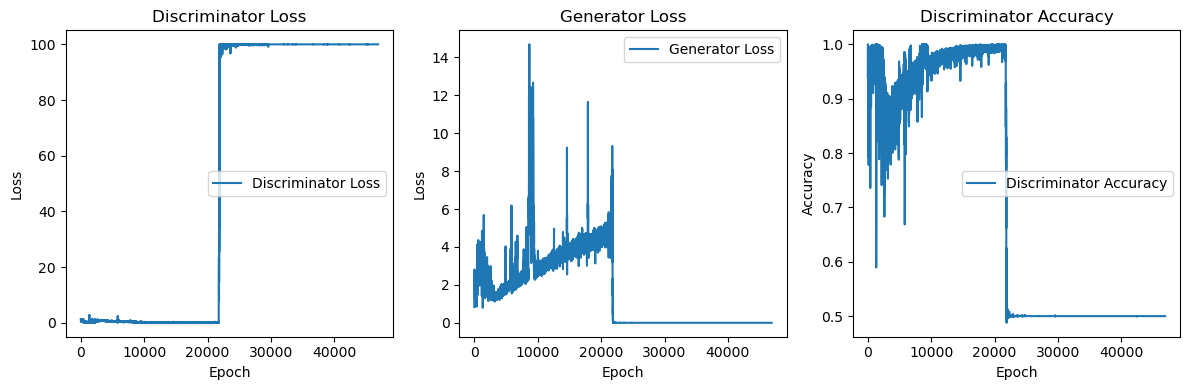

In [67]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
# Platting the values again

In [69]:
# Now we can calculate the averages and plot the values as previously done
# Calculate average values per epoch
avg_real_accuracies = []
avg_fake_accuracies = []
avg_d_losses = []
avg_g_losses = []

In [70]:
# Helper function for averaging
def calculate_average(values):
    return np.mean(values) if values else 0

current_epoch = 0
temp_real_acc = []
temp_fake_acc = []
temp_d_loss = []
temp_g_loss = []

In [71]:
for i in range(len(epochs)):
    if epochs[i] != current_epoch:
        # Calculate averages for the current epoch and reset lists
        avg_real_accuracies.append(calculate_average(temp_real_acc))
        avg_fake_accuracies.append(calculate_average(temp_fake_acc))
        avg_d_losses.append(calculate_average(temp_d_loss))
        avg_g_losses.append(calculate_average(temp_g_loss))

        temp_real_acc = []
        temp_fake_acc = []
        temp_d_loss = []
        temp_g_loss = []
        current_epoch = epochs[i]

    # Append current values
    temp_real_acc.append(real_accuracy_list[i])
    temp_fake_acc.append(fake_accuracy_list[i])
    temp_d_loss.append(d_losses[i])
    temp_g_loss.append(g_losses[i])

In [72]:
# Add averages for the last epoch
avg_real_accuracies.append(calculate_average(temp_real_acc))
avg_fake_accuracies.append(calculate_average(temp_fake_acc))
avg_d_losses.append(calculate_average(temp_d_loss))
avg_g_losses.append(calculate_average(temp_g_loss))

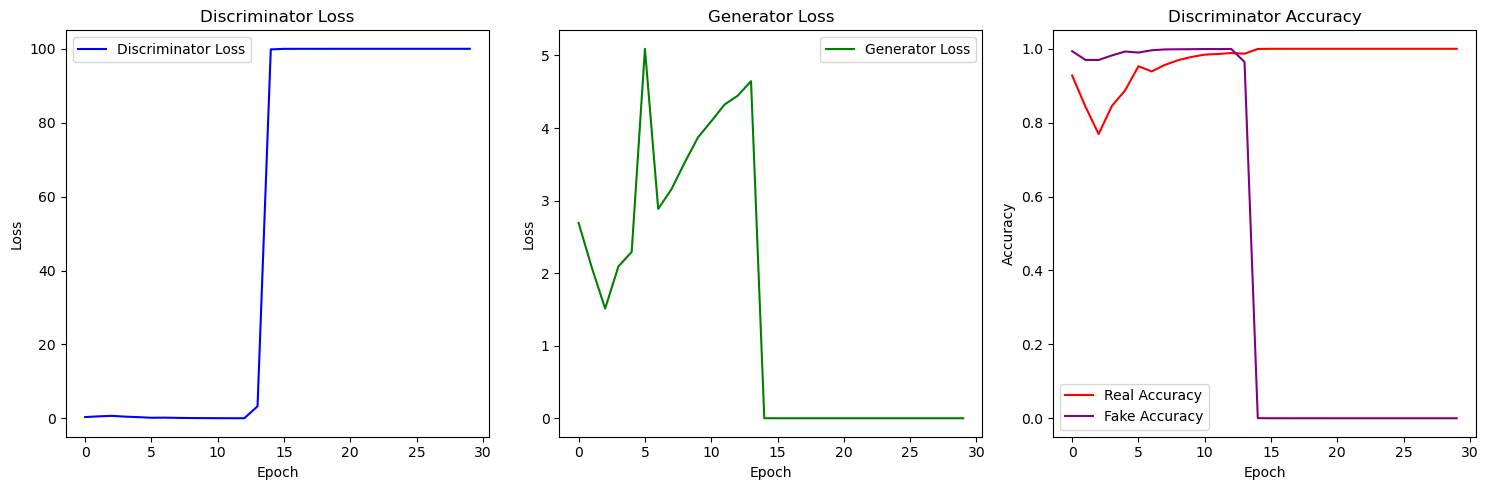

In [73]:
# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Plotting the graphs
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, avg_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, avg_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, avg_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, avg_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


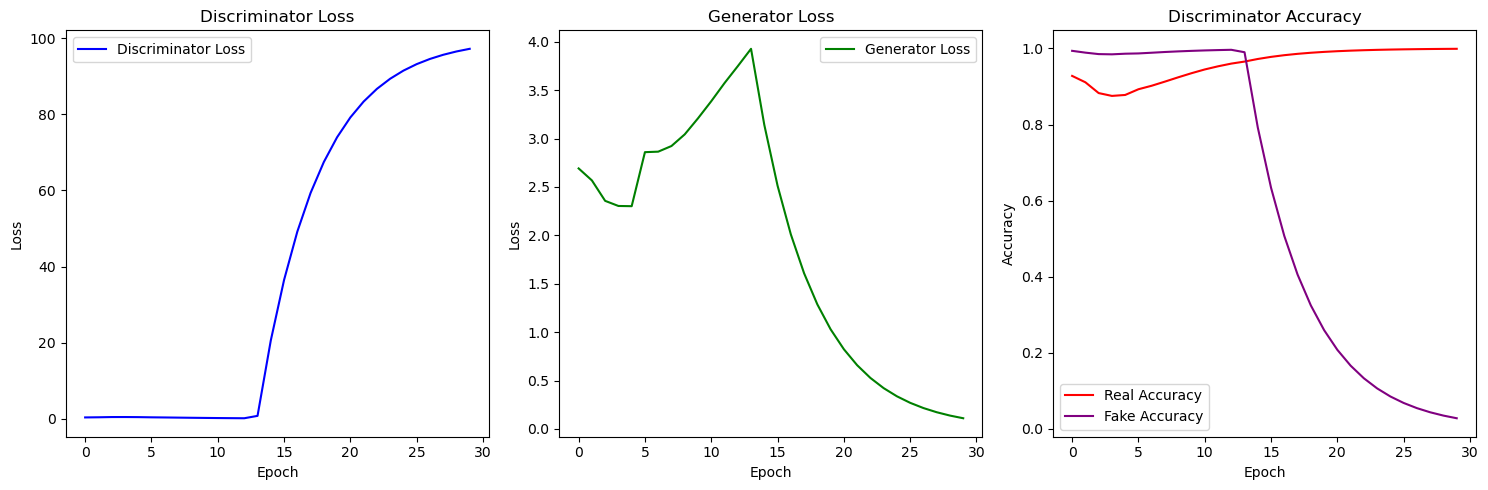

In [74]:
import matplotlib.pyplot as plt
import numpy as np


# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Smoothing the lines
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Applying smoothing
smoothed_d_losses = smooth_curve(avg_d_losses)
smoothed_g_losses = smooth_curve(avg_g_losses)
smoothed_real_accuracies = smooth_curve(avg_real_accuracies)
smoothed_fake_accuracies = smooth_curve(avg_fake_accuracies)

# Plotting the graphs with enhanced visualization
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, smoothed_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, smoothed_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, smoothed_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, smoothed_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
